In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import subprocess
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"
from scipy.stats import ttest_ind
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from lifelines.statistics import logrank_test
from tqdm import tqdm
import glob
from scipy.stats import pearsonr

from lifelines import KaplanMeierFitter
from lifelines import WeibullAFTFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from datetime import datetime
from scipy.stats import chi2

from multiprocessing import Pool

In [2]:
tag = "29_sept"
pheno_cols = ["ADP"]

# Read phenotypes scores

In [3]:
dfs = []
for chrom in range(1,23):
    if chrom == 21: continue
    try:
        df = pd.read_csv("%s/Genetic_score_Sysmex_traits/%s/good_score_chr%d.sscore" % (export_folder,tag,chrom),sep="\t")
        df["CHR"] = chrom
        dfs.append(df)
    except FileNotFoundError as e:
        print(e)

[Errno 2] No such file or directory: '/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/Genetic_score_Sysmex_traits/29_sept/good_score_chr4.sscore'
[Errno 2] No such file or directory: '/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/Genetic_score_Sysmex_traits/29_sept/good_score_chr6.sscore'
[Errno 2] No such file or directory: '/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/Genetic_score_Sysmex_traits/29_sept/good_score_chr7.sscore'
[Errno 2] No such file or directory: '/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/Genetic_score_Sysmex_traits/29_sept/good_score_chr13.sscore'
[Errno 2] No such file or directory: '/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing/Genetic_score_Sysmex_traits/29_sept/good_score_chr15.sscore'
[Errno 2] No such file or directory: '/home/hv270/rds/rds-who1000-cbrc/user/wj

In [4]:
scores = pd.concat(dfs,axis=0).groupby("IID")[[c for c in df.columns if "AVG" in c]].sum()
scores_cols = scores.columns
for col in scores_cols:
    scores = scores.rename(columns={col:col[:-4]})

In [5]:
scores.head()

,ADP
IID,
-31,-0.607786
-30,-0.534757
-29,-0.901069
-26,-1.043775
-24,-0.923825


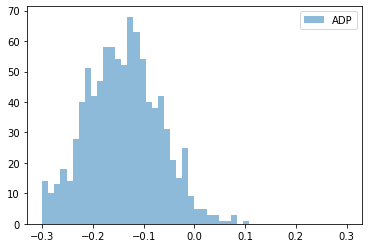

In [6]:
for s in scores:
    if s == "IPF": continue
    plt.hist(scores[s],label=s,alpha=.5,range=(-0.3,0.3),bins=50)
plt.legend()

# Read Sysmex Scores

In [7]:
sys_phenos = ["PLT#","MPV","PCT","PDW"]
score_dfs = []
for pheno in sys_phenos:
    dfs = []
    chrom_files = glob.glob("%s/Genetic_score_Sysmex_traits/%s_causal_score_chr*.sscore" % (export_folder,pheno))
    for i, score_file in enumerate(chrom_files):
        df = pd.read_csv(score_file,sep="\t")
        df["score"] = df["SCORE1_AVG"]
        dfs.append(df[["IID","score"]].rename(columns={"score":"score_%d" % i}))
    df = dfs[0]
    for d in dfs[1:]:
        df = pd.merge(df,d,left_on="IID",right_on="IID",how="inner")
    df = df.set_index("IID")
    score_dfs.append(pd.DataFrame(df.sum(axis=1)).rename(columns={0:pheno}))
scores_sys = pd.concat(score_dfs,axis=1)

In [8]:
scores_sys = scores_sys.rename(columns={"PLT#":"PLT"})
scores_sys = scores_sys.add_suffix("_score")
scores_sys

,PLT_score,MPV_score,PCT_score,PDW_score
IID,,,,
3988147,0.011610,-0.027600,0.007958,-0.005995
5152243,0.007862,-0.016196,0.005119,-0.002073
2770265,0.004983,-0.039424,-0.017437,-0.003341
3790399,-0.001070,-0.027039,-0.009639,0.011838
4681935,0.012693,-0.028224,0.001313,-0.005025
...,...,...,...,...
4494916,0.014897,-0.021669,0.001732,0.019635
4272180,-0.001114,-0.017683,-0.004186,0.024122
2654475,0.020629,-0.039821,-0.000400,-0.003238


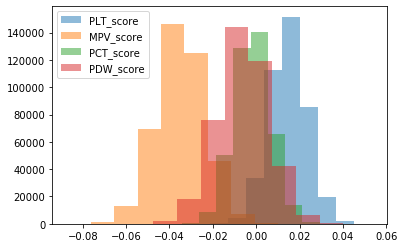

In [9]:
for c in scores_sys.columns:
    plt.hist(scores_sys[c],alpha=.5,label=c)
plt.legend()

In [10]:
scores = pd.merge(scores, scores_sys,left_index=True,right_index=True).rename(columns={"IPF":"IPF_score"})

In [11]:
scores

,ADP,PLT_score,MPV_score,PCT_score,PDW_score
IID,,,,,
-31,-0.607786,0.013870,-0.038411,0.002043,0.012144
-30,-0.534757,0.010895,-0.020617,0.000654,0.004897
-29,-0.901069,0.019516,-0.022408,0.006108,-0.013085
-26,-1.043775,0.007482,-0.030730,-0.006430,0.001571
-24,-0.923825,0.025847,-0.061521,0.005924,0.001087
...,...,...,...,...,...
6026501,-0.901393,0.012756,-0.040034,-0.010797,0.010232
6026513,-1.094810,0.002808,-0.023160,-0.011398,0.001974
6026522,-1.094871,0.013625,-0.052671,-0.008677,-0.005131


# Read UKBB outcomes

In [12]:
col_index = pd.read_csv("%s/Data_Dictionary_Showcase.tsv" % export_folder,sep="\t")
col_index.head(2)

,Path,Category,FieldID,Field,Participants,Items,Stability,ValueType,Units,ItemType,...,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82
0,UK Biobank Assessment Centre > Procedural metr...,152,3,Verbal interview duration,501635,568440,Complete,Integer,seconds,Data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,UK Biobank Assessment Centre > Procedural metr...,152,4,Biometrics duration,497955,568328,Complete,Integer,seconds,Data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
ages = col_index.loc[col_index.Field.str.contains("Age")].set_index("FieldID")["Field"].to_dict()

In [14]:
ukbb_path = "/home/hv270/rds/rds-who1000-cbrc/data/UKB_13745/flat_data/ukb44092.csv"
SEX_FIELD = "31-0.0" # 0 female, 1 male
ID_FIELD = "eid"
DEATH_FIELD = '40007-0.0' # Age at death
BIRTH_FIELD = "34-0.0"
KINSHIP = '22021-0.0'
ICD10_sec_code = ['41270-0.%d' % i for i in range(213)]
ICD10_sec_date = ['41280-0.%d' % i for i in range(213)]
ICD10_prim_dates = col_index.loc[col_index["Field"].str.contains("Date") & col_index["Field"].str.contains("first reported")].FieldID.astype(str).tolist()

# filter out missing ICD10_prim_dates
for chunk in pd.read_csv(ukbb_path,sep=",",chunksize=int(1e2),low_memory=False):
    ukbb_ = chunk
    ICD10_prim_dates_filtered = [c for c in ukbb_.columns if c.split("-")[0] in ICD10_prim_dates]
    break

ages_cols = ["%d-0.0" % a for a in ages]
ukbb_path = "/home/hv270/rds/rds-who1000-cbrc/data/UKB_13745/flat_data/ukb44092.csv"
cols = [ID_FIELD, SEX_FIELD, DEATH_FIELD, BIRTH_FIELD] + ICD10_sec_code + ICD10_sec_date + ages_cols + ICD10_prim_dates_filtered
str_cols = {}
for c in ICD10_sec_code:
    str_cols[c] = str

In [15]:
# Read full table
ukbb_ = pd.read_csv(ukbb_path,sep=",",usecols=cols, low_memory=True, 
                    dtype=str_cols,
                    parse_dates=ICD10_sec_date + [BIRTH_FIELD,DEATH_FIELD] + ICD10_prim_dates_filtered);
ukbb_.set_index(ID_FIELD,inplace=True)

In [16]:
all_ICD10_secondary = []
for c in ICD10_sec_code:
    all_ICD10_secondary += [code for code in ukbb_.loc[~ukbb_[c].isnull(),c].unique().tolist()]
all_ICD10_secondary = list(set(all_ICD10_secondary))
print(len(all_ICD10_secondary))
print(all_ICD10_secondary[:4])

11726
['N291', 'M959', 'M341', 'V209']


In [17]:
all_ICD10_sec_col = ukbb_[ICD10_sec_code].fillna("").astype(str).apply(lambda x: ' '.join(x), axis = 1)

In [18]:
min_n_cases = 150
all_ICD10_100 = [] # codes with min_n_cases+ cases

p = Pool(12)
def get_n_cases(c):
    return all_ICD10_sec_col.str.contains(c).sum(), c

for n_cases, c in p.imap_unordered(get_n_cases,tqdm(all_ICD10_secondary)):
    if n_cases >= min_n_cases:
        all_ICD10_100.append(c)
p.close()
p.join()
del p

  0%|          | 0/11726 [00:00<?, ?it/s]Process ForkPoolWorker-1:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Process ForkPoolWorker-5:
Process ForkPoolWorker-7:
Process ForkPoolWorker-12:
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Process ForkPoolWorker-8:
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-9:
Process ForkPoolWorker-11:
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-10:
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
Traceback (most recent call last):
  File "/home/hv270/pla

  File "/home/hv270/platelets/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task 

KeyboardInterrupt: 

Process ForkPoolWorker-18:
Process ForkPoolWorker-21:
Traceback (most recent call last):
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
Traceback (most recent call last):
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/h

In [19]:
len(all_ICD10_100)

2447

In [20]:
ICD10_primary_codes = {} # col -> code
ICD10_primary_desc = {} # col -> desc
col_index["ICD10_code"] = col_index["Field"].str.split(" ",expand=True)[1]
col_index["ICD10_desc"] = col_index["Field"].str.split("(",expand=True)[1].str.split(")",expand=True)[0]
ICD10_primary_codes = col_index.loc[col_index["Field"].str.contains("Date") & 
                            col_index["Field"].str.contains("first reported"),
                            ["FieldID","ICD10_code"]].set_index("FieldID")["ICD10_code"].to_dict()
ICD10_primary_desc = col_index.loc[col_index["Field"].str.contains("Date") & 
                            col_index["Field"].str.contains("first reported"),
                            ["FieldID","ICD10_desc"]].set_index("FieldID")["ICD10_desc"].to_dict()
ICD10_primary_col = {} # code -> col
all_ICD10_primary = []
for c in ICD10_primary_codes:
    ICD10_primary_col[ICD10_primary_codes[c]] = c
    all_ICD10_primary.append(ICD10_primary_codes[c])

In [21]:
# Build dict of ICD10_sec_code -> dict of ID -> date
ICD10_sec_event_dates = {}

def get_dates_dict(code):
    dates_dict = {}# ID -> date
    sub = ukbb_.loc[all_ICD10_sec_col.str.contains(code)]
    for date_col, code_col in zip(ICD10_sec_date,ICD10_sec_code):
        is_code = (sub[code_col] == code)
        dates_dict.update(sub.loc[is_code,date_col].to_dict())
    return code, dates_dict
        
p = Pool(12)
for code, d in p.imap_unordered(get_dates_dict, tqdm(all_ICD10_secondary)):
    ICD10_sec_event_dates[code] = d
    
p.close()

100%|██████████| 11726/11726 [05:18<00:00, 36.78it/s]


In [22]:
p.join()
del p

In [23]:
rel = pd.read_csv("/home/hv270/rds/rds-wja24-uk-biobank-gen/rel/ukb13745_rel_s488339.dat",sep=" ")
related_people = rel.loc[rel.Kinship < 0.0612].ID2.unique().tolist()

european_individuals = pd.read_csv("/rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/blood_trait_gwas_2020_contributing_ids.tsv",header=None)
european_individuals = european_individuals.rename(columns={0:"FID"})
EUR_IDs = european_individuals.FID.tolist()

In [24]:
to_keep = ukbb_.index.isin(EUR_IDs) & ~ukbb_.index.isin(related_people)
to_keep.sum()

384059

In [25]:
UKB = ukbb_.loc[to_keep]
UKB = UKB.loc[~UKB[BIRTH_FIELD].isnull()]
UKB = UKB.loc[~UKB[SEX_FIELD].isnull()]
UKB = pd.merge(UKB,scores,left_index=True,right_index=True)

In [26]:
UKB["AGE"] = (datetime.now() - UKB[BIRTH_FIELD]).dt.days // 365
is_dead = ~UKB[DEATH_FIELD].isnull()
UKB.loc[is_dead,"AGE"] = UKB.loc[is_dead,DEATH_FIELD].astype(float)

In [27]:
for c in ICD10_sec_date:
    UKB[c+"_AGE"] = (UKB[c] - UKB[BIRTH_FIELD]).dt.days // 365

In [28]:
ICD10_sec_desc = pd.read_csv("%s/coding19.tsv" % export_folder, sep="\t").set_index("coding")["meaning"].to_dict()

In [29]:
sysmex_covars = ["MPV_score","PLT_score","PDW_score","PCT_score"]  # ,"IPF_score"
cols_to_normalize = sysmex_covars + pheno_cols #,"IPF_score"
UKB[cols_to_normalize] -= UKB[cols_to_normalize].mean(axis=0)
UKB[cols_to_normalize] /= UKB[cols_to_normalize].std(axis=0)

In [30]:
pc_covars = ["sysmex_PC_%d" % i for i in range(len(sysmex_covars))]

In [31]:
from sklearn.decomposition import PCA

In [32]:
UKB[pc_covars] = PCA().fit_transform(UKB[sysmex_covars])

In [33]:
covars_1 = []
covars_1 += pc_covars

score_cols = ["ADP"]

ages_codes = list(ages.keys())

all_ICD10_only_secondary = [c for c in all_ICD10_secondary if len(c) > 3]

all_fields = ages_codes + sorted(all_ICD10_only_secondary+all_ICD10_primary)

In [34]:
cox_info = pd.DataFrame(index=all_fields)

cox_info["desc"] = np.nan
cox_info["n_cases"] = np.nan
for c in score_cols:
    cox_info["p_val_%s" % c] = 1.
    cox_info["HR_%s" % c] = 1.

In [35]:
def get_age_event_occured(code,verbose=False):
    
    age = UKB["AGE"].copy()
    
    if code in all_ICD10_only_secondary:
        if verbose:
            print("Secondary")
        desc = ICD10_sec_desc[code]
        if code not in all_ICD10_100:
            return code, desc, np.nan, 1., 1.
        event_occured = pd.Series(index=age.index,dtype=bool)
        event_occured.loc[:] = False
        for date_col, code_col in zip(ICD10_sec_date,ICD10_sec_code):
            is_code = (UKB[code_col] == code)
            age.loc[is_code] = UKB.loc[is_code, date_col+"_AGE"]
            event_occured.loc[is_code] = True
        
            
    elif code in all_ICD10_primary:
        if verbose:
            print("Primary...")
        code_col = "%d-0.0" % ICD10_primary_col[code]
        try:
            event_occured = (~UKB[code_col].isnull())
        except:
            print("Code not found : %s" % code_col)
            return None
        
        age.loc[event_occured] = (UKB.loc[event_occured,code_col] - UKB.loc[event_occured,BIRTH_FIELD]).dt.days // 365
        
        if code in all_ICD10_secondary:
            n_cases_start = event_occured.sum()
            try:
                for date_col, code_col in zip(ICD10_sec_date,ICD10_sec_code):
                    is_code = (UKB[code_col] == code)
                    age.loc[is_code] = UKB.loc[is_code, date_col+"_AGE"]
                    event_occured.loc[is_code] = True
                if verbose: print("And secondary")
                n_cases_end = event_occured.sum()
                if n_cases_end > n_cases_start:
                    print("%s : %d -> %d by merging primary and secondary" % (code, n_cases_start, n_cases_end))
            except Exception as e:
                print(e)
        
        desc = ICD10_primary_desc[ICD10_primary_col[code]]
        
    elif int(code) in ages_codes:
        code_col = "%d-0.0" % int(code)
        event_occured = (~UKB[code_col].isnull())
        age.loc[event_occured] = UKB.loc[event_occured,code_col]
        desc = ages[int(code)]
    else: 
        return None
    
    return desc, age, event_occured

In [36]:
def get_cox_row(code):
    
    event_col = "event"
    age_col = "age"
    
    #if cox_info.loc[code,"p"] < 1: continue
    
    _ = get_age_event_occured(code)
    if _ is None:
        print("Error with code %s" % code)
        return None
    desc, age, event_occured = _
    
    n_cases = event_occured.sum()
    
    if n_cases <= 100: 
        return code, desc, n_cases, [1.], [1.]
    
    UKB[event_col] = event_occured
    UKB[age_col] = age
    
    valid_sexes = UKB.loc[UKB[event_col],SEX_FIELD].value_counts()
    valid_sexes = valid_sexes.loc[valid_sexes > (n_cases / 50)].index.tolist()
    unisex = len(valid_sexes) == 1
    if unisex:
        desc += " (unisex)"
    #if unisex:
    #    print("unisex : ", desc)
    #if (not unisex) and (cox_info.loc[code,"HR"] != 1.) : continue
    
    to_include = UKB[SEX_FIELD].isin(valid_sexes)
    strata = [SEX_FIELD] if not unisex else None
    
    basics = [age_col,event_col]
    if not unisex:
        basics += [SEX_FIELD]
    cols_to_include_1 = basics + covars_1

    pen_args = {"penalizer":0.,"l1_ratio":1.}
    fit_args = {"duration_col":age_col,"event_col":event_col,"strata":strata,
                "show_progress":False}#"step_size":.1,

    aft1 = CoxPHFitter(**pen_args)
    aft1.fit(UKB.loc[to_include,cols_to_include_1], **fit_args) 

    p_vals = []
    HRs = []
    
    for s in score_cols:
        cols_to_include_2 = basics + covars_1 + [s]
        aft2 = CoxPHFitter(**pen_args)
        aft2.fit(UKB.loc[to_include,cols_to_include_2], **fit_args)

        LL_without = aft1.log_likelihood_
        LL_with = aft2.log_likelihood_
        Delta_LL = LL_with-LL_without
        p_val = 1.-chi2(len(score_cols)).cdf(2*Delta_LL)

        ### cox_info.loc[code, "p"] = p_val
        HR = aft2.hazard_ratios_[score_cols[0]]
        ### cox_info.loc[code, "HR"] = HR

        
        
        if p_val < 1e-3:
            plt.figure()
            plt.title(desc)
            aft2.plot()
        p_vals.append(p_val)
        HRs.append(HR)
    description = ""
    for i, s in enumerate(score_cols):
        description += "| %s : %.2f\t" % (s,-np.log10(p_vals[i]))
    description += "%d cases \t %s \t %s" % (n_cases, code, desc)
    if np.min(p_vals) < 1e-3:
        print("==========================")
    print(description)
    if np.min(p_vals) < 1e-3:
        print("==========================")
        
    return code, desc, n_cases, p_vals, HRs

In [37]:
desc, age, event_occured_1 = get_age_event_occured("I21",verbose=True)
print(event_occured_1.sum())
desc, age, event_occured_2 = get_age_event_occured("I210",verbose=True)
print(event_occured_2.sum())
event_occured_1.loc[event_occured_2].mean()

Primary...
14089
Secondary
1732


1.0

In [38]:
susceptible = (cox_info.index.isin(all_ICD10_primary) | cox_info.index.isin(all_ICD10_100) | cox_info.index.isin([str(c) for c in ages_codes]))
empty = cox_info.desc.isnull() | cox_info.n_cases.isnull()
remaining_fields = list(set(cox_info.loc[susceptible & empty].index.tolist()))
print(len(remaining_fields))

3449


In [39]:
p = Pool(14)
for _ in tqdm(p.imap_unordered(get_cox_row,remaining_fields),total=len(remaining_fields)):
    if _ is None: continue
    code, desc, n_cases, p_vals, HRs = _
    cox_info.loc[code,"desc"] = desc
    cox_info.loc[code,"n_cases"] = n_cases
    for i, s in enumerate(score_cols):
        cox_info.loc[code,"p_val_%s" % s] = p_vals[i]
        cox_info.loc[code,"HR_%s" % s] = HRs[i]
p.close()
p.join()

  0%|          | 0/3449 [00:00<?, ?it/s]

| ADP : 0.76	141 cases 	 Q52 	 other congenital malformations of female genitalia (unisex)


  0%|          | 2/3449 [00:17<8:25:33,  8.80s/it]

| ADP : 0.81	260 cases 	 N739 	 N73.9 Female pelvic inflammatory disease, unspecified (unisex)


  0%|          | 3/3449 [00:19<5:33:56,  5.81s/it]

| ADP : 0.06	242 cases 	 N771 	 N77.1 Vaginitis, vulvitis and vulvovaginitis in infectious and parasitic diseases classified elsewhere (unisex)


  0%|          | 4/3449 [00:27<6:17:25,  6.57s/it]

| ADP : 0.96	115 cases 	 Q83 	 congenital malformations of breast


  0%|          | 5/3449 [00:32<5:57:29,  6.23s/it]

| ADP : 0.06	107 cases 	 D129 	 D12.9 Anus and anal canal


  0%|          | 6/3449 [00:35<4:46:45,  5.00s/it]

| ADP : 0.53	182 cases 	 Q27 	 other congenital malformations of peripheral vascular system


  0%|          | 9/3449 [00:35<2:01:39,  2.12s/it]

| ADP : 0.03	583 cases 	 D61 	 other aplastic anaemias
| ADP : 0.52	169 cases 	 S0250 	 S02.50 Fracture of tooth (closed)


  0%|          | 10/3449 [00:35<1:41:03,  1.76s/it]

| ADP : 0.09	1730 cases 	 J329 	 J32.9 Chronic sinusitis, unspecified


  0%|          | 13/3449 [00:37<1:08:53,  1.20s/it]

| ADP : 0.31	4718 cases 	 Z951 	 Z95.1 Presence of aortocoronary bypass graft


  0%|          | 15/3449 [00:38<53:52,  1.06it/s]  

| ADP : 0.72	201 cases 	 K351 	 K35.1 Acute appendicitis with peritoneal abscess
| ADP : 0.30	112 cases 	 K265 	 K26.5 Chronic or unspecified with perforation


  0%|          | 16/3449 [00:40<1:12:34,  1.27s/it]

| ADP : 0.51	507 cases 	 T830 	 T83.0 Mechanical complication of urinary (indwelling) catheter
| ADP : 0.27	142 cases 	 M9486 	 M94.86 Other specified disorders of cartilage (Lower leg)


  1%|          | 19/3449 [00:42<57:58,  1.01s/it]  

| ADP : 0.35	646 cases 	 L63 	 alopecia areata
| ADP : 0.17	439 cases 	 O62 	 abnormalities of forces of labour (unisex)


  1%|          | 21/3449 [00:44<49:52,  1.15it/s]

| ADP : 0.45	136 cases 	 R440 	 R44.0 Auditory hallucinations


  1%|          | 23/3449 [00:44<34:16,  1.67it/s]

| ADP : 0.09	126 cases 	 I634 	 I63.4 Cerebral infarction due to embolism of cerebral arteries


  1%|          | 24/3449 [00:56<3:18:14,  3.47s/it]

| ADP : 0.50	233 cases 	 K513 	 K51.3 Ulcerative (chronic) rectosigmoiditis


  1%|          | 25/3449 [00:57<2:31:41,  2.66s/it]

| ADP : 0.14	260 cases 	 M8090 	 M80.90 Unspecified osteoporosis with pathological fracture (Multiple sites)


  1%|          | 27/3449 [01:00<1:53:43,  1.99s/it]

| ADP : 0.28	203 cases 	 S509 	 S50.9 Superficial injury of forearm, unspecified


  1%|          | 28/3449 [01:01<1:42:13,  1.79s/it]

| ADP : 0.01	178 cases 	 G936 	 G93.6 Cerebral oedema


  1%|          | 29/3449 [01:01<1:21:02,  1.42s/it]

| ADP : 0.31	211 cases 	 M7065 	 M70.65 Trochanteric bursitis-Pelvic/Thigh
| ADP : 1.51	147 cases 	 D046 	 D04.6 Skin of upper limb, including shoulder


  1%|          | 33/3449 [01:04<53:28,  1.06it/s]  

| ADP : 0.15	393 cases 	 D173 	 D17.3 Benign lipomatous neoplasm of skin and subcutaneous tissue of other and unspecified sites


  1%|          | 35/3449 [01:04<36:10,  1.57it/s]

| ADP : 0.68	119 cases 	 U821 	 U82.1 Resistance to methicillin


  1%|          | 36/3449 [01:05<47:52,  1.19it/s]

| ADP : 0.69	284 cases 	 L023 	 L02.3 Cutaneous abscess, furuncle and carbuncle of buttock


  1%|          | 37/3449 [01:07<51:50,  1.10it/s]

| ADP : 0.16	1786 cases 	 I951 	 I95.1 Orthostatic hypotension


  1%|          | 39/3449 [01:08<43:30,  1.31it/s]

| ADP : 0.35	140 cases 	 M2107 	 M21.07 Valgus deformity, not elsewhere classified (Ankle and foot)


  1%|          | 40/3449 [01:08<41:35,  1.37it/s]

| ADP : 1.48	261 cases 	 D221 	 D22.1 Melanocytic naevi of eyelid, including canthus


  1%|          | 43/3449 [01:11<46:05,  1.23it/s]

| ADP : 0.09	605 cases 	 M2336 	 M23.36 Other meniscus derangements (Other and unspecified lateral meniscus)


  1%|▏         | 46/3449 [01:13<49:59,  1.13it/s]

| ADP : 0.11	435 cases 	 A16 	 respiratory tuberculosis, not confirmed bacteriologically or histologically


  1%|▏         | 47/3449 [01:20<2:10:04,  2.29s/it]

| ADP : 1.23	127 cases 	 H06 	 disorders of lachrymal system and orbit in diseases classified elsewhere


  1%|▏         | 48/3449 [01:22<2:04:59,  2.21s/it]

| ADP : 0.09	6115 cases 	 Z888 	 Z88.8 Personal history of allergy to other drugs, medicaments and biological substances


  1%|▏         | 49/3449 [01:23<1:51:06,  1.96s/it]

| ADP : 0.81	7361 cases 	 A099 	 A09.9 Gastroenteritis and colitis of unspecified origin


  1%|▏         | 50/3449 [01:25<1:43:36,  1.83s/it]

| ADP : 0.37	2439 cases 	 J43 	 emphysema


  1%|▏         | 51/3449 [01:25<1:17:49,  1.37s/it]

| ADP : 0.19	1035 cases 	 M478 	 M47.8 Other spondylosis


  2%|▏         | 52/3449 [01:26<1:08:15,  1.21s/it]

| ADP : 0.11	199 cases 	 I201 	 I20.1 Angina pectoris with documented spasm


  2%|▏         | 53/3449 [01:26<53:19,  1.06it/s]  

| ADP : 0.56	498 cases 	 I702 	 I70.2 Atherosclerosis of arteries of the extremities


  2%|▏         | 54/3449 [01:29<1:21:18,  1.44s/it]

| ADP : 0.07	2444 cases 	 M22 	 disorders of patella


  2%|▏         | 55/3449 [01:29<1:11:03,  1.26s/it]

| ADP : 1.23	4167 cases 	 R072 	 R07.2 Precordial pain


  2%|▏         | 57/3449 [01:32<1:14:39,  1.32s/it]

| ADP : 0.17	235 cases 	 I830 	 I83.0 Varicose veins of lower extremities with ulcer


  2%|▏         | 58/3449 [01:34<1:24:37,  1.50s/it]

| ADP : 0.38	387 cases 	 O420 	 O42.0 Premature rupture of membranes, onset of labour within 24 hours (unisex)


  2%|▏         | 59/3449 [01:35<1:09:27,  1.23s/it]

| ADP : 0.12	227 cases 	 I330 	 I33.0 Acute and subacute infective endocarditis


  2%|▏         | 60/3449 [01:37<1:31:45,  1.62s/it]

| ADP : 0.08	6535 cases 	 H251 	 H25.1 Senile nuclear cataract


  2%|▏         | 61/3449 [01:38<1:17:45,  1.38s/it]

| ADP : 0.41	1104 cases 	 B370 	 B37.0 Candidal stomatitis


  2%|▏         | 62/3449 [01:41<1:46:53,  1.89s/it]

| ADP : 0.19	266 cases 	 R064 	 R06.4 Hyperventilation


  2%|▏         | 63/3449 [01:45<2:21:09,  2.50s/it]

| ADP : 0.99	364 cases 	 L032 	 L03.2 Cellulitis of face


  2%|▏         | 65/3449 [01:46<1:33:22,  1.66s/it]

| ADP : 0.20	697 cases 	 C782 	 C78.2 Secondary malignant neoplasm of pleura


  2%|▏         | 66/3449 [01:49<1:42:04,  1.81s/it]

| ADP : 0.51	128 cases 	 F320 	 F32.0 Mild depressive episode


  2%|▏         | 67/3449 [01:49<1:24:42,  1.50s/it]

| ADP : 0.52	3787 cases 	 S5250 	 S52.50 Fracture of lower end of radius (closed)


  2%|▏         | 68/3449 [01:50<1:17:17,  1.37s/it]

| ADP : 0.11	115 cases 	 H262 	 H26.2 Complicated cataract


  2%|▏         | 69/3449 [01:51<1:00:59,  1.08s/it]

| ADP : 0.21	266 cases 	 M7987 	 M79.87 Other specified soft tissue disorders (Ankle and foot)


  2%|▏         | 70/3449 [01:52<1:11:57,  1.28s/it]

| ADP : 0.66	380 cases 	 A80 	 acute poliomyelitis


  2%|▏         | 71/3449 [01:55<1:31:11,  1.62s/it]

| ADP : 0.00	1060 cases 	 Z507 	 Z50.7 Occupational therapy and vocational rehabilitation, not elsewhere classified


  2%|▏         | 72/3449 [01:55<1:16:02,  1.35s/it]

| ADP : 0.16	6182 cases 	 M76 	 enthesopathies of lower limb, excluding foot


  2%|▏         | 74/3449 [01:58<1:11:51,  1.28s/it]

| ADP : 0.48	2416 cases 	 N858 	 N85.8 Other specified noninflammatory disorders of uterus (unisex)


  2%|▏         | 75/3449 [02:00<1:26:12,  1.53s/it]

| ADP : 0.48	151 cases 	 L66 	 cicatricial alopecia [scarring hair loss]


  2%|▏         | 76/3449 [02:01<1:14:55,  1.33s/it]

| ADP : 0.12	292 cases 	 M5458 	 M54.58 Low back pain (Sacral and sacrococcygeal region)


  2%|▏         | 77/3449 [02:01<1:01:25,  1.09s/it]

| ADP : 0.43	5143 cases 	 G473 	 G47.3 Sleep apnoea


  2%|▏         | 78/3449 [02:03<1:09:23,  1.24s/it]

| ADP : 1.04	232 cases 	 K521 	 K52.1 Toxic gastro-enteritis and colitis


  2%|▏         | 80/3449 [02:07<1:30:43,  1.62s/it]

| ADP : 0.19	1106 cases 	 G992 	 G99.2 Myelopathy in diseases classified elsewhere


  2%|▏         | 81/3449 [02:09<1:39:43,  1.78s/it]

| ADP : 0.92	17267 cases 	 I83 	 varicose veins of lower extremities


  2%|▏         | 83/3449 [02:13<1:42:18,  1.82s/it]

| ADP : 1.23	544 cases 	 D226 	 D22.6 Melanocytic naevi of upper limb, including shoulder


  2%|▏         | 84/3449 [02:13<1:22:56,  1.48s/it]

| ADP : 0.16	351 cases 	 S681 	 S68.1 Traumatic amputation of other single finger (complete)(partial)


  2%|▏         | 85/3449 [02:14<1:12:13,  1.29s/it]

| ADP : 0.17	1852 cases 	 M94 	 other disorders of cartilage


  2%|▏         | 86/3449 [02:14<55:55,  1.00it/s]  

| ADP : 1.27	4289 cases 	 K51 	 ulcerative colitis


  3%|▎         | 89/3449 [02:17<48:01,  1.17it/s]  

| ADP : 0.35	7994 cases 	 Z866 	 Z86.6 Personal history of diseases of the nervous system and sense organs


  3%|▎         | 90/3449 [02:19<1:12:01,  1.29s/it]

| ADP : 0.10	342 cases 	 M329 	 M32.9 Systemic lupus erythematosus, unspecified
| ADP : 0.05	271 cases 	 F522 	 F52.2 Failure of genital response (unisex)


  3%|▎         | 93/3449 [02:20<45:31,  1.23it/s]  

| ADP : 0.32	485 cases 	 I609 	 I60.9 Subarachnoid haemorrhage, unspecified


  3%|▎         | 94/3449 [02:23<1:04:54,  1.16s/it]

| ADP : 0.73	208 cases 	 D529 	 D52.9 Folate deficiency anaemia, unspecified


  3%|▎         | 95/3449 [02:26<1:25:49,  1.54s/it]

| ADP : 0.11	123 cases 	 J040 	 J04.0 Acute laryngitis


  3%|▎         | 96/3449 [02:26<1:09:58,  1.25s/it]

| ADP : 0.71	162 cases 	 C340 	 C34.0 Main bronchus


  3%|▎         | 97/3449 [02:28<1:18:30,  1.41s/it]

| ADP : 0.15	1202 cases 	 K70 	 alcoholic liver disease


  3%|▎         | 98/3449 [02:28<1:01:50,  1.11s/it]

| ADP : 0.90	1541 cases 	 R600 	 R60.0 Localised oedema


  3%|▎         | 99/3449 [02:28<49:37,  1.13it/s]  

| ADP : 0.18	140 cases 	 D59 	 acquired haemolytic anaemia


  3%|▎         | 100/3449 [02:35<2:19:19,  2.50s/it]

| ADP : 0.18	16839 cases 	 M23 	 internal derangement of knee


  3%|▎         | 101/3449 [02:36<2:01:10,  2.17s/it]

| ADP : 0.11	128 cases 	 M2559 	 M25.59 Pain in joint (Site unspecified)


  3%|▎         | 102/3449 [02:38<1:58:43,  2.13s/it]

| ADP : 0.44	212 cases 	 S510 	 S51.0 Open wound of elbow


  3%|▎         | 103/3449 [02:41<2:01:04,  2.17s/it]

| ADP : 0.08	122 cases 	 M7227 	 M72.27 Plantar fascial fibromatosis-Ankle/Foot


  3%|▎         | 104/3449 [02:42<1:42:41,  1.84s/it]

| ADP : 0.27	304 cases 	 S9200 	 S92.00 Fracture of calcaneus (closed)


  3%|▎         | 105/3449 [02:43<1:31:46,  1.65s/it]

| ADP : 0.00	813 cases 	 Z048 	 Z04.8 Examination and observation for other specified reasons


  3%|▎         | 106/3449 [02:44<1:25:50,  1.54s/it]

| ADP : 0.36	196 cases 	 Z490 	 Z49.0 Preparatory care for dialysis


  3%|▎         | 107/3449 [02:46<1:24:39,  1.52s/it]

| ADP : 0.04	464 cases 	 H31 	 other disorders of choroid


  3%|▎         | 109/3449 [02:46<47:45,  1.17it/s]  

| ADP : 0.12	501 cases 	 G63 	 polyneuropathy in diseases classified elsewhere


  3%|▎         | 110/3449 [02:49<1:16:11,  1.37s/it]

| ADP : 0.84	1551 cases 	 N926 	 N92.6 Irregular menstruation, unspecified (unisex)


  3%|▎         | 111/3449 [02:51<1:30:14,  1.62s/it]

| ADP : 0.88	3405 cases 	 J04 	 acute laryngitis and tracheitis


  3%|▎         | 112/3449 [02:51<1:10:43,  1.27s/it]

| ADP : 0.49	218 cases 	 Z930 	 Z93.0 Tracheostomy status


  3%|▎         | 113/3449 [02:53<1:11:36,  1.29s/it]

| ADP : 1.37	1125 cases 	 Z954 	 Z95.4 Presence of other heart-valve replacement
| ADP : 0.16	164 cases 	 D035 	 D03.5 Melanoma in situ of trunk


  3%|▎         | 115/3449 [02:53<41:07,  1.35it/s]  

| ADP : 0.22	1253 cases 	 D250 	 D25.0 Submucous leiomyoma of uterus (unisex)


  3%|▎         | 116/3449 [02:54<50:25,  1.10it/s]

| ADP : 0.24	254 cases 	 M254 	 M25.4 Effusion of joint


  3%|▎         | 117/3449 [03:00<1:51:34,  2.01s/it]

| ADP : 0.11	905 cases 	 M798 	 M79.8 Other specified soft tissue disorders


  3%|▎         | 118/3449 [03:01<1:40:59,  1.82s/it]

| ADP : 0.03	451 cases 	 Z877 	 Z87.7 Personal history of congenital malformations, deformations and chromosomal abnormalities


  3%|▎         | 120/3449 [03:02<1:16:16,  1.37s/it]

| ADP : 0.14	2133 cases 	 C679 	 C67.9 Bladder, unspecified


  4%|▎         | 121/3449 [03:06<1:40:13,  1.81s/it]

| ADP : 0.55	805 cases 	 Z509 	 Z50.9 Care involving use of rehabilitation procedure, unspecified


  4%|▎         | 124/3449 [03:08<1:07:54,  1.23s/it]

| ADP : 0.33	281 cases 	 N180 	 N18.0 End-stage renal disease


  4%|▎         | 125/3449 [03:10<1:21:51,  1.48s/it]

| ADP : 0.31	176 cases 	 F431 	 F43.1 Posttraumatic stress disorder


  4%|▎         | 126/3449 [03:11<1:12:05,  1.30s/it]

| ADP : 0.09	17401 cases 	 G56 	 mononeuropathies of upper limb


  4%|▎         | 128/3449 [03:11<47:11,  1.17it/s]  

| ADP : 0.45	662 cases 	 Z916 	 Z91.6 Personal history of other physical trauma


  4%|▎         | 129/3449 [03:15<1:24:10,  1.52s/it]

| ADP : 0.07	138 cases 	 G00 	 bacterial meningitis, not elsewhere classified
| ADP : 0.27	215 cases 	 M541 	 M54.1 Radiculopathy


  4%|▍         | 131/3449 [03:17<1:08:38,  1.24s/it]

| ADP : 0.74	1208 cases 	 G562 	 G56.2 Lesion of ulnar nerve


  4%|▍         | 132/3449 [03:17<1:04:47,  1.17s/it]

| ADP : 0.09	164 cases 	 Z225 	 Z22.5 Carrier of viral hepatitis


  4%|▍         | 133/3449 [03:19<1:04:54,  1.17s/it]

| ADP : 0.14	2047 cases 	 N45 	 orchitis and epididymitis (unisex)


  4%|▍         | 134/3449 [03:19<57:48,  1.05s/it]  

| ADP : 0.17	158 cases 	 M216 	 M21.6 Other acquired deformities of ankle and foot


  4%|▍         | 135/3449 [03:20<48:58,  1.13it/s]

| ADP : 0.31	150 cases 	 Q612 	 Q61.2 Polycystic kidney, adult type


  4%|▍         | 136/3449 [03:25<1:58:58,  2.15s/it]

| ADP : 0.41	157 cases 	 N321 	 N32.1 Vesicointestinal fistula


  4%|▍         | 137/3449 [03:26<1:34:22,  1.71s/it]

| ADP : 0.57	535 cases 	 N029 	 N02.9 Unspecified


  4%|▍         | 138/3449 [03:27<1:23:11,  1.51s/it]

| ADP : 0.32	1489 cases 	 O800 	 O80.0 Spontaneous vertex delivery (unisex)


  4%|▍         | 139/3449 [03:29<1:34:13,  1.71s/it]

| ADP : 0.94	328 cases 	 M181 	 M18.1 Other primary arthrosis of first carpometacarpal joint


  4%|▍         | 140/3449 [03:30<1:14:51,  1.36s/it]

| ADP : 1.00	2423 cases 	 D51 	 vitamin b12 deficiency anaemia


  4%|▍         | 141/3449 [03:31<1:15:40,  1.37s/it]

| ADP : 0.10	13290 cases 	 N30 	 cystitis


  4%|▍         | 142/3449 [03:32<1:03:11,  1.15s/it]

| ADP : 0.24	52921 cases 	 M54 	 dorsalgia


  4%|▍         | 143/3449 [03:35<1:34:06,  1.71s/it]

| ADP : 0.25	3207 cases 	 K029 	 K02.9 Dental caries, unspecified


  4%|▍         | 144/3449 [03:38<2:06:30,  2.30s/it]

| ADP : 0.18	2557 cases 	 I340 	 I34.0 Mitral (valve) insufficiency


  4%|▍         | 145/3449 [03:41<2:08:40,  2.34s/it]

| ADP : 0.47	12873 cases 	 M10 	 gout


  4%|▍         | 146/3449 [03:41<1:42:46,  1.87s/it]

| ADP : 1.25	4929 cases 	 L721 	 L72.1 Trichilemmal cyst
| ADP : 0.44	129 cases 	 N136 	 N13.6 Pyonephrosis


  4%|▍         | 151/3449 [03:45<56:22,  1.03s/it]  

| ADP : 0.46	179 cases 	 C785 	 C78.5 Secondary malignant neoplasm of large intestine and rectum
| ADP : 1.09	1699 cases 	 L43 	 lichen planus


  4%|▍         | 153/3449 [03:47<54:44,  1.00it/s]

| ADP : 0.35	227 cases 	 G610 	 G61.0 Guillain-Barre syndrome


  4%|▍         | 154/3449 [03:49<1:08:55,  1.26s/it]

| ADP : 1.27	653 cases 	 H74 	 other disorders of middle ear and mastoid


  4%|▍         | 155/3449 [03:51<1:21:26,  1.48s/it]

| ADP : 1.31	117 cases 	 I723 	 I72.3 Aneurysm of iliac artery


  5%|▍         | 156/3449 [03:53<1:23:33,  1.52s/it]

| ADP : 0.22	117 cases 	 A081 	 A08.1 Acute gastro-enteropathy due to Norwalk agent


  5%|▍         | 157/3449 [03:55<1:33:35,  1.71s/it]

| ADP : 0.56	1571 cases 	 K402 	 K40.2 Bilateral inguinal hernia, without obstruction or gangrene


  5%|▍         | 158/3449 [03:55<1:11:32,  1.30s/it]

| ADP : 0.13	234 cases 	 C539 	 C53.9 Cervix uteri, unspecified (unisex)


  5%|▍         | 159/3449 [03:55<54:30,  1.01it/s]  

| ADP : 0.18	271 cases 	 K430 	 K43.0 Ventral hernia with obstruction, without gangrene


  5%|▍         | 160/3449 [03:56<50:51,  1.08it/s]

| ADP : 0.41	168 cases 	 W440 	 W44.0 Home


  5%|▍         | 161/3449 [04:01<1:49:05,  1.99s/it]

| ADP : 0.55	234 cases 	 E112 	 E11.2 With renal complications


  5%|▍         | 162/3449 [04:02<1:43:05,  1.88s/it]

| ADP : 1.22	329 cases 	 N648 	 N64.8 Other specified disorders of breast (unisex)


  5%|▍         | 163/3449 [04:03<1:22:27,  1.51s/it]

| ADP : 0.52	2170 cases 	 H258 	 H25.8 Other senile cataract


  5%|▍         | 164/3449 [04:05<1:31:51,  1.68s/it]

| ADP : 0.06	430 cases 	 C800 	 C80.0 Malignant neoplasm, primary site unknown, so stated


  5%|▍         | 165/3449 [04:05<1:09:14,  1.27s/it]

| ADP : 0.05	813 cases 	 K639 	 K63.9 Disease of intestine, unspecified


  5%|▍         | 166/3449 [04:08<1:32:10,  1.68s/it]

| ADP : 0.09	261 cases 	 Z088 	 Z08.8 Follow-up examination after other treatment for malignant neoplasm


  5%|▍         | 167/3449 [04:10<1:37:27,  1.78s/it]

| ADP : 0.44	168 cases 	 C674 	 C67.4 Posterior wall of bladder


  5%|▍         | 169/3449 [04:12<1:13:02,  1.34s/it]

| ADP : 0.83	203 cases 	 C186 	 C18.6 Descending colon


  5%|▍         | 170/3449 [04:14<1:24:54,  1.55s/it]

| ADP : 0.53	281 cases 	 K353 	 K35.3 Acute appendicitis with localized peritonitis


  5%|▍         | 171/3449 [04:16<1:36:34,  1.77s/it]

| ADP : 0.39	298 cases 	 N904 	 N90.4 Leukoplakia of vulva (unisex)


  5%|▍         | 172/3449 [04:18<1:33:22,  1.71s/it]

| ADP : 0.37	3506 cases 	 K227 	 K22.7 Barrett's oesophagus


  5%|▌         | 173/3449 [04:20<1:39:40,  1.83s/it]

| ADP : 0.65	195 cases 	 E274 	 E27.4 Other and unspecified adrenocortical insufficiency


  5%|▌         | 174/3449 [04:21<1:27:18,  1.60s/it]

| ADP : 0.14	193 cases 	 O470 	 O47.0 False labour before 37 completed weeks of gestation (unisex)


  5%|▌         | 175/3449 [04:22<1:10:33,  1.29s/it]

| ADP : 0.17	891 cases 	 N323 	 N32.3 Diverticulum of bladder
| ADP : 0.02	1523 cases 	 R208 	 R20.8 Other and unspecified disturbances of skin sensation


  5%|▌         | 177/3449 [04:22<47:20,  1.15it/s]  

| ADP : 0.74	273 cases 	 Z900 	 Z90.0 Acquired absence of part of head and neck


  5%|▌         | 178/3449 [04:27<1:32:10,  1.69s/it]

| ADP : 1.40	156 cases 	 I221 	 I22.1 Subsequent myocardial infarction of inferior wall


  5%|▌         | 179/3449 [04:28<1:32:34,  1.70s/it]

| ADP : 0.35	2147 cases 	 Y433 	 Y43.3 Other antineoplastic drugs


  5%|▌         | 180/3449 [04:30<1:30:15,  1.66s/it]

| ADP : 0.65	300 cases 	 B49 	 unspecified mycosis


  5%|▌         | 181/3449 [04:30<1:14:13,  1.36s/it]

| ADP : 0.62	220 cases 	 D350 	 D35.0 Adrenal gland


  5%|▌         | 183/3449 [04:31<44:09,  1.23it/s]  

| ADP : 0.84	162 cases 	 M7791 	 M77.91 Enthesopathy, unspecified (Shoulder region)


  5%|▌         | 184/3449 [04:34<1:27:24,  1.61s/it]

| ADP : 0.16	22977 cases 	 R074 	 R07.4 Chest pain, unspecified


  5%|▌         | 186/3449 [04:39<1:45:42,  1.94s/it]

| ADP : 1.01	173 cases 	 G822 	 G82.2 Paraplegia, unspecified


  5%|▌         | 187/3449 [04:40<1:26:13,  1.59s/it]

| ADP : 0.12	383 cases 	 N701 	 N70.1 Chronic salpingitis and oophoritis (unisex)


  5%|▌         | 188/3449 [04:40<1:07:27,  1.24s/it]

| ADP : 0.41	360 cases 	 M90 	 osteopathies in diseases classified elsewhere


  5%|▌         | 189/3449 [04:42<1:16:20,  1.40s/it]

| ADP : 0.04	370 cases 	 D619 	 D61.9 Aplastic anaemia, unspecified


  6%|▌         | 190/3449 [04:42<1:04:18,  1.18s/it]

| ADP : 0.25	2085 cases 	 M204 	 M20.4 Other hammer toe(s) (acquired)


  6%|▌         | 191/3449 [04:46<1:35:09,  1.75s/it]

| ADP : 0.00	198 cases 	 U800 	 U80.0 Penicillin resistant agent


  6%|▌         | 192/3449 [04:46<1:10:10,  1.29s/it]

| ADP : 0.05	559 cases 	 I441 	 I44.1 Atrioventricular block, second degree


  6%|▌         | 194/3449 [04:47<54:01,  1.00it/s]  

| ADP : 0.20	120 cases 	 M2415 	 M24.15 Other articular cartilage disorders (Pelvic region and thigh)
| ADP : 0.33	565 cases 	 L04 	 acute lymphadenitis


  6%|▌         | 196/3449 [04:50<1:04:15,  1.19s/it]

| ADP : 0.05	2326 cases 	 L65 	 other nonscarring hair loss


  6%|▌         | 197/3449 [04:52<1:13:54,  1.36s/it]

| ADP : 0.42	524 cases 	 I62 	 other nontraumatic intracranial haemorrhage


  6%|▌         | 198/3449 [04:53<1:14:20,  1.37s/it]

| ADP : 0.41	612 cases 	 K830 	 K83.0 Cholangitis


  6%|▌         | 201/3449 [05:01<2:07:31,  2.36s/it]

| ADP : 0.40	653 cases 	 M87 	 osteonecrosis
| ADP : 0.27	132 cases 	 K599 	 K59.9 Functional intestinal disorder, unspecified
| ADP : 0.69	15354 cases 	 M16 	 coxarthrosis [arthrosis of hip]


  6%|▌         | 203/3449 [05:03<1:29:19,  1.65s/it]

| ADP : 0.08	1528 cases 	 N938 	 N93.8 Other specified abnormal uterine and vaginal bleeding (unisex)


  6%|▌         | 204/3449 [05:03<1:11:24,  1.32s/it]

| ADP : 0.05	235 cases 	 G11 	 hereditary ataxia
| ADP : 0.55	164 cases 	 Z391 	 Z39.1 Care and examination of lactating mother (unisex)
| ADP : 0.68	443 cases 	 R591 	 R59.1 Generalised enlarged lymph nodes


  6%|▌         | 207/3449 [05:08<1:19:45,  1.48s/it]

| ADP : 0.05	167 cases 	 M8417 	 M84.17 Nonunion of fracture [pseudarthrosis] (Ankle and foot)
| ADP : 1.26	4768 cases 	 M53 	 other dorsopathies, not elsewhere classified


  6%|▌         | 208/3449 [05:08<1:07:22,  1.25s/it]

| ADP : 0.81	9114 cases 	 K802 	 K80.2 Calculus of gallbladder without cholecystitis


  6%|▌         | 210/3449 [05:09<52:40,  1.02it/s]  

| ADP : 0.04	1547 cases 	 M232 	 M23.2 Derangement of meniscus due to old tear or injury


  6%|▌         | 212/3449 [05:11<49:43,  1.08it/s]

| ADP : 0.44	549 cases 	 M2416 	 M24.16 Other articular cartilage disorders (Lower leg)
| ADP : 0.23	405 cases 	 F51 	 nonorganic sleep disorders


  6%|▌         | 214/3449 [05:13<48:04,  1.12it/s]

| ADP : 0.94	280 cases 	 O21 	 excessive vomiting in pregnancy (unisex)


  6%|▌         | 215/3449 [05:16<1:14:13,  1.38s/it]

| ADP : 0.28	737 cases 	 O034 	 O03.4 Incomplete, without complication (unisex)


  6%|▋         | 217/3449 [05:17<56:22,  1.05s/it]  

| ADP : 0.88	12524 cases 	 K92 	 other diseases of digestive system


  6%|▋         | 218/3449 [05:22<1:41:40,  1.89s/it]

| ADP : 0.58	297 cases 	 K140 	 K14.0 Glossitis


  6%|▋         | 220/3449 [05:23<1:19:19,  1.47s/it]

| ADP : 1.49	3135 cases 	 I45 	 other conduction disorders


  6%|▋         | 221/3449 [05:24<1:10:08,  1.30s/it]

| ADP : 0.22	12795 cases 	 R194 	 R19.4 Change in bowel habit


  6%|▋         | 222/3449 [05:27<1:27:36,  1.63s/it]

| ADP : 0.19	8239 cases 	 M199 	 M19.9 Arthrosis, unspecified


  6%|▋         | 223/3449 [05:27<1:12:56,  1.36s/it]

| ADP : 0.50	318 cases 	 B24 	 unspecified human immunodeficiency virus [hiv] disease


  6%|▋         | 224/3449 [05:28<1:07:40,  1.26s/it]

| ADP : 0.07	1329 cases 	 S018 	 S01.8 Open wound of other parts of head


  7%|▋         | 225/3449 [05:29<57:59,  1.08s/it]  

| ADP : 1.49	1354 cases 	 K811 	 K81.1 Chronic cholecystitis


  7%|▋         | 226/3449 [05:32<1:24:15,  1.57s/it]

| ADP : 2.00	6476 cases 	 I26 	 pulmonary embolism


  7%|▋         | 228/3449 [05:33<57:24,  1.07s/it]  

| ADP : 2.93	12688 cases 	 I80 	 phlebitis and thrombophlebitis


  7%|▋         | 229/3449 [05:35<1:12:53,  1.36s/it]

| ADP : 0.10	235 cases 	 T793 	 T79.3 Post-traumatic wound infection, not elsewhere classified


  7%|▋         | 230/3449 [05:37<1:19:41,  1.49s/it]

| ADP : 0.53	259 cases 	 I952 	 I95.2 Hypotension due to drugs


  7%|▋         | 232/3449 [05:37<49:34,  1.08it/s]  

| ADP : 0.05	119 cases 	 F38 	 other mood [affective] disorders


  7%|▋         | 233/3449 [05:39<1:03:49,  1.19s/it]

| ADP : 0.31	142 cases 	 K808 	 K80.8 Other cholelithiasis


  7%|▋         | 234/3449 [05:40<55:05,  1.03s/it]  

| ADP : 0.14	115 cases 	 M239 	 M23.9 Internal derangement of knee, unspecified


  7%|▋         | 235/3449 [05:46<2:10:16,  2.43s/it]

| ADP : 1.45	158 cases 	 N842 	 N84.2 Polyp of vagina (unisex)


  7%|▋         | 236/3449 [05:48<2:16:04,  2.54s/it]

| ADP : 0.48	12995 cases 	 K22 	 other diseases of oesophagus


  7%|▋         | 237/3449 [05:50<1:54:24,  2.14s/it]

| ADP : 0.66	186 cases 	 F609 	 F60.9 Personality disorder, unspecified
| ADP : 0.58	428 cases 	 M4780 	 M47.80 Other spondylosis (Multiple sites in spine)


  7%|▋         | 239/3449 [05:51<1:14:14,  1.39s/it]

| ADP : 1.98	158 cases 	 D469 	 D46.9 Myelodysplastic syndrome, unspecified


  7%|▋         | 240/3449 [05:51<1:04:04,  1.20s/it]

| ADP : 0.09	147 cases 	 M8403 	 M84.03 Malunion of fracture (Forearm)


  7%|▋         | 241/3449 [05:54<1:18:56,  1.48s/it]

| ADP : 0.18	5261 cases 	 K221 	 K22.1 Ulcer of oesophagus


  7%|▋         | 242/3449 [05:54<59:39,  1.12s/it]  

| ADP : 1.45	3570 cases 	 M161 	 M16.1 Other primary coxarthrosis


  7%|▋         | 246/3449 [05:57<47:12,  1.13it/s]

| ADP : 0.16	202 cases 	 Z894 	 Z89.4 Acquired absence of foot and ankle
| ADP : 0.45	622 cases 	 M706 	 M70.6 Trochanteric bursitis


  7%|▋         | 247/3449 [06:01<1:20:29,  1.51s/it]

| ADP : 1.51	1616 cases 	 E07 	 other disorders of thyroid


  7%|▋         | 248/3449 [06:02<1:13:16,  1.37s/it]

| ADP : 1.38	297 cases 	 S661 	 S66.1 Injury of flexor muscle and tendon of other finger at wrist and hand level


  7%|▋         | 249/3449 [06:02<1:06:55,  1.25s/it]

| ADP : 0.01	369 cases 	 M2389 	 M23.89 Other internal derangements of knee (Unspecified ligament or Unspecified meniscus)


  7%|▋         | 250/3449 [06:04<1:09:42,  1.31s/it]

| ADP : 0.09	223 cases 	 O86 	 other puerperal infections (unisex)


  7%|▋         | 251/3449 [06:07<1:38:59,  1.86s/it]

| ADP : 0.10	628 cases 	 C159 	 C15.9 Oesophagus, unspecified


  7%|▋         | 252/3449 [06:11<2:00:51,  2.27s/it]

| ADP : 0.67	4022 cases 	 K259 	 K25.9 Unspecified as acute or chronic, without haemorrhage or perforation


  7%|▋         | 253/3449 [06:11<1:33:56,  1.76s/it]

| ADP : 0.36	498 cases 	 K868 	 K86.8 Other specified diseases of pancreas


  7%|▋         | 254/3449 [06:14<1:46:59,  2.01s/it]

| ADP : 0.58	6185 cases 	 Z038 	 Z03.8 Observation for other suspected diseases and conditions


  7%|▋         | 255/3449 [06:14<1:19:45,  1.50s/it]

| ADP : 0.12	401 cases 	 B18 	 chronic viral hepatitis


  7%|▋         | 256/3449 [06:16<1:21:57,  1.54s/it]

| ADP : 0.18	6337 cases 	 B05 	 measles


  7%|▋         | 257/3449 [06:16<1:05:48,  1.24s/it]

| ADP : 0.27	176 cases 	 I359 	 I35.9 Aortic valve disorder, unspecified


  8%|▊         | 259/3449 [06:17<41:33,  1.28it/s]  

| ADP : 0.40	239 cases 	 T390 	 T39.0 Salicylates


  8%|▊         | 260/3449 [06:17<37:34,  1.41it/s]

| ADP : 0.06	1891 cases 	 K07 	 dentofacial anomalies [including malocclusion]


  8%|▊         | 261/3449 [06:19<49:55,  1.06it/s]

| ADP : 0.55	157 cases 	 N300 	 N30.0 Acute cystitis


  8%|▊         | 262/3449 [06:21<1:10:48,  1.33s/it]

| ADP : 0.21	2443 cases 	 L25 	 unspecified contact dermatitis


  8%|▊         | 263/3449 [06:23<1:23:54,  1.58s/it]

| ADP : 0.00	200 cases 	 Q12 	 congenital lens malformations


  8%|▊         | 265/3449 [06:27<1:26:33,  1.63s/it]

| ADP : 0.77	415 cases 	 L270 	 L27.0 Generalised skin eruption due to drugs and medicaments


  8%|▊         | 266/3449 [06:29<1:34:19,  1.78s/it]

| ADP : 0.15	843 cases 	 J069 	 J06.9 Acute upper respiratory infection, unspecified


  8%|▊         | 267/3449 [06:31<1:39:06,  1.87s/it]

| ADP : 0.67	134 cases 	 R944 	 R94.4 Abnormal results of kidney function studies


  8%|▊         | 268/3449 [06:33<1:37:48,  1.84s/it]

| ADP : 0.22	309 cases 	 M2325 	 M23.25 Derangement of meniscus due to old tear or injury (Posterior horn of lateral meniscus)


  8%|▊         | 269/3449 [06:35<1:32:26,  1.74s/it]

| ADP : 0.18	1179 cases 	 H16 	 keratitis


  8%|▊         | 270/3449 [06:36<1:30:53,  1.72s/it]

| ADP : 0.20	12461 cases 	 N63 	 unspecified lump in breast


  8%|▊         | 271/3449 [06:38<1:33:51,  1.77s/it]

| ADP : 0.20	124 cases 	 Q668 	 Q66.8 Other congenital deformities of feet


  8%|▊         | 272/3449 [06:39<1:11:26,  1.35s/it]

| ADP : 0.74	874 cases 	 F410 	 F41.0 Panic disorder [episodic paroxysmal anxiety]


  8%|▊         | 273/3449 [06:39<1:02:28,  1.18s/it]

| ADP : 0.06	6594 cases 	 N179 	 N17.9 Acute renal failure, unspecified


  8%|▊         | 274/3449 [06:40<56:32,  1.07s/it]  

| ADP : 0.33	184 cases 	 H110 	 H11.0 Pterygium


  8%|▊         | 275/3449 [06:41<55:35,  1.05s/it]

| ADP : 1.15	228 cases 	 L51 	 erythema multiforme


  8%|▊         | 276/3449 [06:42<42:29,  1.24it/s]

| ADP : 0.33	530 cases 	 G91 	 hydrocephalus


  8%|▊         | 277/3449 [06:44<1:11:03,  1.34s/it]

| ADP : 0.26	3229 cases 	 O701 	 O70.1 Second degree perineal laceration during delivery (unisex)


  8%|▊         | 278/3449 [06:47<1:29:14,  1.69s/it]

| ADP : 0.10	2168 cases 	 K222 	 K22.2 Oesophageal obstruction


  8%|▊         | 279/3449 [06:48<1:27:42,  1.66s/it]

| ADP : 0.98	402 cases 	 Y840 	 Y84.0 Cardiac catheterisation


  8%|▊         | 280/3449 [06:53<2:17:46,  2.61s/it]

| ADP : 0.25	1451 cases 	 A63 	 other predominantly sexually transmitted diseases, not elsewhere classified


  8%|▊         | 281/3449 [06:55<2:04:17,  2.35s/it]

| ADP : 0.07	260 cases 	 C672 	 C67.2 Lateral wall of bladder


  8%|▊         | 283/3449 [06:56<1:16:49,  1.46s/it]

| ADP : 0.01	1378 cases 	 M796 	 M79.6 Pain in limb


  8%|▊         | 284/3449 [06:56<1:03:08,  1.20s/it]

| ADP : 0.39	272 cases 	 B182 	 B18.2 Chronic viral hepatitis C


  8%|▊         | 285/3449 [06:59<1:25:47,  1.63s/it]

| ADP : 0.88	3789 cases 	 Z926 	 Z92.6 Personal history of chemotherapy for neoplastic disease


  8%|▊         | 286/3449 [06:59<1:07:12,  1.27s/it]

| ADP : 0.01	373 cases 	 H501 	 H50.1 Divergent concomitant strabismus


  8%|▊         | 287/3449 [07:04<1:51:56,  2.12s/it]

| ADP : 0.98	13174 cases 	 K625 	 K62.5 Haemorrhage of anus and rectum


  8%|▊         | 288/3449 [07:04<1:22:37,  1.57s/it]

| ADP : 0.92	166 cases 	 S6280 	 S62.80 Fracture of other and unspecified parts of wrist and hand (closed)


  8%|▊         | 290/3449 [07:05<1:06:39,  1.27s/it]

| ADP : 0.18	176 cases 	 N139 	 N13.9 Obstructive and reflux uropathy, unspecified


  8%|▊         | 291/3449 [07:06<1:00:47,  1.15s/it]

| ADP : 0.39	2849 cases 	 I639 	 I63.9 Cerebral infarction, unspecified


  8%|▊         | 292/3449 [07:07<59:43,  1.13s/it]  

| ADP : 0.07	1158 cases 	 K610 	 K61.0 Anal abscess


  8%|▊         | 293/3449 [07:10<1:18:37,  1.49s/it]

| ADP : 0.82	116 cases 	 J14 	 pneumonia due to haemophilus influenzae


  9%|▊         | 294/3449 [07:11<1:06:52,  1.27s/it]

| ADP : 0.39	1328 cases 	 I46 	 cardiac arrest


  9%|▊         | 295/3449 [07:11<54:54,  1.04s/it]  

| ADP : 0.15	1524 cases 	 H72 	 perforation of tympanic membrane


  9%|▊         | 296/3449 [07:17<2:02:40,  2.33s/it]

| ADP : 1.16	169 cases 	 Q25 	 congenital malformations of great arteries


  9%|▊         | 297/3449 [07:18<1:47:20,  2.04s/it]

| ADP : 0.14	433 cases 	 R739 	 R73.9 Hyperglycaemia, unspecified


  9%|▊         | 298/3449 [07:18<1:19:23,  1.51s/it]

| ADP : 0.20	163 cases 	 L739 	 L73.9 Follicular disorder, unspecified


  9%|▊         | 299/3449 [07:18<1:00:35,  1.15s/it]

| ADP : 0.01	909 cases 	 E06 	 thyroiditis


  9%|▊         | 301/3449 [07:21<1:00:05,  1.15s/it]

| ADP : 0.34	1878 cases 	 T848 	 T84.8 Other complications of internal orthopaedic prosthetic devices, implants and grafts


  9%|▉         | 302/3449 [07:24<1:32:52,  1.77s/it]

| ADP : 0.35	162 cases 	 X449 	 X44.9 Unspecified place


  9%|▉         | 303/3449 [07:26<1:37:42,  1.86s/it]

| ADP : 1.07	13770 cases 	 M65 	 synovitis and tenosynovitis
| ADP : 1.08	1717 cases 	 M4786 	 M47.86 Other spondylosis (Lumbar region)


  9%|▉         | 304/3449 [07:28<1:29:41,  1.71s/it]

| ADP : 0.18	209 cases 	 A69 	 other spirochaetal infections


  9%|▉         | 306/3449 [07:28<56:32,  1.08s/it]  

| ADP : 0.33	170 cases 	 O730 	 O73.0 Retained placenta, without haemorrhage (unisex)


  9%|▉         | 307/3449 [07:30<1:03:45,  1.22s/it]

| ADP : 0.35	171 cases 	 S699 	 S69.9 Unspecified injury of wrist and hand


  9%|▉         | 308/3449 [07:31<1:04:31,  1.23s/it]

| ADP : 0.08	129 cases 	 P03 	 foetus and newborn affected by other complications of labour and delivery (unisex)


  9%|▉         | 309/3449 [07:33<1:15:51,  1.45s/it]

| ADP : 0.26	226 cases 	 C774 	 C77.4 Inguinal and lower limb lymph nodes


  9%|▉         | 310/3449 [07:35<1:22:02,  1.57s/it]

| ADP : 0.28	309 cases 	 M1996 	 M19.96 Arthrosis, unspecified-Lower leg


  9%|▉         | 311/3449 [07:36<1:14:14,  1.42s/it]

| ADP : 0.11	5049 cases 	 Z854 	 Z85.4 Personal history of malignant neoplasm of genital organs


  9%|▉         | 313/3449 [07:37<57:01,  1.09s/it]  

| ADP : 0.22	1621 cases 	 A048 	 A04.8 Other specified bacterial intestinal infections


  9%|▉         | 314/3449 [07:42<1:35:08,  1.82s/it]

| ADP : 0.42	141 cases 	 W213 	 W21.3 Sports and athletics area


  9%|▉         | 315/3449 [07:43<1:34:25,  1.81s/it]

| ADP : 0.01	400 cases 	 K500 	 K50.0 Crohn's disease of small intestine


  9%|▉         | 316/3449 [07:44<1:18:38,  1.51s/it]

| ADP : 0.15	194 cases 	 W290 	 W29.0 Home


  9%|▉         | 318/3449 [07:44<47:44,  1.09it/s]  

| ADP : 1.14	11068 cases 	 F43 	 reaction to severe stress, and adjustment disorders


  9%|▉         | 319/3449 [07:49<1:30:53,  1.74s/it]

| ADP : 0.22	102 cases 	 Y434 	 Y43.4 Immunosuppressive agents


  9%|▉         | 321/3449 [07:50<1:12:12,  1.39s/it]

| ADP : 1.24	117 cases 	 S0630 	 S06.30 Focal brain injury (without open intracranial wound)


  9%|▉         | 322/3449 [07:51<1:01:26,  1.18s/it]

| ADP : 0.17	481 cases 	 S663 	 S66.3 Injury of extensor muscle and tendon of other finger at wrist and hand level


  9%|▉         | 323/3449 [07:53<1:14:46,  1.44s/it]

| ADP : 0.30	118 cases 	 M8140 	 M81.40 Drug-induced osteoporosis (Multiple sites)


  9%|▉         | 324/3449 [07:55<1:25:09,  1.63s/it]

| ADP : 0.24	1649 cases 	 L309 	 L30.9 Dermatitis, unspecified


  9%|▉         | 325/3449 [07:56<1:07:20,  1.29s/it]

| ADP : 0.27	269 cases 	 M0590 	 M05.90 Seropositive rheumatoid arthritis, unspecified (Multiple sites)


  9%|▉         | 327/3449 [07:56<46:02,  1.13it/s]  

| ADP : 0.02	245 cases 	 O640 	 O64.0 Obstructed labour due to incomplete rotation of foetal head (unisex)


 10%|▉         | 328/3449 [07:58<51:47,  1.00it/s]

| ADP : 0.25	162 cases 	 Q28 	 other congenital malformations of circulatory system


 10%|▉         | 330/3449 [08:01<1:07:53,  1.31s/it]

| ADP : 0.50	7763 cases 	 R103 	 R10.3 Pain localised to other parts of lower abdomen


 10%|▉         | 331/3449 [08:01<55:59,  1.08s/it]  

| ADP : 0.09	341 cases 	 J960 	 J96.0 Acute respiratory failure


 10%|▉         | 332/3449 [08:02<48:53,  1.06it/s]

| ADP : 0.96	1691 cases 	 M95 	 other acquired deformities of musculoskeletal system and connective tissue


 10%|▉         | 333/3449 [08:07<1:57:23,  2.26s/it]

| ADP : 0.37	274 cases 	 I494 	 I49.4 Other and unspecified premature depolarisation


 10%|▉         | 334/3449 [08:08<1:33:39,  1.80s/it]

| ADP : 0.17	4386 cases 	 O03 	 spontaneous abortion (unisex)


 10%|▉         | 335/3449 [08:09<1:21:53,  1.58s/it]

| ADP : 0.55	278 cases 	 Z033 	 Z03.3 Observation for suspected nervous system disorder
| ADP : 0.08	971 cases 	 Z450 	 Z45.0 Adjustment and management of cardiac pacemaker


 10%|▉         | 336/3449 [08:09<59:39,  1.15s/it]  

| ADP : 0.02	543 cases 	 K552 	 K55.2 Angiodysplasia of colon


 10%|▉         | 338/3449 [08:14<1:29:31,  1.73s/it]

| ADP : 0.16	1519 cases 	 O34 	 maternal care for known or suspected abnormality of pelvic organs (unisex)


 10%|▉         | 339/3449 [08:15<1:22:21,  1.59s/it]

| ADP : 0.04	426 cases 	 M5416 	 M54.16 Radiculopathy (Lumbar region)


 10%|▉         | 341/3449 [08:15<50:12,  1.03it/s]  

| ADP : 0.63	105 cases 	 N119 	 N11.9 Chronic tubulo-interstitial nephritis, unspecified


 10%|▉         | 342/3449 [08:17<53:37,  1.04s/it]

| ADP : 0.39	1713 cases 	 W190 	 W19.0 Home


 10%|▉         | 343/3449 [08:18<1:00:26,  1.17s/it]

| ADP : 0.25	1323 cases 	 M2333 	 M23.33 Other meniscus derangements (Medial collateral ligament or Other and unspecified medial meniscus)


 10%|▉         | 344/3449 [08:19<53:48,  1.04s/it]  

| ADP : 0.37	272 cases 	 L578 	 L57.8 Other skin changes due to chronic exposure to nonionising radiation


 10%|█         | 345/3449 [08:19<42:04,  1.23it/s]

| ADP : 0.05	8362 cases 	 B34 	 viral infection of unspecified site


 10%|█         | 346/3449 [08:23<1:24:27,  1.63s/it]

| ADP : 0.11	6696 cases 	 Y831 	 Y83.1 Surgical operation with implant of artificial internal device


 10%|█         | 347/3449 [08:24<1:17:58,  1.51s/it]

| ADP : 0.56	261 cases 	 Z360 	 Z36.0 Antenatal screening for chromosomal anomalies (unisex)


 10%|█         | 348/3449 [08:25<1:14:57,  1.45s/it]

| ADP : 0.17	660 cases 	 N302 	 N30.2 Other chronic cystitis


 10%|█         | 349/3449 [08:27<1:17:55,  1.51s/it]

| ADP : 0.55	122 cases 	 O996 	 O99.6 Diseases of the digestive system complicating pregnancy, childbirth and the puerperium (unisex)


 10%|█         | 350/3449 [08:28<1:10:35,  1.37s/it]

| ADP : 0.19	345 cases 	 N49 	 inflammatory disorders of male genital organs, not elsewhere classified (unisex)


 10%|█         | 352/3449 [08:31<1:10:04,  1.36s/it]

| ADP : 0.77	626 cases 	 G58 	 other mononeuropathies
| ADP : 0.41	837 cases 	 C798 	 C79.8 Secondary malignant neoplasm of other specified sites


 10%|█         | 353/3449 [08:34<1:30:41,  1.76s/it]

| ADP : 0.04	168 cases 	 W182 	 W18.2 School, other institution and public administrative area


 10%|█         | 354/3449 [08:34<1:07:41,  1.31s/it]

| ADP : 1.22	13635 cases 	 K635 	 K63.5 Polyp of colon


 10%|█         | 355/3449 [08:35<1:04:26,  1.25s/it]

| ADP : 0.13	939 cases 	 N850 	 N85.0 Endometrial glandular hyperplasia (unisex)


 10%|█         | 356/3449 [08:36<1:06:59,  1.30s/it]

| ADP : 0.34	265 cases 	 I98 	 other disorders of circulatory system in diseases classified elsewhere


 10%|█         | 358/3449 [08:38<54:27,  1.06s/it]  

| ADP : 0.35	152 cases 	 M1300 	 M13.00 Polyarthritis, unspecified (Multiple sites)


 10%|█         | 359/3449 [08:39<54:59,  1.07s/it]

| ADP : 0.99	7522 cases 	 I50 	 heart failure


 11%|█         | 363/3449 [08:42<41:51,  1.23it/s]

| ADP : 0.04	10057 cases 	 G560 	 G56.0 Carpal tunnel syndrome


 11%|█         | 364/3449 [08:42<35:08,  1.46it/s]

| ADP : 0.26	3557 cases 	 N35 	 urethral stricture


 11%|█         | 365/3449 [08:43<38:24,  1.34it/s]

| ADP : 0.01	265 cases 	 N604 	 N60.4 Mammary duct ectasia (unisex)


 11%|█         | 366/3449 [08:48<1:35:07,  1.85s/it]

| ADP : 0.34	138 cases 	 I455 	 I45.5 Other specified heart block


 11%|█         | 368/3449 [08:49<1:01:51,  1.20s/it]

| ADP : 0.75	1226 cases 	 N99 	 postprocedural disorders of genito-urinary system, not elsewhere classified


 11%|█         | 369/3449 [08:49<50:37,  1.01it/s]  

| ADP : 0.16	236 cases 	 T782 	 T78.2 Anaphylactic shock, unspecified


 11%|█         | 370/3449 [08:51<1:06:58,  1.30s/it]

| ADP : 0.12	367 cases 	 S001 	 S00.1 Contusion of eyelid and periocular area


 11%|█         | 371/3449 [08:54<1:22:10,  1.60s/it]

| ADP : 0.33	648 cases 	 K09 	 cysts of oral region, not elsewhere classified


 11%|█         | 372/3449 [08:56<1:38:01,  1.91s/it]

| ADP : 0.45	1489 cases 	 K649 	 K64.9 Haemorrhoids,  unspecified


 11%|█         | 373/3449 [08:57<1:22:54,  1.62s/it]

| ADP : 0.58	959 cases 	 C793 	 C79.3 Secondary malignant neoplasm of brain and cerebral meninges


 11%|█         | 374/3449 [08:58<1:10:53,  1.38s/it]

| ADP : 0.10	128 cases 	 M163 	 M16.3 Other dysplastic coxarthrosis


 11%|█         | 375/3449 [08:58<53:57,  1.05s/it]  

| ADP : 0.01	394 cases 	 I490 	 I49.0 Ventricular fibrillation and flutter


 11%|█         | 376/3449 [09:01<1:25:16,  1.66s/it]

| ADP : 0.79	213 cases 	 G834 	 G83.4 Cauda equina syndrome


 11%|█         | 377/3449 [09:04<1:33:52,  1.83s/it]

| ADP : 0.83	1418 cases 	 K46 	 unspecified abdominal hernia
| ADP : 0.52	215 cases 	 O001 	 O00.1 Tubal pregnancy (unisex)


 11%|█         | 379/3449 [09:05<1:02:47,  1.23s/it]

| ADP : 0.39	1321 cases 	 K10 	 other diseases of jaws


 11%|█         | 380/3449 [09:06<1:03:16,  1.24s/it]

| ADP : 0.24	23879 cases 	 L82 	 seborrhoeic keratosis


 11%|█         | 381/3449 [09:08<1:07:42,  1.32s/it]

| ADP : 0.23	215 cases 	 D860 	 D86.0 Sarcoidosis of lung


 11%|█         | 382/3449 [09:12<1:46:24,  2.08s/it]

| ADP : 0.16	2969 cases 	 H353 	 H35.3 Degeneration of macula and posterior pole


 11%|█         | 383/3449 [09:12<1:18:42,  1.54s/it]

| ADP : 0.82	101 cases 	 H13 	 disorders of conjunctiva in diseases classified elsewhere


 11%|█         | 384/3449 [09:13<1:09:03,  1.35s/it]

| ADP : 0.12	35418 cases 	 L98 	 other disorders of skin and subcutaneous tissue, not elsewhere classified


 11%|█         | 385/3449 [09:13<54:06,  1.06s/it]  

| ADP : 0.17	331 cases 	 K38 	 other diseases of appendix


 11%|█         | 386/3449 [09:16<1:20:26,  1.58s/it]

| ADP : 0.18	272 cases 	 N484 	 N48.4 Impotence of organic origin (unisex)


 11%|█         | 387/3449 [09:18<1:28:40,  1.74s/it]

| ADP : 0.17	5387 cases 	 M754 	 M75.4 Impingement syndrome of shoulder


 11%|█         | 388/3449 [09:20<1:39:50,  1.96s/it]

| ADP : 0.13	25891 cases 	 E66 	 obesity


 11%|█▏        | 390/3449 [09:21<57:23,  1.13s/it]  

| ADP : 0.16	140 cases 	 Z291 	 Z29.1 Prophylactic immunotherapy


 11%|█▏        | 391/3449 [09:23<1:09:20,  1.36s/it]

| ADP : 0.09	51407 cases 	 J45 	 asthma


 11%|█▏        | 392/3449 [09:26<1:39:11,  1.95s/it]

| ADP : 0.08	455 cases 	 Z992 	 Z99.2 Dependence on renal dialysis


 11%|█▏        | 393/3449 [09:27<1:22:01,  1.61s/it]

| ADP : 0.99	145 cases 	 M654 	 M65.4 Radial styloid tenosynovitis [de Quervain]


 11%|█▏        | 394/3449 [09:30<1:35:28,  1.88s/it]

| ADP : 0.00	132 cases 	 M0599 	 M05.99 Seropositive rheumatoid arthritis, unspecified (Site unspecified)


 12%|█▏        | 397/3449 [09:33<1:20:41,  1.59s/it]

| ADP : 0.10	277 cases 	 K420 	 K42.0 Umbilical hernia with obstruction, without gangrene
| ADP : 0.13	3411 cases 	 I848 	 I84.8 Unspecified haemorrhoids with other complications


 12%|█▏        | 398/3449 [09:35<1:27:26,  1.72s/it]

| ADP : 0.78	1609 cases 	 H521 	 H52.1 Myopia


 12%|█▏        | 399/3449 [09:36<1:12:27,  1.43s/it]

| ADP : 0.14	135 cases 	 C676 	 C67.6 Ureteric orifice


 12%|█▏        | 400/3449 [09:36<57:28,  1.13s/it]  

| ADP : 0.37	3316 cases 	 M24 	 other specific joint derangements


 12%|█▏        | 402/3449 [09:39<1:01:10,  1.20s/it]

| ADP : 0.30	268 cases 	 H442 	 H44.2 Degenerative myopia


 12%|█▏        | 403/3449 [09:40<1:01:59,  1.22s/it]

| ADP : 0.09	844 cases 	 N979 	 N97.9 Female infertility, unspecified (unisex)


 12%|█▏        | 404/3449 [09:41<51:42,  1.02s/it]  

| ADP : 1.97	181 cases 	 N998 	 N99.8 Other postprocedural disorders of genito-urinary system


 12%|█▏        | 405/3449 [09:42<1:03:53,  1.26s/it]

| ADP : 0.01	158 cases 	 C260 	 C26.0 Intestinal tract, part unspecified


 12%|█▏        | 406/3449 [09:43<56:25,  1.11s/it]  

| ADP : 0.24	849 cases 	 K291 	 K29.1 Other acute gastritis


 12%|█▏        | 407/3449 [09:46<1:20:29,  1.59s/it]

| ADP : 0.58	812 cases 	 N486 	 N48.6 Balanitis xerotica obliterans (unisex)


 12%|█▏        | 408/3449 [09:48<1:24:19,  1.66s/it]

| ADP : 0.04	673 cases 	 Z400 	 Z40.0 Prophylactic surgery for risk-factors related to malignant neoplasms


 12%|█▏        | 409/3449 [09:49<1:15:55,  1.50s/it]

| ADP : 0.10	459 cases 	 O682 	 O68.2 Labour and delivery complicated by foetal heart rate anomaly with meconium in amniotic fluid (unisex)


 12%|█▏        | 410/3449 [09:50<1:08:33,  1.35s/it]

| ADP : 0.41	548 cases 	 K419 	 K41.9 Unilateral or unspecified femoral hernia, without obstruction or gangrene


 12%|█▏        | 411/3449 [09:51<1:06:40,  1.32s/it]

| ADP : 1.06	306 cases 	 K257 	 K25.7 Chronic without haemorrhage or perforation


 12%|█▏        | 412/3449 [09:53<1:21:33,  1.61s/it]

| ADP : 0.14	135 cases 	 T886 	 T88.6 Anaphylactic shock due to adverse effect of correct drug or medicament properly administered


 12%|█▏        | 413/3449 [09:55<1:14:48,  1.48s/it]

| ADP : 0.45	231 cases 	 O691 	 O69.1 Labour and delivery complicated by cord around neck, with compression (unisex)
| ADP : 0.07	7902 cases 	 I95 	 hypotension


 12%|█▏        | 415/3449 [09:57<1:03:43,  1.26s/it]

| ADP : 0.01	125 cases 	 Q78 	 other osteochondrodysplasias


 12%|█▏        | 416/3449 [09:59<1:14:17,  1.47s/it]

| ADP : 0.11	17870 cases 	 K219 	 K21.9 Gastro-oesophageal reflux disease without oesophagitis


 12%|█▏        | 417/3449 [09:59<1:04:05,  1.27s/it]

| ADP : 0.05	245 cases 	 W319 	 W31.9 Unspecified place


 12%|█▏        | 418/3449 [10:01<1:03:11,  1.25s/it]

| ADP : 0.32	785 cases 	 M2576 	 M25.76 Osteophyte (Lower leg)


 12%|█▏        | 419/3449 [10:03<1:24:47,  1.68s/it]

| ADP : 0.09	590 cases 	 I743 	 I74.3 Embolism and thrombosis of arteries of the lower extremities


 12%|█▏        | 420/3449 [10:05<1:27:40,  1.74s/it]

| ADP : 0.06	142 cases 	 M2561 	 M25.61 Stiffness of joint, not elsewhere classified (Shoulder region)


 12%|█▏        | 421/3449 [10:07<1:20:09,  1.59s/it]

| ADP : 0.70	9176 cases 	 M48 	 other spondylopathies


 12%|█▏        | 422/3449 [10:11<2:07:23,  2.53s/it]

| ADP : 0.19	952 cases 	 B965 	 B96.5 Pseudomonas (aeruginosa)(mallei)(pseudomallei) as the cause of diseases classified to other chapters


 12%|█▏        | 425/3449 [10:15<1:19:29,  1.58s/it]

| ADP : 1.12	4457 cases 	 M819 	 M81.9 Osteoporosis, unspecified


 12%|█▏        | 426/3449 [10:16<1:14:10,  1.47s/it]

| ADP : 0.10	580 cases 	 M350 	 M35.0 Sicca syndrome [Sjogren]


 12%|█▏        | 428/3449 [10:17<58:59,  1.17s/it]  

| ADP : 0.00	1928 cases 	 K900 	 K90.0 Coeliac disease
| ADP : 1.47	643 cases 	 S5200 	 S52.00 Fracture of upper end of ulna (closed)


 12%|█▏        | 431/3449 [10:21<57:44,  1.15s/it]

| ADP : 0.18	575 cases 	 M7909 	 M79.09 Rheumatism, unspecified (Site unspecified)
| ADP : 2.37	150 cases 	 M966 	 M96.6 Fracture of bone following insertion of orthopaedic implant, joint prosthesis or bone plate


 13%|█▎        | 432/3449 [10:21<47:44,  1.05it/s]

| ADP : 0.33	253 cases 	 K264 	 K26.4 Chronic or unspecified with haemorrhage


 13%|█▎        | 434/3449 [10:22<43:23,  1.16it/s]

| ADP : 1.46	396 cases 	 N71 	 inflammatory disease of uterus, except cervix (unisex)


 13%|█▎        | 435/3449 [10:23<34:25,  1.46it/s]

| ADP : 0.08	1099 cases 	 C341 	 C34.1 Upper lobe, bronchus or lung


 13%|█▎        | 436/3449 [10:24<41:36,  1.21it/s]

| ADP : 0.00	127 cases 	 C029 	 C02.9 Tongue, unspecified


 13%|█▎        | 437/3449 [10:25<47:24,  1.06it/s]

| ADP : 0.14	154 cases 	 H473 	 H47.3 Other disorders of optic disk


 13%|█▎        | 438/3449 [10:28<1:13:07,  1.46s/it]

| ADP : 0.16	154 cases 	 R651 	 R65.1 Systemic Inflammatory Response Syndrome of infectious origin with organ failure


 13%|█▎        | 439/3449 [10:31<1:33:32,  1.86s/it]

| ADP : 0.17	312 cases 	 D375 	 D37.5 Rectum


 13%|█▎        | 440/3449 [10:32<1:26:19,  1.72s/it]

| ADP : 0.02	1505 cases 	 N309 	 N30.9 Cystitis, unspecified


 13%|█▎        | 442/3449 [10:39<2:08:58,  2.57s/it]

| ADP : 0.33	116 cases 	 R066 	 R06.6 Hiccough


 13%|█▎        | 443/3449 [10:40<1:42:34,  2.05s/it]

| ADP : 0.50	775 cases 	 N809 	 N80.9 Endometriosis, unspecified (unisex)


 13%|█▎        | 445/3449 [10:43<1:19:16,  1.58s/it]

| ADP : 1.68	126 cases 	 V892 	 V89.2 Person injured in unspecified motor-vehicle accident, traffic


 13%|█▎        | 449/3449 [10:43<32:48,  1.52it/s]  

| ADP : 1.92	1764 cases 	 Z960 	 Z96.0 Presence of urogenital implants


 13%|█▎        | 451/3449 [10:43<22:11,  2.25it/s]

| ADP : 0.42	394 cases 	 J61 	 pneumoconiosis due to asbestos and other mineral fibres
| ADP : 0.70	290 cases 	 G402 	 G40.2 Localisation-related (focal) (partial) symptomatic epilepsy and epileptic syndromes with complex partial seizures


 13%|█▎        | 453/3449 [10:45<25:04,  1.99it/s]

| ADP : 0.25	1745 cases 	 D172 	 D17.2 Benign lipomatous neoplasm of skin and subcutaneous tissue of limbs


 13%|█▎        | 454/3449 [10:46<36:27,  1.37it/s]

| ADP : 0.22	6858 cases 	 N328 	 N32.8 Other specified disorders of bladder


 13%|█▎        | 456/3449 [10:47<32:24,  1.54it/s]

| ADP : 0.68	530 cases 	 K709 	 K70.9 Alcoholic liver disease, unspecified
| ADP : 0.21	1074 cases 	 R300 	 R30.0 Dysuria


 13%|█▎        | 457/3449 [10:49<39:15,  1.27it/s]

| ADP : 0.40	1914 cases 	 M2555 	 M25.55 Pain in joint (Pelvic region and thigh)


 13%|█▎        | 458/3449 [10:51<55:35,  1.12s/it]

| ADP : 0.24	173 cases 	 D140 	 D14.0 Middle ear, nasal cavity and accessory sinuses


 13%|█▎        | 460/3449 [10:54<1:04:08,  1.29s/it]

| ADP : 0.01	1528 cases 	 N86 	 erosion and ectropion of cervix uteri (unisex)


 13%|█▎        | 461/3449 [10:54<54:40,  1.10s/it]  

| ADP : 0.76	149 cases 	 J340 	 J34.0 Abscess, furuncle and carbuncle of nose


 13%|█▎        | 462/3449 [10:56<1:00:16,  1.21s/it]

| ADP : 0.61	2182 cases 	 G459 	 G45.9 Transient cerebral ischaemic attack, unspecified


 13%|█▎        | 463/3449 [11:05<2:36:07,  3.14s/it]

| ADP : 0.56	169 cases 	 F19 	 mental and behavioural disorders due to multiple drug use and use of other psychoactive substances


 13%|█▎        | 464/3449 [11:05<2:02:08,  2.46s/it]

| ADP : 0.57	210 cases 	 Z524 	 Z52.4 Kidney donor


 13%|█▎        | 465/3449 [11:07<1:46:30,  2.14s/it]

| ADP : 0.15	121 cases 	 J019 	 J01.9 Acute sinusitis, unspecified


 14%|█▎        | 466/3449 [11:09<1:43:13,  2.08s/it]

| ADP : 1.40	2667 cases 	 J981 	 J98.1 Pulmonary collapse


 14%|█▎        | 467/3449 [11:09<1:15:01,  1.51s/it]

| ADP : 0.03	1665 cases 	 J343 	 J34.3 Hypertrophy of nasal turbinates
| ADP : 0.57	278 cases 	 Z489 	 Z48.9 Surgical follow-up care, unspecified


 14%|█▎        | 469/3449 [11:09<43:53,  1.13it/s]  

| ADP : 0.52	1507 cases 	 Z885 	 Z88.5 Personal history of allergy to narcotic agent


 14%|█▎        | 470/3449 [11:11<55:33,  1.12s/it]

| ADP : 0.10	383 cases 	 K641 	 K64.1 Second degree haemorrhoids


 14%|█▎        | 471/3449 [11:11<44:10,  1.12it/s]

| ADP : 0.39	23861 cases 	 I84 	 haemorrhoids


 14%|█▎        | 472/3449 [11:13<1:02:33,  1.26s/it]

| ADP : 0.48	2503 cases 	 K11 	 diseases of salivary glands
| ADP : 0.02	10137 cases 	 N64 	 other disorders of breast


 14%|█▎        | 474/3449 [11:15<58:25,  1.18s/it]  

| ADP : 0.01	13100 cases 	 I849 	 I84.9 Unspecified haemorrhoids without complication
| ADP : 0.11	173 cases 	 E104 	 E10.4 With neurological complications


 14%|█▍        | 475/3449 [11:20<1:31:52,  1.85s/it]

| ADP : 0.52	475 cases 	 N645 	 N64.5 Other signs and symptoms in breast (unisex)


 14%|█▍        | 479/3449 [11:23<1:02:15,  1.26s/it]

| ADP : 0.57	122 cases 	 N889 	 N88.9 Noninflammatory disorder of cervix uteri, unspecified (unisex)
| ADP : 1.15	3565 cases 	 I35 	 nonrheumatic aortic valve disorders


 14%|█▍        | 480/3449 [11:28<1:40:08,  2.02s/it]

| ADP : 0.54	193 cases 	 J961 	 J96.1 Chronic respiratory failure


 14%|█▍        | 481/3449 [11:28<1:21:10,  1.64s/it]

| ADP : 1.17	432 cases 	 X659 	 X65.9 Unspecified place


 14%|█▍        | 482/3449 [11:32<1:47:28,  2.17s/it]

| ADP : 0.03	1776 cases 	 J969 	 J96.9 Respiratory failure, unspecified
| ADP : 0.34	113 cases 	 S3210 	 S32.10 Fracture of sacrum (closed)


 14%|█▍        | 484/3449 [11:33<1:14:20,  1.50s/it]

| ADP : 1.58	138 cases 	 I119 	 I11.9 Hypertensive heart disease without (congestive) heart failure


 14%|█▍        | 485/3449 [11:34<1:12:38,  1.47s/it]

| ADP : 0.88	520 cases 	 F60 	 specific personality disorders


 14%|█▍        | 487/3449 [11:36<56:36,  1.15s/it]  

| ADP : 0.96	1247 cases 	 Z932 	 Z93.2 Ileostomy status


 14%|█▍        | 488/3449 [11:38<1:10:29,  1.43s/it]

| ADP : 0.13	2842 cases 	 F33 	 recurrent depressive disorder


 14%|█▍        | 489/3449 [11:38<55:55,  1.13s/it]  

| ADP : 0.94	5695 cases 	 N85 	 other noninflammatory disorders of uterus, except cervix (unisex)


 14%|█▍        | 490/3449 [11:39<47:55,  1.03it/s]

| ADP : 1.37	637 cases 	 I080 	 I08.0 Disorders of both mitral and aortic valves


 14%|█▍        | 491/3449 [11:40<45:47,  1.08it/s]

| ADP : 0.49	1659 cases 	 J84 	 other interstitial pulmonary diseases


 14%|█▍        | 492/3449 [11:43<1:15:56,  1.54s/it]

| ADP : 0.16	709 cases 	 A415 	 A41.5 Septicaemia due to other Gram-negative organisms


 14%|█▍        | 493/3449 [11:46<1:36:30,  1.96s/it]

| ADP : 0.13	1219 cases 	 K828 	 K82.8 Other specified diseases of gallbladder


 14%|█▍        | 494/3449 [11:46<1:17:30,  1.57s/it]

| ADP : 0.12	187 cases 	 L280 	 L28.0 Lichen simplex chronicus


 14%|█▍        | 495/3449 [11:50<1:40:46,  2.05s/it]

| ADP : 0.52	200 cases 	 M99 	 biomechanical lesions, not elsewhere classified
| ADP : 0.04	127 cases 	 G809 	 G80.9 Infantile cerebral palsy, unspecified


 14%|█▍        | 497/3449 [11:52<1:28:09,  1.79s/it]

| ADP : 0.37	174 cases 	 M4789 	 M47.89 Other spondylosis (Site unspecified)


 14%|█▍        | 498/3449 [11:56<1:44:43,  2.13s/it]

| ADP : 0.43	259 cases 	 O91 	 infections of breast associated with childbirth (unisex)


 14%|█▍        | 500/3449 [11:56<1:03:40,  1.30s/it]

| ADP : 0.02	1045 cases 	 M797 	 M79.7 Fibromyalgia


 15%|█▍        | 501/3449 [11:56<51:12,  1.04s/it]  

| ADP : 0.13	354 cases 	 Z369 	 Z36.9 Antenatal screening, unspecified (unisex)


 15%|█▍        | 503/3449 [11:58<53:40,  1.09s/it]

| ADP : 0.36	19102 cases 	 J01 	 acute sinusitis


 15%|█▍        | 505/3449 [11:59<35:22,  1.39it/s]

| ADP : 0.34	105 cases 	 H58 	 other disorders of eye and adnexa in diseases classified elsewhere


 15%|█▍        | 506/3449 [12:01<50:26,  1.03s/it]

| ADP : 0.29	34444 cases 	 K44 	 diaphragmatic hernia


 15%|█▍        | 508/3449 [12:01<32:46,  1.50it/s]

| ADP : 0.53	250 cases 	 I982 	 I98.2 Oesophageal varices in diseases classified elsewhere


 15%|█▍        | 511/3449 [12:04<42:24,  1.15it/s]

| ADP : 0.47	169 cases 	 Z934 	 Z93.4 Other artificial openings of gastro-intestinal tract status
| ADP : 0.59	1724 cases 	 C349 	 C34.9 Bronchus or lung, unspecified


 15%|█▍        | 512/3449 [12:04<41:41,  1.17it/s]

| ADP : 0.11	109 cases 	 O341 	 O34.1 Maternal care for tumour of corpus uteri (unisex)


 15%|█▍        | 514/3449 [12:06<40:21,  1.21it/s]

| ADP : 0.26	846 cases 	 H80 	 otosclerosis
| ADP : 0.62	1645 cases 	 I214 	 I21.4 Acute subendocardial myocardial infarction


 15%|█▍        | 515/3449 [12:11<1:28:02,  1.80s/it]

| ADP : 0.49	210 cases 	 Z431 	 Z43.1 Attention to gastrostomy


 15%|█▍        | 517/3449 [12:14<1:16:32,  1.57s/it]

| ADP : 0.22	6609 cases 	 Z858 	 Z85.8 Personal history of malignant neoplasms of other organs and systems


 15%|█▌        | 518/3449 [12:17<1:38:56,  2.03s/it]

| ADP : 0.38	436 cases 	 J37 	 chronic laryngitis and laryngotracheitis


 15%|█▌        | 519/3449 [12:18<1:24:54,  1.74s/it]

| ADP : 0.49	12400 cases 	 H92 	 otalgia and effusion of ear


 15%|█▌        | 520/3449 [12:20<1:29:28,  1.83s/it]

| ADP : 0.46	347 cases 	 H738 	 H73.8 Other specified disorders of tympanic membrane


 15%|█▌        | 521/3449 [12:22<1:33:53,  1.92s/it]

| ADP : 0.19	2109 cases 	 M5459 	 M54.59 Low back pain (Site unspecified)


 15%|█▌        | 522/3449 [12:22<1:08:45,  1.41s/it]

| ADP : 0.32	259 cases 	 O41 	 other disorders of amniotic fluid and membranes (unisex)
| ADP : 0.01	10068 cases 	 H91 	 other hearing loss


 15%|█▌        | 523/3449 [12:25<1:23:52,  1.72s/it]

| ADP : 0.78	255 cases 	 R443 	 R44.3 Hallucinations, unspecified


 15%|█▌        | 525/3449 [12:25<46:50,  1.04it/s]  

| ADP : 0.11	3508 cases 	 G409 	 G40.9 Epilepsy, unspecified


 15%|█▌        | 526/3449 [12:28<1:18:56,  1.62s/it]

| ADP : 0.24	134 cases 	 X400 	 X40.0 Home
| ADP : 0.15	3262 cases 	 D70 	 agranulocytosis


 15%|█▌        | 529/3449 [12:30<52:10,  1.07s/it]  

| ADP : 0.95	1229 cases 	 E875 	 E87.5 Hyperkalaemia


 15%|█▌        | 530/3449 [12:30<45:04,  1.08it/s]

| ADP : 0.86	262 cases 	 N808 	 N80.8 Other endometriosis (unisex)


 15%|█▌        | 531/3449 [12:32<51:12,  1.05s/it]

| ADP : 0.71	6193 cases 	 M139 	 M13.9 Arthritis, unspecified


 15%|█▌        | 532/3449 [12:34<58:08,  1.20s/it]

| ADP : 1.35	434 cases 	 L94 	 other localised connective tissue disorders


 15%|█▌        | 533/3449 [12:35<1:06:33,  1.37s/it]

| ADP : 0.00	152 cases 	 M49 	 spondylopathies in diseases classified elsewhere


 16%|█▌        | 535/3449 [12:37<50:40,  1.04s/it]  

| ADP : 0.54	228 cases 	 O43 	 placental disorders (unisex)


 16%|█▌        | 536/3449 [12:37<41:43,  1.16it/s]

| ADP : 0.86	611 cases 	 R619 	 R61.9 Hyperhidrosis, unspecified
| ADP : 0.51	4682 cases 	 I47 	 paroxysmal tachycardia


 16%|█▌        | 537/3449 [12:42<1:33:51,  1.93s/it]

| ADP : 0.61	674 cases 	 I07 	 rheumatic tricuspid valve diseases


 16%|█▌        | 539/3449 [12:44<1:13:04,  1.51s/it]

| ADP : 0.42	5682 cases 	 H90 	 conductive and sensorineural hearing loss


 16%|█▌        | 540/3449 [12:48<1:43:23,  2.13s/it]

| ADP : 0.17	169 cases 	 T835 	 T83.5 Infection and inflammatory reaction due to prosthetic device, implant and graft in urinary system


 16%|█▌        | 541/3449 [12:48<1:20:41,  1.66s/it]

| ADP : 1.01	1046 cases 	 Z865 	 Z86.5 Personal history of other mental and behavioural disorders


 16%|█▌        | 542/3449 [12:49<1:13:01,  1.51s/it]

| ADP : 0.21	465 cases 	 I469 	 I46.9 Cardiac arrest, unspecified


 16%|█▌        | 543/3449 [12:52<1:29:06,  1.84s/it]

| ADP : 0.51	289 cases 	 L93 	 lupus erythematosus


 16%|█▌        | 544/3449 [12:56<2:02:56,  2.54s/it]

| ADP : 0.14	528 cases 	 K567 	 K56.7 Ileus, unspecified


 16%|█▌        | 545/3449 [12:56<1:29:10,  1.84s/it]

| ADP : 0.58	528 cases 	 D361 	 D36.1 Peripheral nerves and autonomic nervous system


 16%|█▌        | 546/3449 [12:56<1:05:51,  1.36s/it]

| ADP : 0.41	693 cases 	 T432 	 T43.2 Other and unspecified antidepressants


 16%|█▌        | 548/3449 [13:01<1:17:57,  1.61s/it]

| ADP : 0.19	193 cases 	 J304 	 J30.4 Allergic rhinitis, unspecified
| ADP : 1.09	1267 cases 	 F31 	 bipolar affective disorder


 16%|█▌        | 549/3449 [13:02<1:13:08,  1.51s/it]

| ADP : 1.39	234 cases 	 M060 	 M06.0 Seronegative rheumatoid arthritis


 16%|█▌        | 550/3449 [13:02<55:21,  1.15s/it]  

| ADP : 0.43	1594 cases 	 R933 	 R93.3 Abnormal findings on diagnostic imaging of other parts of digestive tract


 16%|█▌        | 551/3449 [13:07<1:45:20,  2.18s/it]

| ADP : 0.32	1575 cases 	 S7200 	 S72.00 Fracture of neck of femur (closed)


 16%|█▌        | 552/3449 [13:08<1:24:25,  1.75s/it]

| ADP : 0.43	505 cases 	 N993 	 N99.3 Prolapse of vaginal vault after hysterectomy (unisex)


 16%|█▌        | 553/3449 [13:09<1:24:03,  1.74s/it]

| ADP : 0.09	544 cases 	 Y842 	 Y84.2 Radiological procedure and radiotherapy
| ADP : 0.00	450 cases 	 I30 	 acute pericarditis


 16%|█▌        | 555/3449 [13:10<49:09,  1.02s/it]  

| ADP : 0.64	570 cases 	 E049 	 E04.9 Non-toxic goitre, unspecified


 16%|█▌        | 556/3449 [13:13<1:17:04,  1.60s/it]

| ADP : 0.43	1186 cases 	 D231 	 D23.1 Skin of eyelid, including canthus


 16%|█▌        | 557/3449 [13:13<1:00:03,  1.25s/it]

| ADP : 0.20	1163 cases 	 M2326 	 M23.26 Derangement of meniscus due to old tear or injury (Other and unspecified lateral meniscus)


 16%|█▌        | 558/3449 [13:16<1:17:53,  1.62s/it]

| ADP : 0.15	138 cases 	 E24 	 cushing's syndrome


 16%|█▌        | 559/3449 [13:20<1:47:55,  2.24s/it]

| ADP : 0.44	271 cases 	 B963 	 B96.3 Haemophilus influenzae [H. influenzae] as the cause of diseases classified to other chapters


 16%|█▌        | 560/3449 [13:21<1:37:33,  2.03s/it]

| ADP : 1.34	185 cases 	 G578 	 G57.8 Other mononeuropathies of lower limb


 16%|█▋        | 561/3449 [13:23<1:41:21,  2.11s/it]

| ADP : 0.14	142 cases 	 C920 	 C92.0 Acute myeloid leukaemia


 16%|█▋        | 562/3449 [13:27<1:55:07,  2.39s/it]

| ADP : 0.19	471 cases 	 C182 	 C18.2 Ascending colon
| ADP : 0.27	642 cases 	 N308 	 N30.8 Other cystitis


 16%|█▋        | 563/3449 [13:27<1:26:09,  1.79s/it]

| ADP : 0.57	897 cases 	 F319 	 F31.9 Bipolar affective disorder, unspecified


 16%|█▋        | 565/3449 [13:32<1:38:52,  2.06s/it]

| ADP : 0.96	5846 cases 	 Y838 	 Y83.8 Other surgical procedures


 16%|█▋        | 566/3449 [13:32<1:17:17,  1.61s/it]

| ADP : 0.29	1645 cases 	 C772 	 C77.2 Intra-abdominal lymph nodes


 16%|█▋        | 567/3449 [13:32<1:03:47,  1.33s/it]

| ADP : 0.14	401 cases 	 J86 	 pyothorax


 16%|█▋        | 568/3449 [13:33<56:14,  1.17s/it]  

| ADP : 0.39	185 cases 	 L732 	 L73.2 Hidradenitis suppurativa


 17%|█▋        | 570/3449 [13:34<43:58,  1.09it/s]

| ADP : 0.31	161 cases 	 R258 	 R25.8 Other and unspecified abnormal involuntary movements


 17%|█▋        | 571/3449 [13:38<1:19:50,  1.66s/it]

| ADP : 0.20	983 cases 	 H042 	 H04.2 Epiphora


 17%|█▋        | 573/3449 [13:38<46:46,  1.02it/s]  

| ADP : 0.57	196 cases 	 G249 	 G24.9 Dystonia, unspecified


 17%|█▋        | 574/3449 [13:42<1:13:51,  1.54s/it]

| ADP : 0.06	585 cases 	 A02 	 other salmonella infections


 17%|█▋        | 576/3449 [13:45<1:20:21,  1.68s/it]

| ADP : 0.85	209 cases 	 C450 	 C45.0 Mesothelioma of pleura


 17%|█▋        | 577/3449 [13:45<59:30,  1.24s/it]  

| ADP : 0.27	232 cases 	 V234 	 V23.4 Driver injured in traffic accident


 17%|█▋        | 578/3449 [13:48<1:20:43,  1.69s/it]

| ADP : 0.06	1050 cases 	 J841 	 J84.1 Other interstitial pulmonary diseases with fibrosis


 17%|█▋        | 580/3449 [13:52<1:27:53,  1.84s/it]

| ADP : 0.18	1190 cases 	 M543 	 M54.3 Sciatica


 17%|█▋        | 581/3449 [13:53<1:13:06,  1.53s/it]

| ADP : 0.03	936 cases 	 G54 	 nerve root and plexus disorders


 17%|█▋        | 582/3449 [13:53<55:41,  1.17s/it]  

| ADP : 0.25	6802 cases 	 I51 	 complications and ill-defined descriptions of heart disease


 17%|█▋        | 583/3449 [13:53<42:11,  1.13it/s]

| ADP : 0.30	534 cases 	 Z998 	 Z99.8 Dependence on other enabling machines and devices


 17%|█▋        | 584/3449 [13:55<54:13,  1.14s/it]

| ADP : 0.19	205 cases 	 S208 	 S20.8 Superficial injuries of other and unspecified parts of thorax


 17%|█▋        | 585/3449 [13:58<1:23:56,  1.76s/it]

| ADP : 0.01	875 cases 	 Z513 	 Z51.3 Blood transfusion without reported diagnosis


 17%|█▋        | 587/3449 [13:58<49:12,  1.03s/it]  

| ADP : 0.80	234 cases 	 O73 	 retained placenta and membranes, without haemorrhage (unisex)


 17%|█▋        | 589/3449 [14:00<45:54,  1.04it/s]

| ADP : 0.83	391 cases 	 A87 	 viral meningitis


 17%|█▋        | 591/3449 [14:01<37:58,  1.25it/s]

| ADP : 0.07	264 cases 	 D481 	 D48.1 Connective and other soft tissue
| ADP : 0.11	218 cases 	 J358 	 J35.8 Other chronic diseases of tonsils and adenoids


 17%|█▋        | 593/3449 [14:02<30:42,  1.55it/s]

| ADP : 0.01	380 cases 	 T430 	 T43.0 Tricyclic and tetracyclic antidepressants


 17%|█▋        | 594/3449 [14:05<54:45,  1.15s/it]

| ADP : 0.36	164 cases 	 G588 	 G58.8 Other specified mononeuropathies


 17%|█▋        | 595/3449 [14:11<1:48:03,  2.27s/it]

| ADP : 0.16	465 cases 	 M150 	 M15.0 Primary generalised (osteo)arthrosis


 17%|█▋        | 596/3449 [14:11<1:23:06,  1.75s/it]

| ADP : 0.41	7830 cases 	 C509 	 C50.9 Breast, unspecified (unisex)


 17%|█▋        | 599/3449 [14:11<40:25,  1.18it/s]  

| ADP : 0.53	175 cases 	 N312 	 N31.2 Flaccid neuropathic bladder, not elsewhere classified


 17%|█▋        | 600/3449 [14:12<41:38,  1.14it/s]

| ADP : 0.23	193 cases 	 E56 	 other vitamin deficiencies


 17%|█▋        | 601/3449 [14:15<1:02:45,  1.32s/it]

| ADP : 0.61	305 cases 	 H509 	 H50.9 Strabismus, unspecified


 17%|█▋        | 602/3449 [14:19<1:35:26,  2.01s/it]

| ADP : 1.01	232 cases 	 K929 	 K92.9 Disease of digestive system, unspecified
| ADP : 0.26	1184 cases 	 N952 	 N95.2 Postmenopausal atrophic vaginitis (unisex)


 18%|█▊        | 604/3449 [14:20<1:11:42,  1.51s/it]

| ADP : 0.06	140 cases 	 Y099 	 Y09.9 Unspecified place


 18%|█▊        | 605/3449 [14:21<58:47,  1.24s/it]  

| ADP : 0.32	123 cases 	 N925 	 N92.5 Other specified irregular menstruation (unisex)


 18%|█▊        | 606/3449 [14:22<53:24,  1.13s/it]

| ADP : 0.22	820 cases 	 Q21 	 congenital malformations of cardiac septa


 18%|█▊        | 608/3449 [14:23<45:17,  1.05it/s]

| ADP : 0.58	1112 cases 	 K838 	 K83.8 Other specified diseases of biliary tract


 18%|█▊        | 609/3449 [14:24<43:42,  1.08it/s]

| ADP : 0.88	214 cases 	 I422 	 I42.2 Other hypertrophic cardiomyopathy


 18%|█▊        | 611/3449 [14:25<36:47,  1.29it/s]

| ADP : 0.30	418 cases 	 M771 	 M77.1 Lateral epicondylitis


 18%|█▊        | 612/3449 [14:26<44:32,  1.06it/s]

| ADP : 0.08	6940 cases 	 M201 	 M20.1 Hallux valgus (acquired)


 18%|█▊        | 613/3449 [14:27<37:30,  1.26it/s]

| ADP : 0.27	296 cases 	 T932 	 T93.2 Sequelae of other fractures of lower limb


 18%|█▊        | 614/3449 [14:29<56:52,  1.20s/it]

| ADP : 0.74	1210 cases 	 Z452 	 Z45.2 Adjustment and management of vascular access device


 18%|█▊        | 616/3449 [14:34<1:17:22,  1.64s/it]

| ADP : 0.25	1132 cases 	 G95 	 other diseases of spinal cord
| ADP : 0.83	5000 cases 	 N811 	 N81.1 Cystocele (unisex)


 18%|█▊        | 617/3449 [14:35<1:09:12,  1.47s/it]

| ADP : 0.55	3206 cases 	 Z470 	 Z47.0 Follow-up care involving removal of fracture plate and other internal fixation device


 18%|█▊        | 618/3449 [14:42<2:27:25,  3.12s/it]

| ADP : 0.29	787 cases 	 M4792 	 M47.92 Spondylosis, unspecified (Cervical region)


 18%|█▊        | 620/3449 [14:43<1:23:02,  1.76s/it]

| ADP : 0.16	1341 cases 	 I440 	 I44.0 Atrioventricular block, first degree


 18%|█▊        | 621/3449 [14:43<1:04:24,  1.37s/it]

| ADP : 0.62	213 cases 	 F25 	 schizoaffective disorders


 18%|█▊        | 622/3449 [14:46<1:23:34,  1.77s/it]

| ADP : 0.08	12709 cases 	 N32 	 other disorders of bladder
| ADP : 0.38	148 cases 	 K561 	 K56.1 Intussusception


 18%|█▊        | 623/3449 [14:46<1:04:06,  1.36s/it]

| ADP : 0.02	964 cases 	 N888 	 N88.8 Other specified noninflammatory disorders of cervix uteri (unisex)


 18%|█▊        | 626/3449 [14:46<31:41,  1.48it/s]  

| ADP : 0.48	148 cases 	 C439 	 C43.9 Malignant melanoma of skin, unspecified


 18%|█▊        | 628/3449 [14:48<33:21,  1.41it/s]

| ADP : 1.08	418 cases 	 I071 	 I07.1 Tricuspid insufficiency
| ADP : 0.25	190 cases 	 S6250 	 S62.50 Fracture of thumb (closed)


 18%|█▊        | 630/3449 [14:51<48:06,  1.02s/it]

| ADP : 0.58	177 cases 	 I7000 	 I70.00 Atherosclerosis of aorta (without gangrene)


 18%|█▊        | 631/3449 [14:51<40:40,  1.15it/s]

| ADP : 0.10	961 cases 	 D059 	 D05.9 Carcinoma in situ of breast, unspecified (unisex)


 18%|█▊        | 632/3449 [14:53<49:30,  1.05s/it]

| ADP : 0.05	125 cases 	 D53 	 other nutritional anaemias


 18%|█▊        | 634/3449 [14:56<53:52,  1.15s/it]  

| ADP : 0.57	241 cases 	 S818 	 S81.8 Open wound of other parts of lower leg
| ADP : 0.50	153 cases 	 Y451 	 Y45.1 Salicylates


 18%|█▊        | 636/3449 [15:02<1:34:31,  2.02s/it]

| ADP : 0.02	2098 cases 	 J93 	 pneumothorax


 18%|█▊        | 637/3449 [15:04<1:36:48,  2.07s/it]

| ADP : 0.45	180 cases 	 M8890 	 M88.90 Paget's disease of bone, unspecified (Multiple sites)


 18%|█▊        | 638/3449 [15:05<1:22:42,  1.77s/it]

| ADP : 0.04	403 cases 	 I229 	 I22.9 Subsequent myocardial infarction of unspecified site


 19%|█▊        | 639/3449 [15:08<1:38:34,  2.10s/it]

| ADP : 0.90	579 cases 	 Z039 	 Z03.9 Observation for suspected disease or condition, unspecified


 19%|█▊        | 640/3449 [15:08<1:14:11,  1.58s/it]

| ADP : 0.14	125 cases 	 I778 	 I77.8 Other specified disorders of arteries and arterioles


 19%|█▊        | 641/3449 [15:09<1:03:52,  1.36s/it]

| ADP : 0.31	1426 cases 	 M1994 	 M19.94 Arthrosis, unspecified (Hand)


 19%|█▊        | 642/3449 [15:10<56:34,  1.21s/it]  

| ADP : 0.16	279 cases 	 B951 	 B95.1 Streptococcus, group B, as the cause of diseases classified to other chapters


 19%|█▊        | 643/3449 [15:11<59:15,  1.27s/it]

| ADP : 0.52	215 cases 	 M222 	 M22.2 Patellofemoral disorders


 19%|█▊        | 644/3449 [15:12<54:46,  1.17s/it]

| ADP : 0.27	448 cases 	 G61 	 inflammatory polyneuropathy


 19%|█▊        | 645/3449 [15:14<54:21,  1.16s/it]

| ADP : 0.60	488 cases 	 L900 	 L90.0 Lichen sclerosus et atrophicus


 19%|█▊        | 646/3449 [15:17<1:22:14,  1.76s/it]

| ADP : 0.02	245 cases 	 W299 	 W29.9 Unspecified place


 19%|█▉        | 647/3449 [15:20<1:38:03,  2.10s/it]

| ADP : 0.30	2898 cases 	 K628 	 K62.8 Other specified diseases of anus and rectum


 19%|█▉        | 648/3449 [15:22<1:37:17,  2.08s/it]

| ADP : 0.19	849 cases 	 H402 	 H40.2 Primary angle-closure glaucoma


 19%|█▉        | 649/3449 [15:22<1:14:19,  1.59s/it]

| ADP : 0.16	187 cases 	 Z451 	 Z45.1 Adjustment and management of infusion pump


 19%|█▉        | 650/3449 [15:28<2:18:14,  2.96s/it]

| ADP : 1.73	534 cases 	 I495 	 I49.5 Sick sinus syndrome


 19%|█▉        | 651/3449 [15:29<1:40:09,  2.15s/it]

| ADP : 0.36	500 cases 	 I859 	 I85.9 Oesophageal varices without bleeding


 19%|█▉        | 652/3449 [15:30<1:34:42,  2.03s/it]

| ADP : 0.16	319 cases 	 M8190 	 M81.90 Osteoporosis, unspecified (Multiple sites)


 19%|█▉        | 653/3449 [15:31<1:14:50,  1.61s/it]

| ADP : 0.08	307 cases 	 Z808 	 Z80.8 Family history of malignant neoplasm of other organs or systems


 19%|█▉        | 656/3449 [15:32<38:18,  1.22it/s]  

| ADP : 0.23	2427 cases 	 G62 	 other polyneuropathies


 19%|█▉        | 657/3449 [15:32<37:22,  1.25it/s]

| ADP : 1.05	543 cases 	 L891 	 L89.1 Stage II decubitus ulcer


 19%|█▉        | 659/3449 [15:32<25:01,  1.86it/s]

| ADP : 0.21	125 cases 	 S014 	 S01.4 Open wound of cheek and temporomandibular area


 19%|█▉        | 660/3449 [15:35<45:04,  1.03it/s]

| ADP : 1.39	4504 cases 	 N816 	 N81.6 Rectocele (unisex)


 19%|█▉        | 661/3449 [15:37<57:02,  1.23s/it]

| ADP : 0.35	1233 cases 	 E113 	 E11.3 With ophthalmic complications


 19%|█▉        | 662/3449 [15:38<51:21,  1.11s/it]

| ADP : 0.05	2676 cases 	 R000 	 R00.0 Tachycardia, unspecified


 19%|█▉        | 663/3449 [15:38<45:02,  1.03it/s]

| ADP : 0.66	3662 cases 	 K660 	 K66.0 Peritoneal adhesions


 19%|█▉        | 664/3449 [15:39<43:42,  1.06it/s]

| ADP : 1.09	241 cases 	 O479 	 O47.9 False labour, unspecified (unisex)


 19%|█▉        | 665/3449 [15:42<1:01:31,  1.33s/it]

| ADP : 0.15	196 cases 	 N895 	 N89.5 Stricture and atresia of vagina (unisex)


 19%|█▉        | 666/3449 [15:42<49:36,  1.07s/it]  

| ADP : 0.91	379 cases 	 T426 	 T42.6 Other antiepileptic and sedative-hypnotic drugs


 19%|█▉        | 667/3449 [15:44<1:00:48,  1.31s/it]

| ADP : 0.43	1235 cases 	 R876 	 R87.6 Abnormal cytological findings (unisex)


 19%|█▉        | 669/3449 [15:46<49:41,  1.07s/it]  

| ADP : 0.04	613 cases 	 R418 	 R41.8 Other and unspecified symptoms and signs involving cognitive functions and awareness


 19%|█▉        | 670/3449 [15:48<1:10:44,  1.53s/it]

| ADP : 0.72	181 cases 	 Q60 	 renal agenesis and other reduction defects of kidney


 19%|█▉        | 671/3449 [15:51<1:26:03,  1.86s/it]

| ADP : 0.10	243 cases 	 T887 	 T88.7 Unspecified adverse effect of drug or medicament


 19%|█▉        | 672/3449 [15:53<1:20:46,  1.75s/it]

| ADP : 0.70	969 cases 	 J69 	 pneumonitis due to solids and liquids


 20%|█▉        | 673/3449 [15:53<1:07:04,  1.45s/it]

| ADP : 0.87	548 cases 	 W189 	 W18.9 Unspecified place


 20%|█▉        | 674/3449 [15:54<58:26,  1.26s/it]  

| ADP : 0.03	393 cases 	 C809 	 C80.9 Malignant neoplasm, unspecified


 20%|█▉        | 675/3449 [15:57<1:18:21,  1.69s/it]

| ADP : 0.15	141 cases 	 G401 	 G40.1 Localisation-related (focal) (partial) symptomatic epilepsy and epileptic syndromes with simple partial seizures


 20%|█▉        | 676/3449 [16:00<1:38:12,  2.12s/it]

| ADP : 0.44	1628 cases 	 L89 	 decubitus ulcer


 20%|█▉        | 678/3449 [16:03<1:19:52,  1.73s/it]

| ADP : 0.41	2027 cases 	 T840 	 T84.0 Mechanical complication of internal joint prosthesis


 20%|█▉        | 679/3449 [16:03<1:03:38,  1.38s/it]

| ADP : 0.10	1668 cases 	 R030 	 R03.0 Elevated blood-pressure reading, without diagnosis of hypertension


 20%|█▉        | 681/3449 [16:05<58:52,  1.28s/it]  

| ADP : 0.93	132 cases 	 S224 	 S22.4 Multiple fractures of ribs
| ADP : 1.17	4675 cases 	 G55 	 nerve root and plexus compressions in diseases classified elsewhere


 20%|█▉        | 682/3449 [16:07<1:05:34,  1.42s/it]

| ADP : 0.37	333 cases 	 Z857 	 Z85.7 Personal history of other malignant neoplasms of lymphoid, haematopoietic and related tissues


 20%|█▉        | 683/3449 [16:09<1:16:14,  1.65s/it]

| ADP : 0.98	543 cases 	 O429 	 O42.9 Premature rupture of membranes, unspecified (unisex)


 20%|█▉        | 684/3449 [16:10<58:23,  1.27s/it]  

| ADP : 0.58	177 cases 	 I459 	 I45.9 Conduction disorder, unspecified


 20%|█▉        | 685/3449 [16:10<51:22,  1.12s/it]

| ADP : 0.21	323 cases 	 Q43 	 other congenital malformations of intestine


 20%|█▉        | 688/3449 [16:13<51:47,  1.13s/it]

| ADP : 1.20	686 cases 	 D72 	 other disorders of white blood cells


 20%|█▉        | 689/3449 [16:15<55:13,  1.20s/it]

| ADP : 0.63	275 cases 	 M1998 	 M19.98 Arthrosis, unspecified (Other)


 20%|██        | 690/3449 [16:17<1:03:10,  1.37s/it]

| ADP : 0.85	285 cases 	 M702 	 M70.2 Olecranon bursitis


 20%|██        | 691/3449 [16:19<1:17:36,  1.69s/it]

| ADP : 0.12	156 cases 	 V182 	 V18.2 Unspecified pedal cyclist injured in nontraffic accident
| ADP : 0.08	225 cases 	 M752 	 M75.2 Bicipital tendinitis


 20%|██        | 693/3449 [16:25<1:37:50,  2.13s/it]

| ADP : 0.57	2007 cases 	 K920 	 K92.0 Haematemesis


 20%|██        | 694/3449 [16:26<1:30:36,  1.97s/it]

| ADP : 0.26	204 cases 	 Z491 	 Z49.1 Extracorporeal dialysis


 20%|██        | 695/3449 [16:28<1:28:30,  1.93s/it]

| ADP : 0.72	369 cases 	 R221 	 R22.1 Localised swelling, mass and lump, neck


 20%|██        | 696/3449 [16:29<1:20:40,  1.76s/it]

| ADP : 0.12	1163 cases 	 N898 	 N89.8 Other specified noninflammatory disorders of vagina (unisex)
| ADP : 0.32	207 cases 	 R508 	 R50.8 Other specified fever


 20%|██        | 698/3449 [16:32<1:15:41,  1.65s/it]

| ADP : 1.61	1213 cases 	 D696 	 D69.6 Thrombocytopenia, unspecified


 20%|██        | 699/3449 [16:32<59:11,  1.29s/it]  

| ADP : 0.10	10347 cases 	 L20 	 atopic dermatitis
| ADP : 0.06	142 cases 	 G049 	 G04.9 Encephalitis, myelitis and encephalomyelitis, unspecified


 20%|██        | 702/3449 [16:36<53:34,  1.17s/it]

| ADP : 0.52	228 cases 	 E46 	 unspecified protein-energy malnutrition


 20%|██        | 703/3449 [16:37<54:18,  1.19s/it]

| ADP : 0.02	136 cases 	 J322 	 J32.2 Chronic ethmoidal sinusitis


 20%|██        | 704/3449 [16:38<51:40,  1.13s/it]

| ADP : 0.21	292 cases 	 K115 	 K11.5 Sialolithiasis


 20%|██        | 705/3449 [16:38<40:39,  1.12it/s]

| ADP : 0.11	622 cases 	 O321 	 O32.1 Maternal care for breech presentation (unisex)


 21%|██        | 708/3449 [16:40<37:05,  1.23it/s]

| ADP : 0.41	65249 cases 	 M25 	 other joint disorders, not elsewhere classified
| ADP : 0.55	121 cases 	 Z947 	 Z94.7 Corneal transplant status


 21%|██        | 709/3449 [16:43<56:13,  1.23s/it]

| ADP : 0.31	1381 cases 	 O631 	 O63.1 Prolonged second stage (of labour) (unisex)


 21%|██        | 711/3449 [16:46<1:01:46,  1.35s/it]

| ADP : 0.47	250 cases 	 O23 	 infections of genito-urinary tract in pregnancy (unisex)
| ADP : 0.81	8651 cases 	 N50 	 other disorders of male genital organs (unisex)


 21%|██        | 713/3449 [16:46<36:38,  1.24it/s]  

| ADP : 0.98	226 cases 	 Q85 	 phakomatoses, not elsewhere classified


 21%|██        | 714/3449 [16:48<52:37,  1.15s/it]

| ADP : 0.58	312 cases 	 M2553 	 M25.53 Pain in joint (Forearm)


 21%|██        | 715/3449 [16:49<50:02,  1.10s/it]

| ADP : 0.33	77831 cases 	 E78 	 disorders of lipoprotein metabolism and other lipidaemias


 21%|██        | 716/3449 [16:50<43:28,  1.05it/s]

| ADP : 0.09	145 cases 	 D261 	 D26.1 Corpus uteri (unisex)


 21%|██        | 719/3449 [16:55<1:08:38,  1.51s/it]

| ADP : 0.12	1100 cases 	 I74 	 arterial embolism and thrombosis
| ADP : 0.36	5899 cases 	 D125 	 D12.5 Sigmoid colon


 21%|██        | 721/3449 [16:57<57:32,  1.27s/it]  

| ADP : 0.12	813 cases 	 O990 	 O99.0 Anaemia complicating pregnancy, childbirth and the puerperium (unisex)
| ADP : 0.22	18742 cases 	 G43 	 migraine


 21%|██        | 723/3449 [16:59<49:33,  1.09s/it]

| ADP : 0.63	471 cases 	 H348 	 H34.8 Other retinal vascular occlusions
| ADP : 0.79	203 cases 	 K869 	 K86.9 Disease of pancreas, unspecified


 21%|██        | 724/3449 [17:03<1:28:34,  1.95s/it]

| ADP : 0.00	319 cases 	 V800 	 V80.0 Rider or occupant injured by fall from or being thrown from animal or animal-drawn vehicle in noncollision accident


 21%|██        | 725/3449 [17:05<1:24:38,  1.86s/it]

| ADP : 0.01	1295 cases 	 Z835 	 Z83.5 Family history of eye and ear disorders


 21%|██        | 726/3449 [17:05<1:04:44,  1.43s/it]

| ADP : 0.57	2034 cases 	 S099 	 S09.9 Unspecified injury of head


 21%|██        | 727/3449 [17:06<1:00:21,  1.33s/it]

| ADP : 0.39	103 cases 	 F259 	 F25.9 Schizoaffective disorder, unspecified


 21%|██        | 728/3449 [17:09<1:18:25,  1.73s/it]

| ADP : 0.03	850 cases 	 L918 	 L91.8 Other hypertrophic disorders of skin


 21%|██        | 729/3449 [17:11<1:23:10,  1.83s/it]

| ADP : 0.60	171 cases 	 J384 	 J38.4 Oedema of larynx


 21%|██        | 730/3449 [17:12<1:12:12,  1.59s/it]

| ADP : 1.09	202 cases 	 S409 	 S40.9 Superficial injury of shoulder and upper arm, unspecified


 21%|██        | 731/3449 [17:12<52:48,  1.17s/it]  

| ADP : 0.22	1403 cases 	 I12 	 hypertensive renal disease


 21%|██        | 732/3449 [17:16<1:20:22,  1.77s/it]

| ADP : 0.58	771 cases 	 I460 	 I46.0 Cardiac arrest with successful resuscitation


 21%|██▏       | 733/3449 [17:20<1:50:09,  2.43s/it]

| ADP : 0.32	2488 cases 	 E871 	 E87.1 Hypo-osmolality and hyponatraemia


 21%|██▏       | 734/3449 [17:22<1:46:54,  2.36s/it]

| ADP : 0.22	2187 cases 	 D171 	 D17.1 Benign lipomatous neoplasm of skin and subcutaneous tissue of trunk
| ADP : 0.55	107 cases 	 N990 	 N99.0 Postprocedural renal failure


 21%|██▏       | 737/3449 [17:23<57:42,  1.28s/it]  

| ADP : 0.63	225 cases 	 T933 	 T93.3 Sequelae of dislocation, sprain and strain of lower limb


 21%|██▏       | 739/3449 [17:24<44:10,  1.02it/s]

| ADP : 0.00	142 cases 	 S499 	 S49.9 Unspecified injury of shoulder and upper arm


 21%|██▏       | 740/3449 [17:27<1:05:29,  1.45s/it]

| ADP : 0.44	136 cases 	 T447 	 T44.7 Beta-Adrenoreceeptor antagonists, not elsewhere classified


 21%|██▏       | 741/3449 [17:29<1:15:28,  1.67s/it]

| ADP : 0.23	323 cases 	 Z292 	 Z29.2 Other prophylactic chemotherapy
| ADP : 0.39	160 cases 	 T833 	 T83.3 Mechanical complication of intra-uterine contraceptive device (unisex)


 22%|██▏       | 743/3449 [17:30<51:33,  1.14s/it]  

| ADP : 0.63	246 cases 	 Q51 	 congenital malformations of uterus and cervix (unisex)


 22%|██▏       | 744/3449 [17:30<40:46,  1.11it/s]

| ADP : 0.13	275 cases 	 K758 	 K75.8 Other specified inflammatory liver diseases


 22%|██▏       | 745/3449 [17:32<46:57,  1.04s/it]

| ADP : 0.25	489 cases 	 K824 	 K82.4 Cholesterolosis of gallbladder


 22%|██▏       | 746/3449 [17:33<50:44,  1.13s/it]

| ADP : 0.20	405 cases 	 J10 	 influenza due to identified influenza virus


 22%|██▏       | 748/3449 [17:35<49:50,  1.11s/it]

| ADP : 0.07	187 cases 	 H523 	 H52.3 Anisometropia and aniseikonia


 22%|██▏       | 749/3449 [17:38<1:09:50,  1.55s/it]

| ADP : 0.82	206 cases 	 N138 	 N13.8 Other obstructive and reflux uropathy


 22%|██▏       | 752/3449 [17:41<49:58,  1.11s/it]  

| ADP : 1.05	36810 cases 	 E780 	 E78.0 Pure hypercholesterolaemia
| ADP : 0.11	484 cases 	 N08 	 glomerular disorders in diseases classified elsewhere


 22%|██▏       | 754/3449 [17:45<1:11:32,  1.59s/it]

| ADP : 0.35	116 cases 	 Y835 	 Y83.5 Amputation of limb(s)
| ADP : 0.53	125 cases 	 M2411 	 M24.11 Other articular cartilage disorders (Shoulder region)


 22%|██▏       | 756/3449 [17:51<1:43:23,  2.30s/it]

| ADP : 0.55	2601 cases 	 K12 	 stomatitis and related lesions
| ADP : 0.08	197 cases 	 G379 	 G37.9 Demyelinating disease of central nervous system, unspecified


 22%|██▏       | 757/3449 [17:54<1:50:21,  2.46s/it]

| ADP : 0.20	374 cases 	 D869 	 D86.9 Sarcoidosis, unspecified


 22%|██▏       | 758/3449 [17:55<1:37:32,  2.17s/it]

| ADP : 0.53	114 cases 	 I691 	 I69.1 Sequelae of intracerebral haemorrhage


 22%|██▏       | 759/3449 [17:55<1:11:26,  1.59s/it]

| ADP : 1.00	268 cases 	 G250 	 G25.0 Essential tremor


 22%|██▏       | 760/3449 [17:56<52:00,  1.16s/it]  

| ADP : 0.13	453 cases 	 K626 	 K62.6 Ulcer of anus and rectum
| ADP : 0.10	1277 cases 	 K27 	 peptic ulcer, site unspecified


 22%|██▏       | 763/3449 [17:57<36:38,  1.22it/s]

| ADP : 0.12	9156 cases 	 L29 	 pruritus


 22%|██▏       | 764/3449 [17:58<30:07,  1.49it/s]

| ADP : 0.13	188 cases 	 D892 	 D89.2 Hypergammaglobulinaemia, unspecified


 22%|██▏       | 765/3449 [18:01<59:55,  1.34s/it]

| ADP : 0.13	2494 cases 	 B06 	 rubella [german measles]


 22%|██▏       | 766/3449 [18:03<1:07:13,  1.50s/it]

| ADP : 0.08	288 cases 	 S8200 	 S82.00 Fracture of patella (closed)


 22%|██▏       | 767/3449 [18:04<1:00:45,  1.36s/it]

| ADP : 0.60	299 cases 	 F66 	 psychological and behavioural disorders associated with sexual development and orientation


 22%|██▏       | 768/3449 [18:04<49:08,  1.10s/it]  

| ADP : 0.37	199 cases 	 M2329 	 M23.29 Derangement of meniscus due to old tear or injury (Unspecified ligament or Unspecified meniscus)


 22%|██▏       | 769/3449 [18:10<1:43:43,  2.32s/it]

| ADP : 0.38	1583 cases 	 D180 	 D18.0 Haemangioma, any site


 22%|██▏       | 770/3449 [18:14<2:08:47,  2.88s/it]

| ADP : 0.01	183 cases 	 Q44 	 congenital malformations of gallbladder, bile ducts and liver


 22%|██▏       | 773/3449 [18:16<1:18:28,  1.76s/it]

| ADP : 0.62	1095 cases 	 W109 	 W10.9 Unspecified place


 22%|██▏       | 775/3449 [18:19<1:08:34,  1.54s/it]

| ADP : 0.47	198 cases 	 G71 	 primary disorders of muscles
| ADP : 0.32	3500 cases 	 B00 	 herpesviral [herpes simplex] infections


 22%|██▏       | 776/3449 [18:19<53:05,  1.19s/it]  

| ADP : 0.29	667 cases 	 J36 	 peritonsillar abscess


 23%|██▎       | 777/3449 [18:20<49:49,  1.12s/it]

| ADP : 0.08	11388 cases 	 K210 	 K21.0 Gastro-oesophageal reflux disease with oesophagitis


 23%|██▎       | 778/3449 [18:23<1:09:32,  1.56s/it]

| ADP : 0.22	347 cases 	 Z049 	 Z04.9 Examination and observation for unspecified reason


 23%|██▎       | 779/3449 [18:23<53:01,  1.19s/it]  

| ADP : 0.26	732 cases 	 N948 	 N94.8 Other specified conditions associated with female genital organs and menstrual cycle (unisex)


 23%|██▎       | 781/3449 [18:24<37:05,  1.20it/s]

| ADP : 0.06	3373 cases 	 N200 	 N20.0 Calculus of kidney


 23%|██▎       | 782/3449 [18:24<35:34,  1.25it/s]

| ADP : 1.33	205 cases 	 D472 	 D47.2 Monoclonal gammopathy


 23%|██▎       | 783/3449 [18:25<30:55,  1.44it/s]

| ADP : 0.30	8658 cases 	 L60 	 nail disorders
| ADP : 0.15	162 cases 	 M7954 	 M79.54 Residual foreign body in soft tissue (Hand)


 23%|██▎       | 786/3449 [18:26<26:57,  1.65it/s]

| ADP : 0.50	1748 cases 	 H18 	 other disorders of cornea


 23%|██▎       | 789/3449 [18:29<31:08,  1.42it/s]

| ADP : 0.18	360 cases 	 H811 	 H81.1 Benign paroxysmal vertigo
| ADP : 0.19	152 cases 	 N762 	 N76.2 Acute vulvitis (unisex)


 23%|██▎       | 790/3449 [18:34<1:08:11,  1.54s/it]

| ADP : 0.25	111 cases 	 C459 	 C45.9 Mesothelioma, unspecified


 23%|██▎       | 791/3449 [18:40<1:51:37,  2.52s/it]

| ADP : 0.04	145 cases 	 L923 	 L92.3 Foreign body granuloma of skin and subcutaneous tissue


 23%|██▎       | 792/3449 [18:42<1:47:17,  2.42s/it]

| ADP : 0.20	298 cases 	 A40 	 streptococcal septicaemia


 23%|██▎       | 793/3449 [18:43<1:26:52,  1.96s/it]

| ADP : 1.22	177 cases 	 G41 	 status epilepticus


 23%|██▎       | 794/3449 [18:43<1:05:34,  1.48s/it]

| ADP : 0.21	635 cases 	 M858 	 M85.8 Other specified disorders of bone density and structure


 23%|██▎       | 795/3449 [18:43<49:02,  1.11s/it]  

| ADP : 0.06	1247 cases 	 O268 	 O26.8 Other specified pregnancy-related conditions (unisex)


 23%|██▎       | 797/3449 [18:45<49:01,  1.11s/it]

| ADP : 0.19	137 cases 	 S0200 	 S02.00 Fracture of vault of skull (closed)


 23%|██▎       | 798/3449 [18:46<47:52,  1.08s/it]

| ADP : 0.21	136 cases 	 J67 	 hypersensitivity pneumonitis due to organic dust
| ADP : 0.49	199 cases 	 T172 	 T17.2 Foreign body in pharynx


 23%|██▎       | 800/3449 [18:48<42:06,  1.05it/s]

| ADP : 0.72	244 cases 	 H114 	 H11.4 Other conjunctival vascular disorders and cysts


 23%|██▎       | 802/3449 [18:48<32:45,  1.35it/s]

| ADP : 0.14	382 cases 	 F09 	 unspecified organic or symptomatic mental disorder


 23%|██▎       | 804/3449 [18:50<32:53,  1.34it/s]

| ADP : 1.96	832 cases 	 S2240 	 S22.40 Multiple fractures of ribs (closed)


 23%|██▎       | 806/3449 [18:51<31:29,  1.40it/s]

| ADP : 0.06	302 cases 	 K862 	 K86.2 Cyst of pancreas


 23%|██▎       | 807/3449 [18:53<38:47,  1.13it/s]

| ADP : 0.33	531 cases 	 N601 	 N60.1 Diffuse cystic mastopathy (unisex)
| ADP : 0.00	1419 cases 	 N133 	 N13.3 Other and unspecified hydronephrosis


 23%|██▎       | 809/3449 [18:55<40:00,  1.10it/s]

| ADP : 0.50	2126 cases 	 H36 	 retinal disorders in diseases classified elsewhere


 23%|██▎       | 810/3449 [19:03<1:48:20,  2.46s/it]

| ADP : 1.71	142 cases 	 B30 	 viral conjunctivitis
| ADP : 0.08	12913 cases 	 J34 	 other disorders of nose and nasal sinuses


 24%|██▎       | 812/3449 [19:05<1:24:10,  1.92s/it]

| ADP : 0.40	548 cases 	 L439 	 L43.9 Lichen planus, unspecified


 24%|██▎       | 813/3449 [19:05<1:08:48,  1.57s/it]

| ADP : 0.77	398 cases 	 D224 	 D22.4 Melanocytic naevi of scalp and neck


 24%|██▎       | 814/3449 [19:08<1:20:38,  1.84s/it]

| ADP : 0.15	229 cases 	 J99 	 respiratory disorders in diseases classified elsewhere


 24%|██▎       | 816/3449 [19:11<1:09:05,  1.57s/it]

| ADP : 0.05	170 cases 	 D367 	 D36.7 Other specified sites


 24%|██▎       | 817/3449 [19:11<56:54,  1.30s/it]  

| ADP : 0.11	265 cases 	 H902 	 H90.2 Conductive hearing loss, unspecified


 24%|██▎       | 819/3449 [19:12<36:10,  1.21it/s]

| ADP : 0.28	147 cases 	 A411 	 A41.1 Septicaemia due to other specified staphylococcus


 24%|██▍       | 820/3449 [19:14<49:27,  1.13s/it]

| ADP : 0.16	27171 cases 	 M17 	 gonarthrosis [arthrosis of knee]


 24%|██▍       | 821/3449 [19:14<38:35,  1.13it/s]

| ADP : 0.05	123 cases 	 Z310 	 Z31.0 Tuboplasty or vasoplasty after previous sterilisation


 24%|██▍       | 822/3449 [19:15<40:35,  1.08it/s]

| ADP : 0.20	185 cases 	 E873 	 E87.3 Alkalosis


 24%|██▍       | 824/3449 [19:17<43:46,  1.00s/it]

| ADP : 1.20	1784 cases 	 Z870 	 Z87.0 Personal history of diseases of the respiratory system


 24%|██▍       | 826/3449 [19:19<42:04,  1.04it/s]

| ADP : 0.88	178 cases 	 S913 	 S91.3 Open wound of other parts of foot


 24%|██▍       | 828/3449 [19:20<28:24,  1.54it/s]

| ADP : 0.20	21808 cases 	 L03 	 cellulitis


 24%|██▍       | 829/3449 [19:25<1:26:37,  1.98s/it]

| ADP : 0.45	568 cases 	 B97 	 viral agents as the cause of diseases classified to other chapters


 24%|██▍       | 830/3449 [19:27<1:25:44,  1.96s/it]

| ADP : 0.88	207 cases 	 Q40 	 other congenital malformations of upper alimentary tract


 24%|██▍       | 831/3449 [19:28<1:13:26,  1.68s/it]

| ADP : 0.14	128 cases 	 Z818 	 Z81.8 Family history of other mental and behavioural disorders


 24%|██▍       | 832/3449 [19:31<1:28:36,  2.03s/it]

| ADP : 0.65	23531 cases 	 H61 	 other disorders of external ear


 24%|██▍       | 833/3449 [19:35<1:49:50,  2.52s/it]

| ADP : 0.22	154 cases 	 Y525 	 Y52.5 Other antihypertensive drugs, not elsewhere classified
| ADP : 0.68	643 cases 	 M678 	 M67.8 Other specified disorders of synovium and tendon


 24%|██▍       | 837/3449 [19:36<53:41,  1.23s/it]  

| ADP : 0.01	343 cases 	 R730 	 R73.0 Abnormal glucose tolerance test
| ADP : 0.78	281 cases 	 R270 	 R27.0 Ataxia, unspecified


 24%|██▍       | 838/3449 [19:37<42:46,  1.02it/s]

| ADP : 0.18	1235 cases 	 I65 	 occlusion and stenosis of precerebral arteries, not resulting in cerebral infarction
| ADP : 0.40	414 cases 	 M40 	 kyphosis and lordosis


 24%|██▍       | 841/3449 [19:40<45:02,  1.04s/it]

| ADP : 0.57	450 cases 	 K861 	 K86.1 Other chronic pancreatitis


 24%|██▍       | 842/3449 [19:44<1:06:30,  1.53s/it]

| ADP : 0.34	311 cases 	 L858 	 L85.8 Other specified epidermal thickening


 24%|██▍       | 843/3449 [19:44<1:00:31,  1.39s/it]

| ADP : 0.52	1128 cases 	 M2320 	 M23.20 Derangement of meniscus due to old tear or injury (Multiple sites)


 24%|██▍       | 845/3449 [19:46<53:07,  1.22s/it]  

| ADP : 1.12	365 cases 	 N905 	 N90.5 Atrophy of vulva (unisex)
| ADP : 0.32	289 cases 	 I33 	 acute and subacute endocarditis


 25%|██▍       | 846/3449 [19:47<44:27,  1.02s/it]

| ADP : 0.60	262 cases 	 O756 	 O75.6 Delayed delivery after spontaneous or unspecified rupture of membranes (unisex)


 25%|██▍       | 847/3449 [19:47<34:48,  1.25it/s]

| ADP : 1.36	110 cases 	 E26 	 hyperaldosteronism


 25%|██▍       | 848/3449 [19:49<53:46,  1.24s/it]

| ADP : 0.53	199 cases 	 O665 	 O66.5 Failed application of vacuum extractor and forceps, unspecified (unisex)


 25%|██▍       | 849/3449 [19:53<1:26:36,  2.00s/it]

| ADP : 0.08	251 cases 	 B978 	 B97.8 Other viral agents as the cause of diseases classified to other chapters


 25%|██▍       | 850/3449 [19:55<1:23:45,  1.93s/it]

| ADP : 0.27	1966 cases 	 H68 	 eustachian salpingitis and obstruction


 25%|██▍       | 851/3449 [19:55<1:03:23,  1.46s/it]

| ADP : 0.46	391 cases 	 K112 	 K11.2 Sialoadenitis


 25%|██▍       | 852/3449 [19:56<47:54,  1.11s/it]  

| ADP : 0.16	162 cases 	 G959 	 G95.9 Disease of spinal cord, unspecified


 25%|██▍       | 853/3449 [19:59<1:11:25,  1.65s/it]

| ADP : 0.96	2849 cases 	 M512 	 M51.2 Other specified intervertebral disk displacement


 25%|██▍       | 854/3449 [19:59<52:54,  1.22s/it]  

| ADP : 0.08	124 cases 	 O87 	 venous complications in the puerperium (unisex)


 25%|██▍       | 855/3449 [20:02<1:18:28,  1.82s/it]

| ADP : 0.06	535 cases 	 K859 	 K85.9 Acute pancreatitis, unspecified
| ADP : 0.01	258 cases 	 O360 	 O36.0 Maternal care for rhesus isoimmunisation (unisex)


 25%|██▍       | 858/3449 [20:02<37:44,  1.14it/s]  

| ADP : 0.68	268 cases 	 R223 	 R22.3 Localised swelling, mass and lump, upper limb


 25%|██▍       | 859/3449 [20:07<1:10:02,  1.62s/it]

| ADP : 0.33	6064 cases 	 Z860 	 Z86.0 Personal history of other neoplasms


 25%|██▍       | 860/3449 [20:08<1:04:44,  1.50s/it]

| ADP : 0.14	25661 cases 	 K64 	 haemorrhoids and perianal venous thrombosis


 25%|██▌       | 863/3449 [20:10<52:30,  1.22s/it]  

| ADP : 0.30	439 cases 	 W239 	 W23.9 Unspecified place


 25%|██▌       | 864/3449 [20:11<47:13,  1.10s/it]

| ADP : 0.06	356 cases 	 M8997 	 M89.97 Disorder of bone, unspecified (Ankle and foot)


 25%|██▌       | 865/3449 [20:11<36:14,  1.19it/s]

| ADP : 0.33	333 cases 	 Z478 	 Z47.8 Other specified orthopaedic follow-up care


 25%|██▌       | 866/3449 [20:13<47:30,  1.10s/it]

| ADP : 0.09	358 cases 	 T856 	 T85.6 Mechanical complication of other specified internal prosthetic devices, implants and grafts
| ADP : 0.06	129 cases 	 Z041 	 Z04.1 Examination and observation following transport accident


 25%|██▌       | 868/3449 [20:19<1:22:13,  1.91s/it]

| ADP : 0.27	114 cases 	 I66 	 occlusion and stenosis of cerebral arteries, not resulting in cerebral infarction
| ADP : 1.19	476 cases 	 K580 	 K58.0 Irritable bowel syndrome with diarrhoea


 25%|██▌       | 870/3449 [20:21<1:07:57,  1.58s/it]

| ADP : 0.09	105 cases 	 S320 	 S32.0 Fracture of lumbar vertebra


 25%|██▌       | 871/3449 [20:23<1:15:19,  1.75s/it]

| ADP : 0.20	162 cases 	 S670 	 S67.0 Crushing injury of thumb and other finger(s)


 25%|██▌       | 872/3449 [20:27<1:32:59,  2.16s/it]

| ADP : 0.75	158 cases 	 M349 	 M34.9 Systemic sclerosis, unspecified


 25%|██▌       | 873/3449 [20:27<1:15:50,  1.77s/it]

| ADP : 0.16	26051 cases 	 E03 	 other hypothyroidism


 25%|██▌       | 876/3449 [20:30<55:29,  1.29s/it]  

| ADP : 0.52	550 cases 	 I38 	 endocarditis, valve unspecified


 25%|██▌       | 877/3449 [20:31<52:07,  1.22s/it]

| ADP : 0.45	589 cases 	 S525 	 S52.5 Fracture of lower end of radius


 25%|██▌       | 878/3449 [20:31<42:21,  1.01it/s]

| ADP : 0.16	2757 cases 	 K85 	 acute pancreatitis


 25%|██▌       | 879/3449 [20:34<59:26,  1.39s/it]

| ADP : 0.69	1088 cases 	 E162 	 E16.2 Hypoglycaemia, unspecified


 26%|██▌       | 880/3449 [20:36<1:08:53,  1.61s/it]

| ADP : 0.75	362 cases 	 M790 	 M79.0 Rheumatism, unspecified


 26%|██▌       | 882/3449 [20:37<51:15,  1.20s/it]  

| ADP : 0.78	19017 cases 	 I48 	 atrial fibrillation and flutter


 26%|██▌       | 883/3449 [20:38<43:12,  1.01s/it]

| ADP : 0.74	200 cases 	 U898 	 U89.8 Agent resistant to other single specified antibiotic


 26%|██▌       | 884/3449 [20:39<38:48,  1.10it/s]

| ADP : 0.22	978 cases 	 M66 	 spontaneous rupture of synovium and tendon


 26%|██▌       | 885/3449 [20:41<54:02,  1.26s/it]

| ADP : 0.19	106 cases 	 L13 	 other bullous disorders


 26%|██▌       | 886/3449 [20:43<1:07:24,  1.58s/it]

| ADP : 0.43	226 cases 	 S4240 	 S42.40 Fracture of lower end of humerus (closed)


 26%|██▌       | 887/3449 [20:45<1:07:27,  1.58s/it]

| ADP : 0.17	56560 cases 	 M19 	 other arthrosis


 26%|██▌       | 888/3449 [20:45<50:18,  1.18s/it]  

| ADP : 0.09	1590 cases 	 M202 	 M20.2 Hallux rigidus


 26%|██▌       | 889/3449 [20:52<2:03:56,  2.90s/it]

| ADP : 0.01	620 cases 	 H931 	 H93.1 Tinnitus
| ADP : 1.25	1190 cases 	 I60 	 subarachnoid haemorrhage


 26%|██▌       | 891/3449 [20:54<1:27:38,  2.06s/it]

| ADP : 0.05	341 cases 	 K132 	 K13.2 Leukoplakia and other disturbances of oral epithelium, including tongue


 26%|██▌       | 893/3449 [20:54<53:54,  1.27s/it]  

| ADP : 0.20	774 cases 	 L405 	 L40.5 Arthropathic psoriasis


 26%|██▌       | 894/3449 [20:57<1:05:16,  1.53s/it]

| ADP : 0.28	257 cases 	 E73 	 lactose intolerance


 26%|██▌       | 895/3449 [20:58<1:08:28,  1.61s/it]

| ADP : 0.05	326 cases 	 M45X9 	 M45.X9 Ankylosing spondylitis (Site unspecified)


 26%|██▌       | 896/3449 [21:01<1:20:59,  1.90s/it]

| ADP : 0.68	147 cases 	 C851 	 C85.1 B-cell lymphoma, unspecified


 26%|██▌       | 898/3449 [21:02<56:12,  1.32s/it]  

| ADP : 0.01	245 cases 	 M200 	 M20.0 Deformity of finger(s)


 26%|██▌       | 899/3449 [21:02<45:43,  1.08s/it]

| ADP : 0.01	280 cases 	 X629 	 X62.9 Unspecified place


 26%|██▌       | 901/3449 [21:04<36:12,  1.17it/s]

| ADP : 0.60	314 cases 	 L55 	 sunburn


 26%|██▌       | 902/3449 [21:07<1:07:20,  1.59s/it]

| ADP : 0.56	578 cases 	 T845 	 T84.5 Infection and inflammatory reaction due to internal joint prosthesis


 26%|██▌       | 903/3449 [21:07<51:27,  1.21s/it]  

| ADP : 0.54	163 cases 	 Q504 	 Q50.4 Embryonic cyst of Fallopian tube (unisex)


 26%|██▌       | 904/3449 [21:08<41:20,  1.03it/s]

| ADP : 0.87	196 cases 	 M1995 	 M19.95 Arthrosis, unspecified (Pelvic region and thigh)


 26%|██▋       | 906/3449 [21:09<30:00,  1.41it/s]

| ADP : 0.03	119 cases 	 K642 	 K64.2 Third degree haemorrhoids


 26%|██▋       | 907/3449 [21:14<1:32:44,  2.19s/it]

| ADP : 0.04	120 cases 	 I253 	 I25.3 Aneurysm of heart
| ADP : 0.44	106 cases 	 C829 	 C82.9 Follicular non-Hodgkin's lymphoma, unspecified


 26%|██▋       | 908/3449 [21:15<1:07:55,  1.60s/it]

| ADP : 0.85	163 cases 	 I36 	 nonrheumatic tricuspid valve disorders


 26%|██▋       | 909/3449 [21:18<1:29:24,  2.11s/it]

| ADP : 1.41	562 cases 	 B80 	 enterobiasis


 26%|██▋       | 910/3449 [21:18<1:07:19,  1.59s/it]

| ADP : 0.30	106 cases 	 P95 	 foetal death of unspecified cause (unisex)


 26%|██▋       | 911/3449 [21:20<1:12:34,  1.72s/it]

| ADP : 0.90	5735 cases 	 Z850 	 Z85.0 Personal history of malignant neoplasm of digestive organs


 26%|██▋       | 912/3449 [21:21<52:59,  1.25s/it]  

| ADP : 0.28	239 cases 	 D689 	 D68.9 Coagulation defect, unspecified


 26%|██▋       | 913/3449 [21:24<1:16:45,  1.82s/it]

| ADP : 1.04	9338 cases 	 N94 	 pain and other conditions associated with female genital organs and menstrual cycle (unisex)


 27%|██▋       | 914/3449 [21:28<1:47:24,  2.54s/it]

| ADP : 0.14	120 cases 	 G990 	 G99.0 Autonomic neuropathy in endocrine and metabolic diseases


 27%|██▋       | 915/3449 [21:28<1:20:37,  1.91s/it]

| ADP : 0.13	102 cases 	 A36 	 diphtheria


 27%|██▋       | 916/3449 [21:29<1:08:48,  1.63s/it]

| ADP : 0.11	664 cases 	 Z902 	 Z90.2 Acquired absence of lung [part of]


 27%|██▋       | 917/3449 [21:30<1:02:04,  1.47s/it]

| ADP : 0.01	1177 cases 	 O342 	 O34.2 Maternal care due to uterine scar from previous surgery (unisex)


 27%|██▋       | 918/3449 [21:31<50:16,  1.19s/it]  

| ADP : 0.21	389 cases 	 R400 	 R40.0 Somnolence


 27%|██▋       | 919/3449 [21:31<39:38,  1.06it/s]

| ADP : 0.61	2978 cases 	 G93 	 other disorders of brain
| ADP : 0.82	235 cases 	 M5446 	 M54.46 Lumbago with sciatica (Lumbar region)


 27%|██▋       | 921/3449 [21:31<22:55,  1.84it/s]

| ADP : 0.38	751 cases 	 I519 	 I51.9 Heart disease, unspecified


 27%|██▋       | 923/3449 [21:34<35:05,  1.20it/s]

| ADP : 0.30	225 cases 	 J380 	 J38.0 Paralysis of vocal cords and larynx
| ADP : 1.10	391 cases 	 S2200 	 S22.00 Fracture of thoracic vertebra (closed)


 27%|██▋       | 927/3449 [21:39<44:00,  1.05s/it]

| ADP : 0.12	130 cases 	 N943 	 N94.3 Premenstrual tension syndrome (unisex)
| ADP : 0.12	862 cases 	 Z878 	 Z87.8 Personal history of other specified conditions


 27%|██▋       | 929/3449 [21:40<38:11,  1.10it/s]

| ADP : 1.95	551 cases 	 L814 	 L81.4 Other melanin hyperpigmentation


 27%|██▋       | 930/3449 [21:44<1:08:09,  1.62s/it]

| ADP : 0.32	1198 cases 	 O32 	 maternal care for known or suspected malpresentation of foetus (unisex)


 27%|██▋       | 931/3449 [21:47<1:14:23,  1.77s/it]

| ADP : 0.15	260 cases 	 E143 	 E14.3 With ophthalmic complications


 27%|██▋       | 932/3449 [21:47<58:38,  1.40s/it]  

| ADP : 0.93	1812 cases 	 K638 	 K63.8 Other specified diseases of intestine


 27%|██▋       | 934/3449 [21:54<1:38:39,  2.35s/it]

| ADP : 0.16	331 cases 	 Z505 	 Z50.5 Speech therapy
| ADP : 0.13	3040 cases 	 M2322 	 M23.22 Derangement of meniscus due to old tear or injury (Posterior cruciate ligament or Posterior horn of medial meniscus)


 27%|██▋       | 936/3449 [21:55<1:04:37,  1.54s/it]

| ADP : 0.25	787 cases 	 J448 	 J44.8 Other specified chronic obstructive pulmonary disease


 27%|██▋       | 938/3449 [21:56<46:59,  1.12s/it]  

| ADP : 0.51	3069 cases 	 I802 	 I80.2 Phlebitis and thrombophlebitis of other deep vessels of lower extremities
| ADP : 0.41	254 cases 	 M2574 	 M25.74 Osteophyte (Hand)


 27%|██▋       | 939/3449 [21:58<59:01,  1.41s/it]

| ADP : 0.35	1396 cases 	 T391 	 T39.1 4-Aminophenol derivatives


 27%|██▋       | 940/3449 [21:58<45:12,  1.08s/it]

| ADP : 0.00	142 cases 	 T140 	 T14.0 Superficial injury of unspecified body region


 27%|██▋       | 941/3449 [21:59<47:09,  1.13s/it]

| ADP : 0.11	201 cases 	 M203 	 M20.3 Other deformity of hallux (acquired)
| ADP : 0.02	980 cases 	 B19 	 unspecified viral hepatitis


 27%|██▋       | 943/3449 [22:03<1:02:09,  1.49s/it]

| ADP : 0.07	138 cases 	 O410 	 O41.0 Oligohydramnios (unisex)


 27%|██▋       | 944/3449 [22:03<48:49,  1.17s/it]  

| ADP : 0.09	125 cases 	 L930 	 L93.0 Discoid lupus erythematosus


 27%|██▋       | 947/3449 [22:07<55:49,  1.34s/it]

| ADP : 1.13	123 cases 	 O234 	 O23.4 Unspecified infection of urinary tract in pregnancy (unisex)
| ADP : 0.81	294 cases 	 O689 	 O68.9 Labour and delivery complicated by foetal stress, unspecified (unisex)


 27%|██▋       | 948/3449 [22:08<51:16,  1.23s/it]

| ADP : 0.01	386 cases 	 C797 	 C79.7 Secondary malignant neoplasm of adrenal gland


 28%|██▊       | 949/3449 [22:10<1:00:51,  1.46s/it]

| ADP : 0.54	20168 cases 	 E119 	 E11.9 Without complications


 28%|██▊       | 950/3449 [22:11<50:44,  1.22s/it]  

| ADP : 0.81	170 cases 	 D220 	 D22.0 Melanocytic naevi of lip


 28%|██▊       | 951/3449 [22:13<56:25,  1.36s/it]

| ADP : 0.44	334 cases 	 E29 	 testicular dysfunction


 28%|██▊       | 952/3449 [22:17<1:28:54,  2.14s/it]

| ADP : 0.05	169 cases 	 M7747 	 M77.47 Metatarsalgia-Ankle/Foot


 28%|██▊       | 953/3449 [22:19<1:32:59,  2.24s/it]

| ADP : 0.48	184 cases 	 K510 	 K51.0 Ulcerative (chronic) enterocolitis


 28%|██▊       | 954/3449 [22:21<1:22:51,  1.99s/it]

| ADP : 0.20	142 cases 	 B952 	 B95.2 Streptococcus, group D, as the cause of diseases classified to other chapters
| ADP : 0.64	258 cases 	 S8250 	 S82.50 Fracture of medial malleolus (closed)


 28%|██▊       | 956/3449 [22:24<1:14:13,  1.79s/it]

| ADP : 0.41	8205 cases 	 K298 	 K29.8 Duodenitis
| ADP : 0.28	7155 cases 	 I49 	 other cardiac arrhythmias


 28%|██▊       | 958/3449 [22:27<1:14:29,  1.79s/it]

| ADP : 0.98	350 cases 	 M206 	 M20.6 Acquired deformity of toe(s), unspecified


 28%|██▊       | 959/3449 [22:29<1:16:39,  1.85s/it]

| ADP : 1.65	1313 cases 	 K74 	 fibrosis and cirrhosis of liver


 28%|██▊       | 961/3449 [22:31<53:30,  1.29s/it]  

| ADP : 0.53	142 cases 	 B91 	 sequelae of poliomyelitis
| ADP : 0.34	224 cases 	 G628 	 G62.8 Other specified polyneuropathies


 28%|██▊       | 962/3449 [22:32<49:34,  1.20s/it]

| ADP : 2.66	128 cases 	 X590 	 X59.0 Home


 28%|██▊       | 963/3449 [22:35<1:18:12,  1.89s/it]

| ADP : 0.28	4028 cases 	 J342 	 J34.2 Deviated nasal septum


 28%|██▊       | 964/3449 [22:36<1:01:05,  1.47s/it]

| ADP : 0.13	413 cases 	 M1391 	 M13.91 Arthritis, unspecified (Shoulder region)


 28%|██▊       | 965/3449 [22:36<49:00,  1.18s/it]  

| ADP : 1.97	927 cases 	 O049 	 O04.9 Complete or unspecified, without complication (unisex)


 28%|██▊       | 966/3449 [22:39<1:05:52,  1.59s/it]

| ADP : 0.64	3087 cases 	 N97 	 female infertility


 28%|██▊       | 967/3449 [22:42<1:27:43,  2.12s/it]

| ADP : 0.05	179 cases 	 A630 	 A63.0 Anogenital (venereal) warts


 28%|██▊       | 968/3449 [22:46<1:47:14,  2.59s/it]

| ADP : 0.20	307 cases 	 L059 	 L05.9 Pilonidal cyst without abscess


 28%|██▊       | 969/3449 [22:46<1:18:43,  1.90s/it]

| ADP : 0.02	213 cases 	 R768 	 R76.8 Other specified abnormal immunological findings in serum
| ADP : 0.29	408 cases 	 C501 	 C50.1 Central portion of breast (unisex)


 28%|██▊       | 971/3449 [22:47<49:21,  1.20s/it]  

| ADP : 0.18	208 cases 	 I638 	 I63.8 Other cerebral infarction


 28%|██▊       | 972/3449 [22:47<41:35,  1.01s/it]

| ADP : 0.73	122 cases 	 I479 	 I47.9 Paroxysmal tachycardia, unspecified


 28%|██▊       | 974/3449 [22:49<41:23,  1.00s/it]

| ADP : 0.04	245 cases 	 O90 	 complications of the puerperium, not elsewhere classified (unisex)


 28%|██▊       | 976/3449 [22:53<55:55,  1.36s/it]

| ADP : 0.02	1397 cases 	 B980 	 B98.0 Helicobacter pylori [H.pylori] as the cause of diseases classified to other chapters


 28%|██▊       | 977/3449 [22:53<46:21,  1.13s/it]

| ADP : 0.09	465 cases 	 Z016 	 Z01.6 Radiological examination, not elsewhere classified


 28%|██▊       | 978/3449 [22:55<47:16,  1.15s/it]

| ADP : 0.49	1834 cases 	 M205 	 M20.5 Other deformities of toe(s) (acquired)


 28%|██▊       | 980/3449 [22:56<39:29,  1.04it/s]

| ADP : 0.49	432 cases 	 D630 	 D63.0 Anaemia in neoplastic disease


 28%|██▊       | 982/3449 [22:57<32:16,  1.27it/s]

| ADP : 1.01	363 cases 	 F009 	 F00.9 Dementia in Alzheimer's disease, unspecified


 29%|██▊       | 983/3449 [23:00<48:01,  1.17s/it]

| ADP : 0.16	4212 cases 	 R002 	 R00.2 Palpitations


 29%|██▊       | 984/3449 [23:01<47:59,  1.17s/it]

| ADP : 0.22	364 cases 	 S828 	 S82.8 Fractures of other parts of lower leg


 29%|██▊       | 985/3449 [23:01<42:51,  1.04s/it]

| ADP : 0.75	1722 cases 	 N43 	 hydrocele and spermatocele (unisex)


 29%|██▊       | 987/3449 [23:07<1:15:30,  1.84s/it]

| ADP : 0.31	1935 cases 	 A15 	 respiratory tuberculosis, bacteriologically and histologically confirmed
| ADP : 0.14	2471 cases 	 K82 	 other diseases of gallbladder


 29%|██▊       | 990/3449 [23:10<54:39,  1.33s/it]  

| ADP : 0.05	116 cases 	 K700 	 K70.0 Alcoholic fatty liver


 29%|██▉       | 992/3449 [23:11<42:18,  1.03s/it]

| ADP : 0.33	947 cases 	 G479 	 G47.9 Sleep disorder, unspecified
| ADP : 0.05	456 cases 	 Z480 	 Z48.0 Attention to surgical dressings and sutures


 29%|██▉       | 993/3449 [23:12<45:33,  1.11s/it]

| ADP : 0.21	137 cases 	 K523 	 K52.3 Indeterminate colitis
| ADP : 0.15	33990 cases 	 N39 	 other disorders of urinary system


 29%|██▉       | 996/3449 [23:17<54:53,  1.34s/it]

| ADP : 0.04	35959 cases 	 L30 	 other dermatitis


 29%|██▉       | 997/3449 [23:17<48:23,  1.18s/it]

| ADP : 0.40	2141 cases 	 O82 	 single delivery by caesarean section (unisex)


 29%|██▉       | 998/3449 [23:18<44:32,  1.09s/it]

| ADP : 0.04	357 cases 	 J46 	 status asthmaticus


 29%|██▉       | 999/3449 [23:20<53:18,  1.31s/it]

| ADP : 0.38	443 cases 	 S7210 	 S72.10 Pertrochanteric fracture (closed)


 29%|██▉       | 1000/3449 [23:21<53:22,  1.31s/it]

| ADP : 0.01	218 cases 	 O692 	 O69.2 Labour and delivery complicated by other cord entanglement (unisex)


 29%|██▉       | 1001/3449 [23:21<41:34,  1.02s/it]

| ADP : 0.15	3120 cases 	 D123 	 D12.3 Transverse colon


 29%|██▉       | 1002/3449 [23:22<41:41,  1.02s/it]

| ADP : 0.46	348 cases 	 K226 	 K22.6 Gastro-oesophageal laceration-haemorrhage syndrome


 29%|██▉       | 1003/3449 [23:24<43:40,  1.07s/it]

| ADP : 0.24	2351 cases 	 K65 	 peritonitis


 29%|██▉       | 1004/3449 [23:25<47:05,  1.16s/it]

| ADP : 0.00	11053 cases 	 H40 	 glaucoma


 29%|██▉       | 1005/3449 [23:30<1:31:07,  2.24s/it]

| ADP : 0.32	384 cases 	 Z420 	 Z42.0 Follow-up care involving plastic surgery of head and neck


 29%|██▉       | 1008/3449 [23:32<56:07,  1.38s/it]  

| ADP : 0.41	416 cases 	 K358 	 K35.8 Acute appendicitis, other and unspecified


 29%|██▉       | 1009/3449 [23:32<43:13,  1.06s/it]

| ADP : 0.53	7600 cases 	 Z853 	 Z85.3 Personal history of malignant neoplasm of breast (unisex)


 29%|██▉       | 1011/3449 [23:33<34:18,  1.18it/s]

| ADP : 0.03	507 cases 	 L539 	 L53.9 Erythematous condition, unspecified


 29%|██▉       | 1012/3449 [23:37<1:02:23,  1.54s/it]

| ADP : 0.24	1799 cases 	 R590 	 R59.0 Localised enlarged lymph nodes


 29%|██▉       | 1013/3449 [23:39<1:08:19,  1.68s/it]

| ADP : 0.11	392 cases 	 M1395 	 M13.95 Arthritis, unspecified (Pelvic region and thigh)


 29%|██▉       | 1014/3449 [23:40<52:18,  1.29s/it]  

| ADP : 0.29	507 cases 	 E103 	 E10.3 With ophthalmic complications


 29%|██▉       | 1015/3449 [23:42<59:17,  1.46s/it]

| ADP : 1.00	6190 cases 	 H11 	 other disorders of conjunctiva


 29%|██▉       | 1016/3449 [23:42<50:32,  1.25s/it]

| ADP : 0.58	1113 cases 	 N10 	 acute tubulo-interstitial nephritis


 29%|██▉       | 1017/3449 [23:46<1:20:50,  1.99s/it]

| ADP : 0.44	116 cases 	 K720 	 K72.0 Acute and subacute hepatic failure


 30%|██▉       | 1018/3449 [23:47<1:04:25,  1.59s/it]

| ADP : 0.07	242 cases 	 M059 	 M05.9 Seropositive rheumatoid arthritis, unspecified


 30%|██▉       | 1019/3449 [23:48<56:08,  1.39s/it]  

| ADP : 0.90	565 cases 	 E61 	 deficiency of other nutrient elements


 30%|██▉       | 1020/3449 [23:48<44:20,  1.10s/it]

| ADP : 0.21	806 cases 	 A084 	 A08.4 Viral intestinal infection, unspecified


 30%|██▉       | 1021/3449 [23:51<1:12:37,  1.79s/it]

| ADP : 1.00	1088 cases 	 M31 	 other necrotising vasculopathies


 30%|██▉       | 1023/3449 [23:54<1:03:31,  1.57s/it]

| ADP : 0.34	393 cases 	 S644 	 S64.4 Injury of digital nerve of other finger


 30%|██▉       | 1024/3449 [23:55<51:22,  1.27s/it]  

| ADP : 0.18	123 cases 	 Q62 	 congenital obstructive defects of renal pelvis and congenital malformations of ureter


 30%|██▉       | 1025/3449 [23:55<43:13,  1.07s/it]

| ADP : 0.35	153 cases 	 T922 	 T92.2 Sequelae of fracture at wrist and hand level


 30%|██▉       | 1026/3449 [23:56<35:08,  1.15it/s]

| ADP : 0.96	519 cases 	 N830 	 N83.0 Follicular cyst of ovary (unisex)


 30%|██▉       | 1027/3449 [24:02<1:46:43,  2.64s/it]

| ADP : 0.30	274 cases 	 N301 	 N30.1 Interstitial cystitis (chronic)


 30%|██▉       | 1028/3449 [24:04<1:29:08,  2.21s/it]

| ADP : 0.24	517 cases 	 I831 	 I83.1 Varicose veins of lower extremities with inflammation


 30%|██▉       | 1029/3449 [24:04<1:10:49,  1.76s/it]

| ADP : 0.59	1058 cases 	 S4220 	 S42.20 Fracture of upper end of humerus (closed)


 30%|██▉       | 1030/3449 [24:05<56:31,  1.40s/it]  

| ADP : 0.20	768 cases 	 I72 	 other aneurysm


 30%|██▉       | 1031/3449 [24:05<44:25,  1.10s/it]

| ADP : 0.72	3353 cases 	 K439 	 K43.9 Ventral hernia without obstruction or gangrene


 30%|██▉       | 1032/3449 [24:05<32:46,  1.23it/s]

| ADP : 0.91	274 cases 	 M34 	 systemic sclerosis


 30%|██▉       | 1033/3449 [24:07<47:15,  1.17s/it]

| ADP : 0.32	5050 cases 	 M171 	 M17.1 Other primary gonarthrosis


 30%|██▉       | 1034/3449 [24:12<1:25:17,  2.12s/it]

| ADP : 0.01	511 cases 	 H71 	 cholesteatoma of middle ear


 30%|███       | 1035/3449 [24:13<1:17:05,  1.92s/it]

| ADP : 0.11	3423 cases 	 A419 	 A41.9 Septicaemia, unspecified


 30%|███       | 1036/3449 [24:13<56:03,  1.39s/it]  

| ADP : 0.20	1833 cases 	 N75 	 diseases of bartholin's gland (unisex)


 30%|███       | 1037/3449 [24:14<50:07,  1.25s/it]

| ADP : 0.93	180 cases 	 B33 	 other viral diseases, not elsewhere classified


 30%|███       | 1038/3449 [24:17<1:03:57,  1.59s/it]

| ADP : 0.91	313 cases 	 C833 	 C83.3 Large cell (diffuse)


 30%|███       | 1039/3449 [24:19<1:14:34,  1.86s/it]

| ADP : 0.45	253 cases 	 K263 	 K26.3 Acute without haemorrhage or perforation


 30%|███       | 1041/3449 [24:20<43:47,  1.09s/it]  

| ADP : 0.15	194 cases 	 K089 	 K08.9 Disorder of teeth and supporting structures, unspecified


 30%|███       | 1042/3449 [24:21<52:21,  1.30s/it]

| ADP : 0.40	1856 cases 	 O36 	 maternal care for other known or suspected foetal problems (unisex)


 30%|███       | 1045/3449 [24:22<28:26,  1.41it/s]

| ADP : 0.18	158 cases 	 M2441 	 M24.41 Recurrent dislocation and subluxation of joint (Shoulder region)


 30%|███       | 1046/3449 [24:28<1:14:57,  1.87s/it]

| ADP : 0.02	191 cases 	 Z015 	 Z01.5 Diagnostic skin and sensitisation tests


 30%|███       | 1047/3449 [24:28<59:31,  1.49s/it]  

| ADP : 0.08	233 cases 	 M431 	 M43.1 Spondylolisthesis


 30%|███       | 1049/3449 [24:29<41:16,  1.03s/it]

| ADP : 0.11	467 cases 	 Z718 	 Z71.8 Other specified counselling
| ADP : 0.08	426 cases 	 L859 	 L85.9 Epidermal thickening, unspecified


 30%|███       | 1050/3449 [24:30<31:51,  1.26it/s]

| ADP : 0.80	738 cases 	 N803 	 N80.3 Endometriosis of pelvic peritoneum (unisex)


 30%|███       | 1051/3449 [24:30<24:03,  1.66it/s]

| ADP : 1.31	2974 cases 	 O04 	 medical abortion (unisex)


 31%|███       | 1053/3449 [24:32<33:31,  1.19it/s]

| ADP : 0.79	1510 cases 	 M7204 	 M72.04 Palmar fascial fibromatosis [Dupuytren]-Hand


 31%|███       | 1055/3449 [24:34<35:55,  1.11it/s]

| ADP : 0.07	830 cases 	 X619 	 X61.9 Unspecified place


 31%|███       | 1056/3449 [24:36<43:51,  1.10s/it]

| ADP : 0.23	535 cases 	 T402 	 T40.2 Other opioids
| ADP : 0.01	2122 cases 	 T818 	 T81.8 Other complications of procedures, not elsewhere classified


 31%|███       | 1058/3449 [24:38<40:32,  1.02s/it]

| ADP : 0.41	17642 cases 	 Z880 	 Z88.0 Personal history of allergy to penicillin


 31%|███       | 1059/3449 [24:40<56:36,  1.42s/it]

| ADP : 0.47	3989 cases 	 H52 	 disorders of refraction and accommodation


 31%|███       | 1060/3449 [24:41<47:11,  1.19s/it]

| ADP : 0.14	274 cases 	 M7969 	 M79.69 Pain in limb (Site unspecified)


 31%|███       | 1061/3449 [24:46<1:31:38,  2.30s/it]

| ADP : 0.06	23398 cases 	 M13 	 other arthritis


 31%|███       | 1062/3449 [24:49<1:38:01,  2.46s/it]

| ADP : 0.15	187 cases 	 S709 	 S70.9 Superficial injury of hip and thigh, unspecified


 31%|███       | 1066/3449 [24:51<50:07,  1.26s/it]  

| ADP : 0.12	111 cases 	 J05 	 acute obstructive laryngitis [croup] and epiglottitis
| ADP : 0.33	3798 cases 	 I67 	 other cerebrovascular diseases


 31%|███       | 1069/3449 [24:52<30:34,  1.30it/s]

| ADP : 0.27	15666 cases 	 M20 	 acquired deformities of fingers and toes


 31%|███       | 1070/3449 [24:54<44:23,  1.12s/it]

| ADP : 0.31	311 cases 	 M533 	 M53.3 Sacrococcygeal disorders, not elsewhere classified


 31%|███       | 1071/3449 [24:56<50:32,  1.28s/it]

| ADP : 0.21	266 cases 	 R471 	 R47.1 Dysarthria and anarthria


 31%|███       | 1072/3449 [24:56<42:12,  1.07s/it]

| ADP : 0.00	12288 cases 	 J44 	 other chronic obstructive pulmonary disease


 31%|███       | 1074/3449 [24:57<29:20,  1.35it/s]

| ADP : 0.39	212 cases 	 M4797 	 M47.97 Spondylosis, unspecified (Lumbosacral region)


 31%|███       | 1075/3449 [24:59<37:39,  1.05it/s]

| ADP : 0.88	2737 cases 	 D508 	 D50.8 Other iron deficiency anaemias


 31%|███       | 1076/3449 [25:00<45:32,  1.15s/it]

| ADP : 0.01	303 cases 	 G96 	 other disorders of central nervous system


 31%|███       | 1077/3449 [25:01<41:36,  1.05s/it]

| ADP : 0.03	600 cases 	 Z508 	 Z50.8 Care involving use of rehabilitation procedures


 31%|███▏      | 1078/3449 [25:03<51:18,  1.30s/it]

| ADP : 0.55	352 cases 	 Z572 	 Z57.2 Occupational exposure to dust


 31%|███▏      | 1079/3449 [25:04<47:43,  1.21s/it]

| ADP : 1.44	6750 cases 	 Z907 	 Z90.7 Acquired absence of genital organ(s)


 31%|███▏      | 1080/3449 [25:11<1:47:58,  2.73s/it]

| ADP : 0.13	1373 cases 	 K05 	 gingivitis and periodontal diseases


 31%|███▏      | 1081/3449 [25:12<1:32:20,  2.34s/it]

| ADP : 0.65	16520 cases 	 I209 	 I20.9 Angina pectoris, unspecified


 31%|███▏      | 1082/3449 [25:13<1:12:51,  1.85s/it]

| ADP : 0.03	392 cases 	 N202 	 N20.2 Calculus of kidney with calculus of ureter


 31%|███▏      | 1083/3449 [25:15<1:22:07,  2.08s/it]

| ADP : 0.80	307 cases 	 Z908 	 Z90.8 Acquired absence of other organs


 31%|███▏      | 1086/3449 [25:16<37:37,  1.05it/s]  

| ADP : 1.28	305 cases 	 Z884 	 Z88.4 Personal history of allergy to anaesthetic agent


 32%|███▏      | 1087/3449 [25:18<47:43,  1.21s/it]

| ADP : 0.48	818 cases 	 F20 	 schizophrenia


 32%|███▏      | 1088/3449 [25:20<54:16,  1.38s/it]

| ADP : 3.69	282 cases 	 K659 	 K65.9 Peritonitis, unspecified


 32%|███▏      | 1089/3449 [25:22<1:06:29,  1.69s/it]

| ADP : 0.50	239 cases 	 M2547 	 M25.47 Effusion of joint (Ankle and foot)
| ADP : 0.43	344 cases 	 D177 	 D17.7 Benign lipomatous neoplasm of other sites
| ADP : 0.37	15686 cases 	 D50 	 iron deficiency anaemia


 32%|███▏      | 1092/3449 [25:25<46:48,  1.19s/it]  

| ADP : 0.38	1136 cases 	 M1390 	 M13.90 Arthritis, unspecified (Multiple sites)


 32%|███▏      | 1093/3449 [25:25<40:37,  1.03s/it]

| ADP : 0.29	647 cases 	 M11 	 other crystal arthropathies


 32%|███▏      | 1094/3449 [25:25<36:27,  1.08it/s]

| ADP : 0.54	249 cases 	 R572 	 R57.2 Septic shock


 32%|███▏      | 1095/3449 [25:26<35:56,  1.09it/s]

| ADP : 0.33	502 cases 	 O688 	 O68.8 Labour and delivery complicated by other evidence of foetal stress (unisex)


 32%|███▏      | 1096/3449 [25:32<1:23:16,  2.12s/it]

| ADP : 0.47	1972 cases 	 Z421 	 Z42.1 Follow-up care involving plastic surgery of breast (unisex)


 32%|███▏      | 1097/3449 [25:34<1:17:36,  1.98s/it]

| ADP : 0.15	178 cases 	 M7126 	 M71.26 Synovial cyst of popliteal space [Baker]-Lower Leg


 32%|███▏      | 1098/3449 [25:35<1:12:34,  1.85s/it]

| ADP : 0.35	123 cases 	 S934 	 S93.4 Sprain and strain of ankle


 32%|███▏      | 1099/3449 [25:36<1:04:14,  1.64s/it]

| ADP : 2.24	639 cases 	 F42 	 obsessive-compulsive disorder


 32%|███▏      | 1100/3449 [25:39<1:13:10,  1.87s/it]

| ADP : 0.25	715 cases 	 Z411 	 Z41.1 Other plastic surgery for unacceptable cosmetic appearance


 32%|███▏      | 1101/3449 [25:39<58:00,  1.48s/it]  

| ADP : 0.16	3713 cases 	 R509 	 R50.9 Fever, unspecified


 32%|███▏      | 1102/3449 [25:39<42:22,  1.08s/it]

| ADP : 0.39	25114 cases 	 M77 	 other enthesopathies


 32%|███▏      | 1103/3449 [25:42<59:24,  1.52s/it]

| ADP : 0.02	1219 cases 	 N814 	 N81.4 Uterovaginal prolapse, unspecified (unisex)


 32%|███▏      | 1104/3449 [25:45<1:13:41,  1.89s/it]

| ADP : 0.57	122 cases 	 M814 	 M81.4 Drug-induced osteoporosis


 32%|███▏      | 1105/3449 [25:46<1:12:01,  1.84s/it]

| ADP : 0.19	156 cases 	 Z006 	 Z00.6 Examination for normal comparison and control in clinical research programme


 32%|███▏      | 1106/3449 [25:47<1:01:44,  1.58s/it]

| ADP : 0.09	204 cases 	 N421 	 N42.1 Congestion and haemorrhage of prostate (unisex)
| ADP : 0.20	525 cases 	 J387 	 J38.7 Other diseases of larynx


 32%|███▏      | 1107/3449 [25:48<47:16,  1.21s/it]  

| ADP : 0.27	228 cases 	 Z634 	 Z63.4 Disappearance and death of family member


 32%|███▏      | 1109/3449 [25:50<42:52,  1.10s/it]

| ADP : 0.48	1481 cases 	 I86 	 varicose veins of other sites
| ADP : 0.68	906 cases 	 M5457 	 M54.57 Low back pain (Lumbosacral region)


 32%|███▏      | 1112/3449 [25:50<24:15,  1.61it/s]

| ADP : 0.38	285 cases 	 Z390 	 Z39.0 Care and examination immediately after delivery (unisex)


 32%|███▏      | 1113/3449 [25:55<56:15,  1.44s/it]

| ADP : 0.25	813 cases 	 L600 	 L60.0 Ingrowing nail


 32%|███▏      | 1115/3449 [25:59<59:51,  1.54s/it]  

| ADP : 0.20	29982 cases 	 K449 	 K44.9 Diaphragmatic hernia without obstruction or gangrene
| ADP : 0.28	811 cases 	 H538 	 H53.8 Other visual disturbances


 32%|███▏      | 1116/3449 [25:59<48:46,  1.25s/it]

| ADP : 0.76	488 cases 	 N05 	 unspecified nephritic syndrome


 32%|███▏      | 1119/3449 [26:04<56:31,  1.46s/it]  

| ADP : 0.54	351 cases 	 K644 	 K64.4 Residual haemorrhoidal skin tags
| ADP : 0.31	359 cases 	 E115 	 E11.5 With peripheral circulatory complications


 32%|███▏      | 1120/3449 [26:06<57:01,  1.47s/it]

| ADP : 0.08	422 cases 	 Q63 	 other congenital malformations of kidney


 33%|███▎      | 1121/3449 [26:08<1:02:52,  1.62s/it]

| ADP : 2.12	167 cases 	 I15 	 secondary hypertension


 33%|███▎      | 1124/3449 [26:10<39:52,  1.03s/it]  

| ADP : 2.62	1288 cases 	 E21 	 hyperparathyroidism and other disorders of parathyroid gland


 33%|███▎      | 1125/3449 [26:11<35:46,  1.08it/s]

| ADP : 0.83	1680 cases 	 M86 	 osteomyelitis


 33%|███▎      | 1126/3449 [26:13<54:56,  1.42s/it]

| ADP : 1.64	779 cases 	 G510 	 G51.0 Bell's palsy
| ADP : 0.11	713 cases 	 B954 	 B95.4 Other streptococcus as the cause of diseases classified to other chapters


 33%|███▎      | 1128/3449 [26:14<33:13,  1.16it/s]

| ADP : 0.02	6054 cases 	 L031 	 L03.1 Cellulitis of other parts of limb


 33%|███▎      | 1129/3449 [26:15<34:50,  1.11it/s]

| ADP : 0.37	424 cases 	 F339 	 F33.9 Recurrent depressive disorder, unspecified


 33%|███▎      | 1130/3449 [26:16<35:34,  1.09it/s]

| ADP : 0.24	272 cases 	 R062 	 R06.2 Wheezing


 33%|███▎      | 1131/3449 [26:21<1:23:31,  2.16s/it]

| ADP : 0.50	192 cases 	 N994 	 N99.4 Postprocedural pelvic peritoneal adhesions


 33%|███▎      | 1132/3449 [26:22<1:12:45,  1.88s/it]

| ADP : 0.12	196 cases 	 O149 	 O14.9 Preeclampsia, unspecified (unisex)


 33%|███▎      | 1133/3449 [26:24<1:08:18,  1.77s/it]

| ADP : 0.09	123 cases 	 S400 	 S40.0 Contusion of shoulder and upper arm


 33%|███▎      | 1134/3449 [26:26<1:06:39,  1.73s/it]

| ADP : 0.13	788 cases 	 M07 	 psoriatic and enteropathic arthropathies


 33%|███▎      | 1135/3449 [26:26<54:03,  1.40s/it]  

| ADP : 0.09	485 cases 	 C155 	 C15.5 Lower third of oesophagus


 33%|███▎      | 1136/3449 [26:28<57:15,  1.49s/it]

| ADP : 0.11	1388 cases 	 G576 	 G57.6 Lesion of plantar nerve


 33%|███▎      | 1139/3449 [26:30<40:55,  1.06s/it]

| ADP : 0.27	2367 cases 	 G51 	 facial nerve disorders
| ADP : 0.28	765 cases 	 T827 	 T82.7 Infection and inflammatory reaction due to other cardiac and vascular devices, implants and grafts


 33%|███▎      | 1140/3449 [26:33<59:12,  1.54s/it]

| ADP : 0.77	216 cases 	 N04 	 nephrotic syndrome


 33%|███▎      | 1141/3449 [26:34<49:32,  1.29s/it]

| ADP : 1.42	203 cases 	 K00 	 disorders of tooth development and eruption


 33%|███▎      | 1142/3449 [26:35<45:21,  1.18s/it]

| ADP : 0.44	213 cases 	 F13 	 mental and behavioural disorders due to use of sedatives or hypnotics


 33%|███▎      | 1143/3449 [26:35<34:28,  1.11it/s]

| ADP : 0.69	804 cases 	 N132 	 N13.2 Hydronephrosis with renal and ureteral calculous obstruction


 33%|███▎      | 1144/3449 [26:37<41:30,  1.08s/it]

| ADP : 0.71	16996 cases 	 K59 	 other functional intestinal disorders


 33%|███▎      | 1145/3449 [26:38<46:37,  1.21s/it]

| ADP : 0.63	125 cases 	 N833 	 N83.3 Acquired atrophy of ovary and Fallopian tube (unisex)


 33%|███▎      | 1146/3449 [26:46<2:06:58,  3.31s/it]

| ADP : 0.39	108 cases 	 Z630 	 Z63.0 Problems in relationship with spouse or partner


 33%|███▎      | 1147/3449 [26:47<1:36:39,  2.52s/it]

| ADP : 0.16	115 cases 	 M8412 	 M84.12 Nonunion of fracture [pseudarthrosis] (Upper arm)


 33%|███▎      | 1149/3449 [26:47<53:44,  1.40s/it]  

| ADP : 0.65	399 cases 	 M469 	 M46.9 Inflammatory spondylopathy, unspecified


 33%|███▎      | 1150/3449 [26:48<44:18,  1.16s/it]

| ADP : 0.11	225 cases 	 I456 	 I45.6 Preexcitation syndrome


 33%|███▎      | 1151/3449 [26:49<44:57,  1.17s/it]

| ADP : 0.23	225 cases 	 K073 	 K07.3 Anomalies of tooth position


 33%|███▎      | 1152/3449 [26:52<1:06:15,  1.73s/it]

| ADP : 0.02	2008 cases 	 R065 	 R06.5 Mouth breathing


 33%|███▎      | 1153/3449 [26:53<1:02:13,  1.63s/it]

| ADP : 0.26	4004 cases 	 Z881 	 Z88.1 Personal history of allergy to other antibiotic agents


 33%|███▎      | 1154/3449 [26:54<52:36,  1.38s/it]  

| ADP : 0.34	763 cases 	 O00 	 ectopic pregnancy (unisex)


 33%|███▎      | 1155/3449 [26:54<38:34,  1.01s/it]

| ADP : 0.20	3231 cases 	 N189 	 N18.9 Chronic renal failure, unspecified


 34%|███▎      | 1156/3449 [26:56<46:36,  1.22s/it]

| ADP : 0.09	2182 cases 	 O700 	 O70.0 First degree perineal laceration during delivery (unisex)


 34%|███▎      | 1158/3449 [26:57<34:39,  1.10it/s]

| ADP : 0.07	464 cases 	 O200 	 O20.0 Threatened abortion (unisex)


 34%|███▎      | 1159/3449 [26:57<28:41,  1.33it/s]

| ADP : 0.08	225 cases 	 A410 	 A41.0 Septicaemia due to Staphylococcus aureus
| ADP : 0.13	463 cases 	 I7020 	 I70.20 Atherosclerosis of arteries of extremities (without gangrene)


 34%|███▎      | 1161/3449 [26:58<21:19,  1.79it/s]

| ADP : 0.26	4624 cases 	 K60 	 fissure and fistula of anal and rectal regions


 34%|███▎      | 1162/3449 [27:00<34:39,  1.10it/s]

| ADP : 1.49	132 cases 	 B953 	 B95.3 Streptococcus pneumoniae as the cause of diseases classified to other chapters


 34%|███▎      | 1163/3449 [27:00<29:40,  1.28it/s]

| ADP : 0.38	140 cases 	 I082 	 I08.2 Disorders of both aortic and tricuspid valves


 34%|███▎      | 1164/3449 [27:01<23:16,  1.64it/s]

| ADP : 0.07	1910 cases 	 O63 	 long labour (unisex)


 34%|███▍      | 1165/3449 [27:06<1:13:24,  1.93s/it]

| ADP : 0.44	952 cases 	 H47 	 other disorders of optic [2nd] nerve and visual pathways


 34%|███▍      | 1166/3449 [27:08<1:12:06,  1.89s/it]

| ADP : 1.00	488 cases 	 G319 	 G31.9 Degenerative disease of nervous system, unspecified


 34%|███▍      | 1167/3449 [27:15<2:04:31,  3.27s/it]

| ADP : 0.41	10465 cases 	 I839 	 I83.9 Varicose veins of lower extremities without ulcer or inflammation


 34%|███▍      | 1168/3449 [27:15<1:38:34,  2.59s/it]

| ADP : 3.12	1078 cases 	 K768 	 K76.8 Other specified diseases of liver


 34%|███▍      | 1169/3449 [27:17<1:26:08,  2.27s/it]

| ADP : 1.12	137 cases 	 Z540 	 Z54.0 Convalescence following surgery


 34%|███▍      | 1170/3449 [27:19<1:18:56,  2.08s/it]

| ADP : 0.09	262 cases 	 Q05 	 spina bifida


 34%|███▍      | 1171/3449 [27:20<1:10:16,  1.85s/it]

| ADP : 0.02	2814 cases 	 R410 	 R41.0 Disorientation, unspecified


 34%|███▍      | 1172/3449 [27:21<1:00:55,  1.61s/it]

| ADP : 0.79	117 cases 	 I428 	 I42.8 Other cardiomyopathies


 34%|███▍      | 1173/3449 [27:21<44:35,  1.18s/it]  

| ADP : 0.18	28085 cases 	 K573 	 K57.3 Diverticular disease of large intestine without perforation or abscess


 34%|███▍      | 1174/3449 [27:22<43:02,  1.14s/it]

| ADP : 0.10	191 cases 	 K613 	 K61.3 Ischiorectal abscess


 34%|███▍      | 1175/3449 [27:22<31:54,  1.19it/s]

| ADP : 0.15	278 cases 	 E101 	 E10.1 With ketoacidosis


 34%|███▍      | 1177/3449 [27:23<27:53,  1.36it/s]

| ADP : 0.33	277 cases 	 I776 	 I77.6 Arteritis, unspecified
| ADP : 0.31	1289 cases 	 J441 	 J44.1 Chronic obstructive pulmonary disease with acute exacerbation, unspecified


 34%|███▍      | 1178/3449 [27:26<44:25,  1.17s/it]

| ADP : 0.06	721 cases 	 F50 	 eating disorders


 34%|███▍      | 1183/3449 [27:28<25:21,  1.49it/s]

| ADP : 0.36	768 cases 	 N210 	 N21.0 Calculus in bladder


 34%|███▍      | 1184/3449 [27:32<54:25,  1.44s/it]

| ADP : 1.01	9538 cases 	 J32 	 chronic sinusitis


 34%|███▍      | 1186/3449 [27:40<1:23:06,  2.20s/it]

| ADP : 0.21	912 cases 	 Y834 	 Y83.4 Other reconstructive surgery
| ADP : 0.96	1200 cases 	 O20 	 haemorrhage in early pregnancy (unisex)


 34%|███▍      | 1187/3449 [27:41<1:12:18,  1.92s/it]

| ADP : 0.15	541 cases 	 I272 	 I27.2 Other secondary pulmonary hypertension
| ADP : 0.49	240 cases 	 K514 	 K51.4 Pseudopolyposis of colon


 34%|███▍      | 1189/3449 [27:41<44:42,  1.19s/it]  

| ADP : 0.87	3865 cases 	 M43 	 other deforming dorsopathies


 35%|███▍      | 1190/3449 [27:44<1:00:53,  1.62s/it]

| ADP : 0.43	2818 cases 	 J440 	 J44.0 Chronic obstructive pulmonary disease with acute lower respiratory infection


 35%|███▍      | 1191/3449 [27:46<1:03:09,  1.68s/it]

| ADP : 0.15	186 cases 	 S799 	 S79.9 Unspecified injury of hip and thigh


 35%|███▍      | 1192/3449 [27:47<56:49,  1.51s/it]  

| ADP : 0.03	1071 cases 	 I714 	 I71.4 Abdominal aortic aneurysm, without mention of rupture


 35%|███▍      | 1193/3449 [27:48<45:49,  1.22s/it]

| ADP : 0.03	1461 cases 	 M45 	 ankylosing spondylitis


 35%|███▍      | 1194/3449 [27:48<35:52,  1.05it/s]

| ADP : 0.14	270 cases 	 S631 	 S63.1 Dislocation finger


 35%|███▍      | 1195/3449 [27:49<32:32,  1.15it/s]

| ADP : 3.38	11273 cases 	 K20 	 oesophagitis


 35%|███▍      | 1196/3449 [27:50<39:16,  1.05s/it]

| ADP : 0.74	2408 cases 	 Z034 	 Z03.4 Observation for suspected myocardial infarction


 35%|███▍      | 1197/3449 [27:51<33:45,  1.11it/s]

| ADP : 0.47	264 cases 	 J958 	 J95.8 Other postprocedural respiratory disorders


 35%|███▍      | 1198/3449 [27:53<48:41,  1.30s/it]

| ADP : 0.18	682 cases 	 C502 	 C50.2 Upper-inner quadrant of breast (unisex)


 35%|███▍      | 1199/3449 [27:54<48:00,  1.28s/it]

| ADP : 0.30	236 cases 	 O365 	 O36.5 Maternal care for poor foetal growth (unisex)


 35%|███▍      | 1200/3449 [27:59<1:29:24,  2.39s/it]

| ADP : 0.16	1805 cases 	 H50 	 other strabismus


 35%|███▍      | 1201/3449 [28:02<1:33:24,  2.49s/it]

| ADP : 0.69	3640 cases 	 A08 	 viral and other specified intestinal infections


 35%|███▍      | 1202/3449 [28:02<1:07:34,  1.80s/it]

| ADP : 0.84	258 cases 	 M2137 	 M21.37 Wrist or foot drop (acquired) (Ankle and foot)


 35%|███▍      | 1203/3449 [28:05<1:15:50,  2.03s/it]

| ADP : 0.76	1202 cases 	 S008 	 S00.8 Superficial injury of other parts of head


 35%|███▍      | 1204/3449 [28:05<56:23,  1.51s/it]  

| ADP : 0.10	166 cases 	 I421 	 I42.1 Obstructive hypertrophic cardiomyopathy


 35%|███▍      | 1205/3449 [28:07<1:01:30,  1.64s/it]

| ADP : 1.00	634 cases 	 O46 	 antepartum haemorrhage, not elsewhere classified (unisex)


 35%|███▍      | 1206/3449 [28:11<1:28:56,  2.38s/it]

| ADP : 0.32	1064 cases 	 O42 	 premature rupture of membranes (unisex)


 35%|███▍      | 1207/3449 [28:11<1:04:46,  1.73s/it]

| ADP : 0.10	149 cases 	 M167 	 M16.7 Other secondary coxarthrosis
| ADP : 0.10	1744 cases 	 M5499 	 M54.99 Dorsalgia, unspecified (Site unspecified)


 35%|███▌      | 1209/3449 [28:11<35:58,  1.04it/s]  

| ADP : 0.17	461 cases 	 F00 	 dementia in alzheimer's disease


 35%|███▌      | 1210/3449 [28:12<33:26,  1.12it/s]

| ADP : 0.43	641 cases 	 J13 	 pneumonia due to streptococcus pneumoniae


 35%|███▌      | 1211/3449 [28:14<40:31,  1.09s/it]

| ADP : 0.46	164 cases 	 R900 	 R90.0 Intracranial space-occupying lesion


 35%|███▌      | 1212/3449 [28:14<33:19,  1.12it/s]

| ADP : 0.69	180 cases 	 S720 	 S72.0 Fracture of neck of femur


 35%|███▌      | 1214/3449 [28:15<23:24,  1.59it/s]

| ADP : 0.95	170 cases 	 S0620 	 S06.20 Diffuse brain injury (without open intracranial wound)


 35%|███▌      | 1215/3449 [28:19<58:15,  1.56s/it]

| ADP : 0.20	252 cases 	 M722 	 M72.2 Plantar fascial fibromatosis


 35%|███▌      | 1216/3449 [28:21<1:12:23,  1.94s/it]

| ADP : 0.07	498 cases 	 K06 	 other disorders of gingiva and edentulous alveolar ridge


 35%|███▌      | 1217/3449 [28:24<1:18:30,  2.11s/it]

| ADP : 1.05	369 cases 	 H612 	 H61.2 Impacted cerumen


 35%|███▌      | 1218/3449 [28:24<58:59,  1.59s/it]  

| ADP : 0.01	261 cases 	 Z363 	 Z36.3 Antenatal screening for malformations using ultrasound and other physical methods (unisex)


 35%|███▌      | 1219/3449 [28:25<44:10,  1.19s/it]

| ADP : 0.44	629 cases 	 O13 	 gestational [pregnancy-induced] hypertension without significant proteinuria (unisex)
| ADP : 0.22	172 cases 	 F411 	 F41.1 Generalised anxiety disorder


 35%|███▌      | 1222/3449 [28:28<45:24,  1.22s/it]

| ADP : 0.11	2293 cases 	 F45 	 somatoform disorders


 35%|███▌      | 1223/3449 [28:31<57:44,  1.56s/it]

| ADP : 0.99	443 cases 	 S0240 	 S02.40 Fracture of malar and maxillary bones (closed)


 35%|███▌      | 1224/3449 [28:32<51:06,  1.38s/it]

| ADP : 0.08	5093 cases 	 I200 	 I20.0 Unstable angina


 36%|███▌      | 1226/3449 [28:35<51:24,  1.39s/it]

| ADP : 0.08	139 cases 	 M5464 	 M54.64 Pain in thoracic spine (Thoracic region)


 36%|███▌      | 1227/3449 [28:35<41:08,  1.11s/it]

| ADP : 0.41	889 cases 	 L022 	 L02.2 Cutaneous abscess, furuncle and carbuncle of trunk


 36%|███▌      | 1229/3449 [28:35<26:12,  1.41it/s]

| ADP : 0.05	435 cases 	 K512 	 K51.2 Ulcerative (chronic) proctitis


 36%|███▌      | 1230/3449 [28:37<39:50,  1.08s/it]

| ADP : 0.11	1847 cases 	 D124 	 D12.4 Descending colon


 36%|███▌      | 1233/3449 [28:38<26:15,  1.41it/s]

| ADP : 0.35	417 cases 	 O14 	 gestational [pregnancy-induced] hypertension with significant proteinuria (unisex)


 36%|███▌      | 1235/3449 [28:40<26:07,  1.41it/s]

| ADP : 1.67	2521 cases 	 Z980 	 Z98.0 Intestinal bypass and anastomosis status


 36%|███▌      | 1236/3449 [28:45<58:32,  1.59s/it]

| ADP : 1.13	1346 cases 	 N946 	 N94.6 Dysmenorrhoea, unspecified (unisex)


 36%|███▌      | 1237/3449 [28:45<48:20,  1.31s/it]

| ADP : 0.59	450 cases 	 S2230 	 S22.30 Fracture of rib (closed)


 36%|███▌      | 1238/3449 [28:48<1:01:56,  1.68s/it]

| ADP : 0.11	122 cases 	 M258 	 M25.8 Other specified joint disorders


 36%|███▌      | 1239/3449 [28:48<49:16,  1.34s/it]  

| ADP : 0.01	1169 cases 	 I27 	 other pulmonary heart diseases
| ADP : 0.57	1406 cases 	 K359 	 K35.9 Acute appendicitis, unspecified


 36%|███▌      | 1240/3449 [28:50<51:35,  1.40s/it]

| ADP : 0.08	123 cases 	 D473 	 D47.3 Essential (haemorrhagic) thrombocythaemia
| ADP : 0.73	665 cases 	 Z993 	 Z99.3 Dependence on wheelchair


 36%|███▌      | 1243/3449 [28:54<51:24,  1.40s/it]

| ADP : 0.08	538 cases 	 M4802 	 M48.02 Spinal stenosis (Cervical region)


 36%|███▌      | 1244/3449 [28:55<45:47,  1.25s/it]

| ADP : 0.26	9449 cases 	 Z511 	 Z51.1 Chemotherapy session for neoplasm


 36%|███▌      | 1245/3449 [28:58<1:00:04,  1.64s/it]

| ADP : 0.01	271 cases 	 N819 	 N81.9 Female genital prolapse, unspecified (unisex)


 36%|███▌      | 1246/3449 [28:59<1:00:16,  1.64s/it]

| ADP : 0.49	108 cases 	 M7919 	 M79.19 Myalgia (Site unspecified)


 36%|███▌      | 1247/3449 [29:01<57:29,  1.57s/it]  

| ADP : 0.16	194 cases 	 J931 	 J93.1 Other spontaneous pneumothorax


 36%|███▌      | 1248/3449 [29:01<48:39,  1.33s/it]

| ADP : 0.18	153 cases 	 W178 	 W17.8 Other specified place


 36%|███▌      | 1249/3449 [29:03<49:48,  1.36s/it]

| ADP : 0.33	2692 cases 	 E109 	 E10.9 Without complications


 36%|███▌      | 1250/3449 [29:06<1:07:43,  1.85s/it]

| ADP : 0.63	1169 cases 	 L28 	 lichen simplex chronicus and prurigo


 36%|███▋      | 1252/3449 [29:09<59:47,  1.63s/it]  

| ADP : 0.49	152 cases 	 I602 	 I60.2 Subarachnoid haemorrhage from anterior communicating artery


 36%|███▋      | 1253/3449 [29:09<46:08,  1.26s/it]

| ADP : 0.37	1298 cases 	 C187 	 C18.7 Sigmoid colon


 36%|███▋      | 1254/3449 [29:12<1:05:41,  1.80s/it]

| ADP : 2.35	186 cases 	 I358 	 I35.8 Other aortic valve disorders


 36%|███▋      | 1255/3449 [29:13<55:10,  1.51s/it]  

| ADP : 0.13	304 cases 	 Y453 	 Y45.3 Other nonsteroidal anti-inflammatory drugs [NSAID]


 36%|███▋      | 1256/3449 [29:15<59:02,  1.62s/it]

| ADP : 0.10	412 cases 	 Z801 	 Z80.1 Family history of malignant neoplasm of trachea, bronchus and lung
| ADP : 0.04	812 cases 	 I313 	 I31.3 Pericardial effusion (noninflammatory)


 36%|███▋      | 1258/3449 [29:19<1:08:54,  1.89s/it]

| ADP : 0.03	156 cases 	 M4712 	 M47.12 Other spondylosis with myelopathy (Cervical region)


 37%|███▋      | 1259/3449 [29:20<54:57,  1.51s/it]  

| ADP : 0.24	108 cases 	 A491 	 A49.1 Streptococcal infection, unspecified


 37%|███▋      | 1260/3449 [29:22<1:08:11,  1.87s/it]

| ADP : 2.68	1257 cases 	 R031 	 R03.1 Nonspecific low blood-pressure reading


 37%|███▋      | 1261/3449 [29:25<1:16:15,  2.09s/it]

| ADP : 0.00	1090 cases 	 Z518 	 Z51.8 Other specified medical care


 37%|███▋      | 1262/3449 [29:25<56:50,  1.56s/it]  

| ADP : 0.64	456 cases 	 N185 	 N18.5 Chronic kidney disease, stage 5


 37%|███▋      | 1263/3449 [29:25<42:05,  1.16s/it]

| ADP : 0.11	1200 cases 	 L089 	 L08.9 Local infection of skin and subcutaneous tissue, unspecified


 37%|███▋      | 1264/3449 [29:26<39:18,  1.08s/it]

| ADP : 0.05	166 cases 	 O92 	 other disorders of breast and lactation associated with childbirth (unisex)


 37%|███▋      | 1265/3449 [29:28<43:35,  1.20s/it]

| ADP : 0.50	133 cases 	 Q059 	 Q05.9 Spina bifida, unspecified


 37%|███▋      | 1267/3449 [29:31<49:12,  1.35s/it]

| ADP : 0.08	1047 cases 	 K047 	 K04.7 Periapical abscess without sinus


 37%|███▋      | 1268/3449 [29:32<50:08,  1.38s/it]

| ADP : 0.06	1173 cases 	 R011 	 R01.1 Cardiac murmur, unspecified


 37%|███▋      | 1269/3449 [29:34<52:41,  1.45s/it]

| ADP : 0.51	2579 cases 	 B27 	 infectious mononucleosis


 37%|███▋      | 1270/3449 [29:37<1:08:23,  1.88s/it]

| ADP : 0.11	218 cases 	 S4210 	 S42.10 Fracture of scapula (closed)
| ADP : 0.03	179 cases 	 H218 	 H21.8 Other specified disorders of iris and ciliary body


 37%|███▋      | 1272/3449 [29:39<55:09,  1.52s/it]  

| ADP : 0.47	345 cases 	 J849 	 J84.9 Interstitial pulmonary disease, unspecified


 37%|███▋      | 1273/3449 [29:42<1:08:16,  1.88s/it]

| ADP : 0.04	2182 cases 	 D120 	 D12.0 Caecum


 37%|███▋      | 1274/3449 [29:44<1:05:38,  1.81s/it]

| ADP : 0.07	107 cases 	 M660 	 M66.0 Rupture of popliteal cyst


 37%|███▋      | 1275/3449 [29:46<1:09:57,  1.93s/it]

| ADP : 0.38	485 cases 	 S619 	 S61.9 Open wound of wrist and hand, part unspecified


 37%|███▋      | 1276/3449 [29:48<1:14:41,  2.06s/it]

| ADP : 0.00	167 cases 	 N649 	 N64.9 Disorder of breast, unspecified (unisex)


 37%|███▋      | 1277/3449 [29:49<55:45,  1.54s/it]  

| ADP : 0.27	277 cases 	 D333 	 D33.3 Cranial nerves


 37%|███▋      | 1280/3449 [29:49<27:42,  1.30it/s]

| ADP : 0.72	240 cases 	 H663 	 H66.3 Other chronic suppurative otitis media
| ADP : 0.03	310 cases 	 K559 	 K55.9 Vascular disorder of intestine, unspecified


 37%|███▋      | 1282/3449 [29:50<23:37,  1.53it/s]

| ADP : 0.27	8943 cases 	 N950 	 N95.0 Postmenopausal bleeding (unisex)


 37%|███▋      | 1283/3449 [29:52<31:26,  1.15it/s]

| ADP : 0.16	156 cases 	 I279 	 I27.9 Pulmonary heart disease, unspecified


 37%|███▋      | 1284/3449 [29:53<36:56,  1.02s/it]

| ADP : 0.42	1587 cases 	 M1099 	 M10.99 Gout, unspecified (Site unspecified)


 37%|███▋      | 1285/3449 [29:55<38:59,  1.08s/it]

| ADP : 0.22	337 cases 	 R161 	 R16.1 Splenomegaly, not elsewhere classified


 37%|███▋      | 1288/3449 [29:57<31:58,  1.13it/s]

| ADP : 0.28	373 cases 	 Z355 	 Z35.5 Supervision of elderly primigravida (unisex)


 37%|███▋      | 1289/3449 [29:58<29:29,  1.22it/s]

| ADP : 0.43	7950 cases 	 I73 	 other peripheral vascular diseases


 37%|███▋      | 1290/3449 [30:02<58:05,  1.61s/it]

| ADP : 0.39	514 cases 	 I083 	 I08.3 Combined disorders of mitral, aortic and tricuspid valves


 37%|███▋      | 1292/3449 [30:04<54:23,  1.51s/it]

| ADP : 0.23	4557 cases 	 L989 	 L98.9 Disorder of skin and subcutaneous tissue, unspecified
| ADP : 0.23	886 cases 	 O681 	 O68.1 Labour and delivery complicated by meconium in amniotic fluid (unisex)


 37%|███▋      | 1293/3449 [30:05<48:23,  1.35s/it]

| ADP : 0.16	372 cases 	 A07 	 other protozoal intestinal diseases


 38%|███▊      | 1294/3449 [30:08<1:06:31,  1.85s/it]

| ADP : 1.98	150 cases 	 Z120 	 Z12.0 Special screening examination for neoplasm of stomach


 38%|███▊      | 1295/3449 [30:09<49:04,  1.37s/it]  

| ADP : 1.23	8069 cases 	 J11 	 influenza, virus not identified


 38%|███▊      | 1296/3449 [30:11<54:52,  1.53s/it]

| ADP : 0.04	857 cases 	 M2557 	 M25.57 Pain in joint (Ankle and foot)


 38%|███▊      | 1297/3449 [30:12<55:24,  1.54s/it]

| ADP : 0.14	164 cases 	 Z895 	 Z89.5 Acquired absence of leg at or below knee


 38%|███▊      | 1298/3449 [30:12<42:25,  1.18s/it]

| ADP : 0.40	355 cases 	 X649 	 X64.9 Unspecified place


 38%|███▊      | 1299/3449 [30:14<51:12,  1.43s/it]

| ADP : 0.08	138 cases 	 I088 	 I08.8 Other multiple valve diseases


 38%|███▊      | 1300/3449 [30:16<56:07,  1.57s/it]

| ADP : 1.30	239 cases 	 K076 	 K07.6 Temporomandibular joint disorders


 38%|███▊      | 1301/3449 [30:19<1:08:12,  1.91s/it]

| ADP : 0.17	106 cases 	 B25 	 cytomegaloviral disease


 38%|███▊      | 1303/3449 [30:22<1:00:48,  1.70s/it]

| ADP : 0.57	139 cases 	 D410 	 D41.0 Kidney
| ADP : 0.86	1195 cases 	 M80 	 osteoporosis with pathological fracture


 38%|███▊      | 1304/3449 [30:24<1:04:06,  1.79s/it]

| ADP : 0.10	168 cases 	 I481 	 I48.1 Persistent atrial fibrillation


 38%|███▊      | 1305/3449 [30:28<1:20:10,  2.24s/it]

| ADP : 1.05	4609 cases 	 T814 	 T81.4 Infection following a procedure, not elsewhere classified


 38%|███▊      | 1306/3449 [30:28<1:01:57,  1.73s/it]

| ADP : 0.60	339 cases 	 K851 	 K85.1 Biliary acute pancreatitis


 38%|███▊      | 1307/3449 [30:31<1:13:45,  2.07s/it]

| ADP : 0.36	289 cases 	 H905 	 H90.5 Sensorineural hearing loss, unspecified


 38%|███▊      | 1308/3449 [30:34<1:25:23,  2.39s/it]

| ADP : 0.06	17460 cases 	 M51 	 other intervertebral disk disorders


 38%|███▊      | 1309/3449 [30:35<1:05:31,  1.84s/it]

| ADP : 0.24	184 cases 	 K750 	 K75.0 Abscess of liver


 38%|███▊      | 1310/3449 [30:35<49:34,  1.39s/it]  

| ADP : 0.30	2280 cases 	 M4782 	 M47.82 Other spondylosis (Cervical region)


 38%|███▊      | 1311/3449 [30:36<42:19,  1.19s/it]

| ADP : 0.57	2649 cases 	 Z099 	 Z09.9 Follow-up examination after unspecified treatment for other conditions


 38%|███▊      | 1312/3449 [30:37<40:43,  1.14s/it]

| ADP : 0.20	277 cases 	 R090 	 R09.0 Asphyxia


 38%|███▊      | 1314/3449 [30:38<36:17,  1.02s/it]

| ADP : 0.18	957 cases 	 R068 	 R06.8 Other and unspecified abnormalities of breathing


 38%|███▊      | 1316/3449 [30:40<34:26,  1.03it/s]

| ADP : 0.53	156 cases 	 M7963 	 M79.63 Pain in limb (Forearm)


 38%|███▊      | 1317/3449 [30:42<44:53,  1.26s/it]

| ADP : 0.56	443 cases 	 I270 	 I27.0 Primary pulmonary hypertension


 38%|███▊      | 1318/3449 [30:45<58:03,  1.63s/it]

| ADP : 0.71	1373 cases 	 E872 	 E87.2 Acidosis
| ADP : 0.43	283 cases 	 G122 	 G12.2 Motor neuron disease


 38%|███▊      | 1320/3449 [30:48<55:57,  1.58s/it]

| ADP : 0.19	1638 cases 	 H264 	 H26.4 After-cataract


 38%|███▊      | 1321/3449 [30:50<56:09,  1.58s/it]

| ADP : 0.07	2208 cases 	 R568 	 R56.8 Other and unspecified convulsions


 38%|███▊      | 1322/3449 [30:52<58:57,  1.66s/it]

| ADP : 0.42	16759 cases 	 H60 	 otitis externa


 38%|███▊      | 1323/3449 [30:53<53:48,  1.52s/it]

| ADP : 0.23	535 cases 	 B957 	 B95.7 Other staphylococcus as the cause of diseases classified to other chapters


 38%|███▊      | 1324/3449 [30:56<1:08:09,  1.92s/it]

| ADP : 0.10	7053 cases 	 R798 	 R79.8 Other specified abnormal findings of blood chemistry


 38%|███▊      | 1325/3449 [30:58<1:08:55,  1.95s/it]

| ADP : 0.47	1508 cases 	 Z136 	 Z13.6 Special screening examination for cardiovascular disorders


 38%|███▊      | 1326/3449 [30:58<53:44,  1.52s/it]  

| ADP : 0.21	184 cases 	 N909 	 N90.9 Noninflammatory disorder of vulva and perineum, unspecified (unisex)


 38%|███▊      | 1327/3449 [31:00<55:20,  1.56s/it]

| ADP : 0.47	1772 cases 	 I518 	 I51.8 Other ill-defined heart diseases


 39%|███▊      | 1328/3449 [31:02<57:32,  1.63s/it]

| ADP : 0.21	359 cases 	 G919 	 G91.9 Hydrocephalus, unspecified


 39%|███▊      | 1329/3449 [31:02<45:28,  1.29s/it]

| ADP : 0.10	261 cases 	 H209 	 H20.9 Iridocyclitis, unspecified


 39%|███▊      | 1330/3449 [31:02<33:36,  1.05it/s]

Code not found : 131856-0.0
Error with code M09
| ADP : 0.43	9929 cases 	 M169 	 M16.9 Coxarthrosis, unspecified


 39%|███▊      | 1332/3449 [31:04<29:38,  1.19it/s]

| ADP : 4.23	413 cases 	 O809 	 O80.9 Single spontaneous delivery, unspecified (unisex)


 39%|███▊      | 1333/3449 [31:04<23:11,  1.52it/s]

| ADP : 1.10	282 cases 	 N602 	 N60.2 Fibroadenosis of breast (unisex)


 39%|███▊      | 1334/3449 [31:05<29:35,  1.19it/s]

| ADP : 0.12	245 cases 	 N362 	 N36.2 Urethral caruncle


 39%|███▊      | 1335/3449 [31:07<38:14,  1.09s/it]

| ADP : 0.23	119 cases 	 E739 	 E73.9 Lactose intolerance, unspecified


 39%|███▉      | 1337/3449 [31:08<28:39,  1.23it/s]

| ADP : 0.02	577 cases 	 H010 	 H01.0 Blepharitis


 39%|███▉      | 1339/3449 [31:09<29:02,  1.21it/s]

| ADP : 1.53	496 cases 	 D500 	 D50.0 Iron deficiency anaemia secondary to blood loss (chronic)


 39%|███▉      | 1340/3449 [31:11<34:34,  1.02it/s]

| ADP : 0.42	1381 cases 	 N433 	 N43.3 Hydrocele, unspecified (unisex)


 39%|███▉      | 1342/3449 [31:12<27:08,  1.29it/s]

| ADP : 0.13	182 cases 	 I724 	 I72.4 Aneurysm of artery of lower extremity


 39%|███▉      | 1343/3449 [31:12<25:03,  1.40it/s]

| ADP : 0.65	138 cases 	 O752 	 O75.2 Pyrexia during labour, not elsewhere classified (unisex)


 39%|███▉      | 1344/3449 [31:21<1:31:49,  2.62s/it]

| ADP : 0.93	1492 cases 	 N939 	 N93.9 Abnormal uterine and vaginal bleeding, unspecified (unisex)
| ADP : 0.10	2354 cases 	 Z510 	 Z51.0 Radiotherapy session


 39%|███▉      | 1346/3449 [31:23<1:10:17,  2.01s/it]

| ADP : 0.19	279 cases 	 M1097 	 M10.97 Gout, unspecified (Ankle and foot)


 39%|███▉      | 1347/3449 [31:24<57:10,  1.63s/it]  

| ADP : 0.87	110 cases 	 K515 	 K51.5 Mucosal proctocolitis


 39%|███▉      | 1348/3449 [31:24<46:28,  1.33s/it]

| ADP : 0.40	829 cases 	 J029 	 J02.9 Acute pharyngitis, unspecified
| ADP : 0.20	131 cases 	 H579 	 H57.9 Disorder of eye and adnexa, unspecified


 39%|███▉      | 1349/3449 [31:26<56:29,  1.61s/it]

| ADP : 0.47	202 cases 	 G470 	 G47.0 Disorders of initiating and maintaining sleep [insomnias]


 39%|███▉      | 1351/3449 [31:27<34:28,  1.01it/s]

| ADP : 0.38	7123 cases 	 J40 	 bronchitis, not specified as acute or chronic


 39%|███▉      | 1352/3449 [31:27<28:20,  1.23it/s]

| ADP : 0.28	2370 cases 	 K269 	 K26.9 Unspecified as acute or chronic, without haemorrhage or perforation


 39%|███▉      | 1353/3449 [31:30<48:06,  1.38s/it]

| ADP : 1.12	901 cases 	 E538 	 E53.8 Deficiency of other specified B group vitamins


 39%|███▉      | 1354/3449 [31:30<38:20,  1.10s/it]

| ADP : 0.06	286 cases 	 F322 	 F32.2 Severe depressive episode without psychotic symptoms


 39%|███▉      | 1355/3449 [31:31<32:41,  1.07it/s]

| ADP : 1.23	30426 cases 	 F17 	 mental and behavioural disorders due to use of tobacco


 39%|███▉      | 1357/3449 [31:32<29:32,  1.18it/s]

| ADP : 0.75	3469 cases 	 N183 	 N18.3 Chronic kidney disease, stage 3


 39%|███▉      | 1358/3449 [31:34<36:59,  1.06s/it]

| ADP : 0.23	241 cases 	 K518 	 K51.8 Other ulcerative colitis


 39%|███▉      | 1359/3449 [31:43<1:43:02,  2.96s/it]

| ADP : 0.14	14089 cases 	 I21 	 acute myocardial infarction


 39%|███▉      | 1360/3449 [31:44<1:30:54,  2.61s/it]

| ADP : 0.64	667 cases 	 Z911 	 Z91.1 Personal history of noncompliance with medical treatment and regimen


 39%|███▉      | 1361/3449 [31:47<1:36:14,  2.77s/it]

| ADP : 0.06	177 cases 	 X409 	 X40.9 Unspecified place


 39%|███▉      | 1362/3449 [31:48<1:10:52,  2.04s/it]

| ADP : 0.82	435 cases 	 R522 	 R52.2 Other chronic pain


 40%|███▉      | 1363/3449 [31:48<52:41,  1.52s/it]  

| ADP : 1.91	273 cases 	 C184 	 C18.4 Transverse colon


 40%|███▉      | 1364/3449 [31:49<52:15,  1.50s/it]

| ADP : 1.29	317 cases 	 W229 	 W22.9 Unspecified place


 40%|███▉      | 1365/3449 [31:50<47:15,  1.36s/it]

| ADP : 0.23	480 cases 	 Y846 	 Y84.6 Urinary catheterisation


 40%|███▉      | 1366/3449 [31:51<42:02,  1.21s/it]

| ADP : 0.16	38634 cases 	 J06 	 acute upper respiratory infections of multiple and unspecified sites


 40%|███▉      | 1367/3449 [31:51<32:18,  1.07it/s]

| ADP : 0.08	283 cases 	 S308 	 S30.8 Other superficial injuries of abdomen, lower back and pelvis


 40%|███▉      | 1368/3449 [31:53<42:12,  1.22s/it]

| ADP : 0.36	164 cases 	 S003 	 S00.3 Superficial injury of nose


 40%|███▉      | 1370/3449 [31:55<31:51,  1.09it/s]

| ADP : 0.13	162 cases 	 W108 	 W10.8 Other specified place


 40%|███▉      | 1371/3449 [31:56<35:48,  1.03s/it]

| ADP : 0.74	433 cases 	 C775 	 C77.5 Intrapelvic lymph nodes


 40%|███▉      | 1372/3449 [31:57<37:20,  1.08s/it]

| ADP : 0.85	1686 cases 	 E28 	 ovarian dysfunction (unisex)


 40%|███▉      | 1374/3449 [31:58<28:26,  1.22it/s]

| ADP : 0.04	4000 cases 	 Z923 	 Z92.3 Personal history of irradiation


 40%|███▉      | 1375/3449 [31:59<25:18,  1.37it/s]

| ADP : 0.04	3398 cases 	 W199 	 W19.9 Unspecified place


 40%|███▉      | 1376/3449 [32:06<1:32:55,  2.69s/it]

| ADP : 0.12	1478 cases 	 Z924 	 Z92.4 Personal history of major surgery, not elsewhere classified


 40%|███▉      | 1377/3449 [32:09<1:30:04,  2.61s/it]

| ADP : 1.44	2453 cases 	 Z501 	 Z50.1 Other physical therapy


 40%|███▉      | 1378/3449 [32:11<1:25:02,  2.46s/it]

| ADP : 0.02	134 cases 	 M939 	 M93.9 Osteochondropathy, unspecified


 40%|███▉      | 1379/3449 [32:12<1:08:02,  1.97s/it]

| ADP : 0.16	1110 cases 	 C447 	 C44.7 Skin of lower limb, including hip


 40%|████      | 1381/3449 [32:12<35:53,  1.04s/it]  

| ADP : 1.03	359 cases 	 D352 	 D35.2 Pituitary gland


 40%|████      | 1382/3449 [32:14<41:45,  1.21s/it]

| ADP : 0.17	249 cases 	 K743 	 K74.3 Primary biliary cirrhosis


 40%|████      | 1383/3449 [32:14<39:10,  1.14s/it]

| ADP : 0.10	967 cases 	 M238 	 M23.8 Other internal derangements of knee


 40%|████      | 1384/3449 [32:16<41:01,  1.19s/it]

| ADP : 1.07	130 cases 	 S460 	 S46.0 Injury of tendon of the rotator cuff of shoulder


 40%|████      | 1385/3449 [32:18<51:08,  1.49s/it]

| ADP : 0.30	8141 cases 	 Z800 	 Z80.0 Family history of malignant neoplasm of digestive organs
| ADP : 0.39	343 cases 	 D52 	 folate deficiency anaemia


 40%|████      | 1387/3449 [32:18<31:46,  1.08it/s]

| ADP : 0.46	274 cases 	 E34 	 other endocrine disorders


 40%|████      | 1389/3449 [32:20<28:58,  1.18it/s]

| ADP : 0.17	225 cases 	 Z352 	 Z35.2 Supervision of pregnancy with other poor reproductive or obstetric history (unisex)


 40%|████      | 1390/3449 [32:23<46:19,  1.35s/it]

| ADP : 0.23	1998 cases 	 Z532 	 Z53.2 Procedure not carried out because of patient's decision for other and unspecified reasons


 40%|████      | 1391/3449 [32:23<34:23,  1.00s/it]

| ADP : 0.46	13927 cases 	 F329 	 F32.9 Depressive episode, unspecified


 40%|████      | 1393/3449 [32:24<29:40,  1.15it/s]

| ADP : 0.24	7921 cases 	 D259 	 D25.9 Leiomyoma of uterus, unspecified (unisex)


 40%|████      | 1394/3449 [32:28<53:45,  1.57s/it]

| ADP : 0.45	192 cases 	 C911 	 C91.1 Chronic lymphocytic leukaemia


 40%|████      | 1395/3449 [32:30<59:44,  1.75s/it]

| ADP : 0.08	1948 cases 	 H69 	 other disorders of eustachian tube


 40%|████      | 1396/3449 [32:32<58:53,  1.72s/it]

| ADP : 0.12	311 cases 	 F29 	 unspecified nonorganic psychosis


 41%|████      | 1397/3449 [32:34<1:02:18,  1.82s/it]

| ADP : 0.14	853 cases 	 Z837 	 Z83.7 Family history of diseases of the digestive system


 41%|████      | 1398/3449 [32:36<1:01:19,  1.79s/it]

| ADP : 0.18	124 cases 	 H270 	 H27.0 Aphakia


 41%|████      | 1399/3449 [32:37<55:16,  1.62s/it]  

| ADP : 0.38	221 cases 	 G318 	 G31.8 Other specified degenerative diseases of nervous system


 41%|████      | 1400/3449 [32:38<49:49,  1.46s/it]

| ADP : 0.20	6661 cases 	 I258 	 I25.8 Other forms of chronic ischaemic heart disease


 41%|████      | 1401/3449 [32:39<46:46,  1.37s/it]

| ADP : 0.28	1100 cases 	 J984 	 J98.4 Other disorders of lung


 41%|████      | 1402/3449 [32:42<57:21,  1.68s/it]

| ADP : 1.59	129 cases 	 S5280 	 S52.80 Fracture of other parts of forearm (closed)
| ADP : 0.40	265 cases 	 S0660 	 S06.60 Traumatic subarachnoid haemorrhage (without open intracranial wound)


 41%|████      | 1403/3449 [32:44<1:06:43,  1.96s/it]

| ADP : 0.05	284 cases 	 R599 	 R59.9 Enlarged lymph nodes, unspecified


 41%|████      | 1405/3449 [32:45<45:23,  1.33s/it]  

| ADP : 0.25	141 cases 	 F84 	 pervasive developmental disorders


 41%|████      | 1406/3449 [32:47<45:30,  1.34s/it]

| ADP : 0.13	160 cases 	 Q630 	 Q63.0 Accessory kidney


 41%|████      | 1407/3449 [32:49<57:05,  1.68s/it]

| ADP : 0.26	199 cases 	 S608 	 S60.8 Other superficial injuries of wrist and hand


 41%|████      | 1408/3449 [32:52<1:03:15,  1.86s/it]

| ADP : 0.34	261 cases 	 I779 	 I77.9 Disorder of arteries and arterioles, unspecified


 41%|████      | 1410/3449 [32:54<53:50,  1.58s/it]  

| ADP : 0.07	284 cases 	 M2116 	 M21.16 Varus deformity, not elsewhere classified (Lower leg)


 41%|████      | 1411/3449 [32:55<49:27,  1.46s/it]

| ADP : 0.29	3461 cases 	 K02 	 dental caries


 41%|████      | 1412/3449 [32:56<42:10,  1.24s/it]

| ADP : 0.29	326 cases 	 R451 	 R45.1 Restlessness and agitation


 41%|████      | 1413/3449 [33:00<1:04:21,  1.90s/it]

| ADP : 0.50	507 cases 	 H531 	 H53.1 Subjective visual disturbances


 41%|████      | 1414/3449 [33:00<46:53,  1.38s/it]  

| ADP : 0.00	2190 cases 	 K50 	 crohn's disease [regional enteritis]


 41%|████      | 1415/3449 [33:01<44:45,  1.32s/it]

| ADP : 0.11	4407 cases 	 I959 	 I95.9 Hypotension, unspecified


 41%|████      | 1417/3449 [33:03<39:37,  1.17s/it]

| ADP : 0.22	151 cases 	 Y408 	 Y40.8 Other systemic antibiotics


 41%|████      | 1418/3449 [33:05<51:33,  1.52s/it]

| ADP : 0.39	237 cases 	 Q65 	 congenital deformities of hip


 41%|████      | 1419/3449 [33:07<56:18,  1.66s/it]

| ADP : 1.25	601 cases 	 K746 	 K74.6 Other and unspecified cirrhosis of liver


 41%|████      | 1421/3449 [33:09<41:27,  1.23s/it]

| ADP : 0.01	142 cases 	 I878 	 I87.8 Other specified disorders of veins


 41%|████▏     | 1423/3449 [33:10<37:00,  1.10s/it]

| ADP : 0.65	170 cases 	 N949 	 N94.9 Unspecified condition associated with female genital organs and menstrual cycle (unisex)


 41%|████▏     | 1424/3449 [33:11<34:18,  1.02s/it]

| ADP : 0.21	13100 cases 	 I259 	 I25.9 Chronic ischaemic heart disease, unspecified


 41%|████▏     | 1425/3449 [33:12<32:16,  1.05it/s]

| ADP : 0.06	689 cases 	 H530 	 H53.0 Amblyopia ex anopsia


 41%|████▏     | 1426/3449 [33:13<31:56,  1.06it/s]

| ADP : 0.06	3555 cases 	 N73 	 other female pelvic inflammatory diseases (unisex)


 41%|████▏     | 1427/3449 [33:13<29:29,  1.14it/s]

| ADP : 0.49	6823 cases 	 R060 	 R06.0 Dyspnoea


 41%|████▏     | 1428/3449 [33:16<46:02,  1.37s/it]

| ADP : 1.61	147 cases 	 A879 	 A87.9 Viral meningitis, unspecified


 41%|████▏     | 1429/3449 [33:17<44:43,  1.33s/it]

| ADP : 0.95	136 cases 	 T815 	 T81.5 Foreign body accidentally left in body cavity or operation wound following a procedure


 41%|████▏     | 1430/3449 [33:20<1:02:31,  1.86s/it]

| ADP : 0.28	1315 cases 	 E835 	 E83.5 Disorders of calcium metabolism


 41%|████▏     | 1431/3449 [33:21<47:51,  1.42s/it]  

| ADP : 0.14	11919 cases 	 O80 	 single spontaneous delivery (unisex)


 42%|████▏     | 1432/3449 [33:21<35:22,  1.05s/it]

| ADP : 0.15	116 cases 	 S199 	 S19.9 Unspecified injury of neck
| ADP : 2.53	322 cases 	 I255 	 I25.5 Ischaemic cardiomyopathy


 42%|████▏     | 1435/3449 [33:24<30:54,  1.09it/s]

| ADP : 0.12	190 cases 	 M2571 	 M25.71 Osteophyte (Shoulder region)


 42%|████▏     | 1436/3449 [33:27<51:30,  1.54s/it]

| ADP : 0.05	4266 cases 	 B36 	 other superficial mycoses


 42%|████▏     | 1437/3449 [33:27<39:42,  1.18s/it]

| ADP : 0.04	2111 cases 	 I211 	 I21.1 Acute transmural myocardial infarction of inferior wall


 42%|████▏     | 1438/3449 [33:32<1:12:49,  2.17s/it]

| ADP : 0.22	5711 cases 	 J33 	 nasal polyp


 42%|████▏     | 1440/3449 [33:34<56:53,  1.70s/it]  

| ADP : 0.00	1755 cases 	 G819 	 G81.9 Hemiplegia, unspecified


 42%|████▏     | 1441/3449 [33:35<49:54,  1.49s/it]

| ADP : 0.19	209 cases 	 I847 	 I84.7 Unspecified thrombosed haemorrhoids


 42%|████▏     | 1442/3449 [33:36<44:52,  1.34s/it]

| ADP : 0.13	144 cases 	 C185 	 C18.5 Splenic flexure


 42%|████▏     | 1443/3449 [33:37<43:51,  1.31s/it]

| ADP : 1.30	249 cases 	 Z959 	 Z95.9 Presence of cardiac and vascular implant and graft, unspecified


 42%|████▏     | 1444/3449 [33:38<38:16,  1.15s/it]

| ADP : 0.29	12197 cases 	 B02 	 zoster [herpes zoster]


 42%|████▏     | 1445/3449 [33:39<38:50,  1.16s/it]

| ADP : 0.11	6767 cases 	 N17 	 acute renal failure


 42%|████▏     | 1446/3449 [33:41<37:47,  1.13s/it]

| ADP : 0.12	4968 cases 	 I44 	 atrioventricular and left bundle-branch block


 42%|████▏     | 1447/3449 [33:42<45:17,  1.36s/it]

| ADP : 0.08	259 cases 	 N77 	 vulvovaginal ulceration and inflammation in diseases classified elsewhere (unisex)


 42%|████▏     | 1448/3449 [33:43<39:22,  1.18s/it]

| ADP : 0.54	179 cases 	 A418 	 A41.8 Other specified septicaemia


 42%|████▏     | 1449/3449 [33:45<45:55,  1.38s/it]

| ADP : 0.70	707 cases 	 C435 	 C43.5 Malignant melanoma of trunk


 42%|████▏     | 1450/3449 [33:48<1:04:23,  1.93s/it]

| ADP : 1.00	115 cases 	 N15 	 other renal tubulo-interstitial diseases


 42%|████▏     | 1451/3449 [33:49<47:56,  1.44s/it]  

| ADP : 0.23	1528 cases 	 M353 	 M35.3 Polymyalgia rheumatica


 42%|████▏     | 1453/3449 [33:49<31:12,  1.07it/s]

| ADP : 0.63	214 cases 	 G939 	 G93.9 Disorder of brain, unspecified
| ADP : 0.08	132 cases 	 N25 	 disorders resulting from impaired renal tubular function


 42%|████▏     | 1454/3449 [33:54<1:03:46,  1.92s/it]

| ADP : 0.55	9486 cases 	 N60 	 benign mammary dysplasia (unisex)


 42%|████▏     | 1455/3449 [33:55<52:55,  1.59s/it]  

| ADP : 0.47	2872 cases 	 M50 	 cervical disk disorders


 42%|████▏     | 1457/3449 [33:58<57:32,  1.73s/it]

| ADP : 0.37	150 cases 	 K658 	 K65.8 Other peritonitis
| ADP : 1.15	134 cases 	 C500 	 C50.0 Nipple and areola


 42%|████▏     | 1459/3449 [34:00<47:37,  1.44s/it]

| ADP : 0.02	9514 cases 	 R073 	 R07.3 Other chest pain


 42%|████▏     | 1460/3449 [34:04<1:05:26,  1.97s/it]

| ADP : 1.21	225 cases 	 N00 	 acute nephritic syndrome


 42%|████▏     | 1461/3449 [34:05<52:20,  1.58s/it]  

| ADP : 0.09	387 cases 	 I99 	 other and unspecified disorders of circulatory system


 42%|████▏     | 1463/3449 [34:05<32:10,  1.03it/s]

| ADP : 0.04	102 cases 	 T802 	 T80.2 Infections following infusion, transfusion and therapeutic injection


 42%|████▏     | 1464/3449 [34:06<34:17,  1.04s/it]

| ADP : 0.25	165 cases 	 K668 	 K66.8 Other specified disorders of peritoneum


 42%|████▏     | 1465/3449 [34:08<42:51,  1.30s/it]

| ADP : 0.73	4049 cases 	 M2323 	 M23.23 Derangement of meniscus due to old tear or injury (Medial collateral ligament or Other and unspecified medial meniscus)


 43%|████▎     | 1466/3449 [34:09<43:15,  1.31s/it]

| ADP : 0.16	2551 cases 	 B98 	 other specified infectious agents as the cause of diseases classified to other chapters


 43%|████▎     | 1467/3449 [34:10<38:19,  1.16s/it]

| ADP : 0.17	1093 cases 	 N36 	 other disorders of urethra


 43%|████▎     | 1468/3449 [34:10<29:42,  1.11it/s]

| ADP : 0.35	413 cases 	 R251 	 R25.1 Tremor, unspecified


 43%|████▎     | 1469/3449 [34:16<1:09:33,  2.11s/it]

| ADP : 0.29	3866 cases 	 K429 	 K42.9 Umbilical hernia without obstruction or gangrene


 43%|████▎     | 1470/3449 [34:17<1:03:32,  1.93s/it]

| ADP : 0.37	4119 cases 	 B26 	 mumps


 43%|████▎     | 1471/3449 [34:18<54:38,  1.66s/it]  

| ADP : 0.11	671 cases 	 D252 	 D25.2 Subserosal leiomyoma of uterus (unisex)


 43%|████▎     | 1473/3449 [34:20<46:14,  1.40s/it]

| ADP : 0.48	269 cases 	 G938 	 G93.8 Other specified disorders of brain
| ADP : 0.20	1947 cases 	 K01 	 embedded and impacted teeth


 43%|████▎     | 1474/3449 [34:25<1:19:17,  2.41s/it]

| ADP : 0.60	129 cases 	 Q64 	 other congenital malformations of urinary system
| ADP : 0.86	260 cases 	 W220 	 W22.0 Home


 43%|████▎     | 1475/3449 [34:26<1:08:31,  2.08s/it]

| ADP : 0.27	283 cases 	 S399 	 S39.9 Unspecified injury of abdomen, lower back and pelvis


 43%|████▎     | 1477/3449 [34:29<55:19,  1.68s/it]  

| ADP : 1.12	7807 cases 	 Z874 	 Z87.4 Personal history of diseases of the genito-urinary system


 43%|████▎     | 1478/3449 [34:29<47:56,  1.46s/it]

| ADP : 1.40	163 cases 	 T868 	 T86.8 Failure and rejection of other transplanted organs and tissues


 43%|████▎     | 1479/3449 [34:32<59:58,  1.83s/it]

| ADP : 0.11	420 cases 	 K631 	 K63.1 Perforation of intestine (nontraumatic)


 43%|████▎     | 1480/3449 [34:34<59:24,  1.81s/it]

| ADP : 0.30	330 cases 	 M4807 	 M48.07 Spinal stenosis (Lumbosacral region)
| ADP : 0.22	450 cases 	 N871 	 N87.1 Moderate cervical dysplasia (unisex)


 43%|████▎     | 1481/3449 [34:35<48:15,  1.47s/it]

| ADP : 0.11	460 cases 	 N879 	 N87.9 Dysplasia of cervix uteri, unspecified (unisex)


 43%|████▎     | 1483/3449 [34:36<36:53,  1.13s/it]

| ADP : 0.00	142 cases 	 F603 	 F60.3 Emotionally unstable personality disorder


 43%|████▎     | 1484/3449 [34:36<28:59,  1.13it/s]

| ADP : 0.05	237 cases 	 F200 	 F20.0 Paranoid schizophrenia


 43%|████▎     | 1485/3449 [34:40<52:02,  1.59s/it]

| ADP : 0.05	129 cases 	 I864 	 I86.4 Gastric varices


 43%|████▎     | 1486/3449 [34:41<44:19,  1.35s/it]

| ADP : 0.06	217 cases 	 Q87 	 other specified congenital malformation syndromes affecting multiple systems


 43%|████▎     | 1488/3449 [34:41<27:43,  1.18it/s]

| ADP : 0.42	199 cases 	 S808 	 S80.8 Other superficial injuries of lower leg


 43%|████▎     | 1490/3449 [34:43<30:30,  1.07it/s]

| ADP : 0.55	1215 cases 	 I679 	 I67.9 Cerebrovascular disease, unspecified


 43%|████▎     | 1491/3449 [34:47<47:58,  1.47s/it]

| ADP : 0.52	238 cases 	 G72 	 other myopathies


 43%|████▎     | 1492/3449 [34:52<1:14:57,  2.30s/it]

| ADP : 0.57	1617 cases 	 G98 	 other disorders of nervous system, not elsewhere classified
| ADP : 0.02	1944 cases 	 S610 	 S61.0 Open wound of finger(s) without damage to nail


 43%|████▎     | 1493/3449 [34:54<1:19:30,  2.44s/it]

| ADP : 0.70	4831 cases 	 H33 	 retinal detachments and breaks


 43%|████▎     | 1496/3449 [34:57<52:47,  1.62s/it]  

| ADP : 0.08	1287 cases 	 Z915 	 Z91.5 Personal history of self-harm


 43%|████▎     | 1498/3449 [34:57<36:17,  1.12s/it]

| ADP : 0.61	142 cases 	 I491 	 I49.1 Atrial premature depolarisation
| ADP : 0.08	264 cases 	 R008 	 R00.8 Other and unspecified abnormalities of heart beat


 43%|████▎     | 1500/3449 [34:59<32:31,  1.00s/it]

| ADP : 0.46	134 cases 	 Z036 	 Z03.6 Observation for suspected toxic effect from ingested substance


 44%|████▎     | 1501/3449 [34:59<30:57,  1.05it/s]

| ADP : 0.02	150 cases 	 G549 	 G54.9 Nerve root and plexus disorder, unspecified


 44%|████▎     | 1502/3449 [35:00<30:56,  1.05it/s]

| ADP : 0.46	7885 cases 	 N840 	 N84.0 Polyp of corpus uteri (unisex)


 44%|████▎     | 1503/3449 [35:04<47:40,  1.47s/it]

| ADP : 1.59	514 cases 	 K601 	 K60.1 Chronic anal fissure


 44%|████▎     | 1504/3449 [35:04<40:37,  1.25s/it]

| ADP : 0.06	126 cases 	 K560 	 K56.0 Paralytic ileus


 44%|████▎     | 1505/3449 [35:06<43:36,  1.35s/it]

| ADP : 0.38	257 cases 	 T825 	 T82.5 Mechanical complication of other cardiac and vascular devices and implants


 44%|████▎     | 1507/3449 [35:08<39:55,  1.23s/it]

| ADP : 0.41	186 cases 	 Z340 	 Z34.0 Supervision of normal first pregnancy (unisex)
| ADP : 1.09	608 cases 	 N813 	 N81.3 Complete uterovaginal prolapse (unisex)


 44%|████▎     | 1508/3449 [35:09<41:48,  1.29s/it]

| ADP : 0.26	146 cases 	 M5450 	 M54.50 Low back pain (Multiple sites in spine)


 44%|████▍     | 1509/3449 [35:11<42:45,  1.32s/it]

| ADP : 1.17	17876 cases 	 Z871 	 Z87.1 Personal history of diseases of the digestive system


 44%|████▍     | 1510/3449 [35:11<31:57,  1.01it/s]

| ADP : 0.18	389 cases 	 Z975 	 Z97.5 Presence of (intra-uterine) contraceptive device (unisex)
| ADP : 1.95	142 cases 	 O244 	 O24.4 Diabetes mellitus arising in pregnancy (unisex)


 44%|████▍     | 1511/3449 [35:15<1:06:56,  2.07s/it]

| ADP : 0.13	14877 cases 	 K409 	 K40.9 Unilateral or unspecified inguinal hernia, without obstruction or gangrene


 44%|████▍     | 1513/3449 [35:18<54:05,  1.68s/it]  

| ADP : 0.32	186 cases 	 E271 	 E27.1 Primary adrenocortical insufficiency


 44%|████▍     | 1515/3449 [35:19<42:41,  1.32s/it]

| ADP : 0.35	1389 cases 	 Z514 	 Z51.4 Preparatory care for treatment, not elsewhere classified


 44%|████▍     | 1517/3449 [35:23<47:55,  1.49s/it]

| ADP : 0.23	139 cases 	 M4800 	 M48.00 Spinal stenosis (Multiple sites in spine)
| ADP : 0.15	506 cases 	 S611 	 S61.1 Open wound of finger(s) with damage to nail


 44%|████▍     | 1518/3449 [35:23<37:00,  1.15s/it]

| ADP : 0.06	187 cases 	 Z719 	 Z71.9 Counselling, unspecified


 44%|████▍     | 1519/3449 [35:25<48:25,  1.51s/it]

| ADP : 0.72	297 cases 	 H809 	 H80.9 Otosclerosis, unspecified


 44%|████▍     | 1520/3449 [35:27<48:37,  1.51s/it]

| ADP : 0.02	7500 cases 	 Z904 	 Z90.4 Acquired absence of other parts of digestive tract


 44%|████▍     | 1521/3449 [35:31<1:09:18,  2.16s/it]

| ADP : 0.41	510 cases 	 H021 	 H02.1 Ectropion of eyelid


 44%|████▍     | 1522/3449 [35:33<1:11:49,  2.24s/it]

| ADP : 0.32	142 cases 	 S800 	 S80.0 Contusion of knee


 44%|████▍     | 1523/3449 [35:33<55:08,  1.72s/it]  

| ADP : 0.19	9040 cases 	 J449 	 J44.9 Chronic obstructive pulmonary disease, unspecified
| ADP : 0.50	5764 cases 	 K04 	 diseases of pulp and periapical tissues


 44%|████▍     | 1524/3449 [35:34<46:11,  1.44s/it]

| ADP : 1.38	178 cases 	 M02 	 reactive arthropathies


 44%|████▍     | 1526/3449 [35:37<42:32,  1.33s/it]

| ADP : 1.52	11319 cases 	 L72 	 follicular cysts of skin and subcutaneous tissue


 44%|████▍     | 1528/3449 [35:41<55:26,  1.73s/it]

| ADP : 0.32	4540 cases 	 H65 	 nonsuppurative otitis media


 44%|████▍     | 1529/3449 [35:43<54:41,  1.71s/it]

| ADP : 0.03	202 cases 	 Z875 	 Z87.5 Personal history of complications of pregnancy, childbirth and the puerperium (unisex)
| ADP : 0.15	344 cases 	 M88 	 paget's disease of bone [osteitis deformans]


 44%|████▍     | 1531/3449 [35:43<35:12,  1.10s/it]

| ADP : 1.81	297 cases 	 E880 	 E88.0 Disorders of plasma-protein metabolism, not elsewhere classified


 44%|████▍     | 1532/3449 [35:48<59:03,  1.85s/it]

| ADP : 1.12	124 cases 	 H062 	 H06.2 Dysthyroid exophthalmos


 44%|████▍     | 1533/3449 [35:49<51:22,  1.61s/it]

| ADP : 2.31	2357 cases 	 D126 	 D12.6 Colon, unspecified


 44%|████▍     | 1534/3449 [35:49<39:52,  1.25s/it]

| ADP : 0.58	495 cases 	 Z931 	 Z93.1 Gastrostomy status


 45%|████▍     | 1535/3449 [35:50<43:53,  1.38s/it]

| ADP : 0.71	167 cases 	 L038 	 L03.8 Cellulitis of other sites


 45%|████▍     | 1537/3449 [35:51<27:40,  1.15it/s]

| ADP : 0.64	168 cases 	 S519 	 S51.9 Open wound of forearm, part unspecified


 45%|████▍     | 1538/3449 [35:55<54:26,  1.71s/it]

| ADP : 0.47	136 cases 	 S022 	 S02.2 Fracture of nasal bones


 45%|████▍     | 1539/3449 [35:58<1:02:59,  1.98s/it]

| ADP : 0.02	117 cases 	 D371 	 D37.1 Stomach


 45%|████▍     | 1540/3449 [35:59<51:41,  1.62s/it]  

| ADP : 0.08	465 cases 	 G632 	 G63.2 Diabetic polyneuropathy


 45%|████▍     | 1541/3449 [35:59<38:56,  1.22s/it]

| ADP : 0.10	135 cases 	 V436 	 V43.6 Passenger injured in traffic accident


 45%|████▍     | 1542/3449 [36:00<41:02,  1.29s/it]

| ADP : 0.21	159 cases 	 M91 	 juvenile osteochondrosis of hip and pelvis


 45%|████▍     | 1544/3449 [36:05<56:20,  1.77s/it]

| ADP : 0.21	534 cases 	 Z348 	 Z34.8 Supervision of other normal pregnancy (unisex)
| ADP : 0.66	283 cases 	 R263 	 R26.3 Immobility


 45%|████▍     | 1545/3449 [36:05<44:32,  1.40s/it]

| ADP : 1.07	317 cases 	 I88 	 nonspecific lymphadenitis


 45%|████▍     | 1547/3449 [36:06<28:55,  1.10it/s]

| ADP : 1.03	576 cases 	 K914 	 K91.4 Colostomy and enterostomy malfunction


 45%|████▍     | 1548/3449 [36:09<41:21,  1.31s/it]

| ADP : 0.39	3699 cases 	 M89 	 other disorders of bone


 45%|████▍     | 1549/3449 [36:11<52:57,  1.67s/it]

| ADP : 0.32	463 cases 	 V435 	 V43.5 Driver injured in traffic accident


 45%|████▍     | 1551/3449 [36:13<43:51,  1.39s/it]

| ADP : 0.12	121 cases 	 D045 	 D04.5 Skin of trunk


 45%|████▍     | 1552/3449 [36:15<47:33,  1.50s/it]

| ADP : 0.06	202 cases 	 M8697 	 M86.97 Osteomyelitis, unspecified (Ankle and foot)
| ADP : 0.19	727 cases 	 D233 	 D23.3 Skin of other and unspecified parts of face


 45%|████▌     | 1554/3449 [36:16<36:08,  1.14s/it]

| ADP : 0.84	707 cases 	 J450 	 J45.0 Predominantly allergic asthma


 45%|████▌     | 1555/3449 [36:21<1:00:12,  1.91s/it]

| ADP : 0.31	230 cases 	 G406 	 G40.6 Grand mal seizures, unspecified (with or without petit mal)


 45%|████▌     | 1556/3449 [36:24<1:08:10,  2.16s/it]

| ADP : 0.07	326 cases 	 S5210 	 S52.10 Fracture of upper end of radius (closed)


 45%|████▌     | 1557/3449 [36:26<1:04:30,  2.05s/it]

| ADP : 0.44	340 cases 	 C900 	 C90.0 Multiple myeloma
| ADP : 0.02	36045 cases 	 J30 	 vasomotor and allergic rhinitis


 45%|████▌     | 1559/3449 [36:26<39:11,  1.24s/it]  

| ADP : 0.62	326 cases 	 O820 	 O82.0 Delivery by elective Caesarean section (unisex)


 45%|████▌     | 1560/3449 [36:27<35:09,  1.12s/it]

| ADP : 0.33	1191 cases 	 G629 	 G62.9 Polyneuropathy, unspecified


 45%|████▌     | 1561/3449 [36:28<39:22,  1.25s/it]

| ADP : 1.08	269 cases 	 K803 	 K80.3 Calculus of bile duct with cholangitis


 45%|████▌     | 1562/3449 [36:29<37:44,  1.20s/it]

| ADP : 0.91	193 cases 	 M704 	 M70.4 Prepatellar bursitis


 45%|████▌     | 1563/3449 [36:32<52:25,  1.67s/it]

| ADP : 0.08	5099 cases 	 Z886 	 Z88.6 Personal history of allergy to analgesic agent


 45%|████▌     | 1564/3449 [36:34<56:03,  1.78s/it]

| ADP : 0.06	826 cases 	 N459 	 N45.9 Orchitis, epididymitis and epididymo-orchitis without abscess (unisex)
| ADP : 0.15	6562 cases 	 R634 	 R63.4 Abnormal weight loss


 45%|████▌     | 1565/3449 [36:35<43:39,  1.39s/it]

| ADP : 0.52	142 cases 	 O758 	 O75.8 Other specified complications of labour and delivery (unisex)


 45%|████▌     | 1567/3449 [36:36<29:17,  1.07it/s]

| ADP : 0.25	115 cases 	 O40 	 polyhydramnios (unisex)


 45%|████▌     | 1568/3449 [36:38<41:42,  1.33s/it]

| ADP : 0.50	244 cases 	 F432 	 F43.2 Adjustment disorders


 45%|████▌     | 1569/3449 [36:41<51:17,  1.64s/it]

| ADP : 0.10	109 cases 	 Q55 	 other congenital malformations of male genital organs (unisex)
| ADP : 1.39	121 cases 	 R234 	 R23.4 Changes in skin texture


 46%|████▌     | 1573/3449 [36:42<25:10,  1.24it/s]

| ADP : 0.28	13684 cases 	 N390 	 N39.0 Urinary tract infection, site not specified
| ADP : 0.45	841 cases 	 M6596 	 M65.96 Synovitis and tenosynovitis, unspecified (Lower leg)


 46%|████▌     | 1574/3449 [36:46<44:44,  1.43s/it]

| ADP : 0.23	620 cases 	 L030 	 L03.0 Cellulitis of finger and toe


 46%|████▌     | 1575/3449 [36:48<48:00,  1.54s/it]

| ADP : 0.01	189 cases 	 I059 	 I05.9 Mitral valve disease, unspecified


 46%|████▌     | 1576/3449 [36:51<1:03:46,  2.04s/it]

| ADP : 0.19	653 cases 	 J383 	 J38.3 Other diseases of vocal cords


 46%|████▌     | 1577/3449 [36:52<58:08,  1.86s/it]  

| ADP : 0.42	380 cases 	 T846 	 T84.6 Infection and inflammatory reaction due to internal fixation device [any site]


 46%|████▌     | 1579/3449 [36:53<39:04,  1.25s/it]

| ADP : 1.46	8212 cases 	 L50 	 urticaria


 46%|████▌     | 1581/3449 [36:56<38:45,  1.25s/it]

| ADP : 1.28	551 cases 	 N289 	 N28.9 Disorder of kidney and ureter, unspecified


 46%|████▌     | 1582/3449 [36:59<54:24,  1.75s/it]

| ADP : 0.14	253 cases 	 F321 	 F32.1 Moderate depressive episode


 46%|████▌     | 1583/3449 [36:59<40:56,  1.32s/it]

| ADP : 0.03	651 cases 	 M93 	 other osteochondropathies


 46%|████▌     | 1584/3449 [37:02<52:12,  1.68s/it]

| ADP : 0.11	835 cases 	 K633 	 K63.3 Ulcer of intestine


 46%|████▌     | 1585/3449 [37:02<38:28,  1.24s/it]

| ADP : 0.03	1042 cases 	 Z087 	 Z08.7 Follow-up examination after combined treatment for malignant neoplasm


 46%|████▌     | 1587/3449 [37:04<38:35,  1.24s/it]

| ADP : 0.12	114 cases 	 O641 	 O64.1 Obstructed labour due to breech presentation (unisex)
| ADP : 0.00	553 cases 	 W194 	 W19.4 Street and highway


 46%|████▌     | 1588/3449 [37:07<52:24,  1.69s/it]

| ADP : 0.23	369 cases 	 L039 	 L03.9 Cellulitis, unspecified


 46%|████▌     | 1589/3449 [37:07<39:25,  1.27s/it]

| ADP : 0.42	625 cases 	 G309 	 G30.9 Alzheimer's disease, unspecified


 46%|████▌     | 1590/3449 [37:09<44:05,  1.42s/it]

| ADP : 0.35	1186 cases 	 H045 	 H04.5 Stenosis and insufficiency of lachrymal passages


 46%|████▌     | 1591/3449 [37:10<37:30,  1.21s/it]

| ADP : 0.00	239 cases 	 K593 	 K59.3 Megacolon, not elsewhere classified


 46%|████▌     | 1593/3449 [37:15<1:04:30,  2.09s/it]

| ADP : 0.39	579 cases 	 N870 	 N87.0 Mild cervical dysplasia (unisex)
| ADP : 0.39	749 cases 	 I420 	 I42.0 Dilated cardiomyopathy


 46%|████▌     | 1594/3449 [37:15<52:33,  1.70s/it]  

| ADP : 0.13	152 cases 	 T844 	 T84.4 Mechanical complication of other internal orthopaedic devices, imnplants and grafts


 46%|████▌     | 1595/3449 [37:19<1:09:40,  2.25s/it]

| ADP : 0.27	242 cases 	 Q24 	 other congenital malformations of heart


 46%|████▋     | 1597/3449 [37:21<50:56,  1.65s/it]  

| ADP : 0.07	133 cases 	 I371 	 I37.1 Pulmonary valve insufficiency


 46%|████▋     | 1598/3449 [37:21<40:44,  1.32s/it]

| ADP : 0.43	109 cases 	 H19 	 disorders of sclera and cornea in diseases classified elsewhere


 46%|████▋     | 1599/3449 [37:22<37:01,  1.20s/it]

| ADP : 0.27	336 cases 	 A60 	 anogenital herpesviral [herpes simplex] infections


 46%|████▋     | 1602/3449 [37:23<20:41,  1.49it/s]

| ADP : 0.14	127 cases 	 Z896 	 Z89.6 Acquired absence of leg above knee


 46%|████▋     | 1603/3449 [37:23<17:38,  1.74it/s]

| ADP : 1.33	816 cases 	 M480 	 M48.0 Spinal stenosis


 47%|████▋     | 1604/3449 [37:28<51:56,  1.69s/it]

| ADP : 0.42	172 cases 	 N760 	 N76.0 Acute vaginitis (unisex)


 47%|████▋     | 1605/3449 [37:31<59:37,  1.94s/it]

| ADP : 0.35	625 cases 	 M32 	 systemic lupus erythematosus


 47%|████▋     | 1606/3449 [37:32<53:44,  1.75s/it]

| ADP : 1.28	3050 cases 	 J47 	 bronchiectasis


 47%|████▋     | 1607/3449 [37:32<40:20,  1.31s/it]

| ADP : 0.40	320 cases 	 I719 	 I71.9 Aortic aneurysm of unspecified site, without mention of rupture


 47%|████▋     | 1609/3449 [37:33<30:18,  1.01it/s]

| ADP : 0.34	182 cases 	 L890 	 L89.0 Stage I decubitus ulcer and pressure area


 47%|████▋     | 1610/3449 [37:35<33:45,  1.10s/it]

| ADP : 0.61	410 cases 	 G454 	 G45.4 Transient global amnesia


 47%|████▋     | 1611/3449 [37:35<28:08,  1.09it/s]

| ADP : 0.05	207 cases 	 M8795 	 M87.95 Osteonecrosis, unspecified (Pelvic region and thigh)


 47%|████▋     | 1612/3449 [37:39<51:51,  1.69s/it]

| ADP : 1.51	669 cases 	 I82 	 other venous embolism and thrombosis


 47%|████▋     | 1613/3449 [37:41<51:17,  1.68s/it]

| ADP : 0.43	460 cases 	 Y833 	 Y83.3 Surgical operation with formation of external stoma


 47%|████▋     | 1614/3449 [37:42<50:21,  1.65s/it]

| ADP : 0.19	179 cases 	 K508 	 K50.8 Other Crohn's disease


 47%|████▋     | 1615/3449 [37:43<45:19,  1.48s/it]

| ADP : 0.04	1505 cases 	 K86 	 other diseases of pancreas


 47%|████▋     | 1616/3449 [37:44<39:42,  1.30s/it]

| ADP : 0.44	418 cases 	 S015 	 S01.5 Open wound of lip and oral cavity


 47%|████▋     | 1617/3449 [37:47<52:04,  1.71s/it]

| ADP : 0.88	1519 cases 	 H330 	 H33.0 Retinal detachment with retinal break


 47%|████▋     | 1622/3449 [37:50<32:39,  1.07s/it]

| ADP : 0.22	259 cases 	 N600 	 N60.0 Solitary cyst of breast (unisex)


 47%|████▋     | 1624/3449 [37:52<31:03,  1.02s/it]

| ADP : 0.68	209 cases 	 F12 	 mental and behavioural disorders due to use of cannabinoids
| ADP : 0.08	277 cases 	 S4230 	 S42.30 Fracture of shaft of humerus (closed)


 47%|████▋     | 1626/3449 [37:55<38:02,  1.25s/it]

| ADP : 0.03	770 cases 	 H830 	 H83.0 Labyrinthitis


 47%|████▋     | 1627/3449 [37:56<36:41,  1.21s/it]

| ADP : 0.32	607 cases 	 R943 	 R94.3 Abnormal results of cardiovascular function studies


 47%|████▋     | 1628/3449 [37:57<30:01,  1.01it/s]

| ADP : 0.12	166 cases 	 K090 	 K09.0 Developmental odontogenic cysts


 47%|████▋     | 1629/3449 [37:58<33:06,  1.09s/it]

| ADP : 0.45	211 cases 	 J9691 	 J96.91 Respiratory failure unspecified; Type II [hypercapnic]


 47%|████▋     | 1632/3449 [38:00<22:58,  1.32it/s]

| ADP : 1.31	2047 cases 	 H028 	 H02.8 Other specified disorders of eyelid


 47%|████▋     | 1634/3449 [38:00<17:06,  1.77it/s]

| ADP : 0.68	163 cases 	 M33 	 dermatopolymyositis


 47%|████▋     | 1635/3449 [38:01<17:41,  1.71it/s]

| ADP : 0.82	419 cases 	 A045 	 A04.5 Campylobacter enteritis


 47%|████▋     | 1636/3449 [38:01<14:47,  2.04it/s]

| ADP : 0.16	786 cases 	 M160 	 M16.0 Primary coxarthrosis, bilateral


 47%|████▋     | 1637/3449 [38:07<55:03,  1.82s/it]

| ADP : 0.50	394 cases 	 N958 	 N95.8 Other specified menopausal and perimenopausal disorders (unisex)


 47%|████▋     | 1638/3449 [38:09<57:42,  1.91s/it]

| ADP : 0.13	288 cases 	 T509 	 T50.9 Other and unspecified drugs, medicaments and biological substances


 48%|████▊     | 1639/3449 [38:10<52:03,  1.73s/it]

| ADP : 0.19	401 cases 	 D374 	 D37.4 Colon


 48%|████▊     | 1640/3449 [38:11<42:20,  1.40s/it]

| ADP : 0.65	504 cases 	 G04 	 encephalitis, myelitis and encephalomyelitis


 48%|████▊     | 1641/3449 [38:13<53:07,  1.76s/it]

| ADP : 0.02	242 cases 	 T831 	 T83.1 Mechanical complication of other urinary devices and implants


 48%|████▊     | 1642/3449 [38:17<1:08:17,  2.27s/it]

| ADP : 2.13	2560 cases 	 I841 	 I84.1 Internal haemorrhoids with other complications


 48%|████▊     | 1644/3449 [38:19<49:06,  1.63s/it]  

| ADP : 0.21	10575 cases 	 Z512 	 Z51.2 Other chemotherapy


 48%|████▊     | 1646/3449 [38:22<46:51,  1.56s/it]  

| ADP : 0.00	295 cases 	 J980 	 J98.0 Diseases of bronchus, not elsewhere classified
| ADP : 0.06	330 cases 	 T854 	 T85.4 Mechanical complication of breast prosthesis and implant (unisex)


 48%|████▊     | 1647/3449 [38:22<36:27,  1.21s/it]

| ADP : 0.17	14790 cases 	 L57 	 skin changes due to chronic exposure to nonionising radiation


 48%|████▊     | 1648/3449 [38:23<28:35,  1.05it/s]

| ADP : 0.65	94156 cases 	 I10 	 essential 


 48%|████▊     | 1649/3449 [38:25<35:27,  1.18s/it]

| ADP : 0.59	457 cases 	 Z043 	 Z04.3 Examination and observation following other accident


 48%|████▊     | 1651/3449 [38:25<23:10,  1.29it/s]

| ADP : 2.84	3306 cases 	 B962 	 B96.2 Escherichia coli [E. coli] as the cause of diseases classified to other chapters


 48%|████▊     | 1652/3449 [38:25<17:56,  1.67it/s]

| ADP : 0.24	139 cases 	 N028 	 N02.8 Other


 48%|████▊     | 1653/3449 [38:27<25:05,  1.19it/s]

| ADP : 0.25	1322 cases 	 K620 	 K62.0 Anal polyp


 48%|████▊     | 1654/3449 [38:28<27:36,  1.08it/s]

| ADP : 0.96	432 cases 	 M2321 	 M23.21 Derangement of meniscus due to old tear or injury (Anterior cruciate ligament or Anterior horn of medial meniscus)


 48%|████▊     | 1655/3449 [38:32<54:09,  1.81s/it]

| ADP : 1.19	181 cases 	 N851 	 N85.1 Endometrial adenomatous hyperplasia (unisex)


 48%|████▊     | 1656/3449 [38:33<46:37,  1.56s/it]

| ADP : 0.25	413 cases 	 H539 	 H53.9 Visual disturbance, unspecified


 48%|████▊     | 1657/3449 [38:34<40:07,  1.34s/it]

| ADP : 0.45	227 cases 	 H547 	 H54.7 Unspecified visual loss


 48%|████▊     | 1659/3449 [38:38<47:58,  1.61s/it]

| ADP : 1.81	138 cases 	 S309 	 S30.9 Superficial injury of abdomen, lower back and pelvis, part unspecified


 48%|████▊     | 1660/3449 [38:41<1:01:22,  2.06s/it]

| ADP : 0.51	471 cases 	 S809 	 S80.9 Superficial injury of lower leg, unspecified


 48%|████▊     | 1661/3449 [38:44<1:07:23,  2.26s/it]

| ADP : 0.08	494 cases 	 L56 	 other acute skin changes due to ultraviolet radiation


 48%|████▊     | 1662/3449 [38:45<59:00,  1.98s/it]  

| ADP : 0.18	176 cases 	 Q74 	 other congenital malformations of limb


 48%|████▊     | 1663/3449 [38:45<44:08,  1.48s/it]

| ADP : 0.32	143 cases 	 J209 	 J20.9 Acute bronchitis, unspecified


 48%|████▊     | 1665/3449 [38:46<29:07,  1.02it/s]

| ADP : 0.27	1852 cases 	 B86 	 scabies


 48%|████▊     | 1667/3449 [38:49<33:58,  1.14s/it]

| ADP : 0.12	418 cases 	 K913 	 K91.3 Postoperative intestinal obstruction


 48%|████▊     | 1668/3449 [38:49<27:53,  1.06it/s]

| ADP : 0.68	135 cases 	 Z859 	 Z85.9 Personal history of malignant neoplasm, unspecified


 48%|████▊     | 1669/3449 [38:50<29:27,  1.01it/s]

| ADP : 0.60	230 cases 	 A46 	 erysipelas


 48%|████▊     | 1670/3449 [38:51<30:37,  1.03s/it]

| ADP : 0.09	940 cases 	 I771 	 I77.1 Stricture of artery
| ADP : 0.05	6180 cases 	 K296 	 K29.6 Other gastritis


 48%|████▊     | 1672/3449 [38:54<35:35,  1.20s/it]

| ADP : 0.10	270 cases 	 H609 	 H60.9 Otitis externa, unspecified


 49%|████▊     | 1673/3449 [38:56<39:34,  1.34s/it]

| ADP : 1.76	747 cases 	 N039 	 N03.9 Unspecified


 49%|████▊     | 1674/3449 [38:56<34:12,  1.16s/it]

| ADP : 0.02	600 cases 	 O69 	 labour and delivery complicated by umbilical cord complications (unisex)


 49%|████▊     | 1675/3449 [38:58<39:54,  1.35s/it]

| ADP : 0.68	1598 cases 	 Z803 	 Z80.3 Family history of malignant neoplasm of breast


 49%|████▊     | 1676/3449 [39:03<1:07:10,  2.27s/it]

| ADP : 0.23	1601 cases 	 L97 	 ulcer of lower limb, not elsewhere classified


 49%|████▊     | 1677/3449 [39:03<50:24,  1.71s/it]  

| ADP : 0.17	177 cases 	 W230 	 W23.0 Home


 49%|████▊     | 1678/3449 [39:07<1:07:22,  2.28s/it]

| ADP : 0.07	786 cases 	 H532 	 H53.2 Diplopia


 49%|████▊     | 1679/3449 [39:09<1:06:13,  2.25s/it]

| ADP : 0.10	1001 cases 	 I87 	 other disorders of veins


 49%|████▊     | 1680/3449 [39:10<56:02,  1.90s/it]  

| ADP : 0.20	168 cases 	 M2106 	 M21.06 Valgus deformity, not elsewhere classified (Lower leg)


 49%|████▉     | 1682/3449 [39:11<36:22,  1.23s/it]

| ADP : 0.39	121 cases 	 H901 	 H90.1 Conductive hearing loss, unilateral with unrestricted hearing on the contralateral side


 49%|████▉     | 1683/3449 [39:13<37:57,  1.29s/it]

| ADP : 2.56	120 cases 	 R233 	 R23.3 Spontaneous ecchymoses


 49%|████▉     | 1684/3449 [39:13<33:09,  1.13s/it]

| ADP : 1.17	528 cases 	 V184 	 V18.4 Driver injured in traffic accident


 49%|████▉     | 1685/3449 [39:14<28:01,  1.05it/s]

| ADP : 0.06	1848 cases 	 I509 	 I50.9 Heart failure, unspecified


 49%|████▉     | 1688/3449 [39:18<36:04,  1.23s/it]

| ADP : 0.32	296 cases 	 Y517 	 Y51.7 Beta-Adrenoreceptor antagonists, not elsewhere classified


 49%|████▉     | 1690/3449 [39:18<22:33,  1.30it/s]

| ADP : 0.20	1186 cases 	 L729 	 L72.9 Follicular cyst of skin and subcutaneous tissue, unspecified


 49%|████▉     | 1691/3449 [39:19<26:12,  1.12it/s]

| ADP : 0.20	148 cases 	 S7240 	 S72.40 Fracture of lower end of femur (closed)


 49%|████▉     | 1692/3449 [39:20<25:33,  1.15it/s]

| ADP : 0.35	478 cases 	 M073 	 M07.3 Other psoriatic arthropathies


 49%|████▉     | 1693/3449 [39:22<31:35,  1.08s/it]

| ADP : 0.28	313 cases 	 C250 	 C25.0 Head of pancreas


 49%|████▉     | 1694/3449 [39:26<54:13,  1.85s/it]

| ADP : 0.28	180 cases 	 E139 	 E13.9 Without complications


 49%|████▉     | 1695/3449 [39:28<55:50,  1.91s/it]

| ADP : 0.00	4135 cases 	 L90 	 atrophic disorders of skin


 49%|████▉     | 1696/3449 [39:32<1:13:34,  2.52s/it]

| ADP : 0.04	564 cases 	 S009 	 S00.9 Superficial injury of head, part unspecified


 49%|████▉     | 1697/3449 [39:32<56:45,  1.94s/it]  

| ADP : 0.14	176 cases 	 Q18 	 other congenital malformations of face and neck


 49%|████▉     | 1698/3449 [39:33<44:49,  1.54s/it]

| ADP : 0.07	796 cases 	 L80 	 vitiligo
| ADP : 0.51	285 cases 	 C788 	 C78.8 Secondary malignant neoplasm of other and unspecified digestive organs


 49%|████▉     | 1699/3449 [39:36<59:34,  2.04s/it]

| ADP : 1.36	111 cases 	 F430 	 F43.0 Acute stress reaction


 49%|████▉     | 1702/3449 [39:37<30:14,  1.04s/it]

| ADP : 0.10	524 cases 	 M12 	 other specific arthropathies


 49%|████▉     | 1703/3449 [39:39<37:32,  1.29s/it]

| ADP : 0.03	119 cases 	 H050 	 H05.0 Acute inflammation of orbit


 49%|████▉     | 1704/3449 [39:39<30:23,  1.04s/it]

| ADP : 0.67	175 cases 	 B17 	 other acute viral hepatitis


 49%|████▉     | 1705/3449 [39:40<30:35,  1.05s/it]

| ADP : 1.56	18845 cases 	 K63 	 other diseases of intestine


 49%|████▉     | 1706/3449 [39:41<24:12,  1.20it/s]

| ADP : 0.64	783 cases 	 M7965 	 M79.65 Pain in limb (Pelvic region and thigh)


 49%|████▉     | 1707/3449 [39:45<49:21,  1.70s/it]

| ADP : 0.21	135 cases 	 G453 	 G45.3 Amaurosis fugax


 50%|████▉     | 1708/3449 [39:46<43:04,  1.48s/it]

| ADP : 0.26	3257 cases 	 O68 	 labour and delivery complicated by foetal stress [distress] (unisex)


 50%|████▉     | 1709/3449 [39:46<33:38,  1.16s/it]

| ADP : 0.24	1779 cases 	 I42 	 cardiomyopathy
| ADP : 0.23	131 cases 	 T847 	 T84.7 Infection and inflammatory reaction due to other internal orthopaedic prosthetic devices, implants and grafts


 50%|████▉     | 1713/3449 [39:52<40:26,  1.40s/it]

| ADP : 0.95	139 cases 	 L308 	 L30.8 Other specified dermatitis


 50%|████▉     | 1714/3449 [39:55<48:38,  1.68s/it]

| ADP : 1.50	2800 cases 	 M720 	 M72.0 Palmar fascial fibromatosis [Dupuytren]


 50%|████▉     | 1715/3449 [39:57<50:10,  1.74s/it]

| ADP : 0.98	1793 cases 	 F412 	 F41.2 Mixed anxiety and depressive disorder


 50%|████▉     | 1716/3449 [39:59<52:33,  1.82s/it]

| ADP : 0.31	1044 cases 	 N02 	 recurrent and persistent haematuria


 50%|████▉     | 1717/3449 [40:01<50:49,  1.76s/it]

| ADP : 1.98	2794 cases 	 M069 	 M06.9 Rheumatoid arthritis, unspecified
| ADP : 0.50	525 cases 	 Y450 	 Y45.0 Opioids and related analgesics


 50%|████▉     | 1719/3449 [40:02<36:18,  1.26s/it]

| ADP : 0.49	160 cases 	 U820 	 U82.0 Resistance to penicillin


 50%|████▉     | 1720/3449 [40:02<29:06,  1.01s/it]

| ADP : 1.48	1946 cases 	 I451 	 I45.1 Other and unspecified right bundle-branch block


 50%|████▉     | 1721/3449 [40:05<41:05,  1.43s/it]

| ADP : 0.50	1832 cases 	 F100 	 F10.0 Acute intoxication


 50%|████▉     | 1723/3449 [40:07<35:39,  1.24s/it]

| ADP : 0.22	231 cases 	 E13 	 other specified diabetes mellitus


 50%|████▉     | 1724/3449 [40:07<31:58,  1.11s/it]

| ADP : 0.52	134 cases 	 W105 	 W10.5 Trade and service area


 50%|█████     | 1725/3449 [40:08<27:17,  1.05it/s]

| ADP : 1.05	154 cases 	 W270 	 W27.0 Home


 50%|█████     | 1726/3449 [40:09<32:35,  1.14s/it]

| ADP : 0.52	168 cases 	 O722 	 O72.2 Delayed and secondary postpartum haemorrhage (unisex)
| ADP : 1.21	672 cases 	 N815 	 N81.5 Vaginal enterocele (unisex)


 50%|█████     | 1729/3449 [40:11<21:16,  1.35it/s]

| ADP : 0.40	3524 cases 	 K295 	 K29.5 Chronic gastritis, unspecified


 50%|█████     | 1730/3449 [40:12<23:49,  1.20it/s]

| ADP : 0.27	7470 cases 	 N80 	 endometriosis (unisex)


 50%|█████     | 1731/3449 [40:14<33:20,  1.16s/it]

| ADP : 0.56	335 cases 	 D075 	 D07.5 Prostate (unisex)


 50%|█████     | 1733/3449 [40:14<22:42,  1.26it/s]

| ADP : 0.74	1919 cases 	 K137 	 K13.7 Other and unspecified lesions of oral mucosa


 50%|█████     | 1734/3449 [40:17<32:37,  1.14s/it]

| ADP : 0.47	155 cases 	 D036 	 D03.6 Melanoma in situ of upper limb, including shoulder


 50%|█████     | 1735/3449 [40:21<53:44,  1.88s/it]

| ADP : 0.04	2231 cases 	 I71 	 aortic aneurysm and dissection


 50%|█████     | 1736/3449 [40:22<46:00,  1.61s/it]

| ADP : 0.18	2329 cases 	 J38 	 diseases of vocal cords and larynx, not elsewhere classified


 50%|█████     | 1737/3449 [40:23<40:20,  1.41s/it]

| ADP : 0.09	552 cases 	 W009 	 W00.9 Unspecified place


 50%|█████     | 1738/3449 [40:24<39:50,  1.40s/it]

| ADP : 1.42	173 cases 	 M2351 	 M23.51 Chronic instability of knee (Anterior cruciate ligament or Anterior horn of medial meniscus)


 50%|█████     | 1739/3449 [40:28<57:22,  2.01s/it]

| ADP : 0.35	3363 cases 	 I34 	 nonrheumatic mitral valve disorders


 50%|█████     | 1740/3449 [40:30<57:45,  2.03s/it]

| ADP : 0.17	566 cases 	 I85 	 oesophageal varices


 50%|█████     | 1741/3449 [40:30<43:49,  1.54s/it]

| ADP : 0.39	131 cases 	 K056 	 K05.6 Periodontal disease, unspecified


 51%|█████     | 1742/3449 [40:31<37:19,  1.31s/it]

| ADP : 0.26	148 cases 	 C778 	 C77.8 Lymph nodes of multiple regions
| ADP : 0.51	1252 cases 	 E890 	 E89.0 Postprocedural hypothyroidism


 51%|█████     | 1744/3449 [40:33<37:34,  1.32s/it]

| ADP : 1.18	12223 cases 	 K590 	 K59.0 Constipation


 51%|█████     | 1745/3449 [40:36<45:00,  1.58s/it]

| ADP : 0.77	116 cases 	 M256 	 M25.6 Stiffness of joint, not elsewhere classified


 51%|█████     | 1746/3449 [40:38<47:17,  1.67s/it]

| ADP : 0.23	116 cases 	 M2383 	 M23.83 Other internal derangements of knee (Medial collateral ligament or Other and unspecified medial meniscus)


 51%|█████     | 1747/3449 [40:40<51:15,  1.81s/it]

| ADP : 0.22	210 cases 	 N480 	 N48.0 Leukoplakia of penis (unisex)


 51%|█████     | 1749/3449 [40:41<34:48,  1.23s/it]

| ADP : 0.36	669 cases 	 Z981 	 Z98.1 Arthrodesis status


 51%|█████     | 1750/3449 [40:43<38:40,  1.37s/it]

| ADP : 0.26	760 cases 	 K088 	 K08.8 Other specified disorders of teeth and supporting structures


 51%|█████     | 1751/3449 [40:45<42:35,  1.51s/it]

| ADP : 0.40	398 cases 	 O06 	 unspecified abortion (unisex)


 51%|█████     | 1752/3449 [40:47<47:00,  1.66s/it]

| ADP : 0.78	662 cases 	 C180 	 C18.0 Caecum


 51%|█████     | 1753/3449 [40:47<37:40,  1.33s/it]

| ADP : 0.16	2388 cases 	 L720 	 L72.0 Epidermal cyst


 51%|█████     | 1754/3449 [40:48<32:43,  1.16s/it]

| ADP : 0.36	527 cases 	 K501 	 K50.1 Crohn's disease of large intestine
| ADP : 1.80	425 cases 	 W192 	 W19.2 School, other institution and public administrative area


 51%|█████     | 1756/3449 [40:51<38:19,  1.36s/it]

| ADP : 0.02	113 cases 	 Y841 	 Y84.1 Kidney dialysis


 51%|█████     | 1757/3449 [40:53<44:58,  1.59s/it]

| ADP : 1.19	212 cases 	 R229 	 R22.9 Localised swelling, mass and lump, unspecified


 51%|█████     | 1758/3449 [40:55<43:27,  1.54s/it]

| ADP : 0.09	1604 cases 	 C786 	 C78.6 Secondary malignant neoplasm of retroperitoneum and peritoneum


 51%|█████     | 1759/3449 [40:56<40:03,  1.42s/it]

| ADP : 0.16	167 cases 	 J328 	 J32.8 Other chronic sinusitis


 51%|█████     | 1760/3449 [40:58<49:08,  1.75s/it]

| ADP : 1.20	653 cases 	 H653 	 H65.3 Chronic mucoid otitis media


 51%|█████     | 1762/3449 [41:01<41:32,  1.48s/it]

| ADP : 1.04	177 cases 	 C220 	 C22.0 Liver cell carcinoma


 51%|█████     | 1763/3449 [41:04<58:52,  2.10s/it]

| ADP : 0.08	104 cases 	 I050 	 I05.0 Mitral stenosis


 51%|█████     | 1764/3449 [41:04<42:50,  1.53s/it]

| ADP : 0.60	3869 cases 	 N812 	 N81.2 Incomplete uterovaginal prolapse (unisex)


 51%|█████     | 1767/3449 [41:06<26:20,  1.06it/s]

| ADP : 1.14	2633 cases 	 J348 	 J34.8 Other specified disorders of nose and nasal sinuses


 51%|█████▏    | 1768/3449 [41:09<42:39,  1.52s/it]

| ADP : 0.05	2376 cases 	 D122 	 D12.2 Ascending colon


 51%|█████▏    | 1769/3449 [41:10<35:12,  1.26s/it]

| ADP : 0.68	251 cases 	 J351 	 J35.1 Hypertrophy of tonsils


 51%|█████▏    | 1770/3449 [41:10<28:15,  1.01s/it]

| ADP : 1.19	10907 cases 	 L08 	 other local infections of skin and subcutaneous tissue


 51%|█████▏    | 1771/3449 [41:11<25:54,  1.08it/s]

| ADP : 0.66	134 cases 	 M313 	 M31.3 Wegener's granulomatosis


 51%|█████▏    | 1772/3449 [41:11<20:23,  1.37it/s]

| ADP : 0.63	730 cases 	 I442 	 I44.2 Atrioventricular block, complete


 51%|█████▏    | 1773/3449 [41:12<26:19,  1.06it/s]

| ADP : 0.40	3089 cases 	 N41 	 inflammatory diseases of prostate (unisex)


 51%|█████▏    | 1775/3449 [41:15<30:07,  1.08s/it]

| ADP : 0.16	283 cases 	 M4809 	 M48.09 Spinal stenosis (Site unspecified)
| ADP : 0.10	682 cases 	 H729 	 H72.9 Perforation of tympanic membrane, unspecified


 52%|█████▏    | 1777/3449 [41:19<43:09,  1.55s/it]

| ADP : 0.21	153 cases 	 O61 	 failed induction of labour (unisex)


 52%|█████▏    | 1778/3449 [41:19<35:29,  1.27s/it]

| ADP : 0.22	549 cases 	 N838 	 N83.8 Other noninflammatory disorders of ovary, Fallopian tube and broad ligament (unisex)


 52%|█████▏    | 1780/3449 [41:22<37:28,  1.35s/it]

| ADP : 0.20	324 cases 	 G442 	 G44.2 Tension-type headache


 52%|█████▏    | 1781/3449 [41:22<29:47,  1.07s/it]

| ADP : 0.67	189 cases 	 H000 	 H00.0 Hordeolum and other deep inflammation of eyelid


 52%|█████▏    | 1782/3449 [41:24<39:09,  1.41s/it]

| ADP : 0.72	118 cases 	 F104 	 F10.4 Withdrawal state with delirium


 52%|█████▏    | 1783/3449 [41:25<31:30,  1.13s/it]

| ADP : 0.76	146 cases 	 M4854 	 M48.54 Collapsed vertebra, not elsewhere classified (Thoracic region)


 52%|█████▏    | 1784/3449 [41:29<55:43,  2.01s/it]

| ADP : 0.46	120 cases 	 T909 	 T90.9 Sequelae of unspecified injury of head


 52%|█████▏    | 1785/3449 [41:31<55:18,  1.99s/it]

| ADP : 0.67	247 cases 	 I97 	 postprocedural disorders of circulatory system, not elsewhere classified


 52%|█████▏    | 1786/3449 [41:31<42:28,  1.53s/it]

| ADP : 0.85	227 cases 	 D751 	 D75.1 Secondary polycythaemia


 52%|█████▏    | 1787/3449 [41:33<42:46,  1.54s/it]

| ADP : 0.17	1023 cases 	 I480 	 I48.0 Paroxysmal atrial fibrillation


 52%|█████▏    | 1789/3449 [41:37<47:45,  1.73s/it]

| ADP : 1.13	125 cases 	 H492 	 H49.2 Sixth [abducent] nerve palsy


 52%|█████▏    | 1790/3449 [41:37<34:36,  1.25s/it]

| ADP : 0.39	137 cases 	 J303 	 J30.3 Other allergic rhinitis


 52%|█████▏    | 1794/3449 [41:41<29:05,  1.05s/it]

| ADP : 0.36	946 cases 	 D170 	 D17.0 Benign lipomatous neoplasm of skin and subcutaneous tissue of head, face and neck
| ADP : 0.57	184 cases 	 K863 	 K86.3 Pseudocyst of pancreas


 52%|█████▏    | 1795/3449 [41:44<43:14,  1.57s/it]

| ADP : 0.33	1590 cases 	 A37 	 whooping cough


 52%|█████▏    | 1796/3449 [41:46<44:17,  1.61s/it]

| ADP : 0.41	383 cases 	 K294 	 K29.4 Chronic atrophic gastritis


 52%|█████▏    | 1797/3449 [41:46<35:47,  1.30s/it]

| ADP : 0.16	542 cases 	 J392 	 J39.2 Other diseases of pharynx


 52%|█████▏    | 1798/3449 [41:48<42:26,  1.54s/it]

| ADP : 0.41	152 cases 	 Y830 	 Y83.0 Surgical operation with transplant of whole organ


 52%|█████▏    | 1799/3449 [41:48<31:28,  1.14s/it]

| ADP : 0.98	971 cases 	 B378 	 B37.8 Candidiasis of other sites


 52%|█████▏    | 1800/3449 [41:49<25:15,  1.09it/s]

| ADP : 1.43	2640 cases 	 M46 	 other inflammatory spondylopathies


 52%|█████▏    | 1801/3449 [41:53<53:07,  1.93s/it]

| ADP : 0.02	2235 cases 	 K61 	 abscess of anal and rectal regions


 52%|█████▏    | 1802/3449 [41:53<39:27,  1.44s/it]

| ADP : 0.38	515 cases 	 F01 	 vascular dementia


 52%|█████▏    | 1803/3449 [41:55<41:33,  1.51s/it]

| ADP : 0.24	286 cases 	 M7712 	 M77.12 Lateral epicondylitis (Upper arm)


 52%|█████▏    | 1804/3449 [41:56<37:12,  1.36s/it]

| ADP : 0.40	9132 cases 	 H81 	 disorders of vestibular function


 52%|█████▏    | 1806/3449 [41:58<35:14,  1.29s/it]

| ADP : 0.65	275 cases 	 Z809 	 Z80.9 Family history of malignant neoplasm, unspecified


 52%|█████▏    | 1807/3449 [42:01<45:37,  1.67s/it]

| ADP : 0.45	397 cases 	 H534 	 H53.4 Visual field defects


 52%|█████▏    | 1808/3449 [42:05<1:00:53,  2.23s/it]

| ADP : 0.79	1684 cases 	 E89 	 postprocedural endocrine and metabolic disorders, not elsewhere classified


 52%|█████▏    | 1809/3449 [42:05<46:24,  1.70s/it]  

| ADP : 0.10	4018 cases 	 J20 	 acute bronchitis


 52%|█████▏    | 1810/3449 [42:07<46:00,  1.68s/it]

| ADP : 1.81	410 cases 	 N429 	 N42.9 Disorder of prostate, unspecified (unisex)


 53%|█████▎    | 1812/3449 [42:10<42:29,  1.56s/it]

| ADP : 1.38	18663 cases 	 K52 	 other non-infective gastro-enteritis and colitis


 53%|█████▎    | 1815/3449 [42:10<24:19,  1.12it/s]

| ADP : 0.19	109 cases 	 R855 	 R85.5 Abnormal microbiological findings


 53%|█████▎    | 1816/3449 [42:11<25:10,  1.08it/s]

| ADP : 0.74	4640 cases 	 Z515 	 Z51.5 Palliative care


 53%|█████▎    | 1817/3449 [42:12<25:27,  1.07it/s]

| ADP : 0.40	116 cases 	 H601 	 H60.1 Cellulitis of external ear


 53%|█████▎    | 1818/3449 [42:13<23:39,  1.15it/s]

| ADP : 0.09	1636 cases 	 H259 	 H25.9 Senile cataract, unspecified


 53%|█████▎    | 1820/3449 [42:15<22:31,  1.21it/s]

| ADP : 0.28	308 cases 	 Z733 	 Z73.3 Stress, not elsewhere classified


 53%|█████▎    | 1821/3449 [42:16<25:23,  1.07it/s]

| ADP : 0.05	15869 cases 	 E039 	 E03.9 Hypothyroidism, unspecified


 53%|█████▎    | 1822/3449 [42:18<33:16,  1.23s/it]

| ADP : 0.69	535 cases 	 O24 	 diabetes mellitus in pregnancy


 53%|█████▎    | 1824/3449 [42:19<25:16,  1.07it/s]

| ADP : 1.23	24729 cases 	 K58 	 irritable bowel syndrome
| ADP : 0.43	8357 cases 	 N93 	 other abnormal uterine and vaginal bleeding (unisex)


 53%|█████▎    | 1826/3449 [42:20<19:59,  1.35it/s]

| ADP : 0.04	1706 cases 	 M255 	 M25.5 Pain in joint


 53%|█████▎    | 1827/3449 [42:25<47:45,  1.77s/it]

| ADP : 0.64	1052 cases 	 G31 	 other degenerative diseases of nervous system, not elsewhere classified


 53%|█████▎    | 1828/3449 [42:29<1:03:48,  2.36s/it]

| ADP : 0.21	8453 cases 	 E87 	 other disorders of fluid, electrolyte and acid-base balance


 53%|█████▎    | 1829/3449 [42:30<50:17,  1.86s/it]  

| ADP : 0.73	286 cases 	 L899 	 L89.9 Decubitus ulcer and pressure area, unspecified


 53%|█████▎    | 1831/3449 [42:30<30:30,  1.13s/it]

| ADP : 0.13	8689 cases 	 H35 	 other retinal disorders


 53%|█████▎    | 1832/3449 [42:33<38:12,  1.42s/it]

| ADP : 0.22	285 cases 	 I803 	 I80.3 Phlebitis and thrombophlebitis of lower extremities, unspecified


 53%|█████▎    | 1833/3449 [42:35<43:42,  1.62s/it]

| ADP : 0.67	240 cases 	 W179 	 W17.9 Unspecified place


 53%|█████▎    | 1836/3449 [42:52<1:40:19,  3.73s/it]

| ADP : 0.18	366 cases 	 H610 	 H61.0 Perichondritis of external ear


 53%|█████▎    | 1837/3449 [42:54<1:30:10,  3.36s/it]

| ADP : 1.03	172 cases 	 H335 	 H33.5 Other retinal detachments


 53%|█████▎    | 1838/3449 [42:54<1:12:28,  2.70s/it]

| ADP : 0.37	3032 cases 	 K08 	 other disorders of teeth and supporting structures
| ADP : 0.19	135 cases 	 J111 	 J11.1 Influenza with other respiratory manifestations, virus not identified


 53%|█████▎    | 1839/3449 [42:54<56:45,  2.12s/it]  

| ADP : 0.08	2073 cases 	 J439 	 J43.9 Emphysema, unspecified


 53%|█████▎    | 1841/3449 [42:59<57:40,  2.15s/it]

| ADP : 0.23	288 cases 	 M8589 	 M85.89 Other specified disorders of bone density and structure (Site unspecified)


 53%|█████▎    | 1842/3449 [42:59<48:18,  1.80s/it]

| ADP : 0.78	282 cases 	 K253 	 K25.3 Acute without haemorrhage or perforation


 53%|█████▎    | 1843/3449 [43:01<46:56,  1.75s/it]

| ADP : 1.10	229 cases 	 Q50 	 congenital malformations of ovaries, fallopian tubes and broad ligaments (unisex)


 53%|█████▎    | 1845/3449 [43:02<29:59,  1.12s/it]

| ADP : 0.19	1101 cases 	 Z952 	 Z95.2 Presence of prosthetic heart valve
| ADP : 0.24	1093 cases 	 N930 	 N93.0 Postcoital and contact bleeding (unisex)


 54%|█████▎    | 1846/3449 [43:02<28:04,  1.05s/it]

| ADP : 0.17	13862 cases 	 K30 	 dyspepsia


 54%|█████▎    | 1847/3449 [44:04<8:07:48, 18.27s/it]

| ADP : 0.77	369 cases 	 M2324 	 M23.24 Derangement of meniscus due to old tear or injury (Lateral collateral ligament or Anterior horn of lateral meniscus)
| ADP : 1.61	1386 cases 	 C441 	 C44.1 Skin of eyelid, including canthus


 54%|█████▎    | 1849/3449 [44:04<4:31:15, 10.17s/it]

| ADP : 0.32	113 cases 	 H618 	 H61.8 Other specified disorders of external ear


 54%|█████▎    | 1850/3449 [44:10<3:59:49,  9.00s/it]

| ADP : 0.49	692 cases 	 E27 	 other disorders of adrenal gland


 54%|█████▎    | 1851/3449 [44:11<3:02:50,  6.86s/it]

| ADP : 0.56	253 cases 	 M2554 	 M25.54 Pain in joint (Hand)
| ADP : 0.07	7143 cases 	 B37 	 candidiasis
| ADP : 0.08	323 cases 	 K550 	 K55.0 Acute vascular disorders of intestine


 54%|█████▎    | 1852/3449 [44:17<3:01:46,  6.83s/it]

| ADP : 0.15	1749 cases 	 M750 	 M75.0 Adhesive capsulitis of shoulder


 54%|█████▍    | 1855/3449 [44:18<1:27:23,  3.29s/it]

| ADP : 0.27	1640 cases 	 K602 	 K60.2 Anal fissure, unspecified


 54%|█████▍    | 1857/3449 [44:24<1:21:51,  3.09s/it]

| ADP : 0.34	259 cases 	 H540 	 H54.0 Blindness, both eyes


 54%|█████▍    | 1859/3449 [44:24<54:02,  2.04s/it]  

| ADP : 0.90	588 cases 	 O469 	 O46.9 Antepartum haemorrhage, unspecified (unisex)


 54%|█████▍    | 1860/3449 [44:26<49:51,  1.88s/it]

| ADP : 0.11	122 cases 	 S420 	 S42.0 Fracture of clavicle


 54%|█████▍    | 1861/3449 [44:26<40:02,  1.51s/it]

| ADP : 0.25	1237 cases 	 G99 	 other disorders of nervous system in diseases classified elsewhere


 54%|█████▍    | 1862/3449 [44:30<59:21,  2.24s/it]

| ADP : 0.01	579 cases 	 K229 	 K22.9 Disease of oesophagus, unspecified


 54%|█████▍    | 1863/3449 [44:34<1:05:06,  2.46s/it]

| ADP : 0.23	3147 cases 	 E10 	 insulin-dependent diabetes mellitus


 54%|█████▍    | 1864/3449 [44:37<1:11:06,  2.69s/it]

| ADP : 0.00	114 cases 	 G23 	 other degenerative diseases of basal ganglia


 54%|█████▍    | 1865/3449 [44:37<53:07,  2.01s/it]  

| ADP : 0.44	160 cases 	 E291 	 E29.1 Testicular hypofunction (unisex)


 54%|█████▍    | 1866/3449 [44:38<45:33,  1.73s/it]

| ADP : 1.11	183 cases 	 K315 	 K31.5 Obstruction of duodenum


 54%|█████▍    | 1868/3449 [44:40<34:31,  1.31s/it]

| ADP : 0.13	317 cases 	 F458 	 F45.8 Other somatoform disorders


 54%|█████▍    | 1869/3449 [45:26<6:19:45, 14.42s/it]

| ADP : 0.87	579 cases 	 K053 	 K05.3 Chronic periodontitis


 54%|█████▍    | 1870/3449 [45:29<4:53:16, 11.14s/it]

| ADP : 1.95	1172 cases 	 Z305 	 Z30.5 Surveillance of (intra-uterine) contraceptive device (unisex)


 54%|█████▍    | 1871/3449 [45:29<3:27:01,  7.87s/it]

| ADP : 0.47	644 cases 	 O16 	 unspecified maternal hypertension (unisex)


 54%|█████▍    | 1872/3449 [45:30<2:33:52,  5.85s/it]

| ADP : 1.29	949 cases 	 K41 	 femoral hernia


 54%|█████▍    | 1873/3449 [45:31<1:52:52,  4.30s/it]

| ADP : 0.88	3198 cases 	 H409 	 H40.9 Glaucoma, unspecified
| ADP : 0.17	3071 cases 	 N841 	 N84.1 Polyp of cervix uteri (unisex)
| ADP : 0.42	279 cases 	 N603 	 N60.3 Fibrosclerosis of breast (unisex)


 54%|█████▍    | 1879/3449 [45:58<1:53:32,  4.34s/it]

| ADP : 0.41	571 cases 	 E834 	 E83.4 Disorders of magnesium metabolism


 55%|█████▍    | 1881/3449 [46:07<1:59:22,  4.57s/it]

| ADP : 0.46	4538 cases 	 J189 	 J18.9 Pneumonia, unspecified


 55%|█████▍    | 1882/3449 [46:10<1:53:05,  4.33s/it]

| ADP : 0.04	2110 cases 	 K760 	 K76.0 Fatty (change of) liver, not elsewhere classified


 55%|█████▍    | 1883/3449 [46:17<2:06:01,  4.83s/it]

| ADP : 0.34	877 cases 	 W018 	 W01.8 Other specified place


 55%|█████▍    | 1884/3449 [46:24<2:23:12,  5.49s/it]

| ADP : 0.06	547 cases 	 I890 	 I89.0 Lymphoedema, not elsewhere classified


 55%|█████▍    | 1885/3449 [46:24<1:46:59,  4.10s/it]

| ADP : 0.02	245 cases 	 X640 	 X64.0 Home


 55%|█████▍    | 1888/3449 [46:55<2:53:50,  6.68s/it]

| ADP : 0.07	217 cases 	 R748 	 R74.8 Abnormal levels of other serum enzymes


 55%|█████▍    | 1889/3449 [46:58<2:28:44,  5.72s/it]

| ADP : 1.37	232 cases 	 R160 	 R16.0 Hepatomegaly, not elsewhere classified


 55%|█████▍    | 1890/3449 [47:05<2:37:13,  6.05s/it]

| ADP : 0.56	1839 cases 	 O26 	 maternal care for other conditions predominantly related to pregnancy (unisex)


 55%|█████▍    | 1892/3449 [47:05<1:34:10,  3.63s/it]

| ADP : 0.04	503 cases 	 J320 	 J32.0 Chronic maxillary sinusitis
| ADP : 0.03	3323 cases 	 M7986 	 M79.86 Other specified soft tissue disorders (Lower leg)


 55%|█████▍    | 1893/3449 [47:21<2:45:39,  6.39s/it]

| ADP : 0.07	430 cases 	 M224 	 M22.4 Chondromalacia patellae


 55%|█████▌    | 1897/3449 [47:22<1:14:54,  2.90s/it]

| ADP : 0.33	384 cases 	 I801 	 I80.1 Phlebitis and thrombophlebitis of femoral vein


 55%|█████▌    | 1898/3449 [47:26<1:20:46,  3.12s/it]

| ADP : 0.51	108 cases 	 M766 	 M76.6 Achilles tendinitis


 55%|█████▌    | 1899/3449 [47:39<2:09:58,  5.03s/it]

| ADP : 0.38	1257 cases 	 J92 	 pleural plaque


 55%|█████▌    | 1900/3449 [47:41<1:49:33,  4.24s/it]

| ADP : 0.34	270 cases 	 O35 	 maternal care for known or suspected foetal abnormality and damage (unisex)


 55%|█████▌    | 1901/3449 [48:01<3:29:23,  8.12s/it]

| ADP : 0.08	169 cases 	 K122 	 K12.2 Cellulitis and abscess of mouth


 55%|█████▌    | 1902/3449 [48:03<2:51:18,  6.64s/it]

| ADP : 1.03	228 cases 	 Z805 	 Z80.5 Family history of malignant neoplasm of urinary tract


 55%|█████▌    | 1905/3449 [48:06<1:32:55,  3.61s/it]

| ADP : 0.15	521 cases 	 K045 	 K04.5 Chronic apical periodontitis


 55%|█████▌    | 1906/3449 [48:13<1:54:24,  4.45s/it]

| ADP : 0.39	279 cases 	 R529 	 R52.9 Pain, unspecified


 55%|█████▌    | 1907/3449 [48:15<1:35:56,  3.73s/it]

| ADP : 1.12	1996 cases 	 M653 	 M65.3 Trigger finger


 55%|█████▌    | 1908/3449 [48:17<1:24:26,  3.29s/it]

| ADP : 0.27	142 cases 	 W023 	 W02.3 Sports and athletics area


 55%|█████▌    | 1909/3449 [48:17<1:02:16,  2.43s/it]

| ADP : 0.14	157 cases 	 H184 	 H18.4 Corneal degeneration


 55%|█████▌    | 1910/3449 [48:19<54:51,  2.14s/it]  

| ADP : 0.19	241 cases 	 B955 	 B95.5 Unspecified streptococcus as the cause of diseases classified to other chapters


 55%|█████▌    | 1911/3449 [48:20<50:35,  1.97s/it]

| ADP : 0.21	129 cases 	 S822 	 S82.2 Fracture of shaft of tibia


 55%|█████▌    | 1912/3449 [48:22<48:07,  1.88s/it]

| ADP : 1.71	754 cases 	 S6260 	 S62.60 Fracture of other finger (closed)


 55%|█████▌    | 1913/3449 [48:23<41:28,  1.62s/it]

| ADP : 1.48	149 cases 	 W033 	 W03.3 Sports and athletics area


 55%|█████▌    | 1914/3449 [48:26<51:43,  2.02s/it]

| ADP : 0.43	552 cases 	 Y600 	 Y60.0 During surgical operation


 56%|█████▌    | 1915/3449 [48:27<41:39,  1.63s/it]

| ADP : 0.19	367 cases 	 C503 	 C50.3 Lower-inner quadrant of breast (unisex)


 56%|█████▌    | 1916/3449 [48:27<34:26,  1.35s/it]

| ADP : 0.53	972 cases 	 H358 	 H35.8 Other specified retinal disorders


 56%|█████▌    | 1917/3449 [48:32<58:51,  2.30s/it]

| ADP : 0.00	446 cases 	 G37 	 other demyelinating diseases of central nervous system


 56%|█████▌    | 1918/3449 [48:32<43:27,  1.70s/it]

| ADP : 0.47	131 cases 	 S909 	 S90.9 Superficial injury of ankle and foot, unspecified


 56%|█████▌    | 1919/3449 [48:36<1:02:02,  2.43s/it]

| ADP : 0.41	2675 cases 	 R296 	 R29.6 Tendency to fall, not elsewhere classified


 56%|█████▌    | 1921/3449 [48:41<1:04:27,  2.53s/it]

| ADP : 0.08	137 cases 	 G934 	 G93.4 Encephalopathy, unspecified
| ADP : 0.01	1829 cases 	 N800 	 N80.0 Endometriosis of uterus (unisex)
| ADP : 0.52	1486 cases 	 I69 	 sequelae of cerebrovascular disease


 56%|█████▌    | 1924/3449 [48:43<37:05,  1.46s/it]  

| ADP : 0.71	4743 cases 	 Y836 	 Y83.6 Removal of other organ (partial) (total)


 56%|█████▌    | 1926/3449 [48:46<35:54,  1.41s/it]

| ADP : 1.14	196 cases 	 W269 	 W26.9 Unspecified place
| ADP : 1.24	716 cases 	 K130 	 K13.0 Diseases of lips


 56%|█████▌    | 1928/3449 [48:47<30:58,  1.22s/it]

| ADP : 0.51	166 cases 	 O366 	 O36.6 Maternal care for excessive foetal growth (unisex)


 56%|█████▌    | 1929/3449 [48:48<29:05,  1.15s/it]

| ADP : 0.93	698 cases 	 M05 	 seropositive rheumatoid arthritis


 56%|█████▌    | 1931/3449 [48:51<31:16,  1.24s/it]

| ADP : 0.48	16805 cases 	 K297 	 K29.7 Gastritis, unspecified


 56%|█████▌    | 1932/3449 [48:51<26:47,  1.06s/it]

| ADP : 1.08	143 cases 	 N049 	 N04.9 Unspecified


 56%|█████▌    | 1933/3449 [48:53<30:24,  1.20s/it]

| ADP : 0.08	370 cases 	 N608 	 N60.8 Other benign mammary dysplasias (unisex)


 56%|█████▌    | 1935/3449 [48:55<27:14,  1.08s/it]

| ADP : 0.01	585 cases 	 R224 	 R22.4 Localised swelling, mass and lump, lower limb
| ADP : 0.92	150 cases 	 M0730 	 M07.30 Other psoriatic arthropathies (Multiple sites)


 56%|█████▌    | 1936/3449 [49:00<50:14,  1.99s/it]

| ADP : 0.09	117 cases 	 Y543 	 Y54.3 Benzothiadiazine derivatives


 56%|█████▌    | 1937/3449 [49:00<39:38,  1.57s/it]

| ADP : 0.78	349 cases 	 M2578 	 M25.78 Osteophyte (Other)


 56%|█████▌    | 1938/3449 [49:00<30:46,  1.22s/it]

| ADP : 0.73	299 cases 	 W184 	 W18.4 Street and highway
| ADP : 0.26	248 cases 	 Y442 	 Y44.2 Anticoagulants


 56%|█████▌    | 1939/3449 [49:05<56:45,  2.26s/it]

| ADP : 0.74	1202 cases 	 A49 	 bacterial infection of unspecified site


 56%|█████▋    | 1942/3449 [49:08<39:10,  1.56s/it]

| ADP : 0.01	503 cases 	 K72 	 hepatic failure, not elsewhere classified


 56%|█████▋    | 1944/3449 [49:10<34:55,  1.39s/it]

| ADP : 0.80	15520 cases 	 H269 	 H26.9 Cataract, unspecified
| ADP : 1.51	119 cases 	 O210 	 O21.0 Mild hyperemesis gravidarum (unisex)


 56%|█████▋    | 1945/3449 [49:13<44:31,  1.78s/it]

| ADP : 0.13	778 cases 	 O75 	 other complications of labour and delivery, not elsewhere classified (unisex)


 56%|█████▋    | 1946/3449 [49:14<37:41,  1.50s/it]

| ADP : 0.16	7036 cases 	 J181 	 J18.1 Lobar pneumonia, unspecified


 56%|█████▋    | 1947/3449 [49:15<36:19,  1.45s/it]

| ADP : 0.09	198 cases 	 M899 	 M89.9 Disorder of bone, unspecified


 56%|█████▋    | 1948/3449 [49:15<27:33,  1.10s/it]

| ADP : 0.07	973 cases 	 F53 	 mental and behavioural disorders associated with the puerperium, not elsewhere classified (unisex)


 57%|█████▋    | 1949/3449 [49:18<36:57,  1.48s/it]

| ADP : 1.34	355 cases 	 M8098 	 M80.98 Unspecified osteoporosis with pathological fracture (Other)


 57%|█████▋    | 1950/3449 [49:21<49:12,  1.97s/it]

| ADP : 0.06	112 cases 	 O28 	 abnormal findings on antenatal screening of mother (unisex)


 57%|█████▋    | 1952/3449 [49:23<35:21,  1.42s/it]

| ADP : 0.23	496 cases 	 K650 	 K65.0 Acute peritonitis
| ADP : 0.57	1058 cases 	 I694 	 I69.4 Sequelae of stroke, not specified as haemorrhage or infarction
| ADP : 0.02	27742 cases 	 J459 	 J45.9 Asthma, unspecified


 57%|█████▋    | 1954/3449 [49:23<23:04,  1.08it/s]

| ADP : 0.01	728 cases 	 N288 	 N28.8 Other specified disorders of kidney and ureter


 57%|█████▋    | 1955/3449 [49:24<21:04,  1.18it/s]

| ADP : 0.52	818 cases 	 K918 	 K91.8 Other postprocedural disorders of digestive system, not elsewhere classified


 57%|█████▋    | 1956/3449 [49:25<19:53,  1.25it/s]

| ADP : 0.66	4805 cases 	 N48 	 other disorders of penis (unisex)


 57%|█████▋    | 1958/3449 [49:28<32:52,  1.32s/it]

| ADP : 1.17	7804 cases 	 K25 	 gastric ulcer
| ADP : 0.17	229 cases 	 Z131 	 Z13.1 Special screening examination for diabetes mellitus


 57%|█████▋    | 1959/3449 [49:32<49:20,  1.99s/it]

| ADP : 0.51	370 cases 	 H46 	 optic neuritis


 57%|█████▋    | 1960/3449 [49:33<42:34,  1.72s/it]

| ADP : 0.09	4271 cases 	 I842 	 I84.2 Internal haemorrhoids without complication


 57%|█████▋    | 1961/3449 [49:39<1:17:37,  3.13s/it]

| ADP : 1.34	830 cases 	 G24 	 dystonia


 57%|█████▋    | 1962/3449 [49:40<58:08,  2.35s/it]  

| ADP : 0.79	141 cases 	 K092 	 K09.2 Other cysts of jaw


 57%|█████▋    | 1963/3449 [49:42<55:19,  2.23s/it]

| ADP : 0.32	3710 cases 	 L91 	 hypertrophic disorders of skin


 57%|█████▋    | 1964/3449 [49:43<52:17,  2.11s/it]

| ADP : 1.17	354 cases 	 N750 	 N75.0 Cyst of Bartholin's gland (unisex)


 57%|█████▋    | 1965/3449 [49:44<37:43,  1.53s/it]

| ADP : 0.24	201 cases 	 C433 	 C43.3 Malignant melanoma of other and unspecified parts of face
| ADP : 0.21	227 cases 	 L509 	 L50.9 Urticaria, unspecified
| ADP : 0.25	305 cases 	 R100 	 R10.0 Acute abdomen


 57%|█████▋    | 1967/3449 [50:05<2:20:49,  5.70s/it]

| ADP : 0.26	1449 cases 	 E55 	 vitamin d deficiency


 57%|█████▋    | 1970/3449 [50:05<1:13:06,  2.97s/it]

| ADP : 0.02	1208 cases 	 H400 	 H40.0 Glaucoma suspect


 57%|█████▋    | 1971/3449 [50:10<1:20:21,  3.26s/it]

| ADP : 0.45	470 cases 	 Z936 	 Z93.6 Other artificial openings of urinary tract status


 57%|█████▋    | 1972/3449 [50:12<1:15:12,  3.06s/it]

| ADP : 0.62	855 cases 	 T510 	 T51.0 Ethanol


 57%|█████▋    | 1973/3449 [50:13<1:00:43,  2.47s/it]

| ADP : 0.72	305 cases 	 B379 	 B37.9 Candidiasis, unspecified
| ADP : 0.60	4437 cases 	 M159 	 M15.9 Polyarthrosis, unspecified


 57%|█████▋    | 1975/3449 [50:14<43:11,  1.76s/it]  

| ADP : 0.07	451 cases 	 N818 	 N81.8 Other female genital prolapse (unisex)


 57%|█████▋    | 1976/3449 [50:14<35:48,  1.46s/it]

| ADP : 0.30	3787 cases 	 N76 	 other inflammation of vagina and vulva (unisex)


 57%|█████▋    | 1977/3449 [50:18<47:47,  1.95s/it]

| ADP : 0.42	172 cases 	 Q54 	 hypospadias (unisex)


 57%|█████▋    | 1978/3449 [50:21<52:15,  2.13s/it]

| ADP : 0.20	1654 cases 	 I70 	 atherosclerosis


 57%|█████▋    | 1979/3449 [50:22<48:45,  1.99s/it]

| ADP : 0.91	8600 cases 	 H02 	 other disorders of eyelid


 57%|█████▋    | 1980/3449 [50:23<39:59,  1.63s/it]

| ADP : 0.03	8811 cases 	 M67 	 other disorders of synovium and tendon


 57%|█████▋    | 1981/3449 [50:24<33:19,  1.36s/it]

| ADP : 0.15	212 cases 	 D103 	 D10.3 Other and unspecified parts of mouth


 58%|█████▊    | 1984/3449 [50:26<27:50,  1.14s/it]

| ADP : 1.00	13300 cases 	 N18 	 chronic renal failure


 58%|█████▊    | 1985/3449 [50:28<35:00,  1.43s/it]

| ADP : 0.15	451 cases 	 G403 	 G40.3 Generalised idiopathic epilepsy and epileptic syndromes


 58%|█████▊    | 1986/3449 [50:29<30:30,  1.25s/it]

| ADP : 0.36	711 cases 	 Q61 	 cystic kidney disease


 58%|█████▊    | 1987/3449 [50:32<39:34,  1.62s/it]

| ADP : 0.34	1841 cases 	 N91 	 absent, scanty and rare menstruation (unisex)


 58%|█████▊    | 1988/3449 [50:34<42:34,  1.75s/it]

| ADP : 0.15	120 cases 	 M7910 	 M79.10 Myalgia (Multiple sites)


 58%|█████▊    | 1989/3449 [50:36<46:27,  1.91s/it]

| ADP : 0.78	244 cases 	 S810 	 S81.0 Open wound of knee


 58%|█████▊    | 1990/3449 [50:37<39:53,  1.64s/it]

| ADP : 0.27	450 cases 	 H041 	 H04.1 Other disorders of lachrymal gland


 58%|█████▊    | 1991/3449 [50:39<40:50,  1.68s/it]

| ADP : 0.03	943 cases 	 R490 	 R49.0 Dysphonia


 58%|█████▊    | 1992/3449 [50:39<30:45,  1.27s/it]

| ADP : 1.16	774 cases 	 F172 	 F17.2 Dependence syndrome


 58%|█████▊    | 1993/3449 [50:41<36:42,  1.51s/it]

| ADP : 1.25	7468 cases 	 M06 	 other rheumatoid arthritis


 58%|█████▊    | 1994/3449 [50:44<43:00,  1.77s/it]

| ADP : 0.23	485 cases 	 M419 	 M41.9 Scoliosis, unspecified


 58%|█████▊    | 1995/3449 [50:46<43:48,  1.81s/it]

| ADP : 0.09	367 cases 	 Q38 	 other congenital malformations of tongue, mouth and pharynx


 58%|█████▊    | 1996/3449 [50:47<41:06,  1.70s/it]

| ADP : 0.48	1060 cases 	 H333 	 H33.3 Retinal breaks without detachment


 58%|█████▊    | 1997/3449 [50:53<1:09:43,  2.88s/it]

| ADP : 0.05	272 cases 	 V134 	 V13.4 Driver injured in traffic accident
| ADP : 0.04	997 cases 	 A38 	 scarlet fever
| ADP : 1.08	226 cases 	 X620 	 X62.0 Home


 58%|█████▊    | 2000/3449 [50:55<39:28,  1.63s/it]  

| ADP : 0.39	388 cases 	 N751 	 N75.1 Abscess of Bartholin's gland (unisex)


 58%|█████▊    | 2001/3449 [50:56<40:37,  1.68s/it]

| ADP : 0.71	215 cases 	 H500 	 H50.0 Convergent concomitant strabismus


 58%|█████▊    | 2002/3449 [50:59<43:10,  1.79s/it]

| ADP : 0.04	148 cases 	 N130 	 N13.0 Hydronephrosis with ureteropelvic junction obstruction


 58%|█████▊    | 2003/3449 [50:59<34:07,  1.42s/it]

| ADP : 0.02	3798 cases 	 H01 	 other inflammation of eyelid


 58%|█████▊    | 2005/3449 [51:00<24:39,  1.02s/it]

| ADP : 1.20	394 cases 	 M2550 	 M25.50 Pain in joint (Multiple sites)


 58%|█████▊    | 2006/3449 [51:01<24:26,  1.02s/it]

| ADP : 0.15	137 cases 	 R520 	 R52.0 Acute pain


 58%|█████▊    | 2008/3449 [51:03<24:49,  1.03s/it]

| ADP : 0.23	153 cases 	 O757 	 O75.7 Vaginal delivery following previous Caesarean section (unisex)


 58%|█████▊    | 2009/3449 [51:03<19:21,  1.24it/s]

| ADP : 0.47	4770 cases 	 N90 	 other noninflammatory disorders of vulva and perineum (unisex)


 58%|█████▊    | 2010/3449 [51:04<21:31,  1.11it/s]

| ADP : 0.39	308 cases 	 L290 	 L29.0 Pruritus ani


 58%|█████▊    | 2011/3449 [51:05<20:15,  1.18it/s]

| ADP : 0.14	206 cases 	 M960 	 M96.0 Pseudarthrosis after fusion or arthrodesis


 58%|█████▊    | 2012/3449 [51:06<22:14,  1.08it/s]

| ADP : 0.23	141 cases 	 H578 	 H57.8 Other specified disorders of eye and adnexa


 58%|█████▊    | 2013/3449 [51:07<20:20,  1.18it/s]

| ADP : 0.19	1586 cases 	 O72 	 postpartum haemorrhage (unisex)


 58%|█████▊    | 2014/3449 [51:11<45:13,  1.89s/it]

| ADP : 0.00	177 cases 	 N44 	 torsion of testis (unisex)


 58%|█████▊    | 2015/3449 [51:12<34:32,  1.45s/it]

| ADP : 0.65	1055 cases 	 O47 	 false labour (unisex)


 58%|█████▊    | 2017/3449 [51:13<23:31,  1.01it/s]

| ADP : 0.48	382 cases 	 L68 	 hypertrichosis (unisex)


 59%|█████▊    | 2019/3449 [51:14<20:11,  1.18it/s]

| ADP : 1.03	134 cases 	 K36 	 other appendicitis


 59%|█████▊    | 2020/3449 [51:15<23:22,  1.02it/s]

| ADP : 0.63	271 cases 	 K123 	 K12.3 Oral mucositis (ulcerative)


 59%|█████▊    | 2021/3449 [51:16<23:58,  1.01s/it]

| ADP : 0.08	188 cases 	 L088 	 L08.8 Other specified local infections of skin and subcutaneous tissue


 59%|█████▊    | 2024/3449 [51:20<26:41,  1.12s/it]

| ADP : 0.86	307 cases 	 K403 	 K40.3 Unilateral or unspecified inguinal hernia, with obstruction, without gangrene


 59%|█████▊    | 2025/3449 [51:23<33:53,  1.43s/it]

| ADP : 0.02	267 cases 	 T838 	 T83.8 Other complications of genito-urinary prosthetic devices, implants and grafts


 59%|█████▊    | 2026/3449 [51:25<38:03,  1.60s/it]

| ADP : 0.41	461 cases 	 Z368 	 Z36.8 Other antenatal screening (unisex)


 59%|█████▉    | 2027/3449 [51:25<29:55,  1.26s/it]

| ADP : 0.57	108 cases 	 H95 	 postprocedural disorders of ear and mastoid process, not elsewhere classified


 59%|█████▉    | 2029/3449 [51:27<29:04,  1.23s/it]

| ADP : 0.17	16660 cases 	 E14 	 unspecified diabetes mellitus


 59%|█████▉    | 2030/3449 [51:29<31:48,  1.35s/it]

| ADP : 0.62	116 cases 	 I891 	 I89.1 Lymphangitis


 59%|█████▉    | 2031/3449 [51:30<29:09,  1.23s/it]

| ADP : 1.68	252 cases 	 D728 	 D72.8 Other specified disorders of white blood cells


 59%|█████▉    | 2032/3449 [51:32<33:54,  1.44s/it]

| ADP : 0.71	6784 cases 	 K922 	 K92.2 Gastro-intestinal haemorrhage, unspecified


 59%|█████▉    | 2033/3449 [51:36<49:46,  2.11s/it]

| ADP : 0.25	393 cases 	 O630 	 O63.0 Prolonged first stage (of labour) (unisex)


 59%|█████▉    | 2034/3449 [51:36<35:50,  1.52s/it]

| ADP : 0.48	428 cases 	 D127 	 D12.7 Rectosigmoid junction


 59%|█████▉    | 2035/3449 [51:36<27:07,  1.15s/it]

| ADP : 1.72	102 cases 	 F239 	 F23.9 Acute and transient psychotic disorder, unspecified


 59%|█████▉    | 2037/3449 [51:38<25:28,  1.08s/it]

| ADP : 0.05	626 cases 	 Z751 	 Z75.1 Person awaiting admission to adequate facility elsewhere


 59%|█████▉    | 2038/3449 [51:41<33:27,  1.42s/it]

| ADP : 0.15	959 cases 	 O721 	 O72.1 Other immediate postpartum haemorrhage (unisex)


 59%|█████▉    | 2039/3449 [51:41<26:01,  1.11s/it]

| ADP : 0.84	1218 cases 	 M2551 	 M25.51 Pain in joint (Shoulder region)


 59%|█████▉    | 2040/3449 [51:41<21:33,  1.09it/s]

| ADP : 0.79	307 cases 	 M1126 	 M11.26 Other chondrocalcinosis (Lower leg)


 59%|█████▉    | 2041/3449 [51:43<28:48,  1.23s/it]

| ADP : 1.21	878 cases 	 Z882 	 Z88.2 Personal history of allergy to sulphonamides


 59%|█████▉    | 2042/3449 [51:47<45:13,  1.93s/it]

| ADP : 0.30	110 cases 	 K314 	 K31.4 Gastric diverticulum


 59%|█████▉    | 2043/3449 [51:48<37:47,  1.61s/it]

| ADP : 0.73	9821 cases 	 K31 	 other diseases of stomach and duodenum


 59%|█████▉    | 2044/3449 [51:48<30:40,  1.31s/it]

| ADP : 0.46	126 cases 	 H356 	 H35.6 Retinal haemorrhage


 59%|█████▉    | 2045/3449 [51:50<36:35,  1.56s/it]

| ADP : 0.27	167 cases 	 A42 	 actinomycosis


 59%|█████▉    | 2047/3449 [51:53<33:50,  1.45s/it]

| ADP : 0.21	797 cases 	 H438 	 H43.8 Other disorders of vitreous body


 59%|█████▉    | 2048/3449 [51:59<58:53,  2.52s/it]

| ADP : 0.90	867 cases 	 E559 	 E55.9 Vitamin D deficiency, unspecified


 59%|█████▉    | 2049/3449 [52:00<47:08,  2.02s/it]

| ADP : 0.54	121 cases 	 R231 	 R23.1 Pallor


 59%|█████▉    | 2050/3449 [52:01<44:48,  1.92s/it]

| ADP : 0.45	250 cases 	 A498 	 A49.8 Other bacterial infections of unspecified site


 59%|█████▉    | 2051/3449 [52:03<41:50,  1.80s/it]

| ADP : 0.30	884 cases 	 D131 	 D13.1 Stomach


 59%|█████▉    | 2052/3449 [52:04<36:03,  1.55s/it]

| ADP : 0.00	171 cases 	 Y409 	 Y40.9 Systemic antibiotic, unspecified


 60%|█████▉    | 2053/3449 [52:04<30:34,  1.31s/it]

| ADP : 0.25	541 cases 	 C259 	 C25.9 Pancreas, unspecified


 60%|█████▉    | 2054/3449 [52:06<30:50,  1.33s/it]

| ADP : 0.52	477 cases 	 N184 	 N18.4 Chronic kidney disease, stage 4


 60%|█████▉    | 2055/3449 [52:08<37:36,  1.62s/it]

| ADP : 0.73	117 cases 	 A499 	 A49.9 Bacterial infection, unspecified


 60%|█████▉    | 2056/3449 [52:10<39:03,  1.68s/it]

| ADP : 1.15	197 cases 	 S013 	 S01.3 Open wound of ear


 60%|█████▉    | 2057/3449 [52:11<37:39,  1.62s/it]

| ADP : 1.39	815 cases 	 Z872 	 Z87.2 Personal history of diseases of the skin and subcutaneous tissue


 60%|█████▉    | 2058/3449 [52:13<39:39,  1.71s/it]

| ADP : 0.06	195 cases 	 K759 	 K75.9 Inflammatory liver disease, unspecified


 60%|█████▉    | 2059/3449 [52:15<42:47,  1.85s/it]

| ADP : 0.07	2883 cases 	 M513 	 M51.3 Other specified intervertebral disk degeneration


 60%|█████▉    | 2061/3449 [52:18<37:43,  1.63s/it]

| ADP : 0.28	146 cases 	 W209 	 W20.9 Unspecified place


 60%|█████▉    | 2062/3449 [52:19<34:17,  1.48s/it]

| ADP : 0.35	673 cases 	 G933 	 G93.3 Postviral fatigue syndrome


 60%|█████▉    | 2063/3449 [52:22<46:48,  2.03s/it]

| ADP : 0.04	13447 cases 	 F171 	 F17.1 Harmful use


 60%|█████▉    | 2064/3449 [52:24<47:20,  2.05s/it]

| ADP : 0.42	8776 cases 	 B01 	 varicella [chickenpox]


 60%|█████▉    | 2065/3449 [52:25<38:06,  1.65s/it]

| ADP : 1.10	536 cases 	 M96 	 postprocedural musculoskeletal disorders, not elsewhere classified


 60%|█████▉    | 2066/3449 [52:25<27:39,  1.20s/it]

| ADP : 0.10	117 cases 	 F121 	 F12.1 Harmful use


 60%|█████▉    | 2068/3449 [52:31<42:35,  1.85s/it]

| ADP : 0.15	484 cases 	 M1907 	 M19.07 Primary arthrosis of other joints (Ankle and foot)
| ADP : 0.23	44934 cases 	 J22 	 unspecified acute lower respiratory infection


 60%|█████▉    | 2069/3449 [52:33<43:30,  1.89s/it]

| ADP : 0.32	380 cases 	 M502 	 M50.2 Other cervical disk displacement


 60%|██████    | 2070/3449 [52:34<34:31,  1.50s/it]

| ADP : 0.80	3848 cases 	 G551 	 G55.1 Nerve root and plexus compressions in intervertebral disk disorders


 60%|██████    | 2071/3449 [52:36<37:36,  1.64s/it]

| ADP : 0.33	407 cases 	 I671 	 I67.1 Cerebral aneurysm, nonruptured


 60%|██████    | 2072/3449 [52:37<34:41,  1.51s/it]

| ADP : 0.00	317 cases 	 J869 	 J86.9 Pyothorax without fistula


 60%|██████    | 2073/3449 [52:40<44:26,  1.94s/it]

| ADP : 0.33	1321 cases 	 Z018 	 Z01.8 Other specified special examinations


 60%|██████    | 2074/3449 [52:42<45:25,  1.98s/it]

| ADP : 0.39	252 cases 	 B977 	 B97.7 Papillomavirus as the cause of diseases classified to other chapters


 60%|██████    | 2075/3449 [52:43<38:11,  1.67s/it]

| ADP : 0.44	558 cases 	 I429 	 I42.9 Cardiomyopathy, unspecified


 60%|██████    | 2076/3449 [52:44<35:48,  1.56s/it]

| ADP : 0.25	1584 cases 	 M18 	 arthrosis of first carpometacarpal joint


 60%|██████    | 2078/3449 [52:46<26:31,  1.16s/it]

| ADP : 0.16	304 cases 	 C859 	 C85.9 Non-Hodgkin's lymphoma, unspecified type


 60%|██████    | 2079/3449 [52:48<32:23,  1.42s/it]

| ADP : 0.88	330 cases 	 I712 	 I71.2 Thoracic aortic aneurysm, without mention of rupture


 60%|██████    | 2080/3449 [52:50<39:40,  1.74s/it]

| ADP : 1.06	121 cases 	 R278 	 R27.8 Other and unspecified lack of coordination


 60%|██████    | 2081/3449 [52:50<29:32,  1.30s/it]

| ADP : 0.75	325 cases 	 M712 	 M71.2 Synovial cyst of popliteal space [Baker]


 60%|██████    | 2082/3449 [53:11<2:44:35,  7.22s/it]

| ADP : 0.45	416 cases 	 R458 	 R45.8 Other symptoms and signs involving emotional state


 60%|██████    | 2083/3449 [53:12<2:02:28,  5.38s/it]

| ADP : 0.65	148 cases 	 F310 	 F31.0 Bipolar affective disorder, current episode hypomanic


 60%|██████    | 2085/3449 [53:15<1:12:21,  3.18s/it]

| ADP : 0.62	1043 cases 	 F03 	 unspecified dementia


 60%|██████    | 2086/3449 [53:16<59:57,  2.64s/it]  

| ADP : 0.14	834 cases 	 Z089 	 Z08.9 Follow-up examination after unspecified treatment for malignant neoplasm


 61%|██████    | 2088/3449 [53:17<35:05,  1.55s/it]

| ADP : 0.60	381 cases 	 G258 	 G25.8 Other specified extrapyramidal and movement disorders


 61%|██████    | 2089/3449 [53:18<31:52,  1.41s/it]

| ADP : 0.16	235 cases 	 H59 	 postprocedural disorders of eye and adnexa, not elsewhere classified


 61%|██████    | 2090/3449 [53:19<33:59,  1.50s/it]

| ADP : 0.19	116 cases 	 F69 	 unspecified disorder of adult personality and behaviour


 61%|██████    | 2091/3449 [53:20<29:30,  1.30s/it]

| ADP : 0.73	152 cases 	 Y523 	 Y52.3 Coronary vasodilators, not elsewhere classified


 61%|██████    | 2092/3449 [53:24<42:42,  1.89s/it]

| ADP : 1.89	305 cases 	 R222 	 R22.2 Localised swelling, mass and lump, trunk


 61%|██████    | 2093/3449 [53:25<38:55,  1.72s/it]

| ADP : 0.90	266 cases 	 E611 	 E61.1 Iron deficiency


 61%|██████    | 2096/3449 [53:29<36:02,  1.60s/it]

| ADP : 0.01	144 cases 	 S826 	 S82.6 Fracture of lateral malleolus
| ADP : 0.94	2888 cases 	 K519 	 K51.9 Ulcerative colitis, unspecified


 61%|██████    | 2097/3449 [53:34<57:17,  2.54s/it]

| ADP : 0.18	129 cases 	 L292 	 L29.2 Pruritus vulvae (unisex)


 61%|██████    | 2098/3449 [53:34<42:55,  1.91s/it]

| ADP : 0.57	107 cases 	 Z019 	 Z01.9 Special examination, unspecified


 61%|██████    | 2099/3449 [53:35<35:10,  1.56s/it]

| ADP : 0.32	113 cases 	 N768 	 N76.8 Other specified inflammation of vagina and vulva (unisex)


 61%|██████    | 2100/3449 [53:35<27:42,  1.23s/it]

| ADP : 0.12	61821 cases 	 M79 	 other soft tissue disorders, not elsewhere classified


 61%|██████    | 2103/3449 [53:41<33:51,  1.51s/it]

| ADP : 0.42	760 cases 	 K319 	 K31.9 Disease of stomach and duodenum, unspecified
| ADP : 2.19	9612 cases 	 N89 	 other noninflammatory disorders of vagina (unisex)


 61%|██████    | 2104/3449 [53:42<32:00,  1.43s/it]

| ADP : 1.50	2154 cases 	 I447 	 I44.7 Left bundle-branch block, unspecified


 61%|██████    | 2105/3449 [53:42<26:38,  1.19s/it]

| ADP : 0.71	307 cases 	 L980 	 L98.0 Pyogenic granuloma


 61%|██████    | 2106/3449 [53:44<27:03,  1.21s/it]

| ADP : 0.00	926 cases 	 M2577 	 M25.77 Osteophyte (Ankle and foot)


 61%|██████    | 2109/3449 [53:45<18:39,  1.20it/s]

| ADP : 1.41	361 cases 	 M659 	 M65.9 Synovitis and tenosynovitis, unspecified
| ADP : 0.01	872 cases 	 K810 	 K81.0 Acute cholecystitis


 61%|██████    | 2111/3449 [53:49<24:57,  1.12s/it]

| ADP : 0.45	15795 cases 	 D64 	 other anaemias


 61%|██████    | 2112/3449 [53:50<25:42,  1.15s/it]

| ADP : 0.14	176 cases 	 S609 	 S60.9 Superficial injury of wrist and hand, unspecified


 61%|██████▏   | 2113/3449 [53:51<23:09,  1.04s/it]

| ADP : 0.11	221 cases 	 S899 	 S89.9 Unspecified injury of lower leg


 61%|██████▏   | 2114/3449 [53:52<26:02,  1.17s/it]

| ADP : 0.01	2705 cases 	 J96 	 respiratory failure, not elsewhere classified


 61%|██████▏   | 2115/3449 [53:54<32:38,  1.47s/it]

| ADP : 0.17	10880 cases 	 Z370 	 Z37.0 Single live birth (unisex)


 61%|██████▏   | 2116/3449 [53:55<26:22,  1.19s/it]

| ADP : 0.69	427 cases 	 Z974 	 Z97.4 Presence of external hearing-aid


 61%|██████▏   | 2117/3449 [53:58<41:44,  1.88s/it]

| ADP : 0.36	193 cases 	 A54 	 gonococcal infection


 61%|██████▏   | 2118/3449 [54:01<42:56,  1.94s/it]

| ADP : 0.34	748 cases 	 S8260 	 S82.60 Fracture of lateral malleolus (closed)


 61%|██████▏   | 2119/3449 [54:03<46:11,  2.08s/it]

| ADP : 0.92	682 cases 	 E88 	 other metabolic disorders


 61%|██████▏   | 2120/3449 [54:07<56:05,  2.53s/it]

| ADP : 0.40	329 cases 	 H659 	 H65.9 Nonsuppurative otitis media, unspecified
| ADP : 1.39	424 cases 	 M316 	 M31.6 Other giant cell arteritis


 61%|██████▏   | 2121/3449 [54:09<54:35,  2.47s/it]

| ADP : 0.43	220 cases 	 D043 	 D04.3 Skin of other and unspecified parts of face
| ADP : 0.31	206 cases 	 R262 	 R26.2 Difficulty in walking, not elsewhere classified


 62%|██████▏   | 2125/3449 [54:11<26:18,  1.19s/it]

| ADP : 0.29	128 cases 	 L12 	 pemphigoid


 62%|██████▏   | 2127/3449 [54:13<22:48,  1.04s/it]

| ADP : 0.02	161 cases 	 M1992 	 M19.92 Arthrosis, unspecified (Upper arm)


 62%|██████▏   | 2128/3449 [54:13<19:51,  1.11it/s]

| ADP : 0.42	209 cases 	 S0260 	 S02.60 Fracture of mandible (closed)


 62%|██████▏   | 2129/3449 [54:13<18:02,  1.22it/s]

| ADP : 1.34	2243 cases 	 N42 	 other disorders of prostate (unisex)


 62%|██████▏   | 2130/3449 [54:16<25:02,  1.14s/it]

| ADP : 0.15	3044 cases 	 M7966 	 M79.66 Pain in limb (Lower leg)


 62%|██████▏   | 2131/3449 [54:19<40:43,  1.85s/it]

| ADP : 0.22	1845 cases 	 J339 	 J33.9 Nasal polyp, unspecified


 62%|██████▏   | 2132/3449 [54:21<36:02,  1.64s/it]

| ADP : 1.36	317 cases 	 B964 	 B96.4 Proteus (mirabilis)(morganii) as the cause of diseases classified to other chapters


 62%|██████▏   | 2133/3449 [54:21<28:20,  1.29s/it]

| ADP : 0.44	3310 cases 	 N13 	 obstructive and reflux uropathy


 62%|██████▏   | 2134/3449 [54:22<26:23,  1.20s/it]

| ADP : 0.03	338 cases 	 W004 	 W00.4 Street and highway


 62%|██████▏   | 2137/3449 [54:30<43:03,  1.97s/it]

| ADP : 0.10	384 cases 	 Z903 	 Z90.3 Acquired absence of part of stomach


 62%|██████▏   | 2138/3449 [54:33<48:52,  2.24s/it]

| ADP : 0.11	180 cases 	 J398 	 J39.8 Other specified diseases of upper respiratory tract


 62%|██████▏   | 2139/3449 [54:34<41:01,  1.88s/it]

| ADP : 0.50	1347 cases 	 L92 	 granulomatous disorders of skin and subcutaneous tissue


 62%|██████▏   | 2140/3449 [54:35<37:19,  1.71s/it]

| ADP : 0.28	241 cases 	 T821 	 T82.1 Mechanical complication of cardiac electronic device


 62%|██████▏   | 2141/3449 [54:36<35:34,  1.63s/it]

| ADP : 0.57	690 cases 	 Z823 	 Z82.3 Family history of stroke


 62%|██████▏   | 2143/3449 [54:37<22:39,  1.04s/it]

| ADP : 0.15	338 cases 	 R638 	 R63.8 Other symptoms and signs concerning food and fluid intake


 62%|██████▏   | 2144/3449 [54:38<23:17,  1.07s/it]

| ADP : 0.04	396 cases 	 I352 	 I35.2 Aortic (valve) stenosis with insufficiency


 62%|██████▏   | 2145/3449 [54:38<17:31,  1.24it/s]

| ADP : 0.00	1066 cases 	 M4316 	 M43.16 Spondylolisthesis (Lumbar region)


 62%|██████▏   | 2147/3449 [54:41<22:42,  1.05s/it]

| ADP : 0.02	106 cases 	 O67 	 labour and delivery complicated by intrapartum haemorrhage, not elsewhere classified (unisex)


 62%|██████▏   | 2148/3449 [54:41<18:05,  1.20it/s]

| ADP : 0.23	1567 cases 	 H360 	 H36.0 Diabetic retinopathy


 62%|██████▏   | 2149/3449 [54:43<24:41,  1.14s/it]

| ADP : 0.99	4166 cases 	 Z080 	 Z08.0 Follow-up examination after surgery for malignant neoplasm


 62%|██████▏   | 2150/3449 [54:43<18:43,  1.16it/s]

| ADP : 0.01	175 cases 	 Z575 	 Z57.5 Occupational exposure to toxic agents in other industries


 62%|██████▏   | 2152/3449 [54:45<20:35,  1.05it/s]

| ADP : 0.53	524 cases 	 D236 	 D23.6 Skin of upper limb, including shoulder


 62%|██████▏   | 2153/3449 [54:48<28:42,  1.33s/it]

| ADP : 0.19	13509 cases 	 E669 	 E66.9 Obesity, unspecified


 62%|██████▏   | 2155/3449 [54:50<27:38,  1.28s/it]

| ADP : 0.75	195 cases 	 J948 	 J94.8 Other specified pleural conditions


 63%|██████▎   | 2156/3449 [54:57<1:01:31,  2.86s/it]

| ADP : 0.80	8210 cases 	 Z530 	 Z53.0 Procedure not carried out because of contraindication


 63%|██████▎   | 2157/3449 [55:00<59:15,  2.75s/it]  

| ADP : 0.28	265 cases 	 H522 	 H52.2 Astigmatism


 63%|██████▎   | 2158/3449 [55:00<43:03,  2.00s/it]

| ADP : 0.29	132 cases 	 D432 	 D43.2 Brain, unspecified


 63%|██████▎   | 2159/3449 [55:01<36:54,  1.72s/it]

| ADP : 0.19	226 cases 	 Z502 	 Z50.2 Alcohol rehabilitation


 63%|██████▎   | 2160/3449 [55:02<35:08,  1.64s/it]

| ADP : 1.02	114 cases 	 Z962 	 Z96.2 Presence of otological and audiological implants


 63%|██████▎   | 2161/3449 [55:04<37:21,  1.74s/it]

| ADP : 0.28	205 cases 	 Q79 	 congenital malformations of musculoskeletal system, not elsewhere classified


 63%|██████▎   | 2162/3449 [55:05<27:54,  1.30s/it]

| ADP : 0.04	726 cases 	 X610 	 X61.0 Home


 63%|██████▎   | 2163/3449 [55:06<25:31,  1.19s/it]

| ADP : 0.31	3717 cases 	 M511 	 M51.1 Lumbar and other intervertebral disk disorders with radiculopathy
| ADP : 0.25	2666 cases 	 M84 	 disorders of continuity of bone


 63%|██████▎   | 2165/3449 [55:06<14:24,  1.48it/s]

| ADP : 0.61	1256 cases 	 R102 	 R10.2 Pelvic and perineal pain


 63%|██████▎   | 2167/3449 [55:07<16:08,  1.32it/s]

| ADP : 0.15	222 cases 	 T884 	 T88.4 Failed or difficult intubation


 63%|██████▎   | 2168/3449 [55:09<21:07,  1.01it/s]

| ADP : 0.18	805 cases 	 D63 	 anaemia in chronic diseases classified elsewhere


 63%|██████▎   | 2169/3449 [55:14<42:56,  2.01s/it]

| ADP : 1.08	1287 cases 	 K228 	 K22.8 Other specified diseases of oesophagus


 63%|██████▎   | 2170/3449 [55:15<41:22,  1.94s/it]

| ADP : 2.10	425 cases 	 Z349 	 Z34.9 Supervision of normal pregnancy, unspecified (unisex)


 63%|██████▎   | 2171/3449 [55:16<36:03,  1.69s/it]

| ADP : 0.53	134 cases 	 M2566 	 M25.66 Stiffness of joint, not elsewhere classified (Lower leg)


 63%|██████▎   | 2172/3449 [55:22<59:42,  2.81s/it]

| ADP : 0.17	109 cases 	 K028 	 K02.8 Other dental caries


 63%|██████▎   | 2173/3449 [55:23<49:36,  2.33s/it]

| ADP : 0.67	142 cases 	 S202 	 S20.2 Contusion of thorax


 63%|██████▎   | 2174/3449 [55:24<40:48,  1.92s/it]

| ADP : 0.18	897 cases 	 W180 	 W18.0 Home


 63%|██████▎   | 2175/3449 [55:25<35:28,  1.67s/it]

| ADP : 1.12	7695 cases 	 L21 	 seborrhoeic dermatitis


 63%|██████▎   | 2176/3449 [55:27<33:52,  1.60s/it]

| ADP : 0.07	451 cases 	 T393 	 T39.3 Other nonsteroidal anti-inflammatory drugs [NSAID]


 63%|██████▎   | 2178/3449 [55:36<1:05:02,  3.07s/it]

| ADP : 0.21	5358 cases 	 O70 	 perineal laceration during delivery (unisex)


 63%|██████▎   | 2179/3449 [55:36<50:05,  2.37s/it]  

| ADP : 0.26	123 cases 	 M173 	 M17.3 Other posttraumatic gonarthrosis


 63%|██████▎   | 2180/3449 [55:39<49:11,  2.33s/it]

| ADP : 0.46	930 cases 	 I845 	 I84.5 External haemorrhoids without complication
| ADP : 0.91	104 cases 	 M9078 	 M90.78 Fracture of bone in neoplastic disease (Other)
| ADP : 0.30	168 cases 	 D688 	 D68.8 Other specified coagulation defects


 63%|██████▎   | 2182/3449 [55:39<29:05,  1.38s/it]

| ADP : 0.15	134 cases 	 H342 	 H34.2 Other retinal artery occlusions


 63%|██████▎   | 2184/3449 [55:41<25:13,  1.20s/it]

| ADP : 1.46	468 cases 	 H49 	 paralytic strabismus


 63%|██████▎   | 2185/3449 [55:44<36:13,  1.72s/it]

| ADP : 0.49	2372 cases 	 E149 	 E14.9 Without complications


 63%|██████▎   | 2186/3449 [55:46<37:27,  1.78s/it]

| ADP : 1.45	344 cases 	 O66 	 other obstructed labour (unisex)


 63%|██████▎   | 2187/3449 [55:47<30:00,  1.43s/it]

| ADP : 0.23	342 cases 	 H55 	 nystagmus and other irregular eye movements


 63%|██████▎   | 2188/3449 [55:49<35:53,  1.71s/it]

| ADP : 0.04	620 cases 	 N399 	 N39.9 Disorder of urinary system, unspecified


 63%|██████▎   | 2189/3449 [55:55<59:53,  2.85s/it]

| ADP : 0.14	4225 cases 	 Z910 	 Z91.0 Personal history of allergy, other than to drugs and biological substances


 63%|██████▎   | 2190/3449 [55:55<43:53,  2.09s/it]

| ADP : 0.60	2326 cases 	 I08 	 multiple valve diseases


 64%|██████▎   | 2191/3449 [55:56<34:10,  1.63s/it]

| ADP : 0.01	251 cases 	 H025 	 H02.5 Other disorders affecting eyelid function


 64%|██████▎   | 2193/3449 [55:58<29:00,  1.39s/it]

| ADP : 0.33	5757 cases 	 H57 	 other disorders of eye and adnexa


 64%|██████▎   | 2194/3449 [55:59<28:20,  1.36s/it]

| ADP : 0.14	161 cases 	 F07 	 personality and behavioural disorders due to brain disease, damage and dysfunction


 64%|██████▎   | 2196/3449 [56:01<23:35,  1.13s/it]

| ADP : 0.01	291 cases 	 M5496 	 M54.96 Dorsalgia, unspecified (Lumbar region)
| ADP : 0.60	12579 cases 	 J03 	 acute tonsillitis
| ADP : 0.16	186 cases 	 K225 	 K22.5 Diverticulum of oesophagus, acquired


 64%|██████▎   | 2197/3449 [56:04<36:49,  1.76s/it]

| ADP : 0.06	399 cases 	 E804 	 E80.4 Gilbert's syndrome


 64%|██████▍   | 2199/3449 [56:06<30:04,  1.44s/it]

| ADP : 0.06	179 cases 	 O369 	 O36.9 Maternal care for foetal problem, unspecified (unisex)


 64%|██████▍   | 2201/3449 [56:09<26:58,  1.30s/it]

| ADP : 0.04	4641 cases 	 K37 	 unspecified appendicitis


 64%|██████▍   | 2202/3449 [56:10<28:43,  1.38s/it]

| ADP : 0.37	743 cases 	 Z031 	 Z03.1 Observation for suspected malignant neoplasm


 64%|██████▍   | 2204/3449 [56:12<24:29,  1.18s/it]

| ADP : 0.69	202 cases 	 K108 	 K10.8 Other specified diseases of jaws


 64%|██████▍   | 2205/3449 [56:14<27:52,  1.34s/it]

| ADP : 1.20	36349 cases 	 K29 	 gastritis and duodenitis


 64%|██████▍   | 2207/3449 [56:16<25:47,  1.25s/it]

| ADP : 0.52	356 cases 	 Y850 	 Y85.0 Sequelae of motor-vehicle accident


 64%|██████▍   | 2208/3449 [56:18<27:49,  1.35s/it]

| ADP : 0.13	489 cases 	 E050 	 E05.0 Thyrotoxicosis with diffuse goitre


 64%|██████▍   | 2209/3449 [56:20<33:20,  1.61s/it]

| ADP : 1.02	1831 cases 	 R391 	 R39.1 Other difficulties with micturition


 64%|██████▍   | 2210/3449 [56:21<27:42,  1.34s/it]

| ADP : 0.93	2770 cases 	 K921 	 K92.1 Melaena


 64%|██████▍   | 2211/3449 [56:23<32:30,  1.58s/it]

| ADP : 0.02	838 cases 	 C770 	 C77.0 Lymph nodes of head, face and neck


 64%|██████▍   | 2212/3449 [56:24<29:12,  1.42s/it]

| ADP : 0.15	186 cases 	 Y524 	 Y52.4 Angiotensin-converting-enzyme inhibitors


 64%|██████▍   | 2213/3449 [56:26<31:58,  1.55s/it]

| ADP : 0.62	192 cases 	 Z112 	 Z11.2 Special screening examination for other bacterial diseases


 64%|██████▍   | 2214/3449 [56:31<53:22,  2.59s/it]

| ADP : 0.06	877 cases 	 G30 	 alzheimer's disease


 64%|██████▍   | 2215/3449 [56:32<39:56,  1.94s/it]

| ADP : 0.59	660 cases 	 S4200 	 S42.00 Fracture of clavicle (closed)


 64%|██████▍   | 2216/3449 [56:33<37:11,  1.81s/it]

| ADP : 1.74	131 cases 	 S3270 	 S32.70 Multiple fractures of lumbar spine and pelvis (closed)
| ADP : 0.29	818 cases 	 R470 	 R47.0 Dysphasia and aphasia


 64%|██████▍   | 2221/3449 [56:37<25:50,  1.26s/it]

| ADP : 0.70	17844 cases 	 H10 	 conjunctivitis
| ADP : 0.36	170 cases 	 M518 	 M51.8 Other specified intervertebral disk disorders


 64%|██████▍   | 2222/3449 [56:41<38:55,  1.90s/it]

| ADP : 1.01	280 cases 	 K149 	 K14.9 Disease of tongue, unspecified


 64%|██████▍   | 2223/3449 [56:42<32:57,  1.61s/it]

| ADP : 0.20	238 cases 	 Z436 	 Z43.6 Attention to other artificial openings of urinary tract


 65%|██████▍   | 2225/3449 [56:44<26:24,  1.29s/it]

| ADP : 0.13	150 cases 	 M359 	 M35.9 Systemic involvement of connective tissue, unspecified


 65%|██████▍   | 2226/3449 [56:46<34:14,  1.68s/it]

| ADP : 0.04	175 cases 	 H571 	 H57.1 Ocular pain


 65%|██████▍   | 2227/3449 [56:46<25:16,  1.24s/it]

| ADP : 0.07	614 cases 	 I341 	 I34.1 Mitral (valve) prolapse


 65%|██████▍   | 2229/3449 [56:48<23:19,  1.15s/it]

| ADP : 2.15	122 cases 	 R631 	 R63.1 Polydipsia


 65%|██████▍   | 2231/3449 [56:49<15:36,  1.30it/s]

| ADP : 1.44	1961 cases 	 H54 	 blindness and low vision


 65%|██████▍   | 2232/3449 [56:52<26:55,  1.33s/it]

| ADP : 0.55	118 cases 	 Y044 	 Y04.4 Street and highway


 65%|██████▍   | 2234/3449 [56:54<23:59,  1.18s/it]

| ADP : 0.21	2366 cases 	 F40 	 phobic anxiety disorders


 65%|██████▍   | 2235/3449 [56:55<22:00,  1.09s/it]

| ADP : 0.75	1512 cases 	 D225 	 D22.5 Melanocytic naevi of trunk


 65%|██████▍   | 2236/3449 [56:57<31:33,  1.56s/it]

| ADP : 0.15	455 cases 	 I844 	 I84.4 External haemorrhoids with other complications


 65%|██████▍   | 2237/3449 [56:58<25:20,  1.25s/it]

| ADP : 0.63	21932 cases 	 M47 	 spondylosis


 65%|██████▍   | 2238/3449 [56:58<18:43,  1.08it/s]

| ADP : 0.51	9643 cases 	 M85 	 other disorders of bone density and structure


 65%|██████▍   | 2239/3449 [57:02<37:27,  1.86s/it]

| ADP : 0.48	270 cases 	 H350 	 H35.0 Background retinopathy and retinal vascular changes


 65%|██████▍   | 2240/3449 [57:02<28:23,  1.41s/it]

| ADP : 0.17	144 cases 	 J17 	 pneumonia in diseases classified elsewhere


 65%|██████▍   | 2241/3449 [57:03<26:50,  1.33s/it]

| ADP : 0.34	118 cases 	 R570 	 R57.0 Cardiogenic shock


 65%|██████▌   | 2242/3449 [57:09<49:42,  2.47s/it]

| ADP : 0.03	17986 cases 	 J02 	 acute pharyngitis


 65%|██████▌   | 2243/3449 [57:10<44:09,  2.20s/it]

| ADP : 1.18	138 cases 	 M791 	 M79.1 Myalgia


 65%|██████▌   | 2244/3449 [57:12<39:55,  1.99s/it]

| ADP : 0.07	400 cases 	 J94 	 other pleural conditions


 65%|██████▌   | 2245/3449 [57:12<28:53,  1.44s/it]

| ADP : 0.21	569 cases 	 J039 	 J03.9 Acute tonsillitis, unspecified


 65%|██████▌   | 2246/3449 [57:12<21:02,  1.05s/it]

| ADP : 0.67	138 cases 	 Q39 	 congenital malformations of oesophagus


 65%|██████▌   | 2247/3449 [57:15<35:17,  1.76s/it]

| ADP : 0.09	146 cases 	 G550 	 G55.0 Nerve root and plexus compressions in neoplastic disease


 65%|██████▌   | 2249/3449 [57:19<37:55,  1.90s/it]

| ADP : 0.11	7600 cases 	 F10 	 mental and behavioural disorders due to use of alcohol


 65%|██████▌   | 2250/3449 [57:20<32:25,  1.62s/it]

| ADP : 0.33	17767 cases 	 F41 	 other anxiety disorders


 65%|██████▌   | 2253/3449 [57:22<22:44,  1.14s/it]

| ADP : 0.61	156 cases 	 O01 	 hydatidiform mole


 65%|██████▌   | 2255/3449 [57:22<14:09,  1.40it/s]

| ADP : 0.19	613 cases 	 M7967 	 M79.67 Pain in limb (Ankle and foot)


 65%|██████▌   | 2256/3449 [57:23<12:09,  1.64it/s]

| ADP : 0.11	1209 cases 	 Z804 	 Z80.4 Family history of malignant neoplasm of genital organs


 65%|██████▌   | 2257/3449 [57:25<21:01,  1.06s/it]

| ADP : 0.30	189 cases 	 J80 	 adult respiratory distress syndrome


 65%|██████▌   | 2258/3449 [57:27<23:44,  1.20s/it]

| ADP : 0.83	238 cases 	 I240 	 I24.0 Coronary thrombosis not resulting in myocardial infarction


 65%|██████▌   | 2259/3449 [57:28<27:38,  1.39s/it]

| ADP : 0.44	514 cases 	 N907 	 N90.7 Vulvar cyst (unisex)


 66%|██████▌   | 2260/3449 [57:31<31:50,  1.61s/it]

| ADP : 0.01	532 cases 	 M92 	 other juvenile osteochondrosis


 66%|██████▌   | 2261/3449 [57:32<32:49,  1.66s/it]

| ADP : 1.05	275 cases 	 O421 	 O42.1 Premature rupture of membranes, onset of labour after 24 hours (unisex)


 66%|██████▌   | 2262/3449 [57:34<32:18,  1.63s/it]

| ADP : 0.02	727 cases 	 Z988 	 Z98.8 Other specified postsurgical states
| ADP : 0.59	284 cases 	 K624 	 K62.4 Stenosis of anus and rectum


 66%|██████▌   | 2264/3449 [57:35<20:21,  1.03s/it]

| ADP : 0.41	3200 cases 	 M21 	 other acquired deformities of limbs


 66%|██████▌   | 2265/3449 [57:35<15:55,  1.24it/s]

| ADP : 0.13	179 cases 	 M628 	 M62.8 Other specified disorders of muscle


 66%|██████▌   | 2267/3449 [57:38<23:37,  1.20s/it]

| ADP : 0.19	191 cases 	 Z711 	 Z71.1 Person with feared complaint in whom no diagnosis is made


 66%|██████▌   | 2268/3449 [57:40<26:14,  1.33s/it]

| ADP : 0.90	988 cases 	 O368 	 O36.8 Maternal care for other specified foetal problems (unisex)


 66%|██████▌   | 2269/3449 [57:44<39:07,  1.99s/it]

| ADP : 0.71	123 cases 	 D232 	 D23.2 Skin of ear and external auricular canal
| ADP : 0.52	850 cases 	 B15 	 acute hepatitis a


 66%|██████▌   | 2272/3449 [57:47<27:56,  1.42s/it]

| ADP : 1.61	192 cases 	 D377 	 D37.7 Other digestive organs


 66%|██████▌   | 2273/3449 [57:50<34:07,  1.74s/it]

| ADP : 0.41	2242 cases 	 K566 	 K56.6 Other and unspecified intestinal obstruction


 66%|██████▌   | 2275/3449 [57:53<33:09,  1.69s/it]

| ADP : 0.66	6677 cases 	 C443 	 C44.3 Skin of other and unspecified parts of face
| ADP : 0.75	1964 cases 	 H20 	 iridocyclitis


 66%|██████▌   | 2277/3449 [57:54<24:30,  1.25s/it]

| ADP : 0.64	4032 cases 	 I269 	 I26.9 Pulmonary embolism without mention of acute cor pulmonale


 66%|██████▌   | 2279/3449 [57:55<19:05,  1.02it/s]

| ADP : 0.32	208 cases 	 M0696 	 M06.96 Rheumatoid arthritis, unspecified (Lower leg)


 66%|██████▌   | 2280/3449 [57:55<16:09,  1.21it/s]

| ADP : 0.24	120 cases 	 M2334 	 M23.34 Other meniscus derangements (Lateral collateral ligament or Anterior horn of lateral meniscus)


 66%|██████▌   | 2281/3449 [57:58<28:05,  1.44s/it]

| ADP : 0.05	297 cases 	 M4790 	 M47.90 Spondylosis, unspecified (Multiple sites in spine)


 66%|██████▌   | 2284/3449 [57:59<17:12,  1.13it/s]

| ADP : 0.09	178 cases 	 F11 	 mental and behavioural disorders due to use of opioids


 66%|██████▋   | 2285/3449 [58:01<20:27,  1.05s/it]

| ADP : 0.02	677 cases 	 L23 	 allergic contact dermatitis


 66%|██████▋   | 2286/3449 [58:01<16:39,  1.16it/s]

| ADP : 1.03	130 cases 	 C320 	 C32.0 Glottis


 66%|██████▋   | 2287/3449 [58:03<21:01,  1.09s/it]

| ADP : 0.12	442 cases 	 M503 	 M50.3 Other cervical disk degeneration


 66%|██████▋   | 2288/3449 [58:07<34:54,  1.80s/it]

| ADP : 0.00	1927 cases 	 G81 	 hemiplegia


 66%|██████▋   | 2289/3449 [58:10<41:10,  2.13s/it]

| ADP : 0.11	114 cases 	 K413 	 K41.3 Unilateral or unspecified femoral hernia, with obstruction, without gangrene


 66%|██████▋   | 2290/3449 [58:13<46:45,  2.42s/it]

| ADP : 0.01	846 cases 	 Q66 	 congenital deformities of feet


 66%|██████▋   | 2291/3449 [58:14<36:36,  1.90s/it]

| ADP : 0.69	350 cases 	 R931 	 R93.1 Abnormal findings on diagnostic imaging of heart and coronary circulation


 66%|██████▋   | 2293/3449 [58:16<30:51,  1.60s/it]

| ADP : 0.23	1845 cases 	 W019 	 W01.9 Unspecified place
| ADP : 0.03	1741 cases 	 O02 	 other abnormal products of conception


 67%|██████▋   | 2294/3449 [58:17<28:03,  1.46s/it]

| ADP : 0.17	182 cases 	 M1917 	 M19.17 Post-traumatic arthrosis of other joints (Ankle and foot)


 67%|██████▋   | 2296/3449 [58:20<25:43,  1.34s/it]

| ADP : 0.37	13883 cases 	 N81 	 female genital prolapse (unisex)
| ADP : 0.15	131 cases 	 Z928 	 Z92.8 Personal history of other medical treatment


 67%|██████▋   | 2297/3449 [58:21<22:29,  1.17s/it]

| ADP : 0.84	1351 cases 	 C446 	 C44.6 Skin of upper limb, including shoulder


 67%|██████▋   | 2298/3449 [58:21<19:28,  1.02s/it]

| ADP : 0.02	1563 cases 	 I31 	 other diseases of pericardium


 67%|██████▋   | 2299/3449 [58:23<24:54,  1.30s/it]

| ADP : 0.11	349 cases 	 E870 	 E87.0 Hyperosmolality and hypernatraemia


 67%|██████▋   | 2300/3449 [58:24<20:26,  1.07s/it]

| ADP : 0.48	369 cases 	 K279 	 K27.9 Unspecified as acute or chronic, without haemorrhage or perforation


 67%|██████▋   | 2301/3449 [58:27<31:18,  1.64s/it]

| ADP : 1.48	420 cases 	 D351 	 D35.1 Parathyroid gland


 67%|██████▋   | 2302/3449 [58:27<25:33,  1.34s/it]

| ADP : 1.65	1099 cases 	 M542 	 M54.2 Cervicalgia


 67%|██████▋   | 2303/3449 [58:31<37:12,  1.95s/it]

| ADP : 0.48	242 cases 	 N410 	 N41.0 Acute prostatitis (unisex)


 67%|██████▋   | 2304/3449 [58:35<52:52,  2.77s/it]

| ADP : 0.12	393 cases 	 E079 	 E07.9 Disorder of thyroid, unspecified


 67%|██████▋   | 2305/3449 [58:36<39:10,  2.05s/it]

| ADP : 1.46	102 cases 	 K71 	 toxic liver disease


 67%|██████▋   | 2306/3449 [58:37<33:12,  1.74s/it]

| ADP : 0.45	7130 cases 	 Z961 	 Z96.1 Presence of intraocular lens


 67%|██████▋   | 2307/3449 [58:39<37:09,  1.95s/it]

| ADP : 0.05	177 cases 	 C711 	 C71.1 Frontal lobe


 67%|██████▋   | 2308/3449 [58:43<45:40,  2.40s/it]

| ADP : 0.22	340 cases 	 D638 	 D63.8 Anaemia in other chronic diseases classified elsewhere
| ADP : 0.40	2818 cases 	 Z539 	 Z53.9 Procedure not carried out, unspecified reason


 67%|██████▋   | 2311/3449 [58:45<28:30,  1.50s/it]

| ADP : 0.19	1069 cases 	 L024 	 L02.4 Cutaneous abscess, furuncle and carbuncle of limb


 67%|██████▋   | 2312/3449 [58:45<23:51,  1.26s/it]

| ADP : 0.26	385 cases 	 K703 	 K70.3 Alcoholic cirrhosis of liver


 67%|██████▋   | 2314/3449 [58:46<18:37,  1.02it/s]

| ADP : 0.57	433 cases 	 S000 	 S00.0 Superficial injury of scalp
| ADP : 0.25	132 cases 	 D381 	 D38.1 Trachea, bronchus and lung


 67%|██████▋   | 2318/3449 [58:49<15:00,  1.26it/s]

| ADP : 0.14	3018 cases 	 E83 	 disorders of mineral metabolism


 67%|██████▋   | 2319/3449 [58:51<18:44,  1.00it/s]

| ADP : 0.34	173 cases 	 O821 	 O82.1 Delivery by emergency Caesarean section (unisex)


 67%|██████▋   | 2320/3449 [58:53<23:15,  1.24s/it]

| ADP : 0.01	184 cases 	 D212 	 D21.2 Connective and other soft tissue of lower limb, including hip


 67%|██████▋   | 2321/3449 [58:54<21:07,  1.12s/it]

| ADP : 0.08	317 cases 	 S0210 	 S02.10 Fracture of base of skull (closed)


 67%|██████▋   | 2323/3449 [58:56<20:10,  1.08s/it]

| ADP : 1.14	151 cases 	 N802 	 N80.2 Endometriosis of Fallopian tube (unisex)
| ADP : 0.00	5722 cases 	 N87 	 dysplasia of cervix uteri (unisex)


 67%|██████▋   | 2324/3449 [58:59<29:03,  1.55s/it]

| ADP : 0.16	220 cases 	 M950 	 M95.0 Acquired deformity of nose


 67%|██████▋   | 2325/3449 [58:59<24:34,  1.31s/it]

| ADP : 0.39	197 cases 	 D047 	 D04.7 Skin of lower limb, including hip


 67%|██████▋   | 2326/3449 [59:00<22:00,  1.18s/it]

| ADP : 0.94	1808 cases 	 G20 	 parkinson's disease


 67%|██████▋   | 2327/3449 [59:03<33:08,  1.77s/it]

| ADP : 0.72	141 cases 	 D758 	 D75.8 Other specified diseases of blood and blood-forming organs


 67%|██████▋   | 2328/3449 [59:04<24:04,  1.29s/it]

| ADP : 1.24	101 cases 	 S223 	 S22.3 Fracture of rib


 68%|██████▊   | 2329/3449 [59:08<43:04,  2.31s/it]

| ADP : 0.69	1802 cases 	 L409 	 L40.9 Psoriasis, unspecified


 68%|██████▊   | 2332/3449 [59:10<27:06,  1.46s/it]

| ADP : 0.10	179 cases 	 Z820 	 Z82.0 Family history of epilepsy and other diseases of the nervous system


 68%|██████▊   | 2333/3449 [59:11<22:32,  1.21s/it]

| ADP : 0.06	611 cases 	 S860 	 S86.0 Injury of Achilles tendon


 68%|██████▊   | 2334/3449 [59:12<22:45,  1.22s/it]

| ADP : 0.54	129 cases 	 G958 	 G95.8 Other specified diseases of spinal cord


 68%|██████▊   | 2335/3449 [59:14<25:20,  1.37s/it]

| ADP : 0.40	1161 cases 	 M189 	 M18.9 Arthrosis of first carpometacarpal joint, unspecified


 68%|██████▊   | 2336/3449 [59:15<25:49,  1.39s/it]

| ADP : 0.90	338 cases 	 H544 	 H54.4 Blindness, one eye


 68%|██████▊   | 2337/3449 [59:19<40:14,  2.17s/it]

| ADP : 0.02	439 cases 	 J350 	 J35.0 Chronic tonsillitis


 68%|██████▊   | 2338/3449 [59:20<29:40,  1.60s/it]

| ADP : 0.69	304 cases 	 S761 	 S76.1 Injury of quadriceps muscle and tendon


 68%|██████▊   | 2339/3449 [59:23<38:47,  2.10s/it]

| ADP : 0.90	2828 cases 	 Z130 	 Z13.0 Special screening examination for diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism


 68%|██████▊   | 2340/3449 [59:24<31:51,  1.72s/it]

| ADP : 0.10	575 cases 	 S618 	 S61.8 Open wound of other parts of wrist and hand


 68%|██████▊   | 2342/3449 [59:25<22:55,  1.24s/it]

| ADP : 0.16	145 cases 	 H188 	 H18.8 Other specified disorders of cornea


 68%|██████▊   | 2344/3449 [59:26<16:11,  1.14it/s]

| ADP : 0.79	853 cases 	 L53 	 other erythematous conditions


 68%|██████▊   | 2346/3449 [59:29<22:45,  1.24s/it]

| ADP : 0.30	291 cases 	 D693 	 D69.3 Idiopathic thrombocytopenic purpura


 68%|██████▊   | 2347/3449 [59:31<21:59,  1.20s/it]

| ADP : 0.03	169 cases 	 Z948 	 Z94.8 Other transplanted organ and tissue status


 68%|██████▊   | 2348/3449 [59:32<23:48,  1.30s/it]

| ADP : 0.21	334 cases 	 K469 	 K46.9 Unspecified abdominal hernia without obstruction or gangrene


 68%|██████▊   | 2349/3449 [59:34<24:14,  1.32s/it]

| ADP : 1.06	3964 cases 	 K81 	 cholecystitis


 68%|██████▊   | 2350/3449 [59:34<19:00,  1.04s/it]

| ADP : 1.00	7386 cases 	 K621 	 K62.1 Rectal polyp


 68%|██████▊   | 2351/3449 [59:37<30:58,  1.69s/it]

| ADP : 0.51	363 cases 	 S6230 	 S62.30 Fracture of other metacarpal bone (closed)


 68%|██████▊   | 2353/3449 [59:39<22:44,  1.24s/it]

| ADP : 0.13	245 cases 	 B373 	 B37.3 Candidiasis of vulva and vagina (unisex)


 68%|██████▊   | 2354/3449 [59:40<23:02,  1.26s/it]

| ADP : 0.21	275 cases 	 D62 	 acute posthaemorrhagic anaemia


 68%|██████▊   | 2355/3449 [59:41<22:10,  1.22s/it]

| ADP : 0.54	12681 cases 	 D649 	 D64.9 Anaemia, unspecified


 68%|██████▊   | 2356/3449 [59:45<38:21,  2.11s/it]

| ADP : 0.19	166 cases 	 G931 	 G93.1 Anoxic brain damage, not elsewhere classified


 68%|██████▊   | 2358/3449 [59:48<33:53,  1.86s/it]

| ADP : 0.33	261 cases 	 F81 	 specific developmental disorders of scholastic skills
| ADP : 0.27	216 cases 	 O622 	 O62.2 Other uterine inertia (unisex)


 68%|██████▊   | 2359/3449 [59:49<29:31,  1.62s/it]

| ADP : 0.31	20895 cases 	 K40 	 inguinal hernia


 68%|██████▊   | 2360/3449 [59:50<21:34,  1.19s/it]

| ADP : 0.40	313 cases 	 D033 	 D03.3 Melanoma in situ of other and unspecified parts of face


 68%|██████▊   | 2362/3449 [59:52<23:51,  1.32s/it]

| ADP : 0.11	36473 cases 	 K57 	 diverticular disease of intestine


 69%|██████▊   | 2363/3449 [59:53<22:34,  1.25s/it]

| ADP : 1.78	2483 cases 	 N201 	 N20.1 Calculus of ureter


 69%|██████▊   | 2364/3449 [59:54<22:52,  1.26s/it]

| ADP : 0.14	213 cases 	 W070 	 W07.0 Home


 69%|██████▊   | 2365/3449 [59:57<30:16,  1.68s/it]

| ADP : 0.19	1665 cases 	 Z092 	 Z09.2 Follow-up examination after chemotherapy for other conditions


 69%|██████▊   | 2367/3449 [1:00:01<33:31,  1.86s/it]

| ADP : 0.09	958 cases 	 R630 	 R63.0 Anorexia


 69%|██████▊   | 2368/3449 [1:00:02<26:03,  1.45s/it]

| ADP : 1.59	329 cases 	 K598 	 K59.8 Other specified functional intestinal disorders


 69%|██████▊   | 2369/3449 [1:00:03<24:27,  1.36s/it]

| ADP : 0.40	162 cases 	 N26 	 unspecified contracted kidney


 69%|██████▊   | 2370/3449 [1:00:03<20:55,  1.16s/it]

| ADP : 0.60	198 cases 	 N764 	 N76.4 Abscess of vulva (unisex)


 69%|██████▊   | 2371/3449 [1:00:05<21:10,  1.18s/it]

| ADP : 0.18	501 cases 	 O30 	 multiple gestation (unisex)


 69%|██████▉   | 2372/3449 [1:00:07<30:14,  1.69s/it]

| ADP : 0.20	106 cases 	 O22 	 venous complications in pregnancy (unisex)


 69%|██████▉   | 2373/3449 [1:00:10<33:27,  1.87s/it]

| ADP : 0.25	697 cases 	 F34 	 persistent mood [affective] disorders


 69%|██████▉   | 2374/3449 [1:00:10<24:34,  1.37s/it]

| ADP : 0.17	102 cases 	 M898 	 M89.8 Other specified disorders of bone


 69%|██████▉   | 2375/3449 [1:00:11<22:29,  1.26s/it]

| ADP : 1.37	220 cases 	 I129 	 I12.9 Hypertensive renal disease without renal failure


 69%|██████▉   | 2376/3449 [1:00:13<28:08,  1.57s/it]

| ADP : 0.64	1744 cases 	 E53 	 deficiency of other b group vitamins


 69%|██████▉   | 2377/3449 [1:00:13<20:33,  1.15s/it]

| ADP : 0.10	1446 cases 	 T813 	 T81.3 Disruption of operation wound, not elsewhere classified


 69%|██████▉   | 2378/3449 [1:00:14<15:50,  1.13it/s]

| ADP : 0.15	319 cases 	 R688 	 R68.8 Other specified general symptoms and signs


 69%|██████▉   | 2379/3449 [1:00:16<23:12,  1.30s/it]

| ADP : 0.63	749 cases 	 J939 	 J93.9 Pneumothorax, unspecified


 69%|██████▉   | 2381/3449 [1:00:18<22:06,  1.24s/it]

| ADP : 0.32	292 cases 	 G553 	 G55.3 Nerve root and plexus compressions in other dorsopathies


 69%|██████▉   | 2382/3449 [1:00:20<24:46,  1.39s/it]

| ADP : 0.54	3902 cases 	 I501 	 I50.1 Left ventricular failure


 69%|██████▉   | 2383/3449 [1:00:21<21:31,  1.21s/it]

| ADP : 0.29	236 cases 	 O71 	 other obstetric trauma (unisex)


 69%|██████▉   | 2384/3449 [1:00:26<45:21,  2.56s/it]

| ADP : 0.00	342 cases 	 S8240 	 S82.40 Fracture of fibula alone (closed)


 69%|██████▉   | 2385/3449 [1:00:26<32:18,  1.82s/it]

| ADP : 0.50	166 cases 	 W139 	 W13.9 Unspecified place


 69%|██████▉   | 2387/3449 [1:00:28<24:07,  1.36s/it]

| ADP : 0.08	7404 cases 	 Z121 	 Z12.1 Special screening examination for neoplasm of intestinal tract


 69%|██████▉   | 2388/3449 [1:00:32<33:41,  1.91s/it]

| ADP : 0.19	349 cases 	 C160 	 C16.0 Cardia


 69%|██████▉   | 2389/3449 [1:00:34<34:12,  1.94s/it]

| ADP : 1.25	138 cases 	 M180 	 M18.0 Primary arthrosis of first carpometacarpal joints, bilateral


 69%|██████▉   | 2390/3449 [1:00:34<25:25,  1.44s/it]

| ADP : 0.42	153 cases 	 J85 	 abscess of lung and mediastinum
| ADP : 0.54	805 cases 	 B08 	 other viral infections characterised by skin and mucous membrane lesions, not elsewhere classified


 69%|██████▉   | 2391/3449 [1:00:36<26:54,  1.53s/it]

| ADP : 0.15	181 cases 	 K909 	 K90.9 Intestinal malabsorption, unspecified


 69%|██████▉   | 2393/3449 [1:00:38<24:01,  1.37s/it]

| ADP : 0.02	655 cases 	 W119 	 W11.9 Unspecified place


 69%|██████▉   | 2395/3449 [1:00:41<24:12,  1.38s/it]

| ADP : 0.04	134 cases 	 K740 	 K74.0 Hepatic fibrosis
| ADP : 0.28	4064 cases 	 M1399 	 M13.99 Arthritis, unspecified (Site unspecified)


 69%|██████▉   | 2396/3449 [1:00:44<30:30,  1.74s/it]

| ADP : 0.16	561 cases 	 I493 	 I49.3 Ventricular premature depolarisation


 69%|██████▉   | 2397/3449 [1:00:45<29:54,  1.71s/it]

| ADP : 1.89	3352 cases 	 L81 	 other disorders of pigmentation


 70%|██████▉   | 2398/3449 [1:00:46<24:39,  1.41s/it]

| ADP : 0.73	487 cases 	 H669 	 H66.9 Otitis media, unspecified


 70%|██████▉   | 2399/3449 [1:00:47<22:27,  1.28s/it]

| ADP : 0.06	2934 cases 	 M674 	 M67.4 Ganglion


 70%|██████▉   | 2401/3449 [1:00:48<15:08,  1.15it/s]

| ADP : 0.22	129 cases 	 S299 	 S29.9 Unspecified injury of thorax


 70%|██████▉   | 2402/3449 [1:00:52<30:40,  1.76s/it]

| ADP : 0.69	2073 cases 	 I78 	 diseases of capillaries


 70%|██████▉   | 2404/3449 [1:00:57<33:27,  1.92s/it]

| ADP : 0.11	306 cases 	 H27 	 other disorders of lens
| ADP : 0.06	4935 cases 	 Z466 	 Z46.6 Fitting and adjustment of urinary device


 70%|██████▉   | 2406/3449 [1:00:58<26:18,  1.51s/it]

| ADP : 0.23	146 cases 	 S617 	 S61.7 Multiple open wounds of wrist and hand


 70%|██████▉   | 2407/3449 [1:01:01<30:26,  1.75s/it]

| ADP : 0.29	1196 cases 	 E80 	 disorders of porphyrin and bilirubin metabolism


 70%|██████▉   | 2408/3449 [1:01:04<34:23,  1.98s/it]

| ADP : 0.22	3487 cases 	 X599 	 X59.9 Unspecified place


 70%|██████▉   | 2409/3449 [1:01:04<29:08,  1.68s/it]

| ADP : 0.06	980 cases 	 N941 	 N94.1 Dyspareunia (unisex)


 70%|██████▉   | 2410/3449 [1:01:07<34:35,  2.00s/it]

| ADP : 0.38	735 cases 	 H029 	 H02.9 Disorder of eyelid, unspecified


 70%|██████▉   | 2411/3449 [1:01:08<25:50,  1.49s/it]

| ADP : 0.13	710 cases 	 M1990 	 M19.90 Arthrosis, unspecified (Multiple sites)
| ADP : 0.77	4186 cases 	 N23 	 unspecified renal colic


 70%|██████▉   | 2413/3449 [1:01:09<18:50,  1.09s/it]

| ADP : 0.78	194 cases 	 T902 	 T90.2 Sequelae of fracture of skull and facial bones


 70%|██████▉   | 2414/3449 [1:01:10<18:27,  1.07s/it]

| ADP : 0.34	122 cases 	 Z834 	 Z83.4 Family history of other endocrine, nutritional and metabolic diseases


 70%|███████   | 2416/3449 [1:01:10<12:08,  1.42it/s]

| ADP : 0.41	266 cases 	 I212 	 I21.2 Acute transmural myocardial infarction of other sites


 70%|███████   | 2417/3449 [1:01:12<16:04,  1.07it/s]

| ADP : 0.63	392 cases 	 W549 	 W54.9 Unspecified place


 70%|███████   | 2418/3449 [1:01:13<15:52,  1.08it/s]

| ADP : 0.11	1847 cases 	 O99 	 other maternal diseases classifiable elsewhere but complicating pregnancy, childbirth and the puerperium (unisex)


 70%|███████   | 2419/3449 [1:01:14<19:10,  1.12s/it]

| ADP : 0.03	961 cases 	 N801 	 N80.1 Endometriosis of ovary (unisex)


 70%|███████   | 2420/3449 [1:01:14<14:52,  1.15it/s]

| ADP : 0.28	2608 cases 	 K805 	 K80.5 Calculus of bile duct without cholangitis or cholecystitis


 70%|███████   | 2421/3449 [1:01:18<26:22,  1.54s/it]

| ADP : 0.40	179 cases 	 O639 	 O63.9 Long labour, unspecified (unisex)


 70%|███████   | 2423/3449 [1:01:20<22:25,  1.31s/it]

| ADP : 0.28	189 cases 	 M7989 	 M79.89 Other specified soft tissue disorders (Site unspecified)


 70%|███████   | 2424/3449 [1:01:21<22:51,  1.34s/it]

| ADP : 0.22	2397 cases 	 C773 	 C77.3 Axillary and upper limb lymph nodes


 70%|███████   | 2425/3449 [1:01:23<23:44,  1.39s/it]

| ADP : 0.28	423 cases 	 Q53 	 undescended testicle (unisex)


 70%|███████   | 2426/3449 [1:01:24<23:41,  1.39s/it]

| ADP : 0.13	158 cases 	 A03 	 shigellosis


 70%|███████   | 2427/3449 [1:01:27<32:35,  1.91s/it]

| ADP : 0.39	12682 cases 	 G47 	 sleep disorders


 70%|███████   | 2428/3449 [1:01:29<29:11,  1.72s/it]

| ADP : 0.09	177 cases 	 Z920 	 Z92.0 Personal history of contraception


 70%|███████   | 2429/3449 [1:01:31<30:50,  1.81s/it]

| ADP : 0.86	7756 cases 	 H66 	 suppurative and unspecified otitis media


 70%|███████   | 2431/3449 [1:01:32<20:46,  1.22s/it]

| ADP : 0.26	202 cases 	 M0600 	 M06.00 Seronegative rheumatoid arthritis (Multiple sites)


 71%|███████   | 2432/3449 [1:01:33<22:44,  1.34s/it]

| ADP : 0.37	194 cases 	 K591 	 K59.1 Functional diarrhoea
| ADP : 0.25	516 cases 	 K640 	 K64.0 First degree haemorrhoids


 71%|███████   | 2434/3449 [1:01:36<22:22,  1.32s/it]

| ADP : 0.79	272 cases 	 M774 	 M77.4 Metatarsalgia


 71%|███████   | 2435/3449 [1:01:37<19:14,  1.14s/it]

| ADP : 0.07	292 cases 	 F067 	 F06.7 Mild cognitive disorder


 71%|███████   | 2436/3449 [1:01:38<20:02,  1.19s/it]

| ADP : 0.18	317 cases 	 M4726 	 M47.26 Other spondylosis with radiculopathy (Lumbar region)


 71%|███████   | 2437/3449 [1:01:42<31:16,  1.85s/it]

| ADP : 0.77	694 cases 	 E042 	 E04.2 Non-toxic multinodular goitre


 71%|███████   | 2438/3449 [1:01:45<35:58,  2.14s/it]

| ADP : 0.49	1930 cases 	 S8280 	 S82.80 Fractures of other parts of lower leg (closed)


 71%|███████   | 2439/3449 [1:01:46<30:28,  1.81s/it]

| ADP : 0.48	3243 cases 	 I517 	 I51.7 Cardiomegaly


 71%|███████   | 2440/3449 [1:01:50<44:08,  2.62s/it]

| ADP : 0.64	120 cases 	 F311 	 F31.1 Bipolar affective disorder, current episode manic without psychotic symptoms


 71%|███████   | 2441/3449 [1:01:51<34:32,  2.06s/it]

| ADP : 1.36	483 cases 	 S832 	 S83.2 Tear of meniscus, current


 71%|███████   | 2443/3449 [1:01:54<27:07,  1.62s/it]

| ADP : 0.46	3988 cases 	 K66 	 other disorders of peritoneum
| ADP : 0.05	6402 cases 	 J90 	 pleural effusion, not elsewhere classified


 71%|███████   | 2444/3449 [1:01:57<36:31,  2.18s/it]

| ADP : 0.61	517 cases 	 N135 	 N13.5 Kinking and stricture of ureter without hydronephrosis


 71%|███████   | 2445/3449 [1:01:57<27:21,  1.64s/it]

| ADP : 0.74	551 cases 	 Q76 	 congenital malformations of spine and bony thorax


 71%|███████   | 2446/3449 [1:01:59<24:36,  1.47s/it]

| ADP : 0.27	680 cases 	 M1397 	 M13.97 Arthritis, unspecified (Ankle and foot)


 71%|███████   | 2447/3449 [1:01:59<19:36,  1.17s/it]

| ADP : 0.46	849 cases 	 Z488 	 Z48.8 Other specified surgical follow-up care


 71%|███████   | 2448/3449 [1:01:59<15:07,  1.10it/s]

| ADP : 0.29	330 cases 	 H433 	 H43.3 Other vitreous opacities


 71%|███████   | 2449/3449 [1:02:00<15:02,  1.11it/s]

| ADP : 0.07	1303 cases 	 J35 	 chronic diseases of tonsils and adenoids


 71%|███████   | 2451/3449 [1:02:02<15:15,  1.09it/s]

| ADP : 0.15	141 cases 	 I443 	 I44.3 Other and unspecified atrioventricular block


 71%|███████   | 2453/3449 [1:02:03<13:01,  1.27it/s]

| ADP : 0.02	125 cases 	 N482 	 N48.2 Other inflammatory disorders of penis (unisex)


 71%|███████   | 2454/3449 [1:02:06<21:37,  1.30s/it]

| ADP : 0.70	431 cases 	 K048 	 K04.8 Radicular cyst


 71%|███████   | 2457/3449 [1:02:09<16:59,  1.03s/it]

| ADP : 0.17	256 cases 	 R441 	 R44.1 Visual hallucinations


 71%|███████▏  | 2458/3449 [1:02:13<29:44,  1.80s/it]

| ADP : 0.60	682 cases 	 X600 	 X60.0 Home


 71%|███████▏  | 2459/3449 [1:02:13<23:06,  1.40s/it]

| ADP : 0.31	149 cases 	 M8411 	 M84.11 Nonunion of fracture [pseudarthrosis] (Shoulder region)


 71%|███████▏  | 2461/3449 [1:02:16<20:45,  1.26s/it]

| ADP : 0.29	951 cases 	 F059 	 F05.9 Delirium, unspecified


 71%|███████▏  | 2462/3449 [1:02:17<22:14,  1.35s/it]

| ADP : 0.32	277 cases 	 M0739 	 M07.39 Other psoriatic arthropathies (Site unspecified)


 71%|███████▏  | 2465/3449 [1:02:20<18:03,  1.10s/it]

| ADP : 0.08	319 cases 	 N182 	 N18.2 Chronic kidney disease, stage 2


 71%|███████▏  | 2466/3449 [1:02:22<21:17,  1.30s/it]

| ADP : 0.15	116 cases 	 M82 	 osteoporosis in diseases classified elsewhere
| ADP : 0.35	2547 cases 	 K83 	 other diseases of biliary tract


 72%|███████▏  | 2468/3449 [1:02:24<17:59,  1.10s/it]

| ADP : 0.97	463 cases 	 T855 	 T85.5 Mechanical complication of gastro-intestinal prosthetic devices, implants and grafts


 72%|███████▏  | 2469/3449 [1:02:26<21:34,  1.32s/it]

| ADP : 0.61	213 cases 	 G64 	 other disorders of peripheral nervous system
| ADP : 0.02	148 cases 	 S7230 	 S72.30 Fracture of shaft of femur (closed)


 72%|███████▏  | 2471/3449 [1:02:28<19:36,  1.20s/it]

| ADP : 0.76	452 cases 	 K290 	 K29.0 Acute haemorrhagic gastritis


 72%|███████▏  | 2472/3449 [1:02:29<21:19,  1.31s/it]

| ADP : 0.32	375 cases 	 S0650 	 S06.50 Traumatic subdural haemorrhage (without open intracranial wound)


 72%|███████▏  | 2473/3449 [1:02:32<24:57,  1.53s/it]

| ADP : 0.06	285 cases 	 N924 	 N92.4 Excessive bleeding in the premenopausal period (unisex)


 72%|███████▏  | 2474/3449 [1:02:33<24:17,  1.50s/it]

| ADP : 0.54	949 cases 	 C189 	 C18.9 Colon, unspecified


 72%|███████▏  | 2475/3449 [1:02:34<20:24,  1.26s/it]

| ADP : 0.82	1149 cases 	 M0690 	 M06.90 Rheumatoid arthritis, unspecified (Multiple sites)


 72%|███████▏  | 2477/3449 [1:02:37<24:26,  1.51s/it]

| ADP : 0.42	513 cases 	 M00 	 pyogenic arthritis


 72%|███████▏  | 2479/3449 [1:02:40<22:03,  1.36s/it]

| ADP : 0.23	1717 cases 	 K800 	 K80.0 Calculus of gallbladder with acute cholecystitis


 72%|███████▏  | 2480/3449 [1:02:40<19:18,  1.20s/it]

| ADP : 0.02	124 cases 	 A48 	 other bacterial diseases, not elsewhere classified


 72%|███████▏  | 2481/3449 [1:02:42<22:05,  1.37s/it]

| ADP : 0.33	276 cases 	 E230 	 E23.0 Hypopituitarism


 72%|███████▏  | 2482/3449 [1:02:43<21:59,  1.36s/it]

| ADP : 0.83	9116 cases 	 H83 	 other diseases of inner ear


 72%|███████▏  | 2483/3449 [1:02:44<18:43,  1.16s/it]

| ADP : 0.60	1741 cases 	 R202 	 R20.2 Paraesthesia of skin


 72%|███████▏  | 2485/3449 [1:02:46<16:37,  1.03s/it]

| ADP : 0.56	348 cases 	 J180 	 J18.0 Bronchopneumonia, unspecified


 72%|███████▏  | 2486/3449 [1:02:51<37:30,  2.34s/it]

| ADP : 0.26	143 cases 	 M519 	 M51.9 Intervertebral disk disorder, unspecified


 72%|███████▏  | 2489/3449 [1:02:52<17:56,  1.12s/it]

| ADP : 0.34	140 cases 	 S422 	 S42.2 Fracture of upper end of humerus


 72%|███████▏  | 2490/3449 [1:02:53<18:24,  1.15s/it]

| ADP : 1.90	186 cases 	 F23 	 acute and transient psychotic disorders


 72%|███████▏  | 2492/3449 [1:02:56<20:07,  1.26s/it]

| ADP : 0.48	101 cases 	 B181 	 B18.1 Chronic viral hepatitis B without delta-agent


 72%|███████▏  | 2493/3449 [1:02:57<19:25,  1.22s/it]

| ADP : 0.05	499 cases 	 Q211 	 Q21.1 Atrial septal defect


 72%|███████▏  | 2494/3449 [1:02:59<21:01,  1.32s/it]

| ADP : 0.30	4094 cases 	 M545 	 M54.5 Low back pain


 72%|███████▏  | 2495/3449 [1:03:01<24:21,  1.53s/it]

| ADP : 0.36	576 cases 	 K572 	 K57.2 Diverticular disease of large intestine with perforation and abscess


 72%|███████▏  | 2496/3449 [1:03:02<20:19,  1.28s/it]

| ADP : 0.10	18144 cases 	 R104 	 R10.4 Other and unspecified abdominal pain


 72%|███████▏  | 2497/3449 [1:03:04<24:26,  1.54s/it]

| ADP : 0.03	142 cases 	 M7980 	 M79.80 Other specified soft tissue disorders (Multiple sites)
| ADP : 0.20	657 cases 	 J81 	 pulmonary oedema


 72%|███████▏  | 2499/3449 [1:03:06<22:39,  1.43s/it]

| ADP : 0.31	411 cases 	 Z883 	 Z88.3 Personal history of allergy to other anti-infective agents


 72%|███████▏  | 2500/3449 [1:03:09<26:12,  1.66s/it]

| ADP : 0.03	123 cases 	 K829 	 K82.9 Disease of gallbladder, unspecified


 73%|███████▎  | 2502/3449 [1:03:10<18:15,  1.16s/it]

| ADP : 2.03	573 cases 	 G552 	 G55.2 Nerve root and plexus compressions in spondylosis


 73%|███████▎  | 2503/3449 [1:03:11<18:00,  1.14s/it]

| ADP : 0.30	447 cases 	 J95 	 postprocedural respiratory disorders, not elsewhere classified


 73%|███████▎  | 2504/3449 [1:03:14<25:59,  1.65s/it]

| ADP : 0.77	189 cases 	 K311 	 K31.1 Adult hypertrophic pyloric stenosis


 73%|███████▎  | 2505/3449 [1:03:19<40:56,  2.60s/it]

| ADP : 0.42	335 cases 	 Z852 	 Z85.2 Personal history of malignant neoplasm of other respiratory and intrathoracic organs


 73%|███████▎  | 2506/3449 [1:03:20<33:02,  2.10s/it]

| ADP : 0.67	129 cases 	 S0280 	 S02.80 Fractures of other skull and facial bones (closed)


 73%|███████▎  | 2507/3449 [1:03:20<24:30,  1.56s/it]

| ADP : 1.63	2617 cases 	 L85 	 other epidermal thickening


 73%|███████▎  | 2508/3449 [1:03:21<20:52,  1.33s/it]

| ADP : 0.24	164 cases 	 Y883 	 Y88.3 Sequelae of surgical and medical procedures as the cause of abnormal reaction of the patient or of later complication, without mention of misadventure at the time of the procedure


 73%|███████▎  | 2509/3449 [1:03:22<21:27,  1.37s/it]

| ADP : 1.07	869 cases 	 L74 	 eccrine sweat disorders


 73%|███████▎  | 2510/3449 [1:03:26<33:22,  2.13s/it]

| ADP : 0.66	420 cases 	 J42 	 unspecified chronic bronchitis


 73%|███████▎  | 2511/3449 [1:03:27<27:50,  1.78s/it]

| ADP : 0.41	481 cases 	 I635 	 I63.5 Cerebral infarction due to unspecified occlusion or stenosis of cerebral arteries


 73%|███████▎  | 2512/3449 [1:03:28<20:58,  1.34s/it]

| ADP : 0.50	849 cases 	 M2546 	 M25.46 Effusion of joint (Lower leg)


 73%|███████▎  | 2514/3449 [1:03:28<14:30,  1.07it/s]

| ADP : 0.71	1951 cases 	 R298 	 R29.8 Other and unspecified symptoms and signs involving the nervous and musculoskeletal systems


 73%|███████▎  | 2515/3449 [1:03:30<15:26,  1.01it/s]

| ADP : 0.10	19732 cases 	 N40 	 hyperplasia of prostate (unisex)


 73%|███████▎  | 2516/3449 [1:03:30<12:33,  1.24it/s]

| ADP : 0.47	762 cases 	 E23 	 hypofunction and other disorders of pituitary gland


 73%|███████▎  | 2518/3449 [1:03:31<10:15,  1.51it/s]

| ADP : 0.26	217 cases 	 C099 	 C09.9 Tonsil, unspecified


 73%|███████▎  | 2519/3449 [1:03:34<18:27,  1.19s/it]

| ADP : 1.02	661 cases 	 M4799 	 M47.99 Spondylosis, unspecified (Site unspecified)


 73%|███████▎  | 2520/3449 [1:03:36<24:51,  1.61s/it]

| ADP : 0.85	129 cases 	 J998 	 J99.8 Respiratory disorders in other diseases classified elsewhere
| ADP : 0.94	2616 cases 	 N921 	 N92.1 Excessive and frequent menstruation with irregular cycle (unisex)


 73%|███████▎  | 2523/3449 [1:03:41<24:34,  1.59s/it]

| ADP : 0.38	1758 cases 	 N394 	 N39.4 Other specified urinary incontinence


 73%|███████▎  | 2525/3449 [1:03:44<23:21,  1.52s/it]

| ADP : 0.66	2151 cases 	 R042 	 R04.2 Haemoptysis


 73%|███████▎  | 2527/3449 [1:03:45<18:08,  1.18s/it]

| ADP : 0.57	9743 cases 	 R101 	 R10.1 Pain localised to upper abdomen


 73%|███████▎  | 2528/3449 [1:03:47<20:42,  1.35s/it]

| ADP : 0.36	759 cases 	 H05 	 disorders of orbit
| ADP : 0.12	648 cases 	 L033 	 L03.3 Cellulitis of trunk


 73%|███████▎  | 2531/3449 [1:03:49<16:46,  1.10s/it]

| ADP : 0.21	147 cases 	 T519 	 T51.9 Alcohol, unspecified


 73%|███████▎  | 2533/3449 [1:03:51<17:44,  1.16s/it]

| ADP : 0.50	158 cases 	 E782 	 E78.2 Mixed hyperlipidaemia
| ADP : 0.19	200 cases 	 G06 	 intracranial and intraspinal abscess and granuloma


 73%|███████▎  | 2534/3449 [1:03:54<25:20,  1.66s/it]

| ADP : 1.25	414 cases 	 K627 	 K62.7 Radiation proctitis


 73%|███████▎  | 2535/3449 [1:03:58<32:33,  2.14s/it]

| ADP : 0.04	596 cases 	 K528 	 K52.8 Other specified non-infective gastro-enteritis and colitis


 74%|███████▎  | 2536/3449 [1:03:58<24:02,  1.58s/it]

| ADP : 0.31	18018 cases 	 M179 	 M17.9 Gonarthrosis, unspecified


 74%|███████▎  | 2537/3449 [1:03:59<23:20,  1.54s/it]

| ADP : 0.44	671 cases 	 D235 	 D23.5 Skin of trunk


 74%|███████▎  | 2538/3449 [1:04:00<21:41,  1.43s/it]

| ADP : 0.06	3270 cases 	 C787 	 C78.7 Secondary malignant neoplasm of liver


 74%|███████▎  | 2539/3449 [1:04:01<19:05,  1.26s/it]

| ADP : 0.01	6391 cases 	 G45 	 transient cerebral ischaemic attacks and related syndromes


 74%|███████▎  | 2541/3449 [1:04:02<13:51,  1.09it/s]

| ADP : 0.84	2184 cases 	 C504 	 C50.4 Upper-outer quadrant of breast (unisex)


 74%|███████▎  | 2542/3449 [1:04:04<15:11,  1.01s/it]

| ADP : 0.20	420 cases 	 O64 	 obstructed labour due to malposition and malpresentation of foetus (unisex)


 74%|███████▎  | 2543/3449 [1:04:04<13:03,  1.16it/s]

| ADP : 0.03	1302 cases 	 Z905 	 Z90.5 Acquired absence of kidney


 74%|███████▍  | 2544/3449 [1:04:16<58:38,  3.89s/it]

| ADP : 1.34	155 cases 	 S634 	 S63.4 Traumatic rupture of ligament of finger at metacarpophalangeal and interphalangeal joint(s)


 74%|███████▍  | 2545/3449 [1:04:17<46:29,  3.09s/it]

| ADP : 0.09	1313 cases 	 O680 	 O68.0 Labour and delivery complicated by foetal heart rate anomaly (unisex)


 74%|███████▍  | 2547/3449 [1:04:18<29:04,  1.93s/it]

| ADP : 0.03	1292 cases 	 I678 	 I67.8 Other specified cerebrovascular diseases


 74%|███████▍  | 2550/3449 [1:04:21<22:09,  1.48s/it]

| ADP : 0.08	557 cases 	 E114 	 E11.4 With neurological complications


 74%|███████▍  | 2552/3449 [1:04:21<14:38,  1.02it/s]

| ADP : 0.70	111 cases 	 M8000 	 M80.00 Postmenopausal osteoporosis with pathological fracture (Multiple sites)


 74%|███████▍  | 2553/3449 [1:04:22<13:01,  1.15it/s]

| ADP : 1.14	129 cases 	 C482 	 C48.2 Peritoneum, unspecified


 74%|███████▍  | 2555/3449 [1:04:30<30:31,  2.05s/it]

| ADP : 0.63	689 cases 	 M233 	 M23.3 Other meniscus derangements


 74%|███████▍  | 2557/3449 [1:04:31<23:06,  1.55s/it]

| ADP : 0.54	151 cases 	 G930 	 G93.0 Cerebral cysts
| ADP : 0.88	177 cases 	 M6593 	 M65.93 Synovitis and tenosynovitis, unspecified (Forearm)


 74%|███████▍  | 2560/3449 [1:04:33<15:07,  1.02s/it]

| ADP : 0.08	134 cases 	 E788 	 E78.8 Other disorders of lipoprotein metabolism


 74%|███████▍  | 2561/3449 [1:04:33<12:39,  1.17it/s]

| ADP : 0.83	151 cases 	 I309 	 I30.9 Acute pericarditis, unspecified


 74%|███████▍  | 2563/3449 [1:04:34<11:05,  1.33it/s]

| ADP : 1.29	7287 cases 	 K579 	 K57.9 Diverticular disease of intestine, part unspecified, without perforation or abscess


 74%|███████▍  | 2564/3449 [1:04:35<12:16,  1.20it/s]

| ADP : 0.04	304 cases 	 A490 	 A49.0 Staphylococcal infection, unspecified


 74%|███████▍  | 2565/3449 [1:04:42<33:26,  2.27s/it]

| ADP : 0.95	307 cases 	 F22 	 persistent delusional disorders


 74%|███████▍  | 2566/3449 [1:04:43<26:12,  1.78s/it]

| ADP : 0.27	304 cases 	 K564 	 K56.4 Other impaction of intestine


 74%|███████▍  | 2567/3449 [1:04:43<21:04,  1.43s/it]

| ADP : 0.95	1030 cases 	 Z223 	 Z22.3 Carrier of other specified bacterial diseases


 74%|███████▍  | 2568/3449 [1:04:46<28:04,  1.91s/it]

| ADP : 0.23	151 cases 	 K701 	 K70.1 Alcoholic hepatitis


 75%|███████▍  | 2570/3449 [1:04:48<20:02,  1.37s/it]

| ADP : 0.07	7660 cases 	 H43 	 disorders of vitreous body


 75%|███████▍  | 2573/3449 [1:04:51<16:54,  1.16s/it]

| ADP : 0.24	220 cases 	 C792 	 C79.2 Secondary malignant neoplasm of skin
| ADP : 0.83	188 cases 	 N641 	 N64.1 Fat necrosis of breast (unisex)


 75%|███████▍  | 2574/3449 [1:04:53<19:16,  1.32s/it]

| ADP : 0.80	165 cases 	 H160 	 H16.0 Corneal ulcer


 75%|███████▍  | 2575/3449 [1:04:57<26:42,  1.83s/it]

| ADP : 2.08	2402 cases 	 M71 	 other bursopathies


 75%|███████▍  | 2576/3449 [1:04:58<24:02,  1.65s/it]

| ADP : 0.00	168 cases 	 J988 	 J98.8 Other specified respiratory disorders


 75%|███████▍  | 2577/3449 [1:04:59<23:21,  1.61s/it]

| ADP : 0.07	11315 cases 	 H25 	 senile cataract


 75%|███████▍  | 2578/3449 [1:05:00<19:08,  1.32s/it]

| ADP : 0.40	179 cases 	 W450 	 W45.0 Home


 75%|███████▍  | 2579/3449 [1:05:01<18:05,  1.25s/it]

| ADP : 0.50	117 cases 	 Z504 	 Z50.4 Psychotherapy, not elsewhere classified


 75%|███████▍  | 2580/3449 [1:05:02<17:13,  1.19s/it]

| ADP : 0.92	131 cases 	 M30 	 polyarteritis nodosa and related conditions


 75%|███████▍  | 2581/3449 [1:05:03<16:14,  1.12s/it]

| ADP : 0.25	832 cases 	 N329 	 N32.9 Bladder disorder, unspecified


 75%|███████▍  | 2582/3449 [1:05:05<19:10,  1.33s/it]

| ADP : 0.54	169 cases 	 D80 	 immunodeficiency with predominantly antibody defects


 75%|███████▍  | 2583/3449 [1:05:06<17:34,  1.22s/it]

| ADP : 0.11	1163 cases 	 O48 	 prolonged pregnancy (unisex)


 75%|███████▍  | 2584/3449 [1:05:08<20:19,  1.41s/it]

| ADP : 0.13	390 cases 	 R070 	 R07.0 Pain in throat


 75%|███████▍  | 2585/3449 [1:05:08<14:45,  1.02s/it]

| ADP : 0.53	636 cases 	 H810 	 H81.0 Meniere's disease


 75%|███████▍  | 2586/3449 [1:05:13<32:12,  2.24s/it]

| ADP : 0.49	1240 cases 	 L42 	 pityriasis rosea


 75%|███████▌  | 2587/3449 [1:05:15<31:10,  2.17s/it]

| ADP : 0.74	131 cases 	 R468 	 R46.8 Other symptoms and signs involving appearance and behaviour


 75%|███████▌  | 2588/3449 [1:05:15<24:33,  1.71s/it]

| ADP : 0.06	2419 cases 	 L905 	 L90.5 Scar conditions and fibrosis of skin


 75%|███████▌  | 2589/3449 [1:05:18<26:55,  1.88s/it]

| ADP : 0.04	151 cases 	 E85 	 amyloidosis


 75%|███████▌  | 2590/3449 [1:05:18<20:28,  1.43s/it]

| ADP : 0.01	968 cases 	 H15 	 disorders of sclera


 75%|███████▌  | 2591/3449 [1:05:24<38:29,  2.69s/it]

| ADP : 0.30	200 cases 	 Z935 	 Z93.5 Cystostomy status


 75%|███████▌  | 2592/3449 [1:05:26<35:06,  2.46s/it]

| ADP : 0.12	324 cases 	 M5436 	 M54.36 Sciatica (Lumbar region)


 75%|███████▌  | 2593/3449 [1:05:26<26:08,  1.83s/it]

| ADP : 0.33	260 cases 	 K632 	 K63.2 Fistula of intestine


 75%|███████▌  | 2595/3449 [1:05:28<19:44,  1.39s/it]

| ADP : 1.23	1082 cases 	 I208 	 I20.8 Other forms of angina pectoris


 75%|███████▌  | 2597/3449 [1:05:29<14:43,  1.04s/it]

| ADP : 0.02	2224 cases 	 Y832 	 Y83.2 Surgical operation with anastomosis, bypass or graft


 75%|███████▌  | 2599/3449 [1:05:30<14:08,  1.00it/s]

| ADP : 0.17	169 cases 	 G960 	 G96.0 Cerebrospinal fluid leak


 75%|███████▌  | 2600/3449 [1:05:31<12:59,  1.09it/s]

| ADP : 0.43	239 cases 	 M679 	 M67.9 Disorder of synovium and tendon, unspecified


 75%|███████▌  | 2601/3449 [1:05:32<13:39,  1.04it/s]

| ADP : 0.26	221 cases 	 J9690 	 J96.90 Respiratory failure, unspecified; Type I [hypoxic]


 75%|███████▌  | 2602/3449 [1:05:33<11:35,  1.22it/s]

| ADP : 0.66	284 cases 	 Z372 	 Z37.2 Twins, both liveborn (unisex)


 75%|███████▌  | 2603/3449 [1:05:33<09:37,  1.47it/s]

| ADP : 0.38	1025 cases 	 I61 	 intracerebral haemorrhage


 76%|███████▌  | 2604/3449 [1:05:35<16:29,  1.17s/it]

| ADP : 0.29	201 cases 	 F220 	 F22.0 Delusional disorder


 76%|███████▌  | 2605/3449 [1:05:39<24:57,  1.77s/it]

| ADP : 0.28	2253 cases 	 M1991 	 M19.91 Arthrosis, unspecified (Shoulder region)


 76%|███████▌  | 2606/3449 [1:05:40<22:11,  1.58s/it]

| ADP : 0.19	129 cases 	 C229 	 C22.9 Liver, unspecified


 76%|███████▌  | 2607/3449 [1:05:42<24:44,  1.76s/it]

| ADP : 0.25	874 cases 	 I249 	 I24.9 Acute ischaemic heart disease, unspecified


 76%|███████▌  | 2609/3449 [1:05:43<14:42,  1.05s/it]

| ADP : 0.78	329 cases 	 H549 	 H54.9 Unspecified visual impairment (binocular)


 76%|███████▌  | 2610/3449 [1:05:49<35:15,  2.52s/it]

| ADP : 0.25	333 cases 	 K804 	 K80.4 Calculus of bile duct with cholecystitis


 76%|███████▌  | 2611/3449 [1:05:53<43:20,  3.10s/it]

| ADP : 0.68	1109 cases 	 K623 	 K62.3 Rectal prolapse


 76%|███████▌  | 2612/3449 [1:05:54<32:11,  2.31s/it]

| ADP : 0.44	23313 cases 	 E11 	 non-insulin-dependent diabetes mellitus
| ADP : 3.41	2874 cases 	 M549 	 M54.9 Dorsalgia, unspecified


 76%|███████▌  | 2613/3449 [1:05:54<24:05,  1.73s/it]

| ADP : 0.03	1319 cases 	 N12 	 tubulo-interstitial nephritis, not specified as acute or chronic


 76%|███████▌  | 2616/3449 [1:05:54<11:33,  1.20it/s]

| ADP : 1.62	5876 cases 	 K589 	 K58.9 Irritable bowel syndrome without diarrhoea


 76%|███████▌  | 2617/3449 [1:05:56<14:57,  1.08s/it]

| ADP : 0.47	155 cases 	 W195 	 W19.5 Trade and service area


 76%|███████▌  | 2618/3449 [1:05:59<21:28,  1.55s/it]

| ADP : 0.41	1005 cases 	 I472 	 I47.2 Ventricular tachycardia


 76%|███████▌  | 2619/3449 [1:06:00<19:03,  1.38s/it]

| ADP : 1.68	516 cases 	 Z000 	 Z00.0 General medical examination


 76%|███████▌  | 2620/3449 [1:06:02<19:00,  1.38s/it]

| ADP : 0.35	952 cases 	 N411 	 N41.1 Chronic prostatitis (unisex)


 76%|███████▌  | 2621/3449 [1:06:02<14:42,  1.07s/it]

| ADP : 0.14	230 cases 	 N134 	 N13.4 Hydroureter


 76%|███████▌  | 2622/3449 [1:06:03<15:25,  1.12s/it]

| ADP : 0.00	919 cases 	 Y848 	 Y84.8 Other medical procedures


 76%|███████▌  | 2623/3449 [1:06:07<24:14,  1.76s/it]

| ADP : 0.09	398 cases 	 C440 	 C44.0 Skin of lip


 76%|███████▌  | 2624/3449 [1:06:07<17:53,  1.30s/it]

| ADP : 0.84	1099 cases 	 C771 	 C77.1 Intrathoracic lymph nodes


 76%|███████▌  | 2625/3449 [1:06:07<14:55,  1.09s/it]

| ADP : 0.07	128 cases 	 I213 	 I21.3 Acute transmural myocardial infarction of unspecified site


 76%|███████▌  | 2626/3449 [1:06:12<27:38,  2.02s/it]

| ADP : 0.11	4381 cases 	 I63 	 cerebral infarction


 76%|███████▌  | 2627/3449 [1:06:16<37:25,  2.73s/it]

| ADP : 0.36	3134 cases 	 K90 	 intestinal malabsorption


 76%|███████▌  | 2628/3449 [1:06:17<31:37,  2.31s/it]

| ADP : 0.09	118 cases 	 T834 	 T83.4 Mechanical complication of other prosthetic devices, implants and grafts in genital tract


 76%|███████▌  | 2629/3449 [1:06:18<25:03,  1.83s/it]

| ADP : 0.38	114 cases 	 F312 	 F31.2 Bipolar affective disorder, current episode manic with psychotic symptoms


 76%|███████▋  | 2630/3449 [1:06:20<25:47,  1.89s/it]

| ADP : 0.84	127 cases 	 D260 	 D26.0 Cervix uteri (unisex)


 76%|███████▋  | 2632/3449 [1:06:22<19:30,  1.43s/it]

| ADP : 1.11	126 cases 	 R937 	 R93.7 Abnormal findings on diagnostic imaging of other parts of musculoskeletal system
| ADP : 0.12	148 cases 	 X419 	 X41.9 Unspecified place


 76%|███████▋  | 2633/3449 [1:06:27<32:59,  2.43s/it]

| ADP : 0.03	2555 cases 	 R040 	 R04.0 Epistaxis


 76%|███████▋  | 2634/3449 [1:06:27<24:00,  1.77s/it]

| ADP : 0.38	3470 cases 	 G25 	 other extrapyramidal and movement disorders


 76%|███████▋  | 2635/3449 [1:06:27<17:44,  1.31s/it]

| ADP : 0.39	296 cases 	 C719 	 C71.9 Brain, unspecified


 76%|███████▋  | 2636/3449 [1:06:28<13:34,  1.00s/it]

| ADP : 0.70	4208 cases 	 G44 	 other headache syndromes


 76%|███████▋  | 2637/3449 [1:06:29<13:21,  1.01it/s]

| ADP : 1.21	5059 cases 	 K56 	 paralytic ileus and intestinal obstruction without hernia


 76%|███████▋  | 2638/3449 [1:06:29<09:50,  1.37it/s]

| ADP : 0.20	127 cases 	 W170 	 W17.0 Home


 77%|███████▋  | 2641/3449 [1:06:30<07:08,  1.88it/s]

| ADP : 0.20	524 cases 	 R609 	 R60.9 Oedema, unspecified


 77%|███████▋  | 2644/3449 [1:06:32<08:38,  1.55it/s]

| ADP : 0.23	749 cases 	 N854 	 N85.4 Malposition of uterus (unisex)
| ADP : 0.38	182 cases 	 O12 	 gestational [pregnancy-induced] oedema and proteinuria without hypertension


 77%|███████▋  | 2647/3449 [1:06:35<12:17,  1.09it/s]

| ADP : 0.15	740 cases 	 O60 	 preterm delivery (unisex)


 77%|███████▋  | 2648/3449 [1:06:37<13:03,  1.02it/s]

| ADP : 0.24	3224 cases 	 M62 	 other disorders of muscle


 77%|███████▋  | 2649/3449 [1:06:39<18:18,  1.37s/it]

| ADP : 0.17	331 cases 	 F30 	 manic episode
| ADP : 0.13	352 cases 	 G82 	 paraplegia and tetraplegia


 77%|███████▋  | 2652/3449 [1:06:42<13:59,  1.05s/it]

| ADP : 2.20	221 cases 	 N82 	 fistulae involving female genital tract (unisex)


 77%|███████▋  | 2653/3449 [1:06:42<11:48,  1.12it/s]

| ADP : 0.09	439 cases 	 X650 	 X65.0 Home


 77%|███████▋  | 2654/3449 [1:06:45<18:54,  1.43s/it]

| ADP : 0.32	133 cases 	 N492 	 N49.2 Inflammatory disorders of scrotum (unisex)


 77%|███████▋  | 2655/3449 [1:06:49<27:42,  2.09s/it]

| ADP : 0.34	548 cases 	 B99 	 other and unspecified infectious diseases


 77%|███████▋  | 2656/3449 [1:06:50<23:51,  1.80s/it]

| ADP : 0.14	5571 cases 	 G40 	 epilepsy


 77%|███████▋  | 2657/3449 [1:06:52<22:31,  1.71s/it]

| ADP : 0.42	185 cases 	 M4722 	 M47.22 Other spondylosis with radiculopathy (Cervical region)


 77%|███████▋  | 2658/3449 [1:06:53<19:07,  1.45s/it]

| ADP : 0.20	353 cases 	 F019 	 F01.9 Vascular dementia, unspecified


 77%|███████▋  | 2660/3449 [1:06:54<13:43,  1.04s/it]

| ADP : 0.05	153 cases 	 S1220 	 S12.20 Fracture of other specified cervical vertebra (closed)


 77%|███████▋  | 2661/3449 [1:06:54<11:15,  1.17it/s]

| ADP : 0.74	325 cases 	 H520 	 H52.0 Hypermetropia


 77%|███████▋  | 2662/3449 [1:06:56<15:13,  1.16s/it]

| ADP : 0.34	117 cases 	 W193 	 W19.3 Sports and athletics area


 77%|███████▋  | 2663/3449 [1:06:59<22:50,  1.74s/it]

| ADP : 0.58	691 cases 	 R413 	 R41.3 Other amnesia


 77%|███████▋  | 2664/3449 [1:07:00<17:29,  1.34s/it]

| ADP : 0.77	4688 cases 	 M1999 	 M19.99 Arthrosis, unspecified (Site unspecified)


 77%|███████▋  | 2665/3449 [1:07:03<26:07,  2.00s/it]

| ADP : 0.01	416 cases 	 I498 	 I49.8 Other specified cardiac arrhythmias


 77%|███████▋  | 2667/3449 [1:07:05<20:40,  1.59s/it]

| ADP : 0.00	532 cases 	 H431 	 H43.1 Vitreous haemorrhage


 77%|███████▋  | 2668/3449 [1:07:05<16:00,  1.23s/it]

| ADP : 0.20	543 cases 	 S8210 	 S82.10 Fracture of upper end of tibia (closed)
| ADP : 0.66	156 cases 	 D685 	 D68.5 Primary Thrombophilia


 77%|███████▋  | 2671/3449 [1:07:10<17:02,  1.31s/it]

| ADP : 0.18	346 cases 	 G52 	 disorders of other cranial nerves


 77%|███████▋  | 2672/3449 [1:07:11<17:00,  1.31s/it]

| ADP : 0.41	871 cases 	 G83 	 other paralytic syndromes


 78%|███████▊  | 2673/3449 [1:07:13<18:58,  1.47s/it]

| ADP : 0.36	201 cases 	 F44 	 dissociative [conversion] disorders


 78%|███████▊  | 2674/3449 [1:07:13<15:21,  1.19s/it]

| ADP : 0.31	10535 cases 	 H93 	 other disorders of ear, not elsewhere classified


 78%|███████▊  | 2675/3449 [1:07:16<19:08,  1.48s/it]

| ADP : 0.01	258 cases 	 M1398 	 M13.98 Arthritis, unspecified (Other)


 78%|███████▊  | 2676/3449 [1:07:17<18:19,  1.42s/it]

| ADP : 0.04	2140 cases 	 N19 	 unspecified renal failure


 78%|███████▊  | 2677/3449 [1:07:19<19:30,  1.52s/it]

| ADP : 0.20	2563 cases 	 N47 	 redundant prepuce, phimosis and paraphimosis (unisex)


 78%|███████▊  | 2678/3449 [1:07:21<22:22,  1.74s/it]

| ADP : 0.34	3450 cases 	 E04 	 other non-toxic goitre


 78%|███████▊  | 2679/3449 [1:07:21<17:47,  1.39s/it]

| ADP : 0.35	113 cases 	 K648 	 K64.8 Other specified haemorrhoids


 78%|███████▊  | 2680/3449 [1:07:23<17:59,  1.40s/it]

| ADP : 0.32	152 cases 	 D037 	 D03.7 Melanoma in situ of lower limb, including hip


 78%|███████▊  | 2681/3449 [1:07:24<17:15,  1.35s/it]

| ADP : 0.11	246 cases 	 H17 	 corneal scars and opacities


 78%|███████▊  | 2684/3449 [1:07:26<11:50,  1.08it/s]

| ADP : 0.36	809 cases 	 K819 	 K81.9 Cholecystitis, unspecified


 78%|███████▊  | 2685/3449 [1:07:30<18:59,  1.49s/it]

| ADP : 0.35	133 cases 	 T433 	 T43.3 Phenothiazine antipsychotics and neuroleptics


 78%|███████▊  | 2686/3449 [1:07:30<15:33,  1.22s/it]

| ADP : 0.06	523 cases 	 C779 	 C77.9 Lymph node, unspecified
| ADP : 0.36	307 cases 	 M1901 	 M19.01 Primary arthrosis of other joints (Shoulder region)


 78%|███████▊  | 2688/3449 [1:07:32<13:19,  1.05s/it]

| ADP : 0.23	3583 cases 	 Z602 	 Z60.2 Living alone


 78%|███████▊  | 2689/3449 [1:07:36<24:07,  1.91s/it]

| ADP : 0.32	2663 cases 	 C795 	 C79.5 Secondary malignant neoplasm of bone and bone marrow


 78%|███████▊  | 2693/3449 [1:07:38<12:13,  1.03it/s]

| ADP : 0.72	142 cases 	 M2339 	 M23.39 Other meniscus derangements (Unspecified ligament or Unspecified meniscus)


 78%|███████▊  | 2695/3449 [1:07:40<12:39,  1.01s/it]

| ADP : 0.01	399 cases 	 L24 	 irritant contact dermatitis


 78%|███████▊  | 2696/3449 [1:07:41<13:22,  1.07s/it]

| ADP : 1.08	300 cases 	 H920 	 H92.0 Otalgia
| ADP : 0.05	466 cases 	 M257 	 M25.7 Osteophyte


 78%|███████▊  | 2699/3449 [1:07:44<12:53,  1.03s/it]

| ADP : 0.58	130 cases 	 S821 	 S82.1 Fracture of upper end of tibia


 78%|███████▊  | 2700/3449 [1:07:49<23:06,  1.85s/it]

| ADP : 0.12	285 cases 	 I800 	 I80.0 Phlebitis and thrombophlebitis of superficial vessels of lower extremities


 78%|███████▊  | 2701/3449 [1:07:51<22:35,  1.81s/it]

| ADP : 0.17	270 cases 	 S012 	 S01.2 Open wound of nose


 78%|███████▊  | 2702/3449 [1:07:51<17:25,  1.40s/it]

| ADP : 1.10	669 cases 	 I248 	 I24.8 Other forms of acute ischaemic heart disease


 78%|███████▊  | 2703/3449 [1:07:52<15:08,  1.22s/it]

| ADP : 0.05	640 cases 	 M234 	 M23.4 Loose body in knee


 78%|███████▊  | 2704/3449 [1:07:53<16:07,  1.30s/it]

| ADP : 0.38	216 cases 	 C221 	 C22.1 Intrahepatic bile duct carcinoma


 78%|███████▊  | 2705/3449 [1:07:54<12:22,  1.00it/s]

| ADP : 0.17	16189 cases 	 Z538 	 Z53.8 Procedure not carried out for other reasons


 78%|███████▊  | 2706/3449 [1:07:54<11:50,  1.05it/s]

| ADP : 0.45	201 cases 	 E222 	 E22.2 Syndrome of inappropriate secretion of antidiuretic hormone


 79%|███████▊  | 2708/3449 [1:07:56<11:43,  1.05it/s]

| ADP : 0.05	1408 cases 	 K55 	 vascular disorders of intestine


 79%|███████▊  | 2709/3449 [1:08:01<22:03,  1.79s/it]

| ADP : 0.20	8303 cases 	 N920 	 N92.0 Excessive and frequent menstruation with regular cycle (unisex)


 79%|███████▊  | 2711/3449 [1:08:02<15:32,  1.26s/it]

| ADP : 0.40	136 cases 	 E111 	 E11.1 With ketoacidosis


 79%|███████▊  | 2713/3449 [1:08:02<11:26,  1.07it/s]

| ADP : 0.71	604 cases 	 N501 	 N50.1 Vascular disorders of male genital organs (unisex)


 79%|███████▊  | 2714/3449 [1:08:04<13:03,  1.07s/it]

| ADP : 0.26	1057 cases 	 M1396 	 M13.96 Arthritis, unspecified (Lower leg)


 79%|███████▊  | 2715/3449 [1:08:05<11:52,  1.03it/s]

| ADP : 0.45	147 cases 	 N709 	 N70.9 Salpingitis and oophoritis, unspecified (unisex)


 79%|███████▊  | 2716/3449 [1:08:08<19:29,  1.60s/it]

| ADP : 0.23	245 cases 	 W012 	 W01.2 School, other institution and public administrative area


 79%|███████▉  | 2717/3449 [1:08:09<16:24,  1.35s/it]

| ADP : 0.29	917 cases 	 T841 	 T84.1 Mechanical complication of internal fixation device of bones of limb


 79%|███████▉  | 2718/3449 [1:08:09<12:18,  1.01s/it]

| ADP : 0.17	1104 cases 	 Z933 	 Z93.3 Colostomy status


 79%|███████▉  | 2719/3449 [1:08:09<10:28,  1.16it/s]

| ADP : 0.53	811 cases 	 J690 	 J69.0 Pneumonitis due to food and vomit


 79%|███████▉  | 2723/3449 [1:08:13<11:38,  1.04it/s]

| ADP : 1.92	3651 cases 	 E86 	 volume depletion


 79%|███████▉  | 2724/3449 [1:08:16<15:39,  1.30s/it]

| ADP : 0.56	218 cases 	 M6594 	 M65.94 Synovitis and tenosynovitis, unspecified (Hand)


 79%|███████▉  | 2725/3449 [1:08:16<12:50,  1.06s/it]

| ADP : 0.39	101 cases 	 M235 	 M23.5 Chronic instability of knee


 79%|███████▉  | 2726/3449 [1:08:18<14:47,  1.23s/it]

| ADP : 0.82	1970 cases 	 N320 	 N32.0 Bladder-neck obstruction


 79%|███████▉  | 2727/3449 [1:08:22<22:29,  1.87s/it]

| ADP : 0.62	470 cases 	 Z863 	 Z86.3 Personal history of endocrine, nutritional and metabolic diseases


 79%|███████▉  | 2730/3449 [1:08:25<16:33,  1.38s/it]

| ADP : 0.71	273 cases 	 N083 	 N08.3 Glomerular disorders in diabetes mellitus
| ADP : 0.89	1250 cases 	 D75 	 other diseases of blood and blood-forming organs


 79%|███████▉  | 2731/3449 [1:08:28<21:59,  1.84s/it]

| ADP : 0.78	289 cases 	 Z713 	 Z71.3 Dietary counselling and surveillance


 79%|███████▉  | 2732/3449 [1:08:29<17:26,  1.46s/it]

| ADP : 0.21	12584 cases 	 M70 	 soft tissue disorders related to use, overuse and pressure


 79%|███████▉  | 2733/3449 [1:08:30<16:38,  1.39s/it]

| ADP : 0.20	733 cases 	 R521 	 R52.1 Chronic intractable pain


 79%|███████▉  | 2734/3449 [1:08:31<15:09,  1.27s/it]

| ADP : 0.27	3448 cases 	 N359 	 N35.9 Urethral stricture, unspecified


 79%|███████▉  | 2735/3449 [1:08:32<14:19,  1.20s/it]

| ADP : 0.04	181 cases 	 Z350 	 Z35.0 Supervision of pregnancy with history of infertility (unisex)


 79%|███████▉  | 2736/3449 [1:08:34<16:56,  1.43s/it]

| ADP : 0.58	1329 cases 	 I730 	 I73.0 Raynaud's syndrome


 79%|███████▉  | 2738/3449 [1:08:35<13:17,  1.12s/it]

| ADP : 0.29	130 cases 	 M7985 	 M79.85 Other specified soft tissue disorders (Pelvic region and thigh)


 79%|███████▉  | 2739/3449 [1:08:36<11:25,  1.04it/s]

| ADP : 1.49	332 cases 	 Y425 	 Y42.5 Other oestrogens and progestogens


 79%|███████▉  | 2740/3449 [1:08:38<13:41,  1.16s/it]

| ADP : 0.13	411 cases 	 S011 	 S01.1 Open wound of eyelid and periocular area


 79%|███████▉  | 2741/3449 [1:08:39<13:29,  1.14s/it]

| ADP : 1.11	2325 cases 	 C780 	 C78.0 Secondary malignant neoplasm of lung


 80%|███████▉  | 2742/3449 [1:08:41<18:03,  1.53s/it]

| ADP : 0.19	850 cases 	 M1394 	 M13.94 Arthritis, unspecified (Hand)


 80%|███████▉  | 2743/3449 [1:08:45<26:55,  2.29s/it]

| ADP : 0.02	1795 cases 	 I77 	 other disorders of arteries and arterioles
| ADP : 0.05	320 cases 	 G60 	 hereditary and idiopathic neuropathy


 80%|███████▉  | 2744/3449 [1:08:47<22:41,  1.93s/it]

| ADP : 0.57	1090 cases 	 N852 	 N85.2 Hypertrophy of uterus (unisex)


 80%|███████▉  | 2746/3449 [1:08:48<15:24,  1.32s/it]

| ADP : 1.33	886 cases 	 N03 	 chronic nephritic syndrome


 80%|███████▉  | 2747/3449 [1:08:53<26:06,  2.23s/it]

| ADP : 0.13	384 cases 	 Z739 	 Z73.9 Problem related to life-management difficulty, unspecified


 80%|███████▉  | 2748/3449 [1:08:54<21:50,  1.87s/it]

| ADP : 0.24	1094 cases 	 L01 	 impetigo


 80%|███████▉  | 2750/3449 [1:08:54<12:51,  1.10s/it]

| ADP : 0.10	549 cases 	 E041 	 E04.1 Non-toxic single thyroid nodule
| ADP : 1.68	172 cases 	 I808 	 I80.8 Phlebitis and thrombophlebitis of other sites


 80%|███████▉  | 2751/3449 [1:08:56<14:30,  1.25s/it]

| ADP : 0.47	473 cases 	 N488 	 N48.8 Other specified disorders of penis (unisex)


 80%|███████▉  | 2752/3449 [1:08:56<11:28,  1.01it/s]

| ADP : 0.02	24978 cases 	 B35 	 dermatophytosis


 80%|███████▉  | 2756/3449 [1:08:58<07:38,  1.51it/s]

| ADP : 0.29	167 cases 	 M2586 	 M25.86 Other specified joint disorders (Lower leg)


 80%|███████▉  | 2757/3449 [1:09:01<13:13,  1.15s/it]

| ADP : 1.70	127 cases 	 M0096 	 M00.96 Pyogenic arthritis, unspecified (Lower leg)


 80%|███████▉  | 2758/3449 [1:09:01<11:29,  1.00it/s]

| ADP : 0.35	434 cases 	 M500 	 M50.0 Cervical disk disorder with myelopathy


 80%|███████▉  | 2759/3449 [1:09:02<09:44,  1.18it/s]

| ADP : 0.08	203 cases 	 Z133 	 Z13.3 Special screening examination for mental and behavioural disorders


 80%|████████  | 2760/3449 [1:09:08<27:48,  2.42s/it]

| ADP : 1.12	982 cases 	 L988 	 L98.8 Other specified disorders of skin and subcutaneous tissue


 80%|████████  | 2761/3449 [1:09:10<26:24,  2.30s/it]

| ADP : 0.25	206 cases 	 K73 	 chronic hepatitis, not elsewhere classified


 80%|████████  | 2762/3449 [1:09:11<20:45,  1.81s/it]

| ADP : 1.00	204 cases 	 M228 	 M22.8 Other disorders of patella


 80%|████████  | 2763/3449 [1:09:13<21:09,  1.85s/it]

| ADP : 0.41	127 cases 	 N839 	 N83.9 Noninflammatory disorder of ovary, Fallopian tube and broad ligament, unspecified (unisex)
| ADP : 0.24	121 cases 	 R309 	 R30.9 Painful micturition, unspecified


 80%|████████  | 2765/3449 [1:09:15<16:06,  1.41s/it]

| ADP : 0.09	1506 cases 	 K509 	 K50.9 Crohn's disease, unspecified


 80%|████████  | 2766/3449 [1:09:16<17:09,  1.51s/it]

| ADP : 0.65	308 cases 	 D179 	 D17.9 Benign lipomatous neoplasm, unspecified
| ADP : 0.24	245 cases 	 B85 	 pediculosis and phthiriasis


 80%|████████  | 2768/3449 [1:09:19<15:42,  1.38s/it]

| ADP : 0.18	283 cases 	 K267 	 K26.7 Chronic without haemorrhage or perforation


 80%|████████  | 2769/3449 [1:09:19<12:50,  1.13s/it]

| ADP : 0.03	321 cases 	 D89 	 other disorders involving the immune mechanism, not elsewhere classified


 80%|████████  | 2770/3449 [1:09:21<15:46,  1.39s/it]

| ADP : 0.15	205 cases 	 N11 	 chronic tubulo-interstitial nephritis


 80%|████████  | 2771/3449 [1:09:24<18:47,  1.66s/it]

| ADP : 0.01	28385 cases 	 N95 	 menopausal and other perimenopausal disorders (unisex)


 80%|████████  | 2773/3449 [1:09:24<11:56,  1.06s/it]

| ADP : 0.30	5444 cases 	 K317 	 K31.7 Polyp of stomach and duodenum


 80%|████████  | 2774/3449 [1:09:25<10:23,  1.08it/s]

| ADP : 0.21	340 cases 	 Z833 	 Z83.3 Family history of diabetes mellitus


 80%|████████  | 2775/3449 [1:09:26<12:21,  1.10s/it]

| ADP : 0.13	120 cases 	 I742 	 I74.2 Embolism and thrombosis of arteries of the upper extremities


 80%|████████  | 2776/3449 [1:09:34<31:18,  2.79s/it]

| ADP : 0.19	299 cases 	 M4317 	 M43.17 Spondylolisthesis (Lumbosacral region)


 81%|████████  | 2778/3449 [1:09:36<23:58,  2.14s/it]

| ADP : 0.02	555 cases 	 H73 	 other disorders of tympanic membrane


 81%|████████  | 2779/3449 [1:09:37<20:41,  1.85s/it]

| ADP : 0.05	2245 cases 	 M2556 	 M25.56 Pain in joint (Lower leg)


 81%|████████  | 2780/3449 [1:09:38<17:31,  1.57s/it]

| ADP : 0.38	165 cases 	 M940 	 M94.0 Chondrocostal junction syndrome [Tietze]
| ADP : 0.49	337 cases 	 M544 	 M54.4 Lumbago with sciatica


 81%|████████  | 2782/3449 [1:09:38<11:11,  1.01s/it]

| ADP : 0.43	3608 cases 	 I219 	 I21.9 Acute myocardial infarction, unspecified


 81%|████████  | 2783/3449 [1:09:39<10:02,  1.10it/s]

| ADP : 1.03	426 cases 	 S8230 	 S82.30 Fracture of lower end of tibia (closed)


 81%|████████  | 2784/3449 [1:09:43<17:46,  1.60s/it]

| ADP : 0.82	935 cases 	 K831 	 K83.1 Obstruction of bile duct


 81%|████████  | 2785/3449 [1:09:43<13:30,  1.22s/it]

| ADP : 0.03	2133 cases 	 N88 	 other noninflammatory disorders of cervix uteri (unisex)


 81%|████████  | 2786/3449 [1:09:44<13:46,  1.25s/it]

| ADP : 0.83	355 cases 	 Z110 	 Z11.0 Special screening examination for intestinal infectious diseases


 81%|████████  | 2788/3449 [1:09:46<12:32,  1.14s/it]

| ADP : 0.12	199 cases 	 W279 	 W27.9 Unspecified place
| ADP : 0.46	1522 cases 	 D68 	 other coagulation defects


 81%|████████  | 2789/3449 [1:09:49<15:59,  1.45s/it]

| ADP : 1.16	18490 cases 	 Z867 	 Z86.7 Personal history of diseases of the circulatory system
| ADP : 0.12	810 cases 	 M2332 	 M23.32 Other meniscus derangements (Posterior cruciate ligament or Posterior horn of medial meniscus)


 81%|████████  | 2792/3449 [1:09:49<09:22,  1.17it/s]

| ADP : 1.07	240 cases 	 C629 	 C62.9 Testis, unspecified (unisex)


 81%|████████  | 2793/3449 [1:09:54<18:05,  1.65s/it]

| ADP : 0.77	735 cases 	 K562 	 K56.2 Volvulus


 81%|████████  | 2794/3449 [1:09:59<23:54,  2.19s/it]

| ADP : 1.36	180 cases 	 D329 	 D32.9 Meninges, unspecified


 81%|████████  | 2795/3449 [1:09:59<19:13,  1.76s/it]

| ADP : 0.26	173 cases 	 F80 	 specific developmental disorders of speech and language


 81%|████████  | 2796/3449 [1:10:00<18:10,  1.67s/it]

| ADP : 0.00	293 cases 	 F48 	 other neurotic disorders


 81%|████████  | 2797/3449 [1:10:01<15:20,  1.41s/it]

| ADP : 0.34	309 cases 	 E789 	 E78.9 Disorder of lipoprotein metabolism, unspecified


 81%|████████  | 2798/3449 [1:10:02<13:50,  1.28s/it]

| ADP : 0.16	131 cases 	 M6543 	 M65.43 Radial styloid tenosynovitis [de Quervain] (Forearm)


 81%|████████  | 2799/3449 [1:10:02<11:18,  1.04s/it]

| ADP : 1.01	125 cases 	 C796 	 C79.6 Secondary malignant neoplasm of ovary (unisex)


 81%|████████  | 2800/3449 [1:10:03<11:18,  1.05s/it]

| ADP : 1.64	542 cases 	 C508 	 C50.8 Overlapping lesion of breast (unisex)


 81%|████████  | 2801/3449 [1:10:09<24:31,  2.27s/it]

| ADP : 1.23	120 cases 	 B441 	 B44.1 Other pulmonary aspergillosis


 81%|████████  | 2802/3449 [1:10:10<20:17,  1.88s/it]

| ADP : 0.16	2518 cases 	 M5456 	 M54.56 Low back pain (Lumbar region)
| ADP : 0.52	3620 cases 	 H919 	 H91.9 Hearing loss, unspecified


 81%|████████▏ | 2807/3449 [1:10:12<09:16,  1.15it/s]

| ADP : 0.42	248 cases 	 I843 	 I84.3 External thrombosed haemorrhoids


 81%|████████▏ | 2808/3449 [1:10:13<08:50,  1.21it/s]

| ADP : 0.00	199 cases 	 Z982 	 Z98.2 Presence of cerebrospinal fluid drainage device


 81%|████████▏ | 2810/3449 [1:10:13<06:04,  1.75it/s]

| ADP : 0.12	4042 cases 	 R945 	 R94.5 Abnormal results of liver function studies


 82%|████████▏ | 2811/3449 [1:10:15<08:38,  1.23it/s]

| ADP : 0.82	409 cases 	 U801 	 U80.1 Methicillin resistant agent


 82%|████████▏ | 2812/3449 [1:10:15<06:55,  1.53it/s]

| ADP : 0.03	1605 cases 	 F52 	 sexual dysfunction, not caused by organic disorder or disease


 82%|████████▏ | 2813/3449 [1:10:22<25:06,  2.37s/it]

| ADP : 0.21	357 cases 	 R934 	 R93.4 Abnormal findings on diagnostic imaging of urinary organs


 82%|████████▏ | 2814/3449 [1:10:23<19:24,  1.83s/it]

| ADP : 0.79	150 cases 	 E20 	 hypoparathyroidism


 82%|████████▏ | 2815/3449 [1:10:26<23:15,  2.20s/it]

| ADP : 0.59	1805 cases 	 W100 	 W10.0 Home


 82%|████████▏ | 2816/3449 [1:10:26<18:24,  1.74s/it]

| ADP : 0.82	138 cases 	 I361 	 I36.1 Nonrheumatic tricuspid (valve) insufficiency
| ADP : 0.03	248 cases 	 X500 	 X50.0 Home


 82%|████████▏ | 2817/3449 [1:10:27<15:45,  1.50s/it]

| ADP : 1.46	411 cases 	 O269 	 O26.9 Pregnancy-related condition, unspecified (unisex)


 82%|████████▏ | 2819/3449 [1:10:32<19:20,  1.84s/it]

| ADP : 0.36	2804 cases 	 L84 	 corns and callosities


 82%|████████▏ | 2821/3449 [1:10:36<18:57,  1.81s/it]

| ADP : 0.22	2270 cases 	 R268 	 R26.8 Other and unspecified abnormalities of gait and mobility
| ADP : 0.92	2444 cases 	 Z028 	 Z02.8 Other examinations for administrative purposes


 82%|████████▏ | 2822/3449 [1:10:37<16:39,  1.59s/it]

| ADP : 0.04	223 cases 	 S662 	 S66.2 Injury of extensor muscle and tendon of thumb at wrist and hand level
| ADP : 0.01	182 cases 	 H720 	 H72.0 Central perforation of tympanic membrane


 82%|████████▏ | 2824/3449 [1:10:38<11:49,  1.14s/it]

| ADP : 0.50	278 cases 	 H185 	 H18.5 Hereditary corneal dystrophies


 82%|████████▏ | 2826/3449 [1:10:40<11:01,  1.06s/it]

| ADP : 0.08	253 cases 	 O300 	 O30.0 Twin pregnancy (unisex)


 82%|████████▏ | 2827/3449 [1:10:42<13:10,  1.27s/it]

| ADP : 0.26	336 cases 	 Z862 	 Z86.2 Personal history of diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism


 82%|████████▏ | 2828/3449 [1:10:42<09:55,  1.04it/s]

| ADP : 0.12	344 cases 	 R220 	 R22.0 Localised swelling, mass and lump, head
| ADP : 0.13	444 cases 	 B961 	 B96.1 Klebsiella pneumoniae [K. pneumoniae] as the cause of diseases classified to other chapters


 82%|████████▏ | 2830/3449 [1:10:47<17:49,  1.73s/it]

| ADP : 0.08	331 cases 	 M4699 	 M46.99 Inflammatory spondylopathy, unspecified (Site unspecified)


 82%|████████▏ | 2831/3449 [1:10:51<22:54,  2.22s/it]

| ADP : 0.08	176 cases 	 U808 	 U80.8 Agent resistant to other penicillin-related antibiotic


 82%|████████▏ | 2832/3449 [1:10:52<19:45,  1.92s/it]

| ADP : 0.25	180 cases 	 M7964 	 M79.64 Pain in limb (Hand)


 82%|████████▏ | 2833/3449 [1:10:53<15:05,  1.47s/it]

| ADP : 0.18	2799 cases 	 Z950 	 Z95.0 Presence of cardiac pacemaker


 82%|████████▏ | 2834/3449 [1:10:58<26:25,  2.58s/it]

| ADP : 0.14	906 cases 	 N21 	 calculus of lower urinary tract


 82%|████████▏ | 2836/3449 [1:11:00<19:00,  1.86s/it]

| ADP : 0.36	486 cases 	 S0220 	 S02.20 Fracture of nasal bones (closed)


 82%|████████▏ | 2837/3449 [1:11:01<15:58,  1.57s/it]

| ADP : 0.10	1155 cases 	 O021 	 O02.1 Missed abortion (unisex)


 82%|████████▏ | 2838/3449 [1:11:01<12:29,  1.23s/it]

| ADP : 0.67	179 cases 	 O702 	 O70.2 Third degree perineal laceration during delivery (unisex)


 82%|████████▏ | 2840/3449 [1:11:03<12:29,  1.23s/it]

| ADP : 0.60	139 cases 	 S002 	 S00.2 Other superficial injuries of eyelid and periocular area


 82%|████████▏ | 2841/3449 [1:11:03<10:10,  1.00s/it]

| ADP : 0.64	139 cases 	 I840 	 I84.0 Internal thrombosed haemorrhoids


 82%|████████▏ | 2842/3449 [1:11:05<12:12,  1.21s/it]

| ADP : 0.10	1561 cases 	 O81 	 single delivery by forceps and vacuum extractor (unisex)


 82%|████████▏ | 2843/3449 [1:11:06<10:10,  1.01s/it]

| ADP : 0.50	318 cases 	 L929 	 L92.9 Granulomatous disorder of skin and subcutaneous tissue, unspecified


 82%|████████▏ | 2844/3449 [1:11:06<09:42,  1.04it/s]

| ADP : 0.58	698 cases 	 S5260 	 S52.60 Fracture of lower end of both ulna and radius (closed)


 82%|████████▏ | 2845/3449 [1:11:07<08:35,  1.17it/s]

| ADP : 0.00	209 cases 	 W060 	 W06.0 Home


 83%|████████▎ | 2846/3449 [1:11:08<09:26,  1.06it/s]

| ADP : 0.35	2746 cases 	 Z138 	 Z13.8 Special screening examination for other specified diseases and disorders


 83%|████████▎ | 2847/3449 [1:11:09<09:19,  1.08it/s]

| ADP : 0.40	4113 cases 	 J00 	 acute nasopharyngitis [common cold]


 83%|████████▎ | 2848/3449 [1:11:10<09:51,  1.02it/s]

| ADP : 0.10	683 cases 	 N882 	 N88.2 Stricture and stenosis of cervix uteri (unisex)


 83%|████████▎ | 2850/3449 [1:11:12<08:31,  1.17it/s]

| ADP : 0.30	1508 cases 	 N61 	 inflammatory disorders of breast


 83%|████████▎ | 2851/3449 [1:11:15<15:11,  1.52s/it]

| ADP : 0.84	159 cases 	 K388 	 K38.8 Other specified diseases of appendix


 83%|████████▎ | 2852/3449 [1:11:17<14:43,  1.48s/it]

| ADP : 0.34	300 cases 	 A05 	 other bacterial foodborne intoxications


 83%|████████▎ | 2853/3449 [1:11:22<25:27,  2.56s/it]

| ADP : 0.13	468 cases 	 F209 	 F20.9 Schizophrenia, unspecified


 83%|████████▎ | 2854/3449 [1:11:26<30:12,  3.05s/it]

| ADP : 0.60	175 cases 	 M214 	 M21.4 Flat foot [pes planus] (acquired)


 83%|████████▎ | 2855/3449 [1:11:27<23:07,  2.34s/it]

| ADP : 0.26	290 cases 	 S9230 	 S92.30 Fracture of metatarsal bone (closed)


 83%|████████▎ | 2856/3449 [1:11:29<22:04,  2.23s/it]

| ADP : 1.83	123 cases 	 L021 	 L02.1 Cutaneous abscess, furuncle and carbuncle of neck


 83%|████████▎ | 2857/3449 [1:11:30<17:41,  1.79s/it]

| ADP : 0.43	315 cases 	 D730 	 D73.0 Hyposplenism


 83%|████████▎ | 2858/3449 [1:11:30<13:45,  1.40s/it]

| ADP : 0.13	223 cases 	 G59 	 mononeuropathy in diseases classified elsewhere


 83%|████████▎ | 2859/3449 [1:11:31<11:42,  1.19s/it]

| ADP : 1.18	1304 cases 	 C541 	 C54.1 Endometrium (unisex)


 83%|████████▎ | 2860/3449 [1:11:31<10:06,  1.03s/it]

| ADP : 0.13	139 cases 	 M5338 	 M53.38 Sacrococcygeal disorders, not elsewhere classified-Sacral/s


 83%|████████▎ | 2863/3449 [1:11:34<07:24,  1.32it/s]

| ADP : 0.09	121 cases 	 J382 	 J38.2 Nodules of vocal cords


 83%|████████▎ | 2864/3449 [1:11:34<07:13,  1.35it/s]

| ADP : 0.40	186 cases 	 S835 	 S83.5 Sprain and strain involving (anterior)(posterior) cruciate ligament of knee
| ADP : 0.54	219 cases 	 I828 	 I82.8 Embolism and thrombosis of other specified veins


 83%|████████▎ | 2865/3449 [1:11:36<09:46,  1.00s/it]

| ADP : 0.26	424 cases 	 C505 	 C50.5 Lower-outer quadrant of breast (unisex)


 83%|████████▎ | 2866/3449 [1:11:36<07:34,  1.28it/s]

| ADP : 0.34	22134 cases 	 N92 	 excessive, frequent and irregular menstruation (unisex)


 83%|████████▎ | 2867/3449 [1:11:37<08:20,  1.16it/s]

| ADP : 0.24	168 cases 	 M2584 	 M25.84 Other specified joint disorders (Hand)


 83%|████████▎ | 2868/3449 [1:11:39<11:41,  1.21s/it]

| ADP : 0.93	1236 cases 	 I00 	 rheumatic fever without mention of heart involvement


 83%|████████▎ | 2869/3449 [1:11:40<11:06,  1.15s/it]

| ADP : 0.80	153 cases 	 Z128 	 Z12.8 Special screening examination for neoplasm of other sites


 83%|████████▎ | 2870/3449 [1:11:41<08:32,  1.13it/s]

| ADP : 0.28	174 cases 	 N951 	 N95.1 Menopausal and female climacteric states (unisex)


 83%|████████▎ | 2872/3449 [1:11:41<06:31,  1.47it/s]

| ADP : 0.60	928 cases 	 D251 	 D25.1 Intramural leiomyoma of uterus (unisex)


 83%|████████▎ | 2873/3449 [1:11:43<08:42,  1.10it/s]

| ADP : 0.37	5415 cases 	 A04 	 other bacterial intestinal infections


 83%|████████▎ | 2874/3449 [1:11:50<23:57,  2.50s/it]

| ADP : 0.41	171 cases 	 H51 	 other disorders of binocular movement


 83%|████████▎ | 2875/3449 [1:11:52<21:24,  2.24s/it]

| ADP : 0.81	127 cases 	 L83 	 acanthosis nigricans


 83%|████████▎ | 2876/3449 [1:11:53<19:04,  2.00s/it]

| ADP : 0.04	164 cases 	 L95 	 vasculitis limited to skin, not elsewhere classified


 83%|████████▎ | 2877/3449 [1:11:54<16:50,  1.77s/it]

| ADP : 1.09	117 cases 	 I898 	 I89.8 Other specified non-infective disorders of lymphatic vessels and lymph nodes


 83%|████████▎ | 2878/3449 [1:11:59<24:48,  2.61s/it]

| ADP : 0.96	6637 cases 	 K76 	 other diseases of liver


 83%|████████▎ | 2879/3449 [1:12:00<20:15,  2.13s/it]

| ADP : 0.09	142 cases 	 M14 	 arthropathies in other diseases classified elsewhere
| ADP : 0.15	893 cases 	 Z432 	 Z43.2 Attention to ileostomy


 84%|████████▎ | 2881/3449 [1:12:01<13:31,  1.43s/it]

| ADP : 0.16	13990 cases 	 Z824 	 Z82.4 Family history of ischaemic heart disease and other diseases of the circulatory system


 84%|████████▎ | 2882/3449 [1:12:02<11:46,  1.25s/it]

| ADP : 1.97	156 cases 	 K049 	 K04.9 Other and unspecified diseases of pulp and periapical tissues
| ADP : 0.22	2811 cases 	 Z901 	 Z90.1 Acquired absence of breast(s) (unisex)


 84%|████████▎ | 2884/3449 [1:12:03<08:42,  1.08it/s]

| ADP : 0.02	388 cases 	 M753 	 M75.3 Calcific tendinitis of shoulder


 84%|████████▎ | 2885/3449 [1:12:05<10:48,  1.15s/it]

| ADP : 0.02	260 cases 	 R500 	 R50.0 Fever with chills


 84%|████████▎ | 2887/3449 [1:12:06<08:34,  1.09it/s]

| ADP : 0.03	246 cases 	 F99 	 mental disorder, not otherwise specified


 84%|████████▎ | 2888/3449 [1:12:06<07:33,  1.24it/s]

| ADP : 0.22	152 cases 	 W316 	 W31.6 Industrial and construction area


 84%|████████▍ | 2889/3449 [1:12:08<09:25,  1.01s/it]

| ADP : 0.48	648 cases 	 O471 	 O47.1 False labour at or after 37 completed weeks of gestation (unisex)


 84%|████████▍ | 2890/3449 [1:12:13<19:12,  2.06s/it]

| ADP : 0.49	582 cases 	 E831 	 E83.1 Disorders of iron metabolism


 84%|████████▍ | 2891/3449 [1:12:14<17:21,  1.87s/it]

| ADP : 0.49	421 cases 	 D320 	 D32.0 Cerebral meninges


 84%|████████▍ | 2892/3449 [1:12:16<16:01,  1.73s/it]

| ADP : 0.40	1139 cases 	 T828 	 T82.8 Other complications of cardiac and vascular prosthetic devices, implants and grafts


 84%|████████▍ | 2893/3449 [1:12:18<17:15,  1.86s/it]

| ADP : 0.70	2225 cases 	 C445 	 C44.5 Skin of trunk


 84%|████████▍ | 2894/3449 [1:12:22<22:45,  2.46s/it]

| ADP : 0.10	675 cases 	 A047 	 A04.7 Enterocolitis due to Clostridium difficile


 84%|████████▍ | 2895/3449 [1:12:25<23:43,  2.57s/it]

| ADP : 0.11	479 cases 	 D73 	 diseases of spleen
| ADP : 0.06	136 cases 	 M1393 	 M13.93 Arthritis, unspecified (Forearm)


 84%|████████▍ | 2896/3449 [1:12:26<21:13,  2.30s/it]

| ADP : 0.05	430 cases 	 K629 	 K62.9 Disease of anus and rectum, unspecified


 84%|████████▍ | 2898/3449 [1:12:27<13:03,  1.42s/it]

| ADP : 0.02	535 cases 	 M2330 	 M23.30 Other meniscus derangements (Multiple sites)


 84%|████████▍ | 2899/3449 [1:12:27<10:12,  1.11s/it]

| ADP : 0.31	1041 cases 	 J301 	 J30.1 Allergic rhinitis due to pollen


 84%|████████▍ | 2900/3449 [1:12:27<07:55,  1.16it/s]

| ADP : 0.64	223 cases 	 F02 	 dementia in other diseases classified elsewhere


 84%|████████▍ | 2901/3449 [1:12:29<10:00,  1.09s/it]

| ADP : 0.15	176 cases 	 I81 	 portal vein thrombosis


 84%|████████▍ | 2902/3449 [1:12:32<14:37,  1.60s/it]

| ADP : 0.24	842 cases 	 D510 	 D51.0 Vitamin B12 deficiency anaemia due to intrinsic factor deficiency


 84%|████████▍ | 2904/3449 [1:12:32<08:58,  1.01it/s]

| ADP : 0.26	497 cases 	 N831 	 N83.1 Corpus luteum cyst (unisex)


 84%|████████▍ | 2905/3449 [1:12:35<13:17,  1.47s/it]

| ADP : 0.05	2242 cases 	 H250 	 H25.0 Senile incipient cataract


 84%|████████▍ | 2906/3449 [1:12:36<12:28,  1.38s/it]

| ADP : 0.27	3686 cases 	 I846 	 I84.6 Residual haemorrhoidal skin tags


 84%|████████▍ | 2908/3449 [1:12:37<08:38,  1.04it/s]

| ADP : 0.19	171 cases 	 L728 	 L72.8 Other follicular cysts of skin and subcutaneous tissue


 84%|████████▍ | 2909/3449 [1:12:38<08:46,  1.03it/s]

| ADP : 0.40	136 cases 	 M0609 	 M06.09 Seronegative rheumatoid arthritis (Site unspecified)


 84%|████████▍ | 2910/3449 [1:12:43<16:20,  1.82s/it]

| ADP : 0.96	23269 cases 	 I20 	 angina pectoris


 84%|████████▍ | 2911/3449 [1:12:44<15:44,  1.76s/it]

| ADP : 0.37	1287 cases 	 M170 	 M17.0 Primary gonarthrosis, bilateral


 84%|████████▍ | 2913/3449 [1:12:49<17:18,  1.94s/it]

| ADP : 0.19	17813 cases 	 J18 	 pneumonia, organism unspecified
| ADP : 0.00	3798 cases 	 G57 	 mononeuropathies of lower limb
| ADP : 0.10	2826 cases 	 Z098 	 Z09.8 Follow-up examination after other treatment for other conditions


 85%|████████▍ | 2915/3449 [1:12:53<17:33,  1.97s/it]

| ADP : 0.17	40229 cases 	 F32 	 depressive episode


 85%|████████▍ | 2916/3449 [1:12:53<14:30,  1.63s/it]

| ADP : 0.15	213 cases 	 M0694 	 M06.94 Rheumatoid arthritis, unspecified (Hand)


 85%|████████▍ | 2918/3449 [1:12:55<11:09,  1.26s/it]

| ADP : 1.52	571 cases 	 B54 	 unspecified malaria


 85%|████████▍ | 2919/3449 [1:12:56<10:34,  1.20s/it]

| ADP : 1.08	629 cases 	 N419 	 N41.9 Inflammatory disease of prostate, unspecified (unisex)


 85%|████████▍ | 2920/3449 [1:12:57<10:49,  1.23s/it]

| ADP : 0.17	402 cases 	 G12 	 spinal muscular atrophy and related syndromes


 85%|████████▍ | 2922/3449 [1:12:57<06:33,  1.34it/s]

| ADP : 0.06	144 cases 	 M792 	 M79.2 Neuralgia and neuritis, unspecified


 85%|████████▍ | 2923/3449 [1:12:59<08:55,  1.02s/it]

| ADP : 1.65	2358 cases 	 D69 	 purpura and other haemorrhagic conditions


 85%|████████▍ | 2924/3449 [1:13:00<07:49,  1.12it/s]

| ADP : 1.33	186 cases 	 T852 	 T85.2 Mechanical complication of intraocular lens


 85%|████████▍ | 2925/3449 [1:13:00<07:11,  1.22it/s]

| ADP : 0.48	171 cases 	 K754 	 K75.4 Autoimmune hepatitis


 85%|████████▍ | 2926/3449 [1:13:01<07:30,  1.16it/s]

| ADP : 0.01	902 cases 	 N923 	 N92.3 Ovulation bleeding (unisex)


 85%|████████▍ | 2927/3449 [1:13:05<14:33,  1.67s/it]

| ADP : 0.90	206 cases 	 G700 	 G70.0 Myasthenia gravis


 85%|████████▍ | 2928/3449 [1:13:07<15:38,  1.80s/it]

| ADP : 0.21	275 cases 	 W260 	 W26.0 Home


 85%|████████▍ | 2929/3449 [1:13:10<17:39,  2.04s/it]

| ADP : 0.04	184 cases 	 D485 	 D48.5 Skin


 85%|████████▍ | 2930/3449 [1:13:14<22:52,  2.64s/it]

| ADP : 0.04	309 cases 	 B029 	 B02.9 Zoster without complication


 85%|████████▍ | 2931/3449 [1:13:15<18:11,  2.11s/it]

| ADP : 0.13	300 cases 	 E833 	 E83.3 Disorders of phosphorus metabolism


 85%|████████▌ | 2932/3449 [1:13:18<19:49,  2.30s/it]

| ADP : 2.14	129 cases 	 K118 	 K11.8 Other diseases of salivary glands


 85%|████████▌ | 2934/3449 [1:13:20<16:23,  1.91s/it]

| ADP : 0.20	199 cases 	 M2349 	 M23.49 Loose body in knee-Unspec lig/men
| ADP : 0.09	1263 cases 	 I120 	 I12.0 Hypertensive renal disease with renal failure
| ADP : 2.95	1266 cases 	 Q82 	 other congenital malformations of skin


 85%|████████▌ | 2936/3449 [1:13:21<10:37,  1.24s/it]

| ADP : 0.26	257 cases 	 J91 	 pleural effusion in conditions classified elsewhere


 85%|████████▌ | 2937/3449 [1:13:23<11:33,  1.35s/it]

| ADP : 0.01	828 cases 	 J310 	 J31.0 Chronic rhinitis


 85%|████████▌ | 2939/3449 [1:13:24<08:22,  1.01it/s]

| ADP : 1.14	766 cases 	 K769 	 K76.9 Liver disease, unspecified


 85%|████████▌ | 2940/3449 [1:13:25<08:02,  1.06it/s]

| ADP : 0.40	343 cases 	 Y839 	 Y83.9 Surgical procedure, unspecified


 85%|████████▌ | 2941/3449 [1:13:28<13:21,  1.58s/it]

| ADP : 1.11	1152 cases 	 R190 	 R19.0 Intra-abdominal and pelvic swelling, mass and lump


 85%|████████▌ | 2942/3449 [1:13:30<14:40,  1.74s/it]

| ADP : 1.20	227 cases 	 S3240 	 S32.40 Fracture of acetabulum (closed)


 85%|████████▌ | 2943/3449 [1:13:30<10:40,  1.27s/it]

| ADP : 0.42	1219 cases 	 K603 	 K60.3 Anal fistula


 85%|████████▌ | 2944/3449 [1:13:33<15:07,  1.80s/it]

| ADP : 0.41	589 cases 	 H21 	 other disorders of iris and ciliary body


 85%|████████▌ | 2945/3449 [1:13:38<21:52,  2.60s/it]

| ADP : 0.04	281 cases 	 R799 	 R79.9 Abnormal finding of blood chemistry, unspecified


 85%|████████▌ | 2946/3449 [1:13:42<24:34,  2.93s/it]

| ADP : 0.02	375 cases 	 S8220 	 S82.20 Fracture of shaft of tibia (closed)


 85%|████████▌ | 2947/3449 [1:13:42<18:06,  2.16s/it]

| ADP : 0.65	181 cases 	 D211 	 D21.1 Connective and other soft tissue of upper limb, including shoulder


 85%|████████▌ | 2948/3449 [1:13:43<14:41,  1.76s/it]

| ADP : 0.19	327 cases 	 N368 	 N36.8 Other specified disorders of urethra


 86%|████████▌ | 2949/3449 [1:13:46<19:22,  2.32s/it]

| ADP : 0.61	208 cases 	 L819 	 L81.9 Disorder of pigmentation, unspecified


 86%|████████▌ | 2950/3449 [1:13:46<13:51,  1.67s/it]

| ADP : 0.06	497 cases 	 S3250 	 S32.50 Fracture of pubis (closed)


 86%|████████▌ | 2952/3449 [1:13:47<07:58,  1.04it/s]

| ADP : 0.60	3748 cases 	 N31 	 neuromuscular dysfunction of bladder, not elsewhere classified


 86%|████████▌ | 2953/3449 [1:13:47<06:31,  1.27it/s]

| ADP : 0.54	105 cases 	 M5417 	 M54.17 Radiculopathy (Lumbosacral region)


 86%|████████▌ | 2954/3449 [1:13:50<10:31,  1.28s/it]

| ADP : 0.21	353 cases 	 M8198 	 M81.98 Osteoporosis, unspecified (Other)


 86%|████████▌ | 2955/3449 [1:13:50<08:03,  1.02it/s]

| ADP : 0.41	1300 cases 	 D051 	 D05.1 Intraductal carcinoma in situ (unisex)


 86%|████████▌ | 2956/3449 [1:13:53<13:36,  1.66s/it]

| ADP : 0.02	164 cases 	 M5412 	 M54.12 Radiculopathy (Cervical region)


 86%|████████▌ | 2958/3449 [1:13:53<07:53,  1.04it/s]

| ADP : 0.40	768 cases 	 Z851 	 Z85.1 Personal history of malignant neoplasm of trachea, bronchus and lung


 86%|████████▌ | 2959/3449 [1:13:54<07:35,  1.08it/s]

| ADP : 0.56	297 cases 	 C169 	 C16.9 Stomach, unspecified


 86%|████████▌ | 2960/3449 [1:13:57<11:48,  1.45s/it]

| ADP : 0.44	156 cases 	 R829 	 R82.9 Other and unspecified abnormal finding in urine


 86%|████████▌ | 2962/3449 [1:14:00<12:20,  1.52s/it]

| ADP : 0.11	9533 cases 	 H00 	 hordeolum and chalazion


 86%|████████▌ | 2963/3449 [1:14:05<19:33,  2.41s/it]

| ADP : 0.05	555 cases 	 T424 	 T42.4 Benzodiazepines
| ADP : 0.34	1024 cases 	 H332 	 H33.2 Serous retinal detachment


 86%|████████▌ | 2964/3449 [1:14:07<18:50,  2.33s/it]

| ADP : 0.23	160 cases 	 K081 	 K08.1 Loss of teeth due to accident, extraction or local periodontal disease


 86%|████████▌ | 2965/3449 [1:14:10<20:13,  2.51s/it]

| ADP : 0.17	21274 cases 	 K80 	 cholelithiasis


 86%|████████▌ | 2966/3449 [1:14:10<14:45,  1.83s/it]

| ADP : 1.29	204 cases 	 B44 	 aspergillosis


 86%|████████▌ | 2967/3449 [1:14:11<13:28,  1.68s/it]

| ADP : 0.16	1996 cases 	 W010 	 W01.0 Home


 86%|████████▌ | 2968/3449 [1:14:14<16:00,  2.00s/it]

| ADP : 0.01	275 cases 	 L719 	 L71.9 Rosacea, unspecified


 86%|████████▌ | 2969/3449 [1:14:14<11:32,  1.44s/it]

| ADP : 0.70	219 cases 	 D090 	 D09.0 Bladder


 86%|████████▌ | 2970/3449 [1:14:15<09:02,  1.13s/it]

| ADP : 0.72	1511 cases 	 M758 	 M75.8 Other shoulder lesions


 86%|████████▌ | 2971/3449 [1:14:17<11:37,  1.46s/it]

| ADP : 0.48	3403 cases 	 K35 	 acute appendicitis


 86%|████████▌ | 2972/3449 [1:14:17<08:26,  1.06s/it]

| ADP : 0.06	174 cases 	 H30 	 chorioretinal inflammation


 86%|████████▌ | 2973/3449 [1:14:19<10:42,  1.35s/it]

| ADP : 0.12	5674 cases 	 K801 	 K80.1 Calculus of gallbladder with other cholecystitis


 86%|████████▌ | 2974/3449 [1:14:20<10:38,  1.34s/it]

| ADP : 0.06	247 cases 	 X503 	 X50.3 Sports and athletics area


 86%|████████▋ | 2975/3449 [1:14:23<14:22,  1.82s/it]

| ADP : 0.10	6784 cases 	 Z955 	 Z95.5 Presence of coronary angioplasty implant and graft


 86%|████████▋ | 2976/3449 [1:14:27<18:49,  2.39s/it]

| ADP : 0.75	857 cases 	 I351 	 I35.1 Aortic (valve) insufficiency


 86%|████████▋ | 2977/3449 [1:14:27<14:27,  1.84s/it]

| ADP : 0.07	126 cases 	 Q610 	 Q61.0 Congenital single renal cyst


 86%|████████▋ | 2981/3449 [1:14:33<11:01,  1.41s/it]

| ADP : 0.02	5643 cases 	 E785 	 E78.5 Hyperlipidaemia, unspecified


 86%|████████▋ | 2982/3449 [1:14:34<10:05,  1.30s/it]

| ADP : 0.02	2459 cases 	 Z861 	 Z86.1 Personal history of infectious and parasitic diseases


 86%|████████▋ | 2983/3449 [1:14:35<10:26,  1.35s/it]

| ADP : 0.12	783 cases 	 N318 	 N31.8 Other neuromuscular dysfunction of bladder


 87%|████████▋ | 2984/3449 [1:14:36<08:12,  1.06s/it]

| ADP : 0.23	2575 cases 	 L570 	 L57.0 Actinic keratosis


 87%|████████▋ | 2985/3449 [1:14:37<09:52,  1.28s/it]

| ADP : 0.22	1197 cases 	 F05 	 delirium, not induced by alcohol and other psychoactive substances


 87%|████████▋ | 2986/3449 [1:14:39<09:46,  1.27s/it]

| ADP : 0.00	155 cases 	 H113 	 H11.3 Conjunctival haemorrhage


 87%|████████▋ | 2988/3449 [1:14:41<09:24,  1.23s/it]

| ADP : 0.09	1088 cases 	 I499 	 I49.9 Cardiac arrhythmia, unspecified


 87%|████████▋ | 2989/3449 [1:14:43<10:17,  1.34s/it]

| ADP : 0.60	235 cases 	 E282 	 E28.2 Polycystic ovarian syndrome (unisex)
| ADP : 0.10	207 cases 	 R908 	 R90.8 Other abnormal findings on diagnostic imaging of central nervous system


 87%|████████▋ | 2990/3449 [1:14:43<07:57,  1.04s/it]

| ADP : 0.10	457 cases 	 R252 	 R25.2 Cramp and spasm


 87%|████████▋ | 2991/3449 [1:14:43<06:11,  1.23it/s]

| ADP : 0.53	3188 cases 	 Z855 	 Z85.5 Personal history of malignant neoplasm of urinary tract


 87%|████████▋ | 2992/3449 [1:14:44<07:29,  1.02it/s]

| ADP : 0.60	187 cases 	 H598 	 H59.8 Other postprocedural disorders of eye and adnexa


 87%|████████▋ | 2993/3449 [1:14:47<10:24,  1.37s/it]

| ADP : 0.91	428 cases 	 N46 	 male infertility (unisex)


 87%|████████▋ | 2994/3449 [1:14:49<11:20,  1.49s/it]

| ADP : 1.74	2271 cases 	 M0699 	 M06.99 Rheumatoid arthritis, unspecified (Site unspecified)


 87%|████████▋ | 2995/3449 [1:14:50<12:05,  1.60s/it]

| ADP : 0.74	229 cases 	 H921 	 H92.1 Otorrhoea


 87%|████████▋ | 2996/3449 [1:14:53<15:01,  1.99s/it]

| ADP : 1.39	635 cases 	 N908 	 N90.8 Other specified noninflammatory disorders of vulva and perineum (unisex)


 87%|████████▋ | 2998/3449 [1:14:56<13:21,  1.78s/it]

| ADP : 0.09	2615 cases 	 K14 	 diseases of tongue


 87%|████████▋ | 2999/3449 [1:14:59<14:38,  1.95s/it]

| ADP : 1.67	392 cases 	 M2575 	 M25.75 Osteophyte (Pelvic region and thigh)


 87%|████████▋ | 3001/3449 [1:14:59<09:08,  1.22s/it]

| ADP : 0.28	7936 cases 	 M15 	 polyarthrosis


 87%|████████▋ | 3002/3449 [1:15:01<10:21,  1.39s/it]

| ADP : 1.58	1895 cases 	 K91 	 postprocedural disorders of digestive system, not elsewhere classified


 87%|████████▋ | 3003/3449 [1:15:02<09:15,  1.25s/it]

| ADP : 0.06	268 cases 	 F323 	 F32.3 Severe depressive episode with psychotic symptoms


 87%|████████▋ | 3005/3449 [1:15:03<06:36,  1.12it/s]

| ADP : 0.22	668 cases 	 I22 	 subsequent myocardial infarction


 87%|████████▋ | 3006/3449 [1:15:04<06:25,  1.15it/s]

| ADP : 0.02	175 cases 	 B950 	 B95.0 Streptococcus, group A, as the cause of diseases classified to other chapters


 87%|████████▋ | 3007/3449 [1:15:04<05:24,  1.36it/s]

| ADP : 0.15	463 cases 	 I319 	 I31.9 Disease of pericardium, unspecified


 87%|████████▋ | 3008/3449 [1:15:05<06:53,  1.07it/s]

| ADP : 0.17	842 cases 	 X609 	 X60.9 Unspecified place


 87%|████████▋ | 3009/3449 [1:15:09<12:18,  1.68s/it]

| ADP : 0.09	257 cases 	 I861 	 I86.1 Scrotal varices (unisex)


 87%|████████▋ | 3010/3449 [1:15:10<09:55,  1.36s/it]

| ADP : 0.24	581 cases 	 O039 	 O03.9 Complete or unspecified, without complication (unisex)


 87%|████████▋ | 3011/3449 [1:15:11<10:42,  1.47s/it]

| ADP : 0.11	2426 cases 	 M109 	 M10.9 Gout, unspecified


 87%|████████▋ | 3012/3449 [1:15:13<10:12,  1.40s/it]

| ADP : 0.58	130 cases 	 N059 	 N05.9 Unspecified


 87%|████████▋ | 3013/3449 [1:15:14<09:59,  1.38s/it]

| ADP : 0.19	303 cases 	 W459 	 W45.9 Unspecified place


 87%|████████▋ | 3014/3449 [1:15:15<08:25,  1.16s/it]

| ADP : 1.61	385 cases 	 O209 	 O20.9 Haemorrhage in early pregnancy, unspecified (unisex)


 87%|████████▋ | 3015/3449 [1:15:15<06:24,  1.13it/s]

| ADP : 0.32	220 cases 	 I37 	 pulmonary valve disorders


 87%|████████▋ | 3016/3449 [1:15:20<15:34,  2.16s/it]

| ADP : 0.24	984 cases 	 I081 	 I08.1 Disorders of both mitral and tricuspid valves


 87%|████████▋ | 3017/3449 [1:15:21<13:04,  1.82s/it]

| ADP : 0.20	852 cases 	 N34 	 urethritis and urethral syndrome


 88%|████████▊ | 3018/3449 [1:15:22<12:04,  1.68s/it]

| ADP : 0.07	180 cases 	 E878 	 E87.8 Other disorders of electrolyte and fluid balance, not elsewhere classified


 88%|████████▊ | 3020/3449 [1:15:26<11:59,  1.68s/it]

| ADP : 0.13	181 cases 	 S819 	 S81.9 Open wound of lower leg, part unspecified


 88%|████████▊ | 3021/3449 [1:15:26<09:59,  1.40s/it]

| ADP : 1.37	245 cases 	 W559 	 W55.9 Unspecified place


 88%|████████▊ | 3022/3449 [1:15:27<07:53,  1.11s/it]

| ADP : 0.01	418 cases 	 C799 	 C79.9 Secondary malignant neoplasm, unspecified site


 88%|████████▊ | 3023/3449 [1:15:30<13:06,  1.85s/it]

| ADP : 0.53	174 cases 	 D132 	 D13.2 Duodenum


 88%|████████▊ | 3024/3449 [1:15:32<13:19,  1.88s/it]

| ADP : 0.65	143 cases 	 C712 	 C71.2 Temporal lobe


 88%|████████▊ | 3025/3449 [1:15:34<12:21,  1.75s/it]

| ADP : 0.68	13473 cases 	 M81 	 osteoporosis without pathological fracture


 88%|████████▊ | 3026/3449 [1:15:35<12:11,  1.73s/it]

| ADP : 0.27	1729 cases 	 K083 	 K08.3 Retained dental root


 88%|████████▊ | 3027/3449 [1:15:37<12:42,  1.81s/it]

| ADP : 0.45	128 cases 	 H699 	 H69.9 Eustachian tube disorder, unspecified


 88%|████████▊ | 3029/3449 [1:15:38<07:16,  1.04s/it]

| ADP : 1.10	320 cases 	 I620 	 I62.0 Subdural haemorrhage (acute) (nontraumatic)


 88%|████████▊ | 3030/3449 [1:15:39<06:59,  1.00s/it]

| ADP : 0.63	228 cases 	 W250 	 W25.0 Home


 88%|████████▊ | 3031/3449 [1:15:41<08:43,  1.25s/it]

| ADP : 1.28	450 cases 	 I11 	 hypertensive heart disease


 88%|████████▊ | 3033/3449 [1:15:45<11:35,  1.67s/it]

| ADP : 0.15	333 cases 	 I693 	 I69.3 Sequelae of cerebral infarction


 88%|████████▊ | 3034/3449 [1:15:49<14:51,  2.15s/it]

| ADP : 0.09	3409 cases 	 R398 	 R39.8 Other and unspecified symptoms and signs involving the urinary system


 88%|████████▊ | 3036/3449 [1:15:50<10:48,  1.57s/it]

| ADP : 2.33	5598 cases 	 T810 	 T81.0 Haemorrhage and haematoma complicating a procedure, not elsewhere classified


 88%|████████▊ | 3038/3449 [1:15:51<07:20,  1.07s/it]

Code not found : 130968-0.0
Error with code F83
| ADP : 0.45	831 cases 	 M4796 	 M47.96 Spondylosis, unspecified (Lumbar region)
| ADP : 0.59	140 cases 	 B88 	 other infestations


 88%|████████▊ | 3041/3449 [1:15:53<06:05,  1.12it/s]

| ADP : 0.35	308 cases 	 W015 	 W01.5 Trade and service area


 88%|████████▊ | 3042/3449 [1:15:53<05:43,  1.18it/s]

| ADP : 0.68	455 cases 	 G500 	 G50.0 Trigeminal neuralgia


 88%|████████▊ | 3043/3449 [1:15:59<11:51,  1.75s/it]

| ADP : 0.03	246 cases 	 D175 	 D17.5 Benign lipomatous neoplasm of intra-abdominal organs


 88%|████████▊ | 3044/3449 [1:15:59<09:36,  1.42s/it]

| ADP : 0.10	1303 cases 	 I89 	 other non-infective disorders of lymphatic vessels and lymph nodes


 88%|████████▊ | 3045/3449 [1:16:01<10:49,  1.61s/it]

| ADP : 0.46	5760 cases 	 N20 	 calculus of kidney and ureter


 88%|████████▊ | 3047/3449 [1:16:02<07:03,  1.05s/it]

| ADP : 0.24	118 cases 	 N209 	 N20.9 Urinary calculus, unspecified


 88%|████████▊ | 3049/3449 [1:16:05<07:46,  1.17s/it]

| ADP : 0.89	1546 cases 	 E059 	 E05.9 Thyrotoxicosis, unspecified
| ADP : 0.86	305 cases 	 I672 	 I67.2 Cerebral atherosclerosis


 88%|████████▊ | 3050/3449 [1:16:06<08:10,  1.23s/it]

| ADP : 0.71	1971 cases 	 E876 	 E87.6 Hypokalaemia


 88%|████████▊ | 3051/3449 [1:16:13<18:53,  2.85s/it]

| ADP : 0.15	174 cases 	 F819 	 F81.9 Developmental disorder of scholastic skills, unspecified


 88%|████████▊ | 3052/3449 [1:16:13<13:44,  2.08s/it]

| ADP : 0.24	234 cases 	 I872 	 I87.2 Venous insufficiency (chronic) (peripheral)


 89%|████████▊ | 3053/3449 [1:16:13<10:04,  1.53s/it]

| ADP : 0.30	208 cases 	 L050 	 L05.0 Pilonidal cyst with abscess


 89%|████████▊ | 3055/3449 [1:16:16<09:45,  1.49s/it]

| ADP : 0.43	130 cases 	 Y418 	 Y41.8 Other specified systemic anti-infectives and antiparasitics


 89%|████████▊ | 3056/3449 [1:16:18<09:33,  1.46s/it]

| ADP : 0.65	282 cases 	 Z082 	 Z08.2 Follow-up examination after chemotherapy for malignant neoplasm


 89%|████████▊ | 3057/3449 [1:16:20<11:33,  1.77s/it]

| ADP : 0.01	639 cases 	 N428 	 N42.8 Other specified disorders of prostate (unisex)


 89%|████████▊ | 3058/3449 [1:16:20<08:37,  1.32s/it]

| ADP : 0.01	146 cases 	 F331 	 F33.1 Recurrent depressive disorder, current episode moderate


 89%|████████▊ | 3059/3449 [1:16:21<08:16,  1.27s/it]

| ADP : 1.94	415 cases 	 Y049 	 Y04.9 Unspecified place


 89%|████████▊ | 3060/3449 [1:16:23<08:14,  1.27s/it]

| ADP : 0.17	4454 cases 	 L70 	 acne


 89%|████████▉ | 3061/3449 [1:16:24<08:06,  1.25s/it]

| ADP : 0.04	396 cases 	 M130 	 M13.0 Polyarthritis, unspecified


 89%|████████▉ | 3063/3449 [1:16:26<07:41,  1.20s/it]

| ADP : 0.74	323 cases 	 L299 	 L29.9 Pruritus, unspecified


 89%|████████▉ | 3065/3449 [1:16:28<07:12,  1.13s/it]

| ADP : 0.28	121 cases 	 S801 	 S80.1 Contusion of other and unspecified parts of lower leg
| ADP : 0.01	159 cases 	 M1096 	 M10.96 Gout, unspecified (Lower leg)


 89%|████████▉ | 3067/3449 [1:16:30<06:05,  1.05it/s]

| ADP : 0.25	207 cases 	 Z351 	 Z35.1 Supervision of pregnancy with history of abortive outcome (unisex)


 89%|████████▉ | 3068/3449 [1:16:32<07:37,  1.20s/it]

| ADP : 0.07	166 cases 	 Z290 	 Z29.0 Isolation


 89%|████████▉ | 3069/3449 [1:16:37<13:22,  2.11s/it]

| ADP : 0.39	210 cases 	 E063 	 E06.3 Autoimmune thyroiditis


 89%|████████▉ | 3071/3449 [1:16:40<11:30,  1.83s/it]

| ADP : 2.26	191 cases 	 I745 	 I74.5 Embolism and thrombosis of iliac artery


 89%|████████▉ | 3072/3449 [1:16:41<11:19,  1.80s/it]

| ADP : 0.45	420 cases 	 T784 	 T78.4 Allergy, unspecified


 89%|████████▉ | 3073/3449 [1:16:42<09:02,  1.44s/it]

| ADP : 0.77	652 cases 	 K350 	 K35.0 Acute appendicitis with generalised peritonitis


 89%|████████▉ | 3074/3449 [1:16:44<09:44,  1.56s/it]

| ADP : 0.45	110 cases 	 R061 	 R06.1 Stridor


 89%|████████▉ | 3075/3449 [1:16:44<07:19,  1.17s/it]

| ADP : 0.11	1715 cases 	 H001 	 H00.1 Chalazion


 89%|████████▉ | 3076/3449 [1:16:47<11:49,  1.90s/it]

| ADP : 0.56	5794 cases 	 N393 	 N39.3 Stress incontinence


 89%|████████▉ | 3077/3449 [1:16:48<08:58,  1.45s/it]

| ADP : 0.17	522 cases 	 K224 	 K22.4 Dyskinesia of oesophagus


 89%|████████▉ | 3079/3449 [1:16:50<08:06,  1.32s/it]

| ADP : 0.80	2252 cases 	 Z873 	 Z87.3 Personal history of diseases of the musculoskeletal system and connective tissue


 89%|████████▉ | 3080/3449 [1:16:50<06:26,  1.05s/it]

| ADP : 1.34	237 cases 	 G97 	 postprocedural disorders of nervous system, not elsewhere classified


 89%|████████▉ | 3082/3449 [1:16:52<05:37,  1.09it/s]

| ADP : 0.43	377 cases 	 K121 	 K12.1 Other forms of stomatitis


 89%|████████▉ | 3083/3449 [1:16:53<06:16,  1.03s/it]

| ADP : 0.33	1752 cases 	 K011 	 K01.1 Impacted teeth


 89%|████████▉ | 3084/3449 [1:16:56<08:34,  1.41s/it]

| ADP : 0.47	479 cases 	 I619 	 I61.9 Intracerebral haemorrhage, unspecified


 90%|████████▉ | 3087/3449 [1:16:58<06:10,  1.02s/it]

| ADP : 1.20	224 cases 	 Z887 	 Z88.7 Personal history of allergy to serum and vaccine


 90%|████████▉ | 3088/3449 [1:17:01<08:53,  1.48s/it]

| ADP : 0.20	164 cases 	 N719 	 N71.9 Inflammatory disease of uterus, unspecified (unisex)


 90%|████████▉ | 3089/3449 [1:17:03<10:19,  1.72s/it]

| ADP : 0.10	666 cases 	 J338 	 J33.8 Other polyp of sinus


 90%|████████▉ | 3090/3449 [1:17:04<08:00,  1.34s/it]

| ADP : 0.55	175 cases 	 K254 	 K25.4 Chronic or unspecified with haemorrhage


 90%|████████▉ | 3092/3449 [1:17:07<08:58,  1.51s/it]

| ADP : 1.33	299 cases 	 M6597 	 M65.97 Synovitis and tenosynovitis, unspecified (Ankle and foot)
| ADP : 1.01	274 cases 	 Z978 	 Z97.8 Presence of other specified devices
| ADP : 0.41	3343 cases 	 M8199 	 M81.99 Osteoporosis, unspecified (Site unspecified)


 90%|████████▉ | 3096/3449 [1:17:08<03:43,  1.58it/s]

| ADP : 0.11	572 cases 	 O998 	 O99.8 Other specified diseases and conditions complicating pregnancy, childbirth and the puerperium (unisex)


 90%|████████▉ | 3100/3449 [1:17:10<03:29,  1.66it/s]

| ADP : 0.85	232 cases 	 G431 	 G43.1 Migraine with aura [classical migraine]


 90%|████████▉ | 3102/3449 [1:17:12<04:36,  1.25it/s]

| ADP : 2.30	310 cases 	 D234 	 D23.4 Skin of scalp and neck


 90%|████████▉ | 3103/3449 [1:17:12<03:48,  1.51it/s]

| ADP : 0.09	221 cases 	 G590 	 G59.0 Diabetic mononeuropathy


 90%|█████████ | 3105/3449 [1:17:13<03:16,  1.75it/s]

| ADP : 0.29	123 cases 	 H359 	 H35.9 Retinal disorder, unspecified


 90%|█████████ | 3106/3449 [1:17:18<08:58,  1.57s/it]

| ADP : 0.27	183 cases 	 D519 	 D51.9 Vitamin B12 deficiency anaemia, unspecified


 90%|█████████ | 3107/3449 [1:17:19<08:26,  1.48s/it]

| ADP : 0.46	195 cases 	 T921 	 T92.1 Sequelae of fracture of arm


 90%|█████████ | 3109/3449 [1:17:26<11:48,  2.08s/it]

| ADP : 0.06	18847 cases 	 Z922 	 Z92.2 Personal history of long-term (current) use of other medicaments
| ADP : 0.25	1452 cases 	 H024 	 H02.4 Ptosis of eyelid


 90%|█████████ | 3111/3449 [1:17:29<10:17,  1.83s/it]

| ADP : 1.17	224 cases 	 H903 	 H90.3 Sensorineural hearing loss, bilateral


 90%|█████████ | 3112/3449 [1:17:31<10:29,  1.87s/it]

| ADP : 0.03	412 cases 	 D110 	 D11.0 Parotid gland


 90%|█████████ | 3113/3449 [1:17:32<09:08,  1.63s/it]

| ADP : 0.48	744 cases 	 K148 	 K14.8 Other diseases of tongue


 90%|█████████ | 3114/3449 [1:17:32<07:03,  1.27s/it]

| ADP : 0.76	148 cases 	 I632 	 I63.2 Cerebral infarction due to unspecified occlusion or stenosis of precerebral arteries


 90%|█████████ | 3115/3449 [1:17:34<07:07,  1.28s/it]

| ADP : 0.13	273 cases 	 G952 	 G95.2 Cord compression, unspecified


 90%|█████████ | 3117/3449 [1:17:35<05:12,  1.06it/s]

| ADP : 0.55	7873 cases 	 H53 	 visual disturbances


 90%|█████████ | 3118/3449 [1:17:35<03:58,  1.39it/s]

| ADP : 0.27	1733 cases 	 D223 	 D22.3 Melanocytic naevi of other and unspecified parts of face


 90%|█████████ | 3119/3449 [1:17:37<06:39,  1.21s/it]

| ADP : 0.32	159 cases 	 Z722 	 Z72.2 Drug use


 90%|█████████ | 3120/3449 [1:17:38<05:26,  1.01it/s]

| ADP : 0.48	451 cases 	 V180 	 V18.0 Driver injured in nontraffic accident


 91%|█████████ | 3122/3449 [1:17:39<04:17,  1.27it/s]

| ADP : 0.26	256 cases 	 Y427 	 Y42.7 Androgens and anabolic congeners


 91%|█████████ | 3123/3449 [1:17:45<11:08,  2.05s/it]

| ADP : 0.28	1132 cases 	 J330 	 J33.0 Polyp of nasal cavity


 91%|█████████ | 3124/3449 [1:17:47<11:59,  2.22s/it]

| ADP : 0.06	397 cases 	 M4787 	 M47.87 Other spondylosis (Lumbosacral region)


 91%|█████████ | 3125/3449 [1:17:51<14:30,  2.69s/it]

| ADP : 0.04	5145 cases 	 B968 	 B96.8 Other specified bacterial agents as the cause of diseases classified to other chapters


 91%|█████████ | 3126/3449 [1:17:52<10:43,  1.99s/it]

| ADP : 0.67	5097 cases 	 A41 	 other septicaemia


 91%|█████████ | 3127/3449 [1:17:54<10:34,  1.97s/it]

| ADP : 0.27	582 cases 	 E22 	 hyperfunction of pituitary gland
| ADP : 0.14	4460 cases 	 B95 	 streptococcus and staphylococcus as the cause of diseases classified to other chapters


 91%|█████████ | 3129/3449 [1:17:55<07:45,  1.45s/it]

| ADP : 0.10	835 cases 	 R478 	 R47.8 Other and unspecified speech disturbances


 91%|█████████ | 3130/3449 [1:17:58<08:52,  1.67s/it]

| ADP : 0.23	123 cases 	 S301 	 S30.1 Contusion of abdominal wall


 91%|█████████ | 3131/3449 [1:17:58<07:24,  1.40s/it]

| ADP : 0.04	131 cases 	 I871 	 I87.1 Compression of vein


 91%|█████████ | 3132/3449 [1:17:58<05:53,  1.12s/it]

| ADP : 1.21	218 cases 	 Q67 	 congenital musculoskeletal deformities of head, face, spine and chest


 91%|█████████ | 3133/3449 [1:17:59<05:00,  1.05it/s]

| ADP : 0.08	11197 cases 	 Z720 	 Z72.0 Tobacco use


 91%|█████████ | 3135/3449 [1:18:00<04:20,  1.21it/s]

| ADP : 0.11	129 cases 	 K704 	 K70.4 Alcoholic hepatic failure
| ADP : 0.32	488 cases 	 J920 	 J92.0 Pleural plaque with presence of asbestos


 91%|█████████ | 3137/3449 [1:18:01<03:32,  1.47it/s]

| ADP : 0.38	1936 cases 	 F102 	 F10.2 Dependence syndrome


 91%|█████████ | 3139/3449 [1:18:15<16:04,  3.11s/it]

| ADP : 1.09	987 cases 	 K565 	 K56.5 Intestinal adhesions [bands] with obstruction


 91%|█████████ | 3141/3449 [1:18:15<09:30,  1.85s/it]

| ADP : 0.93	298 cases 	 M4199 	 M41.99 Scoliosis, unspecified (Site unspecified)


 91%|█████████ | 3143/3449 [1:18:16<06:24,  1.26s/it]

| ADP : 0.29	487 cases 	 Z991 	 Z99.1 Dependence on respirator


 91%|█████████ | 3144/3449 [1:18:17<05:41,  1.12s/it]

| ADP : 3.10	261 cases 	 N131 	 N13.1 Hydronephrosis with ureteral stricture, not elsewhere classified


 91%|█████████ | 3147/3449 [1:18:19<04:02,  1.25it/s]

| ADP : 0.87	180 cases 	 V189 	 V18.9 Unspecified pedal cyclist injured in traffic accident


 91%|█████████▏| 3148/3449 [1:18:19<03:26,  1.46it/s]

| ADP : 0.21	5305 cases 	 E05 	 thyrotoxicosis [hyperthyroidism]


 91%|█████████▏| 3149/3449 [1:18:20<03:19,  1.51it/s]

| ADP : 0.85	200 cases 	 Q14 	 congenital malformations of posterior segment of eye


 91%|█████████▏| 3150/3449 [1:18:20<03:09,  1.57it/s]

| ADP : 0.11	1791 cases 	 E668 	 E66.8 Other obesity


 91%|█████████▏| 3151/3449 [1:18:22<05:17,  1.07s/it]

| ADP : 0.32	18181 cases 	 M72 	 fibroblastic disorders


 91%|█████████▏| 3152/3449 [1:18:22<04:07,  1.20it/s]

| ADP : 0.33	6576 cases 	 K26 	 duodenal ulcer


 91%|█████████▏| 3153/3449 [1:18:23<03:04,  1.60it/s]

| ADP : 0.88	410 cases 	 E213 	 E21.3 Hyperparathyroidism, unspecified


 91%|█████████▏| 3154/3449 [1:18:24<03:29,  1.40it/s]

| ADP : 0.20	701 cases 	 F402 	 F40.2 Specific (isolated) phobias
| ADP : 0.22	139 cases 	 F429 	 F42.9 Obsessive-compulsive disorder, unspecified


 92%|█████████▏| 3158/3449 [1:18:26<02:56,  1.65it/s]

| ADP : 0.03	220 cases 	 N859 	 N85.9 Noninflammatory disorder of uterus, unspecified (unisex)


 92%|█████████▏| 3159/3449 [1:18:28<04:58,  1.03s/it]

| ADP : 0.68	718 cases 	 L27 	 dermatitis due to substances taken internally


 92%|█████████▏| 3162/3449 [1:18:39<11:17,  2.36s/it]

| ADP : 0.63	14975 cases 	 K529 	 K52.9 Non-infective gastro-enteritis and colitis, unspecified
| ADP : 0.49	339 cases 	 W579 	 W57.9 Unspecified place


 92%|█████████▏| 3164/3449 [1:18:41<09:10,  1.93s/it]

| ADP : 1.34	240 cases 	 W013 	 W01.3 Sports and athletics area


 92%|█████████▏| 3165/3449 [1:18:43<08:50,  1.87s/it]

| ADP : 0.12	208 cases 	 H026 	 H02.6 Xanthelasma of eyelid


 92%|█████████▏| 3166/3449 [1:18:44<08:23,  1.78s/it]

| ADP : 0.05	379 cases 	 S430 	 S43.0 Dislocation of shoulder joint


 92%|█████████▏| 3167/3449 [1:18:45<07:06,  1.51s/it]

| ADP : 0.17	296 cases 	 J381 	 J38.1 Polyp of vocal cord and larynx


 92%|█████████▏| 3168/3449 [1:18:45<05:28,  1.17s/it]

| ADP : 0.58	176 cases 	 L608 	 L60.8 Other nail disorders


 92%|█████████▏| 3169/3449 [1:18:45<04:15,  1.10it/s]

| ADP : 0.02	407 cases 	 R932 	 R93.2 Abnormal findings on diagnostic imaging of liver and biliary tract


 92%|█████████▏| 3171/3449 [1:18:46<02:54,  1.59it/s]

| ADP : 0.47	3653 cases 	 D128 	 D12.8 Rectum
| ADP : 0.11	169 cases 	 Q387 	 Q38.7 Pharyngeal pouch


 92%|█████████▏| 3174/3449 [1:18:48<02:49,  1.63it/s]

| ADP : 0.03	2422 cases 	 B956 	 B95.6 Staphylococcus aureus as the cause of diseases classified to other chapters


 92%|█████████▏| 3175/3449 [1:18:49<03:36,  1.26it/s]

| ADP : 0.02	144 cases 	 I710 	 I71.0 Dissection of aorta [any part]
| ADP : 0.97	11336 cases 	 A09 	 diarrhoea and gastro-enteritis of presumed infectious origin


 92%|█████████▏| 3178/3449 [1:18:51<03:21,  1.35it/s]

| ADP : 0.60	3854 cases 	 N832 	 N83.2 Other and unspecified ovarian cysts (unisex)


 92%|█████████▏| 3179/3449 [1:18:55<06:04,  1.35s/it]

| ADP : 0.95	208 cases 	 M190 	 M19.0 Primary arthrosis of other joints


 92%|█████████▏| 3180/3449 [1:19:03<12:29,  2.79s/it]

| ADP : 1.15	244 cases 	 A090 	 A09.0 Other and unspecified gastroenteritis and colitis of infectious origin


 92%|█████████▏| 3182/3449 [1:19:04<08:39,  1.94s/it]

| ADP : 0.30	155 cases 	 M546 	 M54.6 Pain in thoracic spine


 92%|█████████▏| 3183/3449 [1:19:06<08:45,  1.98s/it]

| ADP : 1.19	113 cases 	 W008 	 W00.8 Other specified place


 92%|█████████▏| 3184/3449 [1:19:07<06:52,  1.56s/it]

| ADP : 0.37	2678 cases 	 K318 	 K31.8 Other specified diseases of stomach and duodenum


 92%|█████████▏| 3185/3449 [1:19:09<07:15,  1.65s/it]

| ADP : 0.34	431 cases 	 M4196 	 M41.96 Scoliosis, unspecified (Lumbar region)


 92%|█████████▏| 3186/3449 [1:19:10<07:18,  1.67s/it]

| ADP : 0.21	638 cases 	 E877 	 E87.7 Fluid overload


 92%|█████████▏| 3187/3449 [1:19:12<06:55,  1.59s/it]

| ADP : 0.94	250 cases 	 T842 	 T84.2 Mechanical complication of internal fixation device of other bones


 92%|█████████▏| 3189/3449 [1:19:13<04:57,  1.14s/it]

| ADP : 0.03	148 cases 	 W540 	 W54.0 Home
| ADP : 0.09	122 cases 	 S518 	 S51.8 Open wound of other parts of forearm


 93%|█████████▎| 3191/3449 [1:19:14<03:47,  1.13it/s]

| ADP : 0.02	145 cases 	 D101 	 D10.1 Tongue
| ADP : 0.32	198 cases 	 M7984 	 M79.84 Other specified soft tissue disorders (Hand)
| ADP : 0.42	289 cases 	 K729 	 K72.9 Hepatic failure, unspecified


 93%|█████████▎| 3193/3449 [1:19:18<05:12,  1.22s/it]

| ADP : 0.20	143 cases 	 S0600 	 S06.00 Concussion (without open intracranial wound)


 93%|█████████▎| 3195/3449 [1:19:22<06:50,  1.62s/it]

| ADP : 0.23	2950 cases 	 I739 	 I73.9 Peripheral vascular disease, unspecified


 93%|█████████▎| 3196/3449 [1:19:27<09:35,  2.27s/it]

| ADP : 1.28	705 cases 	 F39 	 unspecified mood [affective] disorder


 93%|█████████▎| 3198/3449 [1:19:29<07:31,  1.80s/it]

| ADP : 0.37	286 cases 	 Z953 	 Z95.3 Presence of xenogenic heart valve


 93%|█████████▎| 3199/3449 [1:19:30<06:55,  1.66s/it]

| ADP : 0.86	2616 cases 	 N736 	 N73.6 Female pelvic peritoneal adhesions (unisex)


 93%|█████████▎| 3200/3449 [1:19:30<05:36,  1.35s/it]

| ADP : 0.30	998 cases 	 Z968 	 Z96.8 Presence of other specified functional implants


 93%|█████████▎| 3201/3449 [1:19:31<05:02,  1.22s/it]

| ADP : 0.04	125 cases 	 M42 	 spinal osteochondrosis


 93%|█████████▎| 3202/3449 [1:19:32<05:08,  1.25s/it]

| ADP : 0.47	1226 cases 	 J39 	 other diseases of upper respiratory tract


 93%|█████████▎| 3204/3449 [1:19:33<03:42,  1.10it/s]

| ADP : 0.02	3738 cases 	 M35 	 other systemic involvement of connective tissue


 93%|█████████▎| 3205/3449 [1:19:35<04:40,  1.15s/it]

| ADP : 0.34	204 cases 	 Z889 	 Z88.9 Personal history of allergy to unspecified drugs, medicaments and biological substances


 93%|█████████▎| 3207/3449 [1:19:36<02:58,  1.36it/s]

| ADP : 0.24	10947 cases 	 L40 	 psoriasis


 93%|█████████▎| 3208/3449 [1:19:39<05:33,  1.39s/it]

| ADP : 0.14	8981 cases 	 I252 	 I25.2 Old myocardial infarction


 93%|█████████▎| 3209/3449 [1:19:40<04:42,  1.18s/it]

| ADP : 0.12	846 cases 	 D176 	 D17.6 Benign lipomatous neoplasm of spermatic cord (unisex)


 93%|█████████▎| 3210/3449 [1:19:41<04:35,  1.15s/it]

| ADP : 0.38	253 cases 	 W259 	 W25.9 Unspecified place


 93%|█████████▎| 3211/3449 [1:19:41<03:50,  1.03it/s]

| ADP : 0.01	6582 cases 	 I64 	 stroke, not specified as haemorrhage or infarction


 93%|█████████▎| 3212/3449 [1:19:42<03:26,  1.15it/s]

| ADP : 0.34	137 cases 	 N422 	 N42.2 Atrophy of prostate (unisex)


 93%|█████████▎| 3213/3449 [1:19:45<06:25,  1.63s/it]

| ADP : 0.93	403 cases 	 M7962 	 M79.62 Pain in limb (Upper arm)


 93%|█████████▎| 3215/3449 [1:19:51<08:42,  2.23s/it]

| ADP : 0.01	197 cases 	 I809 	 I80.9 Phlebitis and thrombophlebitis of unspecified site


 93%|█████████▎| 3216/3449 [1:19:54<08:48,  2.27s/it]

| ADP : 0.49	8845 cases 	 Z721 	 Z72.1 Alcohol use
| ADP : 1.31	2098 cases 	 I350 	 I35.0 Aortic (valve) stenosis


 93%|█████████▎| 3220/3449 [1:19:56<05:01,  1.32s/it]

| ADP : 0.12	400 cases 	 E79 	 disorders of purine and pyrimidine metabolism


 93%|█████████▎| 3221/3449 [1:19:57<04:29,  1.18s/it]

| ADP : 0.92	558 cases 	 E210 	 E21.0 Primary hyperparathyroidism


 93%|█████████▎| 3222/3449 [1:19:58<04:43,  1.25s/it]

| ADP : 0.24	1610 cases 	 T812 	 T81.2 Accidental puncture and laceration during a procedure, not elsewhere classified


 93%|█████████▎| 3224/3449 [1:20:00<03:57,  1.05s/it]

| ADP : 0.84	178 cases 	 H354 	 H35.4 Peripheral retinal degeneration


 94%|█████████▎| 3225/3449 [1:20:04<06:41,  1.79s/it]

| ADP : 0.04	555 cases 	 M501 	 M50.1 Cervical disk disorder with radiculopathy


 94%|█████████▎| 3226/3449 [1:20:04<05:33,  1.50s/it]

| ADP : 0.31	3307 cases 	 F101 	 F10.1 Harmful use


 94%|█████████▎| 3227/3449 [1:20:07<06:25,  1.74s/it]

| ADP : 0.19	4061 cases 	 M751 	 M75.1 Rotator cuff syndrome


 94%|█████████▎| 3228/3449 [1:20:07<05:15,  1.43s/it]

| ADP : 0.13	123 cases 	 R680 	 R68.0 Hypothermia, not associated with low environmental temperature


 94%|█████████▎| 3229/3449 [1:20:08<04:18,  1.18s/it]

| ADP : 0.15	117 cases 	 S636 	 S63.6 Sprain and strain of finger(s)


 94%|█████████▎| 3230/3449 [1:20:08<03:17,  1.11it/s]

| ADP : 1.46	319 cases 	 G70 	 myasthenia gravis and other myoneural disorders


 94%|█████████▎| 3231/3449 [1:20:12<06:54,  1.90s/it]

| ADP : 0.69	604 cases 	 K766 	 K76.6 Portal hypertension


 94%|█████████▎| 3233/3449 [1:20:14<04:48,  1.34s/it]

| ADP : 0.15	360 cases 	 Q23 	 congenital malformations of aortic and mitral valves


 94%|█████████▍| 3234/3449 [1:20:16<05:17,  1.48s/it]

| ADP : 0.64	154 cases 	 B16 	 acute hepatitis b


 94%|█████████▍| 3235/3449 [1:20:17<05:08,  1.44s/it]

| ADP : 0.11	4674 cases 	 K43 	 ventral hernia


 94%|█████████▍| 3236/3449 [1:20:21<07:09,  2.02s/it]

| ADP : 0.25	2632 cases 	 I471 	 I47.1 Supraventricular tachycardia


 94%|█████████▍| 3237/3449 [1:20:23<07:25,  2.10s/it]

| ADP : 0.12	510 cases 	 N398 	 N39.8 Other specified disorders of urinary system
| ADP : 0.81	1599 cases 	 N281 	 N28.1 Cyst of kidney, acquired


 94%|█████████▍| 3240/3449 [1:20:23<03:25,  1.02it/s]

| ADP : 0.44	307 cases 	 M60 	 myositis


 94%|█████████▍| 3241/3449 [1:20:28<05:59,  1.73s/it]

| ADP : 0.05	237 cases 	 Q231 	 Q23.1 Congenital insufficiency of aortic valve


 94%|█████████▍| 3242/3449 [1:20:29<05:30,  1.59s/it]

| ADP : 0.23	1813 cases 	 G03 	 meningitis due to other and unspecified causes


 94%|█████████▍| 3243/3449 [1:20:29<04:30,  1.31s/it]

| ADP : 0.36	197 cases 	 S2220 	 S22.20 Fracture of sternum (closed)


 94%|█████████▍| 3244/3449 [1:20:31<04:30,  1.32s/it]

| ADP : 0.32	787 cases 	 M755 	 M75.5 Bursitis of shoulder


 94%|█████████▍| 3245/3449 [1:20:32<04:41,  1.38s/it]

| ADP : 0.83	5043 cases 	 K13 	 other diseases of lip and oral mucosa


 94%|█████████▍| 3246/3449 [1:20:33<03:53,  1.15s/it]

| ADP : 0.08	629 cases 	 D237 	 D23.7 Skin of lower limb, including hip


 94%|█████████▍| 3250/3449 [1:20:40<06:11,  1.87s/it]

| ADP : 0.91	217 cases 	 L52 	 erythema nodosum


 94%|█████████▍| 3251/3449 [1:20:40<04:48,  1.46s/it]

| ADP : 0.30	547 cases 	 M2381 	 M23.81 Other internal derangements of knee (Anterior cruciate ligament or Anterior horn of medial meniscus)


 94%|█████████▍| 3253/3449 [1:20:42<03:53,  1.19s/it]

| ADP : 1.03	2338 cases 	 I24 	 other acute ischaemic heart diseases


 94%|█████████▍| 3254/3449 [1:20:44<04:15,  1.31s/it]

| ADP : 0.45	4498 cases 	 L71 	 rosacea


 94%|█████████▍| 3255/3449 [1:20:44<03:28,  1.07s/it]

| ADP : 0.45	621 cases 	 C343 	 C34.3 Lower lobe, bronchus or lung


 94%|█████████▍| 3256/3449 [1:20:45<03:12,  1.00it/s]

| ADP : 0.31	229 cases 	 R098 	 R09.8 Other specified symptoms and signs involving the circulatory and respiratory systems


 94%|█████████▍| 3257/3449 [1:20:47<04:15,  1.33s/it]

| ADP : 0.63	5218 cases 	 Z090 	 Z09.0 Follow-up examination after surgery for other conditions


 94%|█████████▍| 3258/3449 [1:20:53<08:23,  2.64s/it]

| ADP : 0.50	177 cases 	 M0697 	 M06.97 Rheumatoid arthritis, unspecified (Ankle and foot)


 94%|█████████▍| 3259/3449 [1:20:55<07:48,  2.47s/it]

| ADP : 1.59	30183 cases 	 K62 	 other diseases of anus and rectum


 95%|█████████▍| 3260/3449 [1:20:56<05:50,  1.85s/it]

| ADP : 1.29	380 cases 	 Z940 	 Z94.0 Kidney transplant status
| ADP : 0.26	332 cases 	 Z967 	 Z96.7 Presence of other bone and tendon implants


 95%|█████████▍| 3263/3449 [1:20:57<03:09,  1.02s/it]

| ADP : 0.32	528 cases 	 T858 	 T85.8 Other complications of internal prosthetic devices, implants and grafts, not elsewhere classified


 95%|█████████▍| 3265/3449 [1:20:59<03:34,  1.17s/it]

| ADP : 0.35	237 cases 	 S626 	 S62.6 Fracture of other finger


 95%|█████████▍| 3267/3449 [1:21:02<03:35,  1.19s/it]

| ADP : 0.30	6882 cases 	 D509 	 D50.9 Iron deficiency anaemia, unspecified


 95%|█████████▍| 3268/3449 [1:21:05<05:07,  1.70s/it]

| ADP : 0.23	111 cases 	 Q10 	 congenital malformations of eyelid, lachrymal apparatus and orbit


 95%|█████████▍| 3269/3449 [1:21:06<04:43,  1.57s/it]

| ADP : 0.77	285 cases 	 M4692 	 M46.92 Inflammatory spondylopathy, unspecified (Cervical region)


 95%|█████████▍| 3270/3449 [1:21:07<04:09,  1.39s/it]

| ADP : 0.01	1534 cases 	 N62 	 hypertrophy of breast
| ADP : 0.51	11364 cases 	 J98 	 other respiratory disorders


 95%|█████████▍| 3271/3449 [1:21:09<04:13,  1.43s/it]

| ADP : 0.01	1530 cases 	 W014 	 W01.4 Street and highway


 95%|█████████▍| 3273/3449 [1:21:09<02:27,  1.19it/s]

| ADP : 0.70	13040 cases 	 Z921 	 Z92.1 Personal history of long-term (current) use of anticoagulants


 95%|█████████▍| 3274/3449 [1:21:16<06:37,  2.27s/it]

| ADP : 0.55	392 cases 	 R935 	 R93.5 Abnormal findings on diagnostic imaging of other abdominal regions, including retroperitoneum


 95%|█████████▍| 3275/3449 [1:21:19<07:25,  2.56s/it]

| ADP : 0.56	336 cases 	 Z906 	 Z90.6 Acquired absence of other parts of urinary tract


 95%|█████████▍| 3276/3449 [1:21:19<05:44,  1.99s/it]

| ADP : 0.11	256 cases 	 N303 	 N30.3 Trigonitis


 95%|█████████▌| 3277/3449 [1:21:20<04:42,  1.64s/it]

| ADP : 0.13	653 cases 	 D414 	 D41.4 Bladder


 95%|█████████▌| 3278/3449 [1:21:23<05:20,  1.87s/it]

| ADP : 0.23	649 cases 	 D227 	 D22.7 Melanocytic naevi of lower limb, including hip


 95%|█████████▌| 3279/3449 [1:21:27<07:24,  2.61s/it]

| ADP : 0.16	8800 cases 	 L02 	 cutaneous abscess, furuncle and carbuncle


 95%|█████████▌| 3280/3449 [1:21:27<05:30,  1.96s/it]

| ADP : 0.29	541 cases 	 C436 	 C43.6 Malignant melanoma of upper limb, including shoulder


 95%|█████████▌| 3281/3449 [1:21:28<04:18,  1.54s/it]

| ADP : 0.22	363 cases 	 M1993 	 M19.93 Arthrosis, unspecified (Forearm)


 95%|█████████▌| 3282/3449 [1:21:30<04:32,  1.63s/it]

| ADP : 0.44	424 cases 	 G90 	 disorders of autonomic nervous system


 95%|█████████▌| 3284/3449 [1:21:30<02:52,  1.04s/it]

| ADP : 0.56	156 cases 	 L984 	 L98.4 Chronic ulcer of skin, not elsewhere classified


 95%|█████████▌| 3285/3449 [1:21:31<02:21,  1.16it/s]

| ADP : 0.23	1185 cases 	 L05 	 pilonidal cyst


 95%|█████████▌| 3287/3449 [1:21:33<02:30,  1.07it/s]

| ADP : 0.12	314 cases 	 W198 	 W19.8 Other specified place


 95%|█████████▌| 3288/3449 [1:21:34<02:43,  1.01s/it]

| ADP : 0.36	188 cases 	 O44 	 placenta praevia (unisex)


 95%|█████████▌| 3289/3449 [1:21:34<02:11,  1.22it/s]

| ADP : 0.72	383 cases 	 Z433 	 Z43.3 Attention to colostomy


 95%|█████████▌| 3291/3449 [1:21:37<02:37,  1.00it/s]

| ADP : 0.16	1550 cases 	 N72 	 inflammatory disease of cervix uteri (unisex)


 95%|█████████▌| 3292/3449 [1:21:38<03:00,  1.15s/it]

| ADP : 0.48	291 cases 	 N481 	 N48.1 Balanoposthitis (unisex)


 95%|█████████▌| 3293/3449 [1:21:39<02:17,  1.13it/s]

| ADP : 0.04	321 cases 	 T181 	 T18.1 Foreign body in oesophagus


 96%|█████████▌| 3295/3449 [1:21:41<02:34,  1.01s/it]

| ADP : 0.18	298 cases 	 Z740 	 Z74.0 Reduced mobility


 96%|█████████▌| 3296/3449 [1:21:43<03:01,  1.19s/it]

| ADP : 0.52	2183 cases 	 E16 	 other disorders of pancreatic internal secretion


 96%|█████████▌| 3297/3449 [1:21:44<02:51,  1.13s/it]

| ADP : 0.95	707 cases 	 H268 	 H26.8 Other specified cataract


 96%|█████████▌| 3298/3449 [1:21:47<04:34,  1.82s/it]

| ADP : 0.32	1335 cases 	 H401 	 H40.1 Primary open-angle glaucoma


 96%|█████████▌| 3299/3449 [1:21:48<03:55,  1.57s/it]

| ADP : 0.67	103 cases 	 E84 	 cystic fibrosis


 96%|█████████▌| 3300/3449 [1:21:53<06:19,  2.55s/it]

| ADP : 0.14	169 cases 	 R930 	 R93.0 Abnormal findings on diagnostic imaging of skull and head, not elsewhere classified


 96%|█████████▌| 3301/3449 [1:21:54<05:03,  2.05s/it]

| ADP : 0.18	1366 cases 	 Z035 	 Z03.5 Observation for other suspected cardiovascular diseases


 96%|█████████▌| 3302/3449 [1:21:56<04:56,  2.02s/it]

| ADP : 0.09	1510 cases 	 K75 	 other inflammatory liver diseases


 96%|█████████▌| 3304/3449 [1:21:56<02:45,  1.14s/it]

| ADP : 0.44	134 cases 	 K821 	 K82.1 Hydrops of gallbladder
| ADP : 0.06	3020 cases 	 Z139 	 Z13.9 Special screening examination, unspecified


 96%|█████████▌| 3305/3449 [1:22:01<05:26,  2.27s/it]

| ADP : 0.27	1764 cases 	 R198 	 R19.8 Other specified symptoms and signs involving the digestive system and abdomen


 96%|█████████▌| 3306/3449 [1:22:03<04:41,  1.97s/it]

| ADP : 0.16	123 cases 	 M2587 	 M25.87 Other specified joint disorders (Ankle and foot)
| ADP : 0.12	252 cases 	 R071 	 R07.1 Chest pain on breathing


 96%|█████████▌| 3308/3449 [1:22:04<03:27,  1.47s/it]

| ADP : 0.90	962 cases 	 M6534 	 M65.34 Trigger finger-Hand


 96%|█████████▌| 3309/3449 [1:22:05<03:03,  1.31s/it]

| ADP : 0.04	105 cases 	 S520 	 S52.0 Fracture of upper end of ulna


 96%|█████████▌| 3310/3449 [1:22:07<03:32,  1.53s/it]

| ADP : 0.11	1257 cases 	 M479 	 M47.9 Spondylosis, unspecified


 96%|█████████▌| 3311/3449 [1:22:10<04:16,  1.86s/it]

| ADP : 0.29	189 cases 	 Z014 	 Z01.4 Gynaecological examination (general)(routine) (unisex)


 96%|█████████▌| 3312/3449 [1:22:13<04:46,  2.09s/it]

| ADP : 2.22	6165 cases 	 F419 	 F41.9 Anxiety disorder, unspecified


 96%|█████████▌| 3313/3449 [1:22:14<04:10,  1.84s/it]

| ADP : 0.23	139 cases 	 F332 	 F33.2 Recurrent depressive disorder, current episode severe without psychotic symptoms


 96%|█████████▌| 3314/3449 [1:22:15<03:34,  1.59s/it]

| ADP : 0.02	189 cases 	 I700 	 I70.0 Atherosclerosis of aorta


 96%|█████████▌| 3315/3449 [1:22:18<04:31,  2.02s/it]

| ADP : 0.25	183 cases 	 J101 	 J10.1 Influenza with other respiratory manifestations, influenza virus identified


 96%|█████████▌| 3316/3449 [1:22:19<03:38,  1.64s/it]

| ADP : 0.02	212 cases 	 I633 	 I63.3 Cerebral infarction due to thrombosis of cerebral arteries


 96%|█████████▌| 3317/3449 [1:22:20<03:19,  1.51s/it]

| ADP : 0.14	262 cases 	 R238 	 R23.8 Other and unspecified skin changes


 96%|█████████▌| 3318/3449 [1:22:20<02:34,  1.18s/it]

| ADP : 0.26	611 cases 	 I781 	 I78.1 Naevus, nonneoplastic


 96%|█████████▌| 3319/3449 [1:22:23<03:41,  1.70s/it]

| ADP : 0.17	159 cases 	 B353 	 B35.3 Tinea pedis


 96%|█████████▋| 3320/3449 [1:22:26<04:17,  1.99s/it]

| ADP : 0.05	121 cases 	 T823 	 T82.3 Mechanical complication of other vascular grafts


 96%|█████████▋| 3321/3449 [1:22:29<04:50,  2.27s/it]

| ADP : 0.08	3165 cases 	 R001 	 R00.1 Bradycardia, unspecified


 96%|█████████▋| 3322/3449 [1:22:29<03:27,  1.63s/it]

| ADP : 0.46	166 cases 	 G589 	 G58.9 Mononeuropathy, unspecified


 96%|█████████▋| 3323/3449 [1:22:30<02:44,  1.31s/it]

| ADP : 0.48	489 cases 	 D069 	 D06.9 Cervix, unspecified (unisex)


 96%|█████████▋| 3324/3449 [1:22:30<02:25,  1.16s/it]

| ADP : 0.28	246 cases 	 T783 	 T78.3 Angioneurotic oedema


 96%|█████████▋| 3326/3449 [1:22:34<02:40,  1.31s/it]

| ADP : 0.02	1309 cases 	 D86 	 sarcoidosis


 96%|█████████▋| 3327/3449 [1:22:36<03:28,  1.71s/it]

| ADP : 0.16	1564 cases 	 C444 	 C44.4 Skin of scalp and neck
| ADP : 0.39	268 cases 	 D682 	 D68.2 Hereditary deficiency of other clotting factors


 96%|█████████▋| 3328/3449 [1:22:38<03:13,  1.60s/it]

| ADP : 0.64	28683 cases 	 I25 	 chronic ischaemic heart disease


 97%|█████████▋| 3329/3449 [1:22:38<02:44,  1.37s/it]

| ADP : 0.50	168 cases 	 S0230 	 S02.30 Fracture of orbital floor (closed)


 97%|█████████▋| 3330/3449 [1:22:43<04:40,  2.36s/it]

| ADP : 0.81	170 cases 	 L892 	 L89.2 Stage III decubitus ulcer
| ADP : 0.71	153 cases 	 M7900 	 M79.00 Rheumatism, unspecified (Multiple sites)


 97%|█████████▋| 3333/3449 [1:22:43<02:10,  1.12s/it]

| ADP : 0.88	2756 cases 	 L73 	 other follicular disorders


 97%|█████████▋| 3335/3449 [1:22:47<02:41,  1.42s/it]

| ADP : 0.65	280 cases 	 T310 	 T31.0 Burns involving less than 10% of body surface


 97%|█████████▋| 3337/3449 [1:22:51<03:00,  1.61s/it]

| ADP : 0.01	161 cases 	 G46 	 vascular syndromes of brain in cerebrovascular diseases
| ADP : 1.11	469 cases 	 X509 	 X50.9 Unspecified place


 97%|█████████▋| 3338/3449 [1:22:54<03:32,  1.92s/it]

| ADP : 0.86	173 cases 	 L400 	 L40.0 Psoriasis vulgaris


 97%|█████████▋| 3339/3449 [1:22:54<02:49,  1.54s/it]

| ADP : 0.46	2152 cases 	 R195 	 R19.5 Other fecal abnormalities


 97%|█████████▋| 3340/3449 [1:22:56<02:55,  1.61s/it]

| ADP : 0.29	101 cases 	 E116 	 E11.6 With other specified complications


 97%|█████████▋| 3341/3449 [1:22:57<02:15,  1.26s/it]

| ADP : 0.11	135 cases 	 Z468 	 Z46.8 Fitting and adjustment of other specified devices


 97%|█████████▋| 3342/3449 [1:22:57<01:58,  1.11s/it]

| ADP : 0.63	118 cases 	 F98 	 other behavioural and emotional disorders with onset usually occurring in childhood and adolescence


 97%|█████████▋| 3343/3449 [1:23:01<03:06,  1.76s/it]

| ADP : 0.14	713 cases 	 C437 	 C43.7 Malignant melanoma of lower limb, including hip
| ADP : 0.03	735 cases 	 H020 	 H02.0 Entropion and trichiasis of eyelid


 97%|█████████▋| 3345/3449 [1:23:05<03:17,  1.90s/it]

| ADP : 0.02	727 cases 	 N319 	 N31.9 Neuromuscular dysfunction of bladder, unspecified


 97%|█████████▋| 3346/3449 [1:23:07<03:28,  2.02s/it]

| ADP : 0.40	957 cases 	 M5422 	 M54.22 Cervicalgia (Cervical region)


 97%|█████████▋| 3347/3449 [1:23:08<02:55,  1.72s/it]

| ADP : 1.06	182 cases 	 K220 	 K22.0 Achalasia of cardia


 97%|█████████▋| 3348/3449 [1:23:10<02:57,  1.75s/it]

| ADP : 0.44	191 cases 	 H70 	 mastoiditis and related conditions


 97%|█████████▋| 3350/3449 [1:23:14<03:22,  2.04s/it]

| ADP : 0.29	560 cases 	 T857 	 T85.7 Infection and inflammatory reaction due to other internal prosthetic devices, implants and grafts


 97%|█████████▋| 3351/3449 [1:23:15<02:50,  1.74s/it]

| ADP : 0.00	1463 cases 	 H34 	 retinal vascular occlusions


 97%|█████████▋| 3353/3449 [1:23:17<02:10,  1.36s/it]

| ADP : 0.09	1805 cases 	 G35 	 multiple sclerosis


 97%|█████████▋| 3354/3449 [1:23:18<01:49,  1.15s/it]

| ADP : 0.70	22781 cases 	 H26 	 other cataract


 97%|█████████▋| 3355/3449 [1:23:18<01:23,  1.12it/s]

| ADP : 0.02	6502 cases 	 Z302 	 Z30.2 Sterilisation


 97%|█████████▋| 3356/3449 [1:23:19<01:15,  1.23it/s]

| ADP : 0.01	154 cases 	 H405 	 H40.5 Glaucoma secondary to other eye disorders


 97%|█████████▋| 3357/3449 [1:23:22<02:32,  1.65s/it]

| ADP : 0.32	235 cases 	 B958 	 B95.8 Unspecified staphylococcus as the cause of diseases classified to other chapters


 97%|█████████▋| 3358/3449 [1:23:23<02:00,  1.33s/it]

| ADP : 0.80	10530 cases 	 H04 	 disorders of lachrymal system


 97%|█████████▋| 3360/3449 [1:23:25<01:40,  1.13s/it]

| ADP : 0.45	1732 cases 	 I210 	 I21.0 Acute transmural myocardial infarction of anterior wall


 97%|█████████▋| 3362/3449 [1:23:30<02:41,  1.86s/it]

| ADP : 0.01	2291 cases 	 M41 	 scoliosis
| ADP : 0.22	229 cases 	 K293 	 K29.3 Chronic superficial gastritis


 98%|█████████▊| 3363/3449 [1:23:32<02:30,  1.76s/it]

| ADP : 0.18	150 cases 	 K860 	 K86.0 Alcohol-induced chronic pancreatitis


 98%|█████████▊| 3364/3449 [1:23:33<02:22,  1.68s/it]

| ADP : 1.50	113 cases 	 M4302 	 M43.02 Spondylolysis (Cervical region)


 98%|█████████▊| 3365/3449 [1:23:40<04:20,  3.11s/it]

| ADP : 0.26	2602 cases 	 I500 	 I50.0 Congestive heart failure


 98%|█████████▊| 3366/3449 [1:23:40<03:05,  2.24s/it]

| ADP : 0.35	105 cases 	 I728 	 I72.8 Aneurysm of other specified arteries


 98%|█████████▊| 3367/3449 [1:23:42<02:49,  2.07s/it]

| ADP : 0.00	777 cases 	 F103 	 F10.3 Withdrawal state


 98%|█████████▊| 3368/3449 [1:23:43<02:18,  1.71s/it]

| ADP : 0.01	321 cases 	 M510 	 M51.0 Lumbar and other intervertebral disk disorders with myelopathy


 98%|█████████▊| 3369/3449 [1:23:43<01:50,  1.38s/it]

| ADP : 0.74	2306 cases 	 G50 	 disorders of trigeminal nerve


 98%|█████████▊| 3370/3449 [1:23:46<02:20,  1.78s/it]

| ADP : 0.47	12639 cases 	 Z966 	 Z96.6 Presence of orthopaedic joint implants


 98%|█████████▊| 3371/3449 [1:23:48<02:34,  1.98s/it]

| ADP : 0.08	170 cases 	 W188 	 W18.8 Other specified place


 98%|█████████▊| 3372/3449 [1:23:50<02:22,  1.85s/it]

| ADP : 0.17	458 cases 	 K571 	 K57.1 Diverticular disease of small intestine without perforation or abscess


 98%|█████████▊| 3373/3449 [1:23:52<02:33,  2.02s/it]

| ADP : 0.15	9526 cases 	 N83 	 noninflammatory disorders of ovary, fallopian tube and broad ligament (unisex)


 98%|█████████▊| 3374/3449 [1:23:53<01:56,  1.56s/it]

| ADP : 0.52	215 cases 	 K068 	 K06.8 Other specified disorders of gingiva and edentulous alveolar ridge


 98%|█████████▊| 3375/3449 [1:23:53<01:28,  1.19s/it]

| ADP : 0.31	189 cases 	 R790 	 R79.0 Abnormal level of blood mineral


 98%|█████████▊| 3376/3449 [1:23:54<01:28,  1.21s/it]

| ADP : 0.49	194 cases 	 O720 	 O72.0 Third-stage haemorrhage (unisex)


 98%|█████████▊| 3377/3449 [1:23:55<01:04,  1.11it/s]

| ADP : 0.51	1743 cases 	 B349 	 B34.9 Viral infection, unspecified


 98%|█████████▊| 3378/3449 [1:23:55<00:49,  1.44it/s]

| ADP : 0.02	2794 cases 	 M1997 	 M19.97 Arthrosis, unspecified (Ankle and foot)


 98%|█████████▊| 3379/3449 [1:23:58<01:34,  1.35s/it]

| ADP : 0.38	937 cases 	 C442 	 C44.2 Skin of ear and external auricular canal


 98%|█████████▊| 3380/3449 [1:23:58<01:10,  1.02s/it]

| ADP : 0.43	114 cases 	 E892 	 E89.2 Postprocedural hypoparathyroidism


 98%|█████████▊| 3381/3449 [1:24:03<02:25,  2.14s/it]

| ADP : 0.46	159 cases 	 T435 	 T43.5 Other and unspecified antipsychotics and neuroleptics


 98%|█████████▊| 3382/3449 [1:24:05<02:34,  2.31s/it]

| ADP : 1.50	623 cases 	 W110 	 W11.0 Home


 98%|█████████▊| 3383/3449 [1:24:06<02:09,  1.97s/it]

| ADP : 0.01	169 cases 	 C183 	 C18.3 Hepatic flexure


 98%|█████████▊| 3385/3449 [1:24:09<01:42,  1.60s/it]

| ADP : 2.20	9375 cases 	 B96 	 other bacterial agents as the cause of diseases classified to other chapters


 98%|█████████▊| 3386/3449 [1:24:13<02:13,  2.12s/it]

| ADP : 0.44	331 cases 	 S2700 	 S27.00 Traumatic pneumothorax (without open wound into thoracic cavity)


 98%|█████████▊| 3387/3449 [1:24:15<02:14,  2.17s/it]

| ADP : 0.43	347 cases 	 V031 	 V03.1 Traffic accident


 98%|█████████▊| 3388/3449 [1:24:17<02:17,  2.26s/it]

| ADP : 1.35	193 cases 	 H109 	 H10.9 Conjunctivitis, unspecified


 98%|█████████▊| 3390/3449 [1:24:20<01:45,  1.79s/it]

| ADP : 0.50	175 cases 	 M4696 	 M46.96 Inflammatory spondylopathy, unspecified (Lumbar region)


 98%|█████████▊| 3391/3449 [1:24:20<01:21,  1.40s/it]

| ADP : 0.40	4984 cases 	 J31 	 chronic rhinitis, nasopharyngitis and pharyngitis
| ADP : 0.24	34676 cases 	 Z864 	 Z86.4 Personal history of psychoactive substance abuse


 98%|█████████▊| 3393/3449 [1:24:20<00:50,  1.11it/s]

| ADP : 1.26	150 cases 	 D391 	 D39.1 Ovary (unisex)


 98%|█████████▊| 3394/3449 [1:24:21<00:50,  1.08it/s]

| ADP : 0.47	808 cases 	 N70 	 salpingitis and oophoritis (unisex)


 98%|█████████▊| 3395/3449 [1:24:22<00:42,  1.27it/s]

| ADP : 0.09	186 cases 	 M1904 	 M19.04 Primary arthrosis of other joints (Hand)


 99%|█████████▊| 3398/3449 [1:24:23<00:32,  1.57it/s]

| ADP : 0.49	588 cases 	 M5439 	 M54.39 Sciatica (Site unspecified)
| ADP : 0.02	292 cases 	 E74 	 other disorders of carbohydrate metabolism


 99%|█████████▊| 3400/3449 [1:24:28<01:01,  1.26s/it]

| ADP : 0.16	13452 cases 	 B07 	 viral warts


 99%|█████████▊| 3401/3449 [1:24:30<01:03,  1.32s/it]

| ADP : 0.01	466 cases 	 I05 	 rheumatic mitral valve diseases


 99%|█████████▊| 3402/3449 [1:24:30<00:54,  1.15s/it]

| ADP : 0.94	909 cases 	 Z301 	 Z30.1 Insertion of (intra-uterine) contraceptive device (unisex)


 99%|█████████▊| 3403/3449 [1:24:35<01:28,  1.93s/it]

| ADP : 0.06	781 cases 	 H023 	 H02.3 Blepharochalasis


 99%|█████████▊| 3404/3449 [1:24:40<02:00,  2.67s/it]

| ADP : 0.12	24636 cases 	 M75 	 shoulder lesions


 99%|█████████▊| 3405/3449 [1:24:40<01:33,  2.12s/it]

| ADP : 0.02	1081 cases 	 Z458 	 Z45.8 Adjustment and management of other implanted devices


 99%|█████████▉| 3406/3449 [1:24:42<01:26,  2.01s/it]

| ADP : 0.51	153 cases 	 P96 	 other conditions originating in the perinatal period


 99%|█████████▉| 3407/3449 [1:24:44<01:23,  1.98s/it]

| ADP : 0.61	124 cases 	 R092 	 R09.2 Respiratory arrest
| ADP : 0.54	5055 cases 	 N28 	 other disorders of kidney and ureter, not elsewhere classified


 99%|█████████▉| 3410/3449 [1:24:44<00:36,  1.06it/s]

| ADP : 0.08	604 cases 	 Z500 	 Z50.0 Cardiac rehabilitation


 99%|█████████▉| 3411/3449 [1:24:45<00:39,  1.04s/it]

| ADP : 0.91	352 cases 	 S019 	 S01.9 Open wound of head, part unspecified


 99%|█████████▉| 3412/3449 [1:24:46<00:36,  1.01it/s]

| ADP : 0.03	334 cases 	 R938 	 R93.8 Abnormal findings on diagnostic imaging of other specified body structures


 99%|█████████▉| 3415/3449 [1:24:49<00:31,  1.07it/s]

| ADP : 0.40	13170 cases 	 N84 	 polyp of female genital tract (unisex)


 99%|█████████▉| 3417/3449 [1:24:52<00:32,  1.03s/it]

| ADP : 0.16	45810 cases 	 K21 	 gastro-oesophageal reflux disease


 99%|█████████▉| 3418/3449 [1:24:52<00:25,  1.21it/s]

| ADP : 0.06	120 cases 	 O610 	 O61.0 Failed medical induction of labour (unisex)


 99%|█████████▉| 3419/3449 [1:24:53<00:23,  1.29it/s]

| ADP : 0.94	19694 cases 	 I251 	 I25.1 Atherosclerotic heart disease


 99%|█████████▉| 3420/3449 [1:24:53<00:19,  1.52it/s]

| ADP : 0.26	481 cases 	 M7979 	 M79.79 Fibromyalgia (Site unspecified)


 99%|█████████▉| 3421/3449 [1:24:55<00:31,  1.14s/it]

| ADP : 0.32	229 cases 	 G80 	 infantile cerebral palsy


 99%|█████████▉| 3422/3449 [1:24:58<00:44,  1.64s/it]

| ADP : 0.30	519 cases 	 R091 	 R09.1 Pleurisy


 99%|█████████▉| 3423/3449 [1:25:00<00:43,  1.68s/it]

| ADP : 0.78	143 cases 	 J12 	 viral pneumonia, not elsewhere classified


 99%|█████████▉| 3424/3449 [1:25:02<00:42,  1.70s/it]

| ADP : 0.07	334 cases 	 Y400 	 Y40.0 Penicillins


 99%|█████████▉| 3425/3449 [1:25:02<00:32,  1.36s/it]

| ADP : 0.03	325 cases 	 M6591 	 M65.91 Synovitis and tenosynovitis, unspecified (Shoulder region)


 99%|█████████▉| 3426/3449 [1:25:03<00:29,  1.30s/it]

| ADP : 0.29	592 cases 	 F06 	 other mental disorders due to brain damage and dysfunction and to physical disease


 99%|█████████▉| 3427/3449 [1:25:05<00:29,  1.32s/it]

| ADP : 1.02	211 cases 	 V284 	 V28.4 Driver injured in traffic accident


 99%|█████████▉| 3428/3449 [1:25:06<00:25,  1.21s/it]

| ADP : 0.13	2175 cases 	 N508 	 N50.8 Other specified disorders of male genital organs (unisex)


 99%|█████████▉| 3429/3449 [1:25:07<00:21,  1.09s/it]

| ADP : 0.02	2242 cases 	 Z958 	 Z95.8 Presence of other cardiac and vascular implants and grafts


 99%|█████████▉| 3430/3449 [1:25:08<00:21,  1.12s/it]Process ForkPoolWorker-78:
Process ForkPoolWorker-81:
 99%|█████████▉| 3430/3449 [2:06:50<00:42,  2.22s/it]Process ForkPoolWorker-80:
Process ForkPoolWorker-53:
Process ForkPoolWorker-49:
Process ForkPoolWorker-57:
Process ForkPoolWorker-59:
Process ForkPoolWorker-54:
Process ForkPoolWorker-62:
Process ForkPoolWorker-58:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-51:
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-55:
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/process.py", line 297, in _bootstr

Traceback (most recent call last):
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
KeyboardInterrupt
KeyboardInterrupt
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/hv270/platele

KeyboardInterrupt: 

In [40]:
cox_info.to_csv("%s/cox_info_full_ADP.csv" % export_folder)

In [ ]:
cox_info = pd.read_csv("%s/cox_info_full_ADP.csv" % export_folder,index_col=0)

In [42]:
cox_info["MLOG10P"] = -np.log10(cox_info["p_val_ADP"])
#cox_info = cox_info.groupby(cox_info.index).first()

In [43]:
n_tests = (cox_info.n_cases >= min_n_cases).sum()
p_thresh = 0.05 / n_tests

In [46]:
cox_info.loc[(cox_info.n_cases >= min_n_cases) & (cox_info.p_val_ADP <= p_thresh)].sort_values("MLOG10P",ascending=False).head(50)[["desc","HR_ADP","n_cases","MLOG10P"]]

,desc,HR_ADP,n_cases,MLOG10P


In [47]:
pd.set_option('display.max_colwidth', 100)

In [50]:
def show_code(c,strict=False):
    if not strict:
        cond = cox_info.index.astype(str).str.contains(c) & (cox_info.n_cases >= 100)
    else:
        cond = (cox_info.index.astype(str) == c) & (cox_info.n_cases >= 100)
    if cond.sum() == 0 and len(c) == 5:
        if not strict:
            cond = cox_info.index.astype(str).str.contains(c[:-1]) & (cox_info.n_cases >= 100)
        else:
            cond = (cox_info.index.astype(str) == c[:-1]) & (cox_info.n_cases >= 100)
    return cox_info.loc[cond][["desc","HR_ADP","n_cases","MLOG10P","p_val_ADP"]].sort_values("MLOG10P",ascending=False)

## Fibroblastic disorders

In [51]:
show_code("M72")

,desc,HR_ADP,n_cases,MLOG10P,p_val_ADP
M720,M72.0 Palmar fascial fibromatosis [Dupuytren],0.957202,2800.0,1.501630,0.031504
M7204,M72.04 Palmar fascial fibromatosis [Dupuytren]-Hand,0.962344,1510.0,0.792669,0.161187
M72,fibroblastic disorders,0.994422,18181.0,0.324419,0.473784
M722,M72.2 Plantar fascial fibromatosis,1.031063,252.0,0.195140,0.638057
M7227,M72.27 Plantar fascial fibromatosis-Ankle/Foot,1.020131,122.0,0.082544,0.826905


## Phlebitis

In [52]:
show_code("I80")

,desc,HR_ADP,n_cases,MLOG10P,p_val_ADP
I80,phlebitis and thrombophlebitis,1.030159,12688.0,2.928288,0.001180
I808,I80.8 Phlebitis and thrombophlebitis of other sites,1.182832,172.0,1.682521,0.020772
I802,I80.2 Phlebitis and thrombophlebitis of other deep vessels of lower extremities,1.019204,3069.0,0.507320,0.310942
I801,I80.1 Phlebitis and thrombophlebitis of femoral vein,1.038896,384.0,0.333253,0.464245
I803,"I80.3 Phlebitis and thrombophlebitis of lower extremities, unspecified",1.032254,285.0,0.224515,0.596328
I800,I80.0 Phlebitis and thrombophlebitis of superficial vessels of lower extremities,0.980457,285.0,0.123954,0.751702
I809,I80.9 Phlebitis and thrombophlebitis of unspecified site,0.997359,197.0,0.012087,0.972552


## MI

In [53]:
show_code("I21")

,desc,HR_ADP,n_cases,MLOG10P,p_val_ADP
I214,I21.4 Acute subendocardial myocardial infarction,1.030705,1645.0,0.622544,0.238482
I210,I21.0 Acute transmural myocardial infarction of anterior wall,1.023796,1732.0,0.453263,0.352157
I219,"I21.9 Acute myocardial infarction, unspecified",0.984164,3608.0,0.434150,0.368001
I212,I21.2 Acute transmural myocardial infarction of other sites,0.943374,266.0,0.405101,0.393459
I21,acute myocardial infarction,0.996866,14089.0,0.140573,0.723481
I213,I21.3 Acute transmural myocardial infarction of unspecified site,0.981923,128.0,0.071997,0.847232
I211,I21.1 Acute transmural myocardial infarction of inferior wall,1.002667,2111.0,0.042554,0.906662


## Valve

In [54]:
show_code("I35")

,desc,HR_ADP,n_cases,MLOG10P,p_val_ADP
I358,I35.8 Other aortic valve disorders,0.780694,186.0,2.348429,0.004483
I350,I35.0 Aortic (valve) stenosis,0.955083,2098.0,1.313783,0.048553
I35,nonrheumatic aortic valve disorders,0.968356,3565.0,1.153026,0.070303
I351,I35.1 Aortic (valve) insufficiency,0.952075,857.0,0.745074,0.179856
I359,"I35.9 Aortic valve disorder, unspecified",0.951993,176.0,0.266084,0.541896
I352,I35.2 Aortic (valve) stenosis with insufficiency,1.005994,396.0,0.041543,0.908777


## CVD

In [55]:
CVD = ["I2510","I4891","I639","I6523","16529","I672","I679","I739","I50"]
pd.concat([show_code(c,strict=True) for c in CVD],axis=0).sort_values("MLOG10P",ascending=False)

,desc,HR_ADP,n_cases,MLOG10P,p_val_ADP
I50,heart failure,1.019900,7522.0,0.994742,0.101218
I251,I25.1 Atherosclerotic heart disease,0.988265,19694.0,0.935882,0.115909
I672,I67.2 Cerebral atherosclerosis,0.912913,305.0,0.863228,0.137016
I679,"I67.9 Cerebrovascular disease, unspecified",1.032585,1215.0,0.553752,0.279414
I639,"I63.9 Cerebral infarction, unspecified",0.983626,2849.0,0.391528,0.405949
I739,"I73.9 Peripheral vascular disease, unspecified",0.989412,2950.0,0.232839,0.585008


## Circulatory System Diseases

In [56]:
CSD = ["I209","I2109","I213","I2510","I252","I2584","I259"]
pd.concat([show_code(c,strict=True) for c in CSD],axis=0).sort_values("MLOG10P",ascending=False)

,desc,HR_ADP,n_cases,MLOG10P,p_val_ADP
I251,I25.1 Atherosclerotic heart disease,0.988265,19694.0,0.935882,0.115909
I209,"I20.9 Angina pectoris, unspecified",0.990139,16520.0,0.645331,0.226292
I210,I21.0 Acute transmural myocardial infarction of anterior wall,1.023796,1732.0,0.453263,0.352157
I259,"I25.9 Chronic ischaemic heart disease, unspecified",1.004628,13100.0,0.212580,0.612943
I258,I25.8 Other forms of chronic ischaemic heart disease,1.006070,6661.0,0.196427,0.636169
I252,I25.2 Old myocardial infarction,0.996149,8981.0,0.137484,0.728645
I213,I21.3 Acute transmural myocardial infarction of unspecified site,0.981923,128.0,0.071997,0.847232


## Overall

In [58]:
min_n_cases = 100
print((cox_info.n_cases >= min_n_cases).sum())
cox_info.loc[(cox_info.n_cases >= min_n_cases)].sort_values("MLOG10P",ascending=False).head(50)[["desc","HR_ADP","n_cases","MLOG10P"]]

2915


,desc,HR_ADP,n_cases,MLOG10P
O809,"O80.9 Single spontaneous delivery, unspecified (unisex)",1.208713,413.0,4.232883
K659,"K65.9 Peritonitis, unspecified",0.772832,282.0,3.694291
M549,"M54.9 Dorsalgia, unspecified",0.930467,2874.0,3.413167
K20,oesophagitis,1.035055,11273.0,3.378355
K768,K76.8 Other specified diseases of liver,0.892724,1078.0,3.123342
N131,"N13.1 Hydronephrosis with ureteral stricture, not elsewhere classified",0.779098,261.0,3.102395
Q82,other congenital malformations of skin,0.904576,1266.0,2.945060
I80,phlebitis and thrombophlebitis,1.030159,12688.0,2.928288
B962,B96.2 Escherichia coli [E. coli] as the cause of diseases classified to other chapters,1.057788,3306.0,2.835697
R031,R03.1 Nonspecific low blood-pressure reading,0.908980,1257.0,2.675670


In [60]:
cox_info["p_val"] = cox_info["p_val_ADP"]

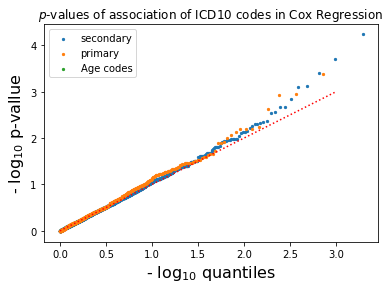

In [61]:
ps = cox_info.loc[(cox_info.n_cases >= 100) & cox_info.index.isin([c for c in all_ICD10_only_secondary if len(c) == 4])].sort_values("p_val")["p_val"]
qs = np.arange(1,ps.shape[0]+1) / ps.shape[0]
plt.scatter(-np.log10(qs),-np.log10(ps),label="secondary",s=5)

ps = cox_info.loc[(cox_info.n_cases >= 100) & cox_info.index.isin(all_ICD10_primary)].sort_values("p_val")["p_val"]
qs = np.arange(1,ps.shape[0]+1) / ps.shape[0]
plt.scatter(-np.log10(qs),-np.log10(ps),label="primary",s=5)

ps = cox_info.loc[(cox_info.n_cases >= 100) & cox_info.index.isin([str(c) for c in ages_codes])].sort_values("p_val")["p_val"]
qs = np.arange(1,ps.shape[0]+1) / ps.shape[0]
plt.scatter(-np.log10(qs),-np.log10(ps),label="Age codes",s=5)

plt.plot([0,3],[0,3],ls=":",c="red")
plt.ylabel("- $\log_{10}$ p-vallue",fontsize=16)
plt.xlabel("- $\log_{10}$ quantiles",fontsize=16)
plt.title("$p$-values of association of ICD10 codes in Cox Regression")
plt.legend();

## Benjamin-Hochberg

In [69]:
def benjamin_hochberg(df,Q = 0.05):
    C = df.sort_values("p_val")
    C["BH"] = Q*(np.arange(1,C.shape[0]+1)/C.shape[0])
    threshold = C.loc[C.p_val <= C.BH,"p_val"].max()
    return C.loc[C.p_val <= threshold]

In [70]:
MIN_N_CASES = 150
benjamin_hochberg(cox_info.loc[(cox_info.n_cases >= MIN_N_CASES) & ~cox_info.index.isin(all_ICD10_secondary) & (cox_info.isnull().sum(axis=1) == 0)])

,desc,n_cases,p_val_ADP,HR_ADP,MLOG10P,p_val,BH


In [71]:
benjamin_hochberg(cox_info.loc[(cox_info.n_cases >= MIN_N_CASES) & cox_info.index.isin(all_ICD10_secondary) & (cox_info.isnull().sum(axis=1) == 0)].sort_values("p_val"))

,desc,n_cases,p_val_ADP,HR_ADP,MLOG10P,p_val,BH


In [72]:
benjamin_hochberg(cox_info.loc[(cox_info.n_cases >= MIN_N_CASES) & (cox_info.isnull().sum(axis=1) == 0)])

,desc,n_cases,p_val_ADP,HR_ADP,MLOG10P,p_val,BH
